# Introduction

We tackle the problem of OCR post processing. In OCR, we map the image form of the document into the text domain. This is done first using an CNN+LSTM+CTC model, in our case based on tesseract. Since this output maps only image to text, we need something on top to validate and correct language semantics.

The idea is to build a language model, that takes the OCRed text and corrects it based on language knowledge. The langauge model could be:
- Char level: the aim is to capture the word morphology. In which case it's like a spelling correction system.
- Word level: the aim is to capture the sentence semnatics. But such systems suffer from the OOV problem.
- Fusion: to capture semantics and morphology language rules. The output has to be at char level, to avoid the OOV. However, the input can be char, word or both.

The fusion model target is to learn:

    p(char | char_context, word_context)

In this workbook we use seq2seq vanilla Keras implementation, adapted from the lstm_seq2seq example on Eng-Fra translation task. The adaptation involves:

- Adapt to spelling correction, on char level
- Pre-train on a noisy, medical sentences
- Fine tune a residual, to correct the mistakes of tesseract 
- Limit the input and output sequence lengths
- Enusre teacher forcing auto regressive model in the decoder
- Limit the padding per batch
- Learning rate schedule
- Bi-directional LSTM Encoder
- Bi-directional GRU Encoder


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
from nltk.tokenize import word_tokenize
%matplotlib inline

Using TensorFlow backend.


# Utility functions

In [69]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc(device_id):
    os.environ["CUDA_VISIBLE_DEVICES"]=device_id
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [70]:

gpu_alloc("0")

In [4]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]

In [5]:
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [6]:
# Artificial noisy spelling mistakes
def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0, 1, 1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0, 1, 1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i + 1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1

    return ''.join(noisy_sentence)

In [7]:
def load_data_with_gt(file_name, num_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0):
    '''Load data from txt file, with each line has: <TXT><TAB><GT>. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    for row in open(file_name, encoding='utf8'):
        if cnt < num_samples :
            #print(row)
            sents = row.split(delimiter)
            if (len(sents) < 2):
                continue            
            input_text = sents[prediction_index]
            
            target_text = '\t' + sents[gt_index] + '\n'
            if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                cnt += 1
                
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(sents[gt_index])
    return input_texts, target_texts, gt_texts

In [8]:
def load_data_with_noise(file_name, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        for row in open(file_name, encoding='utf8'):
        #for row in open(file_name):
            if cnt < num_samples :
                sents = row.split("\t")
                if (len(sents) < 2):
                    continue                
                input_text = noise_maker(sents[1], noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1] + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [9]:
def load_medical_terms_with_noise(json_file, num_samples, noise_threshold):
    with open(json_file) as f:
        med_terms_dict = json.load(f)
    med_terms = list(med_terms_dict.keys())
    input_texts = []
    gt_texts = []
    target_texts = []
    cnt = 0
    while cnt < num_samples:
        for term in med_terms:
            if cnt < num_samples :
                input_text = noise_maker(term, noise_threshold)
                input_text = input_text[:-1]   

                target_text = '\t' + term + '\n'

                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(target_text[1:-1])        
                cnt += 1
    return input_texts, target_texts, gt_texts, med_terms_dict

In [10]:
def load_accidents_terms_with_noise(file_name, limit, num_samples, noise_threshold):

    f = open(file_name, encoding='utf8')
    line = 0    
    med_terms = []
    try:
        for r in f:
            if(line < limit):

                med_terms.extend(r.split('|'))
                line += 1
    except:
        print('finished')
    input_texts = []
    gt_texts = []
    target_texts = []
    cnt = 0
    while cnt < num_samples:
        for term in med_terms:
            if cnt < num_samples :
                input_text = noise_maker(term, noise_threshold)
                input_text = input_text[:-1]   

                target_text = '\t' + term + '\n'

                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(target_text[1:-1])        
                cnt += 1
                
    return input_texts, target_texts, gt_texts

In [11]:
def load_procedures_tests_with_noise(file_name, num_samples, noise_threshold):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        for row in open(file_name, encoding='utf8'):
        #for row in open(file_name):
            if cnt < num_samples :
                
                input_text = noise_maker(row, noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + row + '\n'            

                cnt += 1
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [12]:
def build_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1


    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [13]:
def vectorize_data(input_texts, target_texts, max_encoder_seq_length, num_encoder_tokens, vocab_to_int):
    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length),
    dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_encoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            # c0..cn
            encoder_input_data[i, t] = vocab_to_int[char]
        for t, char in enumerate(target_text):
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t] = vocab_to_int[char]
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [14]:
def decode_gt_sequence(input_seq, int_to_vocab):

    stop_condition = False
    decoded_sentence = ''
    for i in range(input_seq.shape[1]):
        
        # Sample a token
        sampled_token_index = input_seq[0][i]
        sampled_char = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_char

    return decoded_sentence


In [15]:
def decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    encoder_outputs, h, c  = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    #print(input_seq)
    attention_density = []
    i = 0
    special_chars = ['\\', '/', '-', '—' , ':', '[', ']', ',', '.', '"', ';', '%', '~', '(', ')', '{', '}', '$']
    while not stop_condition:
        #print(target_seq)
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        #print(attention.shape)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        #print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #print(sampled_token_index)
        sampled_char = int_to_vocab[sampled_token_index]
        orig_char = int_to_vocab[int(input_seq[:,i][0])]
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
            sampled_char = ''

        # Copy digits as it, since the spelling corrector is not good at digit corrections
        if(orig_char.isdigit() or orig_char in special_chars):
            decoded_sentence += orig_char            
        else:
            if(sampled_char.isdigit() or sampled_char in special_chars):
                decoded_sentence += ''
            else:
                decoded_sentence += sampled_char
        


        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
        
        i += 1
        if(i > 48):
            i = 0
    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density


In [16]:
def build_model(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(encoder_inputs)    
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    print(encoder_states)
    
    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    print(decoder_outputs)
    print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    #print('context', context)
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #model = Model(decoder_inputs, decoder_outputs)
    print('encoder-decoder  model:')
    print(model.summary()) 
    
    print(encoder_inputs)
    print(encoder_outputs)
    print(encoder_states)
    #encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    #print('attention', attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    #print('context', context)
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)
    
    #decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model

In [17]:
def visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab):

    encoder_input_data = np.zeros((1, max_encoder_seq_length), dtype='float32')
    
    for t, char in enumerate(text):
        # c0..cn
        encoder_input_data[0, t] = vocab_to_int[char]

    input_seq = encoder_input_data[0:1]

    decoded_sentence, attention_density = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = sns.heatmap(attention_density[:, : len(text) + 2],
        xticklabels=[w for w in text],
        yticklabels=[w for w in decoded_sentence])

    ax.invert_yaxis()
    plt.show()
    
    return decoded_sentence

# Load data

In [18]:
data_path = '../../dat/'

In [19]:
max_sent_len = 1000000
min_sent_len = -1

## Results on tesseract correction

In [20]:
max_sent_len =  50#int(np.ceil(max_sent_len))
min_sent_len = 4#int(np.floor(min_sent_len))

In [21]:
print('Most probable length = ', max_sent_len)
print('Min length = ', min_sent_len)

Most probable length =  50
Min length =  4


In [22]:
input_texts = []
target_texts = []

In [23]:
num_samples = 1000000
input_texts = []
target_texts = []
#files_list = ['all_ocr_data_2.txt', 'field_class_21.txt', 'field_class_32.txt', 'field_class_30.txt']
files_list = ['all_ocr_data_2.txt', 'field_class_21.txt', 'field_class_22.txt', 'field_class_23.txt', 'field_class_24.txt', 'field_class_25.txt', 'field_class_26.txt', 'field_class_27.txt', 'field_class_28.txt', 'field_class_29.txt', 'field_class_30.txt', 'field_class_31.txt', 'field_class_32.txt', 'field_class_33.txt', 'field_class_34.txt', 'NL-14622714.txt', 'NL-14627449.txt', 'NL-14628986.txt', 'NL-14631911.txt', 'NL-14640007.txt']
#desired_file_sizes = [num_samples, num_samples, num_samples, num_samples]
desired_file_sizes = []
for i in range(len(files_list)):
    desired_file_sizes.append(num_samples)
noise_threshold = 0.9

for file_name, num_file_samples in zip(files_list, desired_file_sizes):
    print(file_name)
    tess_correction_data = os.path.join(data_path, file_name)
    input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_file_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0)

    input_texts += input_texts_OCR
    target_texts += target_texts_OCR

    

all_ocr_data_2.txt
field_class_21.txt
field_class_22.txt
field_class_23.txt
field_class_24.txt
field_class_25.txt
field_class_26.txt
field_class_27.txt
field_class_28.txt
field_class_29.txt
field_class_30.txt
field_class_31.txt
field_class_32.txt
field_class_33.txt
field_class_34.txt
NL-14622714.txt
NL-14627449.txt
NL-14628986.txt
NL-14631911.txt
NL-14640007.txt


In [24]:
len(input_texts)

8813

In [25]:
# Sample data
print(len(input_texts))
for i in range(10):
    print(input_texts[i], '\n', target_texts[i])

8813
Claim Type: VB Accident - Accidental Injury 
 	Claim Type: VB Accident - Accidental Injury


Pol inyhold elm-Chm er [11 form arlon 
 	Policyholder/Owner Information


First Name: 
 	First Name:


Middle Nameﬂnitial: 
 	Middle Name/Initial:


Last Name: 
 	Last Name:


Social S ecurity Number: 
 	Social Security Number:


Birth Date: 
 	Birth Date:


Gender: 
 	Gender:


Language Preference: 
 	Language Preference:


Address Line 1: 
 	Address Line 1:




## Build vocab

In [26]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_vocab(all_texts)
np.savez('vocab-{}'.format(max_sent_len), vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )

In [27]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [28]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 8813
Number of unique input tokens: 126
Number of unique output tokens: 126
Max sequence length for inputs: 49
Max sequence length for outputs: 49


In [29]:
vocab_to_int # Some special chars need to be removed TODO: Data cleaning

{'\t': 2,
 '\n': 3,
 '\x0c': 120,
 ' ': 1,
 '!': 111,
 '"': 95,
 '#': 67,
 '$': 79,
 '%': 85,
 '&': 73,
 "'": 83,
 '(': 61,
 ')': 62,
 '*': 77,
 '+': 76,
 ',': 69,
 '-': 21,
 '.': 54,
 '/': 29,
 '0': 63,
 '1': 43,
 '2': 53,
 '3': 52,
 '4': 66,
 '5': 74,
 '6': 65,
 '7': 70,
 '8': 58,
 '9': 72,
 ':': 13,
 ';': 75,
 '<': 105,
 '=': 94,
 '>': 106,
 '?': 56,
 '@': 81,
 'A': 16,
 'B': 15,
 'C': 4,
 'D': 40,
 'E': 45,
 'F': 33,
 'G': 41,
 'H': 57,
 'I': 22,
 'J': 68,
 'K': 49,
 'L': 37,
 'M': 36,
 'N': 35,
 'O': 30,
 'P': 26,
 'Q': 78,
 'R': 46,
 'S': 38,
 'T': 9,
 'U': 48,
 'UNK': 0,
 'V': 14,
 'W': 50,
 'X': 80,
 'Y': 47,
 'Z': 71,
 '[': 91,
 '\\': 97,
 ']': 92,
 '^': 86,
 '_': 102,
 'a': 6,
 'b': 39,
 'c': 17,
 'd': 18,
 'e': 12,
 'f': 32,
 'g': 42,
 'h': 28,
 'i': 7,
 'j': 23,
 'k': 55,
 'l': 5,
 'm': 8,
 'n': 19,
 'o': 27,
 'p': 11,
 'q': 51,
 'r': 25,
 's': 34,
 't': 20,
 'u': 24,
 'v': 44,
 'w': 31,
 'x': 59,
 'y': 10,
 'z': 60,
 '{': 113,
 '|': 82,
 '}': 104,
 '~': 110,
 '¢': 121,
 '£

In [30]:
int_to_vocab

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'C',
 5: 'l',
 6: 'a',
 7: 'i',
 8: 'm',
 9: 'T',
 10: 'y',
 11: 'p',
 12: 'e',
 13: ':',
 14: 'V',
 15: 'B',
 16: 'A',
 17: 'c',
 18: 'd',
 19: 'n',
 20: 't',
 21: '-',
 22: 'I',
 23: 'j',
 24: 'u',
 25: 'r',
 26: 'P',
 27: 'o',
 28: 'h',
 29: '/',
 30: 'O',
 31: 'w',
 32: 'f',
 33: 'F',
 34: 's',
 35: 'N',
 36: 'M',
 37: 'L',
 38: 'S',
 39: 'b',
 40: 'D',
 41: 'G',
 42: 'g',
 43: '1',
 44: 'v',
 45: 'E',
 46: 'R',
 47: 'Y',
 48: 'U',
 49: 'K',
 50: 'W',
 51: 'q',
 52: '3',
 53: '2',
 54: '.',
 55: 'k',
 56: '?',
 57: 'H',
 58: '8',
 59: 'x',
 60: 'z',
 61: '(',
 62: ')',
 63: '0',
 64: '’',
 65: '6',
 66: '4',
 67: '#',
 68: 'J',
 69: ',',
 70: '7',
 71: 'Z',
 72: '9',
 73: '&',
 74: '5',
 75: ';',
 76: '+',
 77: '*',
 78: 'Q',
 79: '$',
 80: 'X',
 81: '@',
 82: '|',
 83: "'",
 84: '•',
 85: '%',
 86: '^',
 87: '●',
 88: 'ﬁ',
 89: '”',
 90: '°',
 91: '[',
 92: ']',
 93: '–',
 94: '=',
 95: '"',
 96: '✓',
 97: '\\',
 98: '☐',
 99: '☒',
 100:

In [31]:
len(int_to_vocab)

126

# Prepare training data

## Train/test split

In [32]:
# Split the data into training and testing sentences
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

## Vectorize data

## Train data

In [33]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

In [34]:
print(encoder_input_data.shape)
print(decoder_target_data.shape)

(7491, 49)
(7491, 49, 126)


## Test data

In [35]:
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)

# Encoder-decoder model

In [36]:

latent_dim = 256  # Latent dimensionality of the encoding space.

In [37]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

[<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]
Tensor("lstm_2/transpose_2:0", shape=(?, ?, 512), dtype=float32)
Tensor("bidirectional_1/concat:0", shape=(?, ?, 512), dtype=float32)
attention Tensor("attention/truediv:0", shape=(?, ?, ?), dtype=float32)
encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 126)    15876       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, No

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


# Training

In [38]:
batch_size = 64  # Batch size for training.
epochs = 20  
lr = 0.01

# Learning rate decay

In [39]:
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [40]:
#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model-{}.hdf5".format(max_sent_len) # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]



In [41]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
#lr = 0

In [42]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
#lr = 0

In [43]:
#callbacks_list.append(lrate)

In [44]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

Train on 7491 samples, validate on 1322 samples
Epoch 1/20
7491/7491 [==============================] - 24s 3ms/step - loss: 2.5089 - categorical_accuracy: 0.3211 - val_loss: 1.1631 - val_categorical_accuracy: 0.6710

Epoch 00001: val_categorical_accuracy improved from -inf to 0.67097, saving model to best_model-50.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/20
7491/7491 [==============================] - 23s 3ms/step - loss: 0.5749 - categorical_accuracy: 0.8301 - val_loss: 0.3991 - val_categorical_accuracy: 0.8709

Epoch 00002: val_categorical_accuracy improved from 0.67097 to 0.87086, saving model to best_model-50.hdf5
Epoch 3/20
7491/7491 [==============================] - 23s 3ms/step - loss: 0.3471 - categorical_accuracy: 0.8780 - val_loss: 0.3499 - val_categorical_accuracy: 0.8812

Epoch 00003: val_categorical_accuracy improved from 0.87086 to 0.88121, saving model to best_model-50.hdf5
Epoch 4/20
7491/7491 [==============================] - 23s 3ms/step - loss: 0.2844 - categorical_accuracy: 0.8897 - val_loss: 0.3327 - val_categorical_accuracy: 0.8833

Epoch 00004: val_categorical_accuracy improved from 0.88121 to 0.88327, saving model to best_model-50.hdf5
Epoch 5/20
7491/7491 [==============================] - 23s 3ms/step - loss: 0.2419 - categorical_accuracy: 0.8983 - val_loss: 0.2963 - val_categorical_accuracy: 0.8927


In [45]:
encoder_model.save('encoder_model-{}.hdf5'.format(max_sent_len))
decoder_model.save('decoder_model-{}.hdf5'.format(max_sent_len))

/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_4:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'input_5:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


# Inference

In [46]:

def tokenize(text):
    return text.split(' ') # word_tokenize(text)

In [47]:
def split_ngrams(text, n):
    assert(n!=0)
    words = tokenize(text)
    start = 0
    splits = []    
    end = min(len(words), start + n)
    while start < len(words):
        splits.append(' '.join(words[start:end]))
        start += n
        end = min(len(words), start + n)
    return splits

In [48]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_text = input_texts[seq_index]
    target_text = target_texts[seq_index][1:-1]
    splits = split_ngrams(input_text, n=3)
    decoded_splits = []
    for split in splits:    
        encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=[split],
                                                                                     target_texts=[target_text], 
                                                                                     max_encoder_seq_length=max_encoder_seq_length, 
                                                                                     num_encoder_tokens=num_encoder_tokens, 
                                                                                     vocab_to_int=vocab_to_int)    

        input_seq = encoder_input_data
        #target_seq = np.argmax(decoder_target_data, axis=-1)
        #print(target_seq)
        decoded_split, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
        decoded_splits.append(decoded_split)
    decoded_sentence = ' '.join(decoded_splits) 
    print('-')
    print('Input sentence:', input_text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: Electronically Signed Date:
GT sentence: Electronically Signed Date:

Decoded sentence: Electronically Signed Date:
-
Input sentence: Group No:
GT sentence: Group No:

Decoded sentence: Group No:
-
Input sentence: each such violation.
GT sentence: each such violation.

Decoded sentence: each such violation.
-
Input sentence: roup and its insuring subsidiaries.
GT sentence: Group and its insuring subsidiaries.

Decoded sentence: roup and its insuring subsidiaries.
-
Input sentence: no symptoms reported
GT sentence: no symptoms reported

Decoded sentence: no symptoms reported
-
Input sentence: to (mmiddiyy)
GT sentence: to (mm/dd/yy)

Decoded sentence: to (mmddyy)
-
Input sentence: Fall Assessment
GT sentence: Fall Assessment

Decoded sentence: Fall Assessment
-
Input sentence: 131 Miller St
GT sentence: 131 Miller St

Decoded sentence: 131 Miller St
-
Input sentence: Dr. Jon J» Dewnte, M.D.:
GT sentence: Dr. Jon J. Dewitte, M.D.:

Decoded sentence: Dr. J Dewntt, ..:
-


-
Input sentence: treating phye.clan telephone number
GT sentence: Treating phycian Telephone Number

Decoded sentence: Treating phys.cian Telephone Number
-
Input sentence: Time ofAceident:
GT sentence: Time of Accident:

Decoded sentence: Time of Acciden:
-
Input sentence: Patient #:
GT sentence: Patient #: 

Decoded sentence: Patient #: 
-
Input sentence: Conﬁrmation of Coverage 
GT sentence: Confirmation of Coverage

Decoded sentence: Confirmation of Coverage Pay
-
Input sentence: Event dates: unknown rtw
GT sentence: Event dates: unknown rtw

Decoded sentence: Event dates: unknown www
-
Input sentence: Bradycardia
GT sentence: Bradycardia

Decoded sentence: Bradycardia
-
Input sentence: Diagnosis 72 a itd alozhs :
GT sentence: Diagnosis: 722.211A

Decoded sentence: Date of Ac72den Iffysician
-
Input sentence: (Name) {Telephone Number)
GT sentence: (Name) (Telephone Number)

Decoded sentence: (Name) {Telephone Number)
-
Input sentence: Number of Hours Worked on Date Last Worked
GT 

# Visualize attention

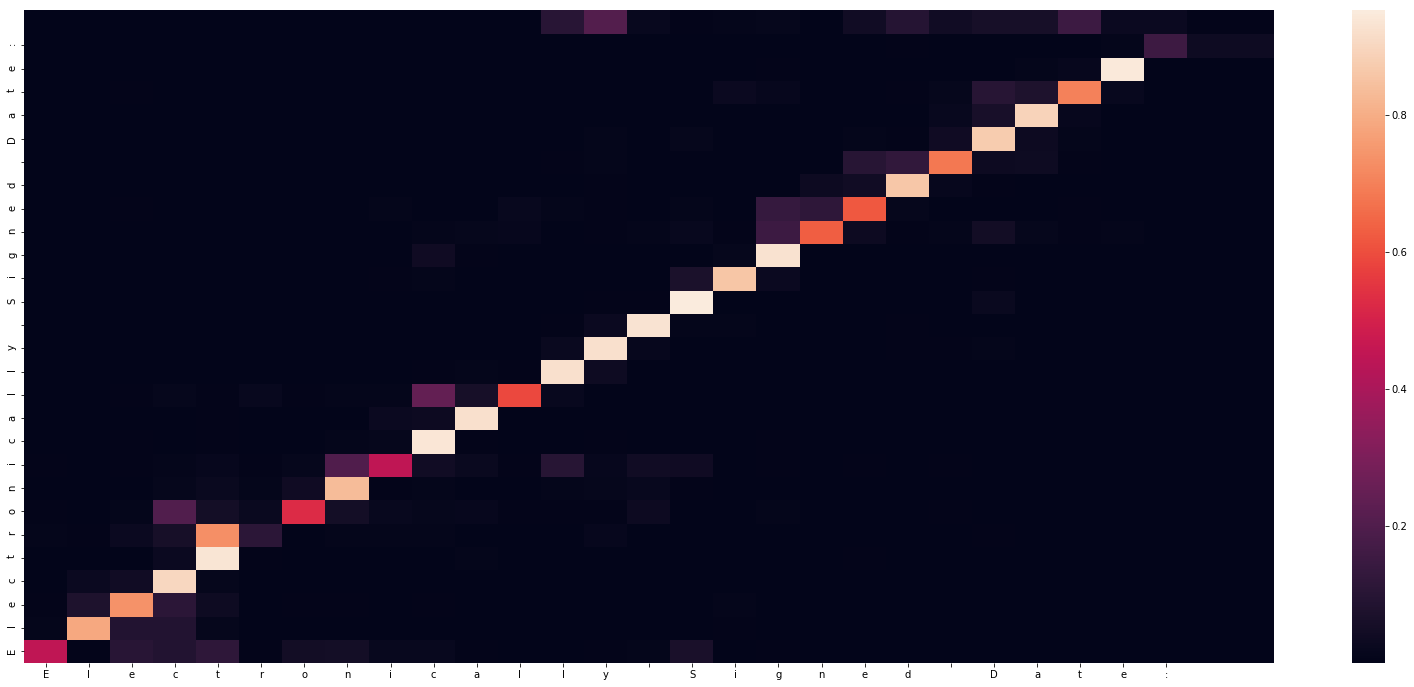

-
Input sentence: Electronically Signed Date:
GT sentence: Electronically Signed Date:

Decoded sentence: Electronically Signed Date:


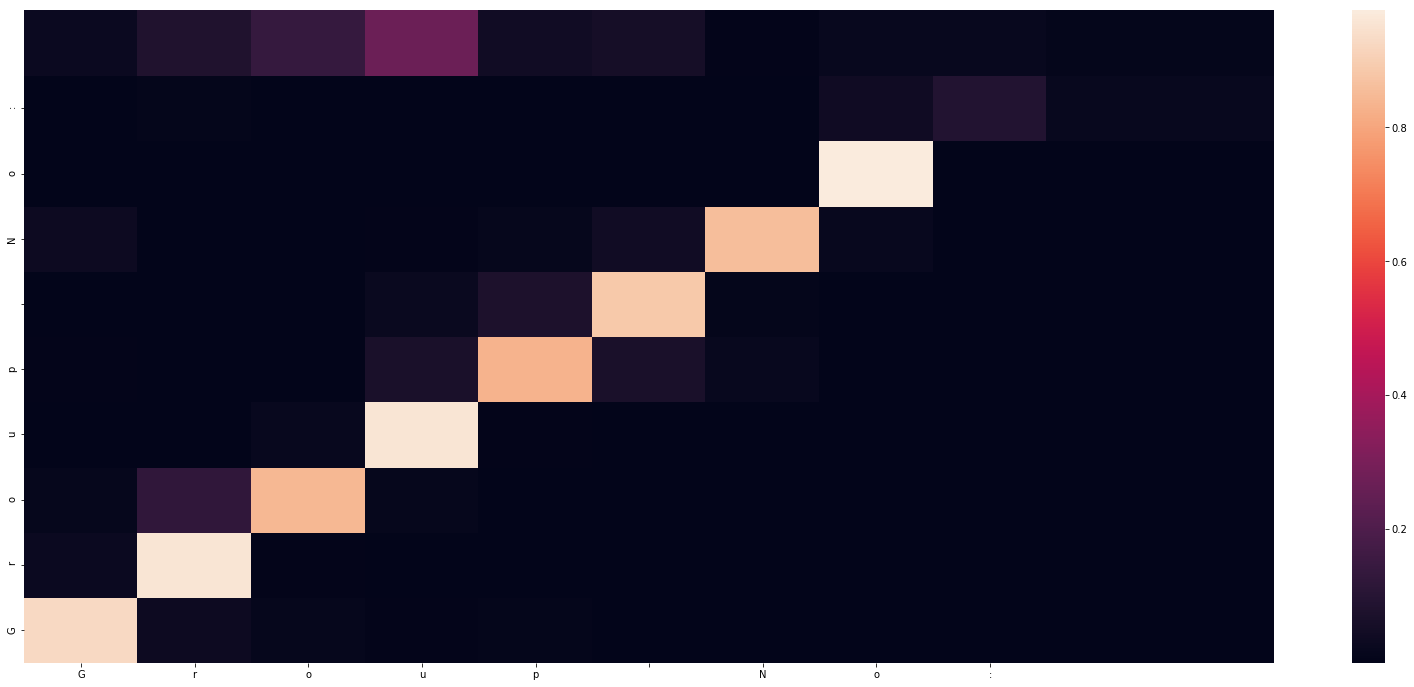

-
Input sentence: Group No:
GT sentence: Group No:

Decoded sentence: Group No:


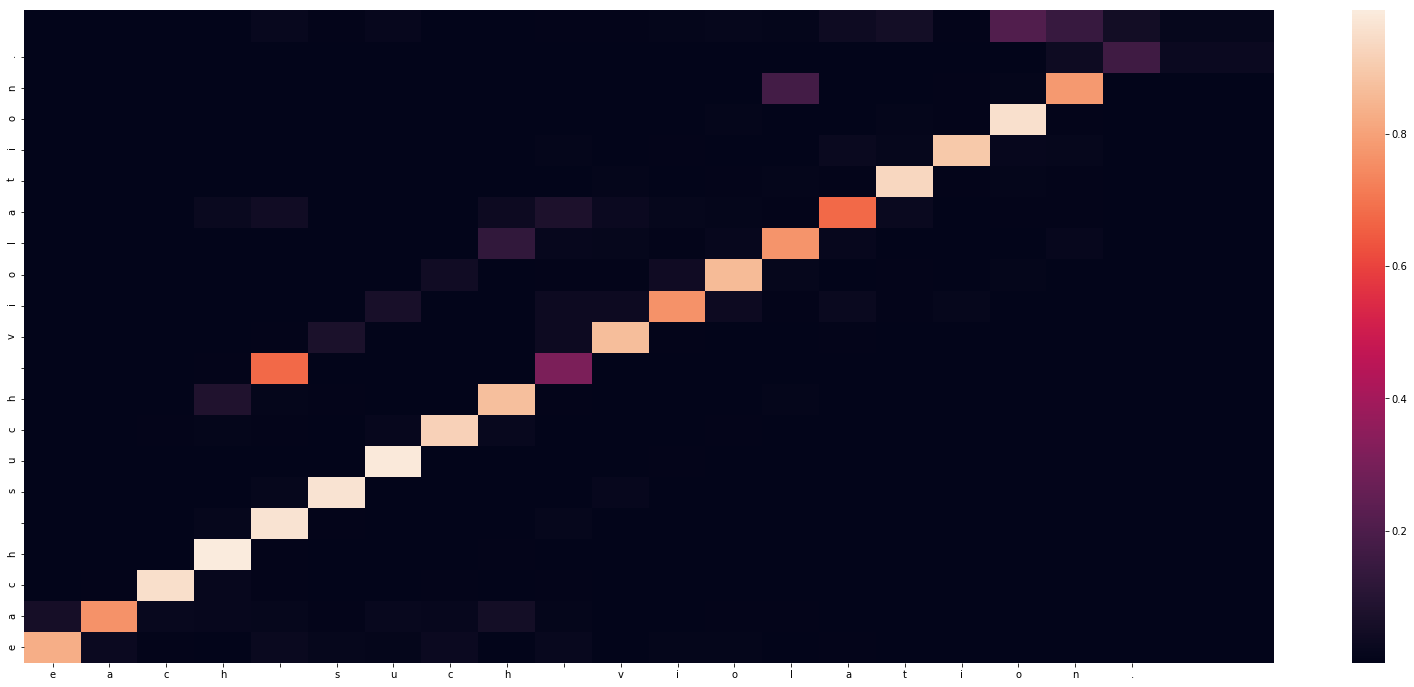

-
Input sentence: each such violation.
GT sentence: each such violation.

Decoded sentence: each such violation.


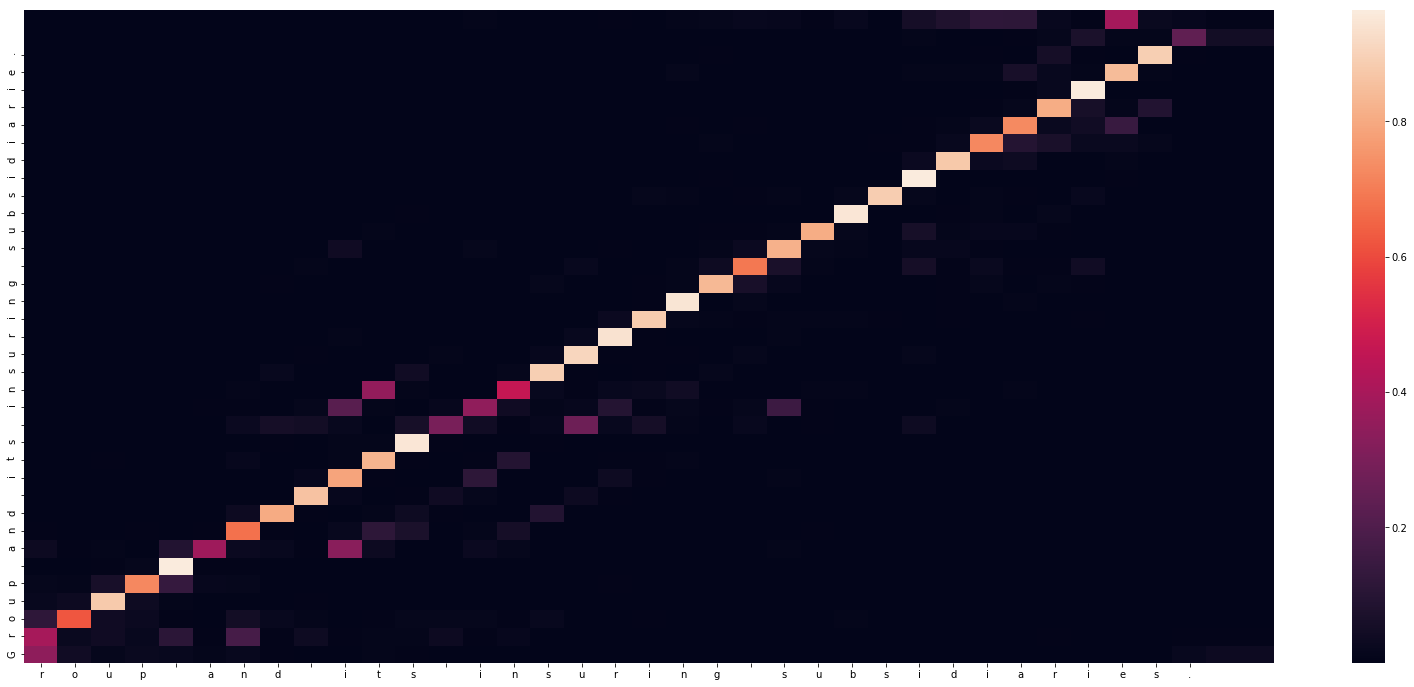

-
Input sentence: roup and its insuring subsidiaries.
GT sentence: Group and its insuring subsidiaries.

Decoded sentence: Group and its insuring subsidiarie.


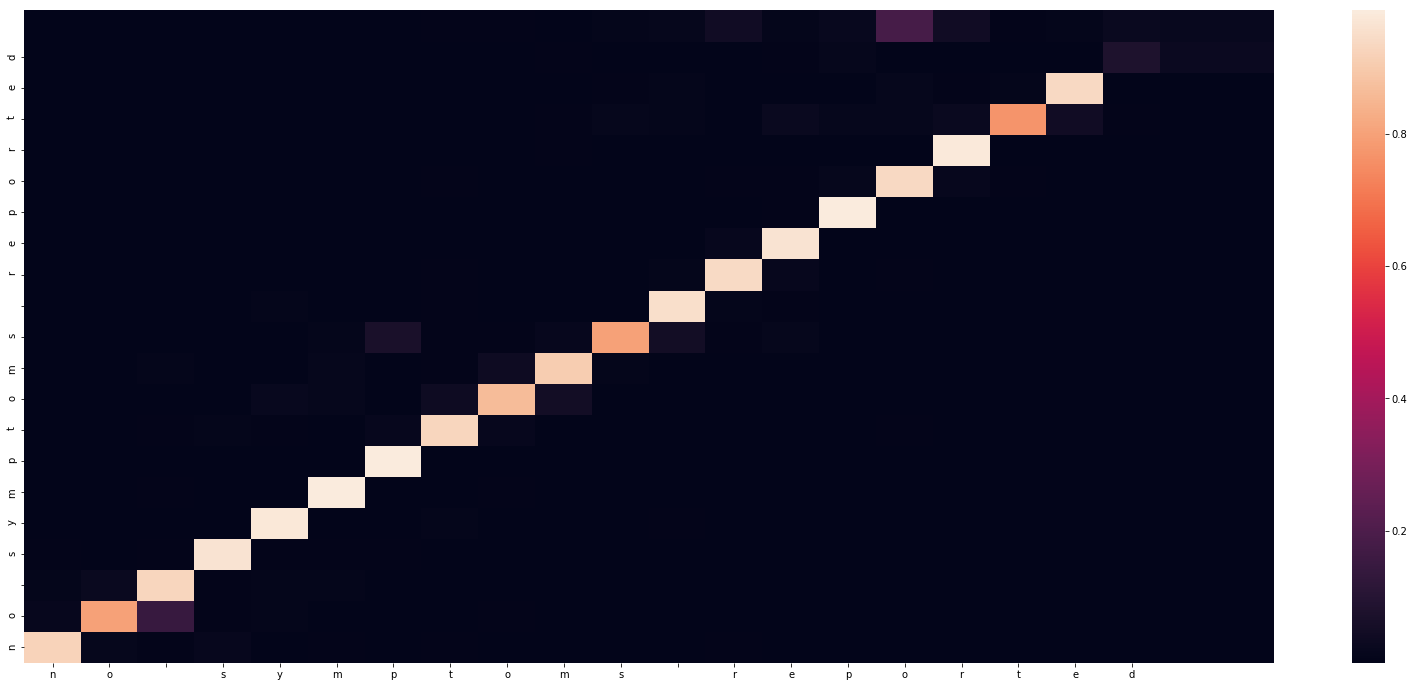

-
Input sentence: no symptoms reported
GT sentence: no symptoms reported

Decoded sentence: no symptoms reported


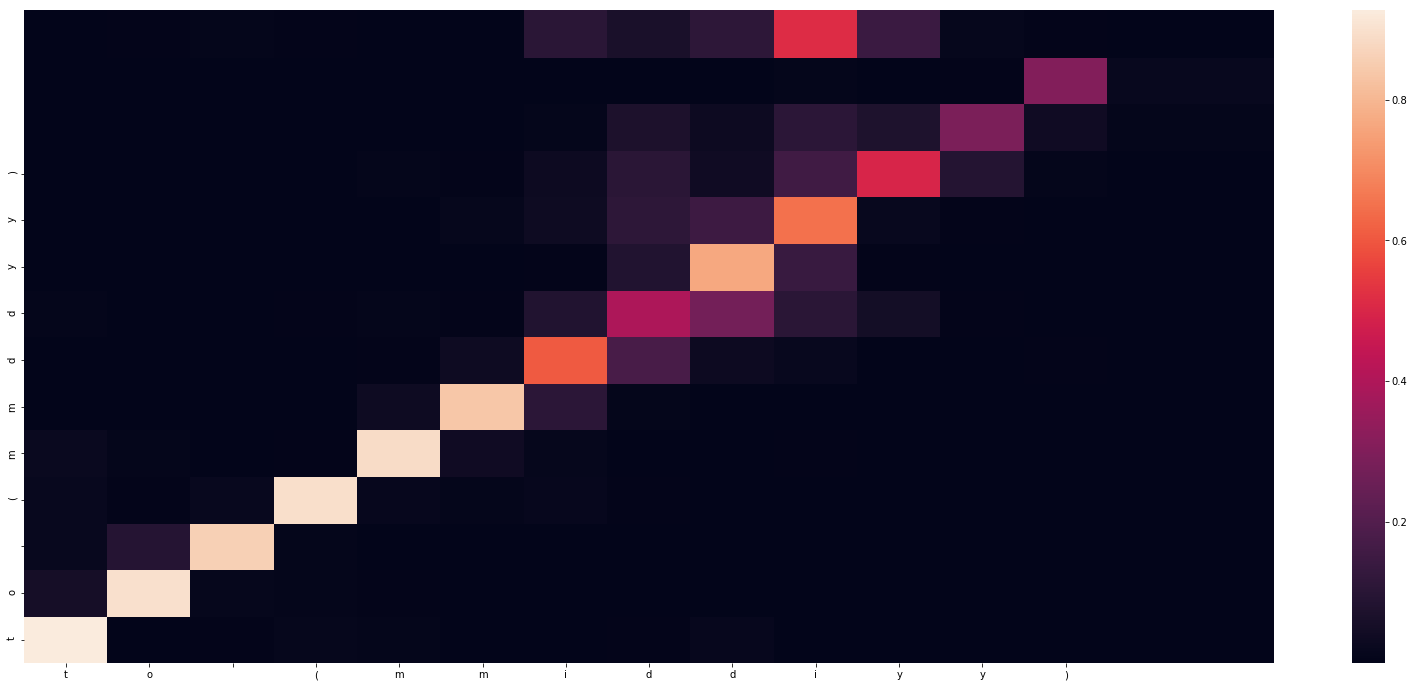

-
Input sentence: to (mmiddiyy)
GT sentence: to (mm/dd/yy)

Decoded sentence: to (mmddyy)


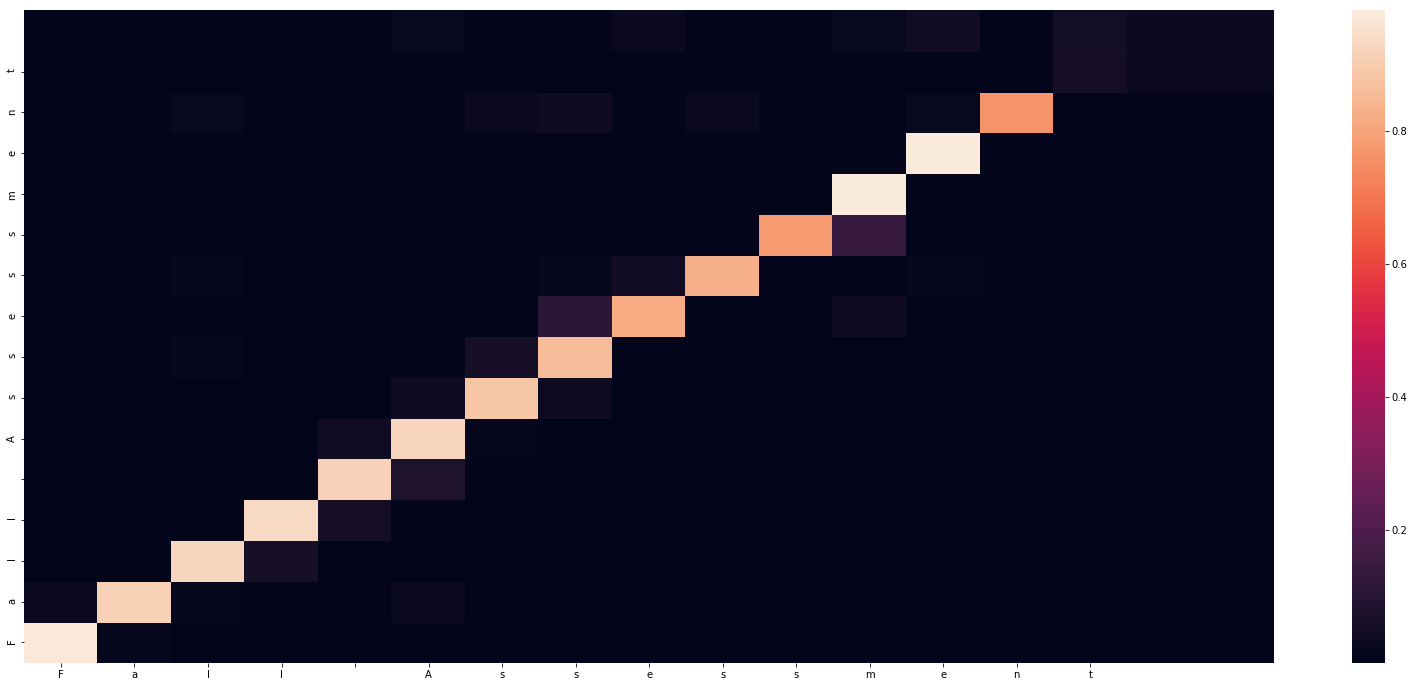

-
Input sentence: Fall Assessment
GT sentence: Fall Assessment

Decoded sentence: Fall Assessment


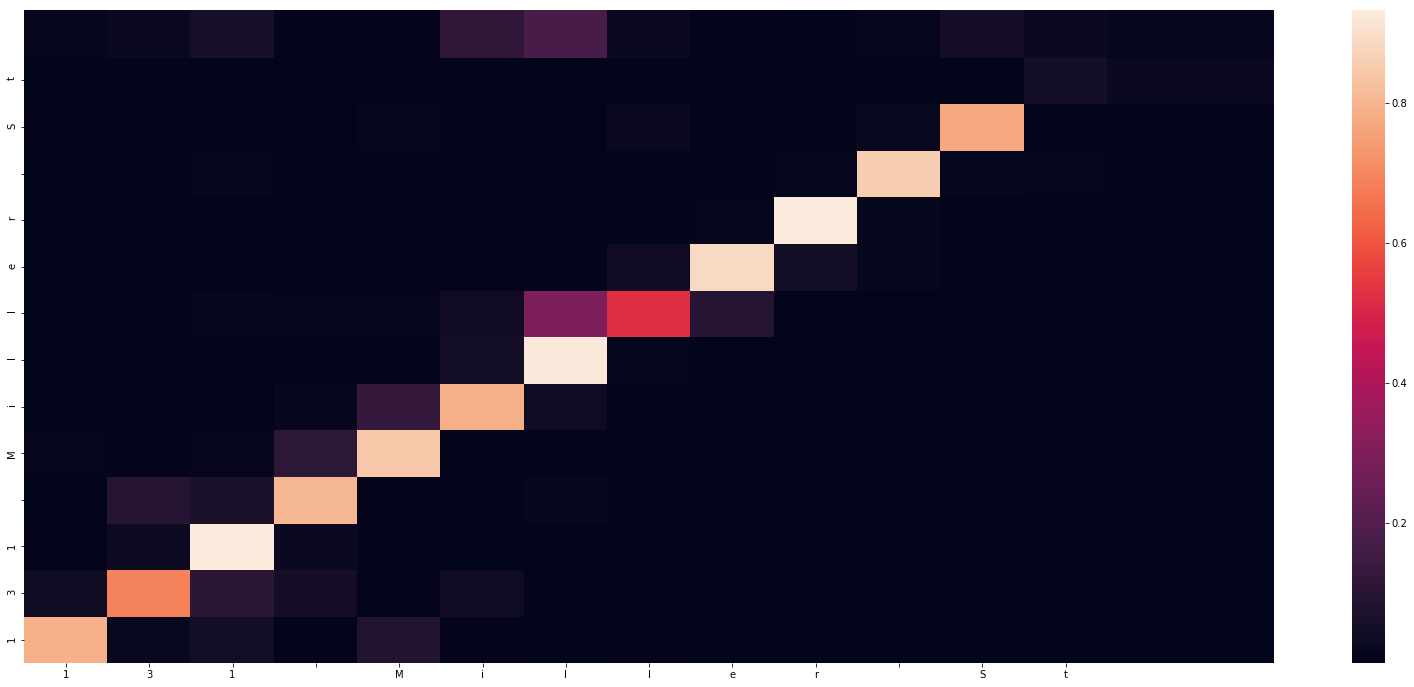

-
Input sentence: 131 Miller St
GT sentence: 131 Miller St

Decoded sentence: 131 Miller St


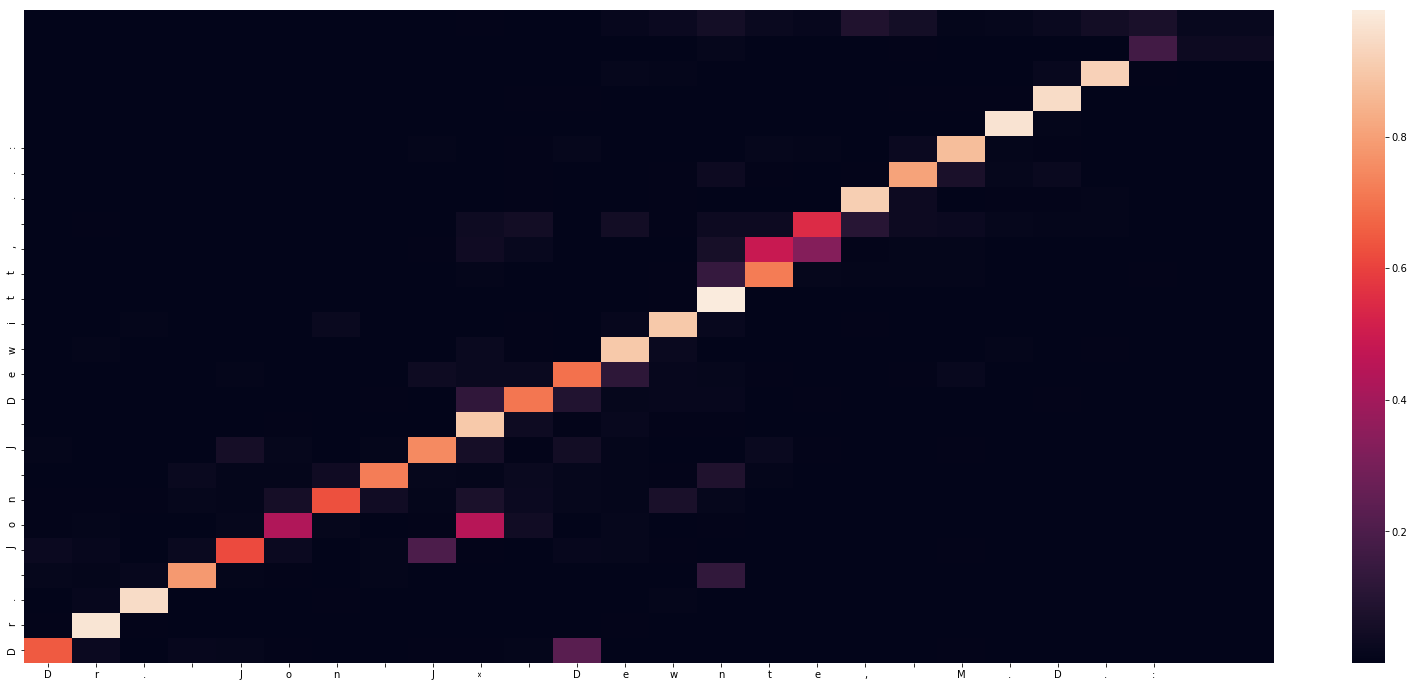

-
Input sentence: Dr. Jon J» Dewnte, M.D.:
GT sentence: Dr. Jon J. Dewitte, M.D.:

Decoded sentence: Dr. Jon J Dewitt, ..:


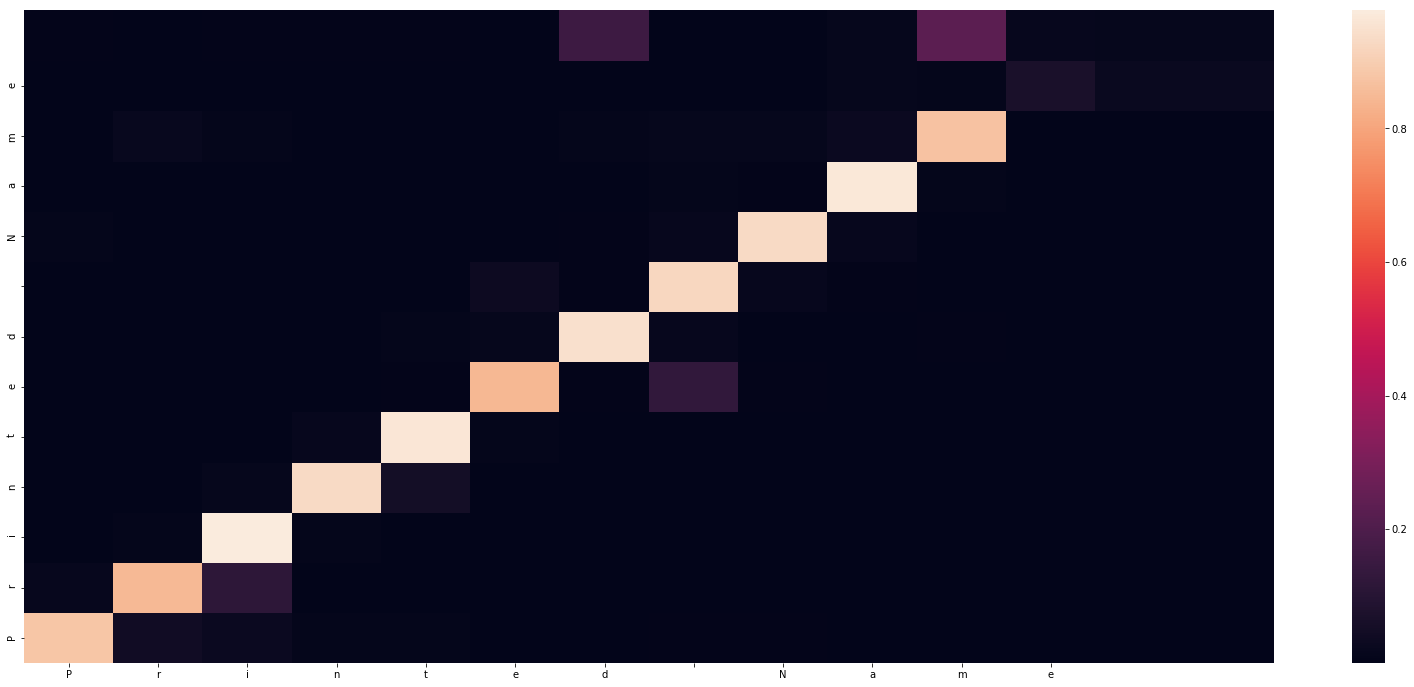

-
Input sentence: Printed Name
GT sentence: Printed Name

Decoded sentence: Printed Name


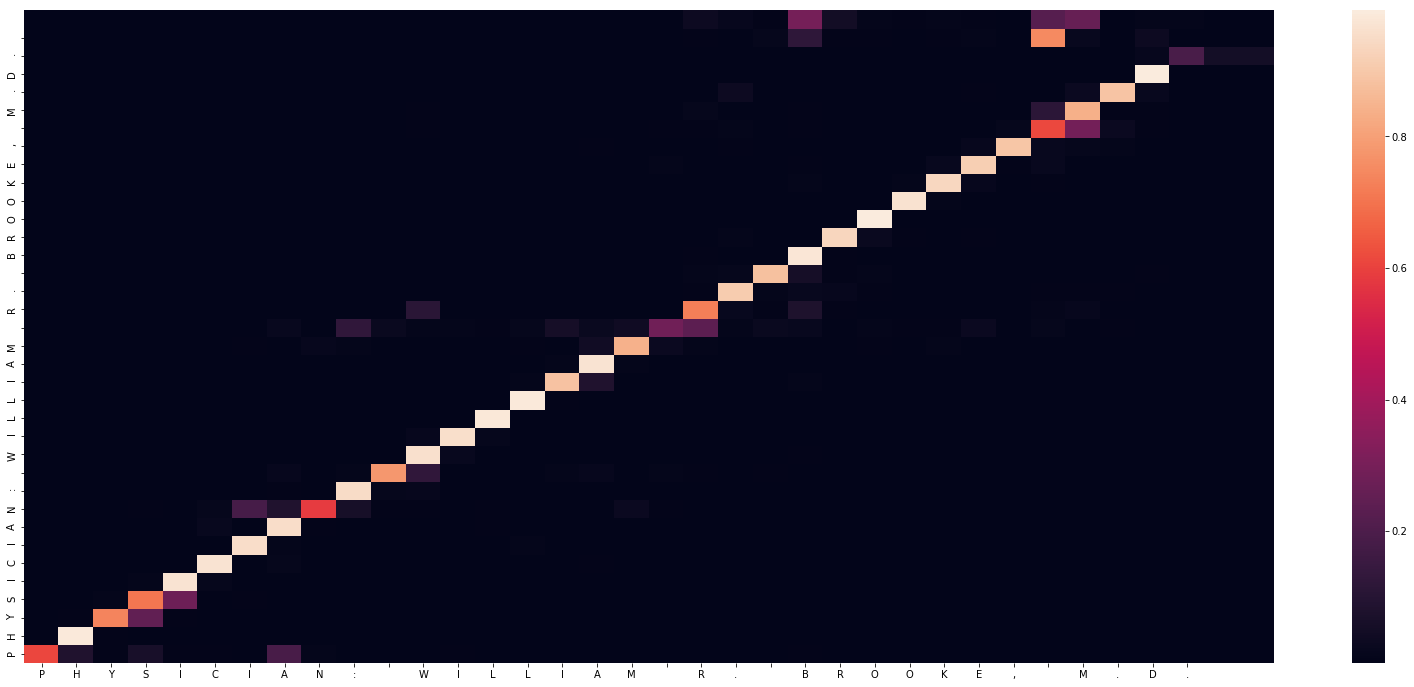

-
Input sentence: PHYSICIAN: WILLIAM R. BROOKE, M.D.
GT sentence: PHYSICIAN: WILLIAM R. BROOKE, M.D. 

Decoded sentence: PHYSICIAN: WILLIAM R. BROOKE, M.D. 


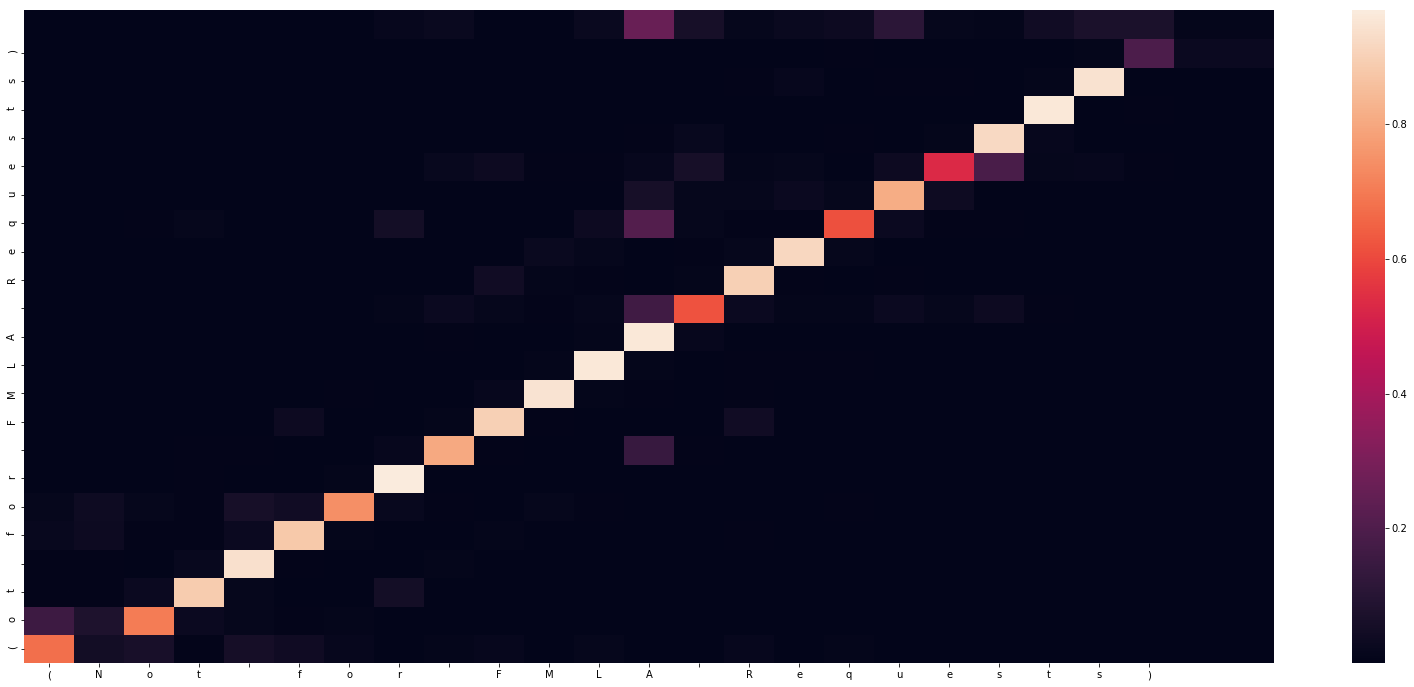

-
Input sentence: (Not for FMLA Requests)
GT sentence: (Not for FMLA Requests)

Decoded sentence: (ot for FMLA Requests)


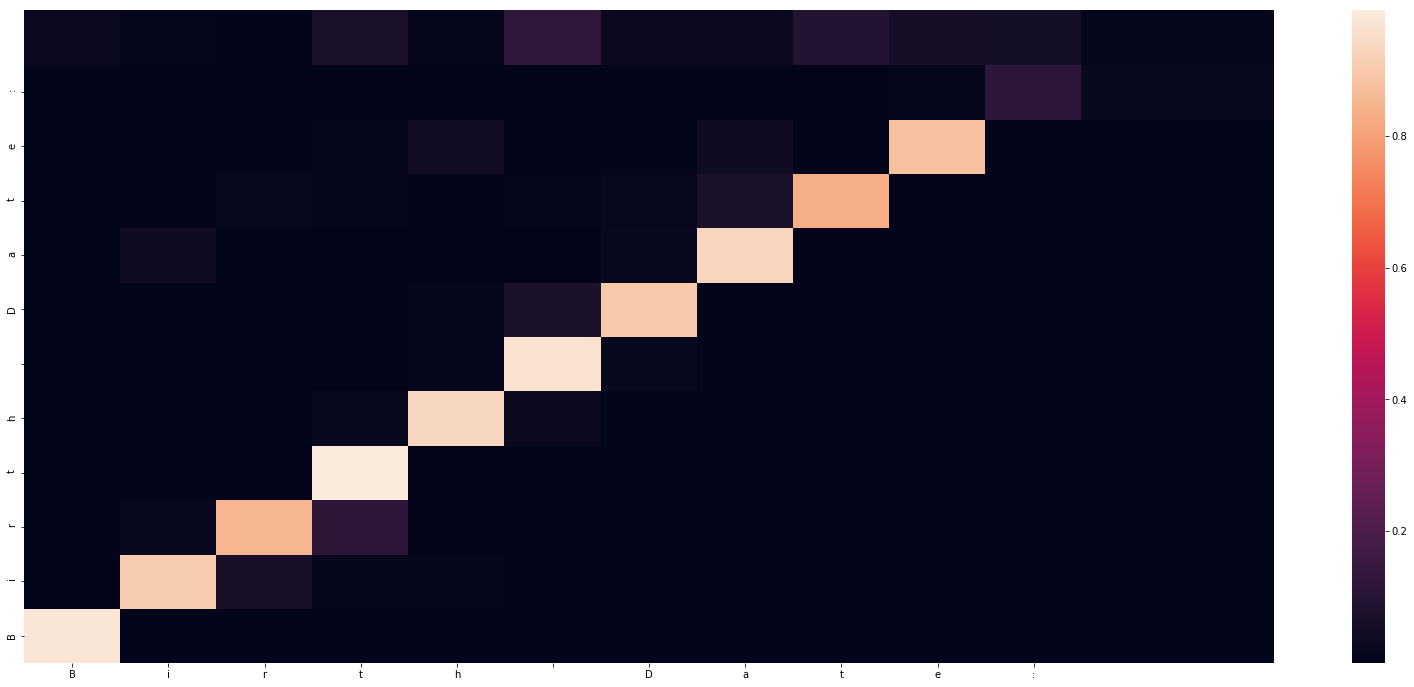

-
Input sentence: Birth Date:
GT sentence: Birth Date:

Decoded sentence: Birth Date:


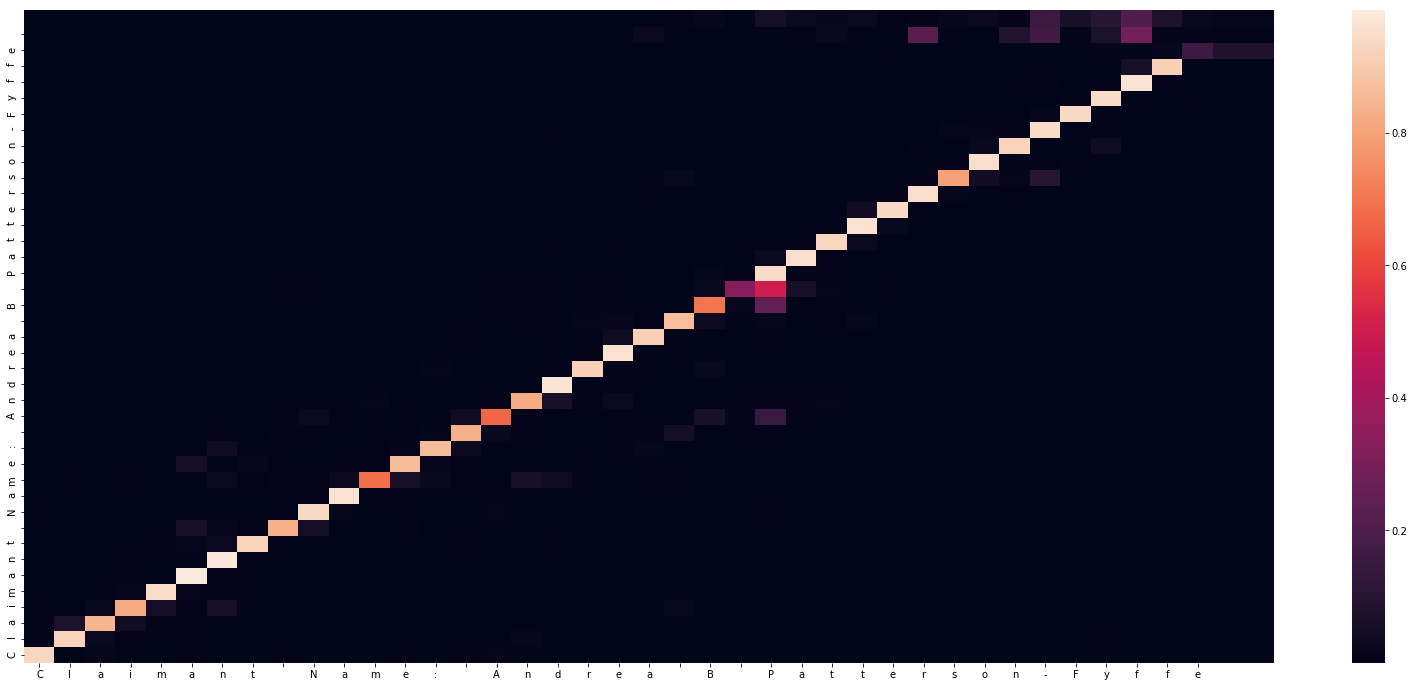

-
Input sentence: Claimant Name: Andrea B Patterson-Fyffe
GT sentence: Claimant Name: Andrea B Patterson-Fyffe

Decoded sentence: Claimant Name: Andrea B Patterson-Fyffe 


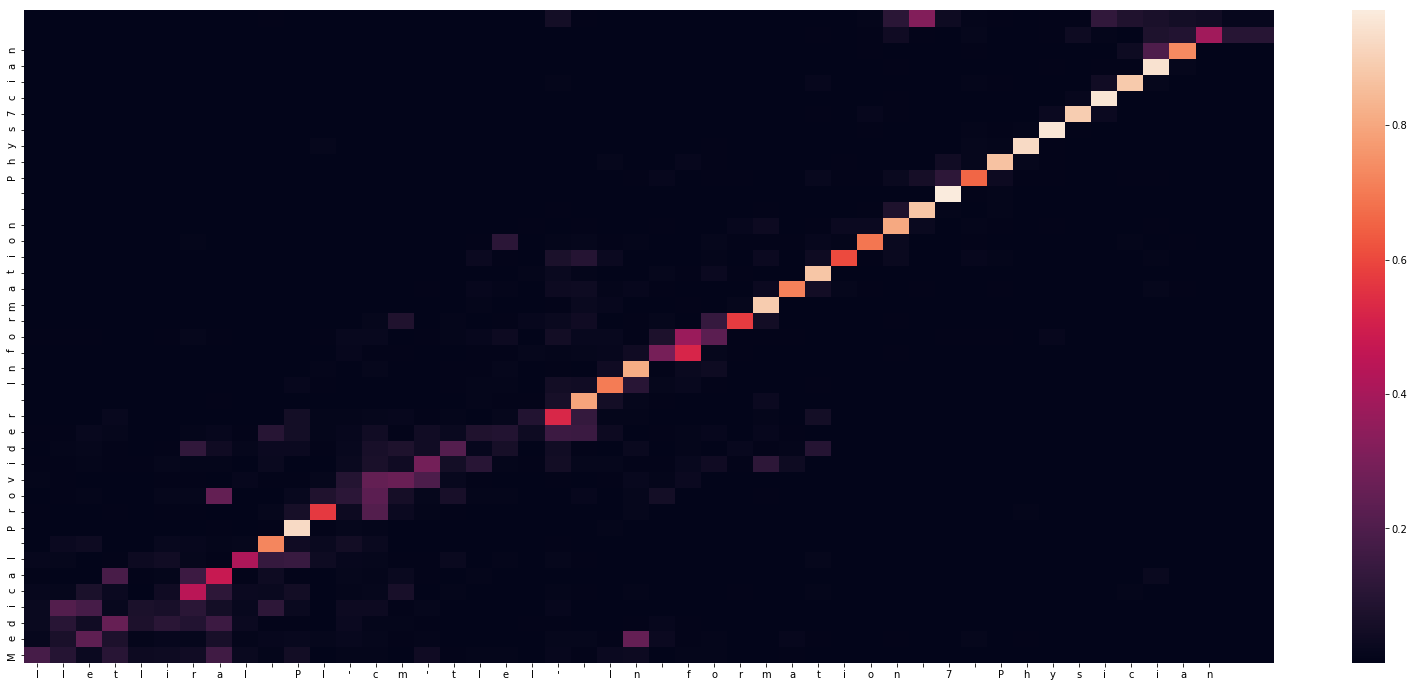

-
Input sentence: lletliral Pl'cm'tlel' In formation 7 Physician
GT sentence: Medical Provider Information - Physician

Decoded sentence: Medical Provider Information  Phys7cian


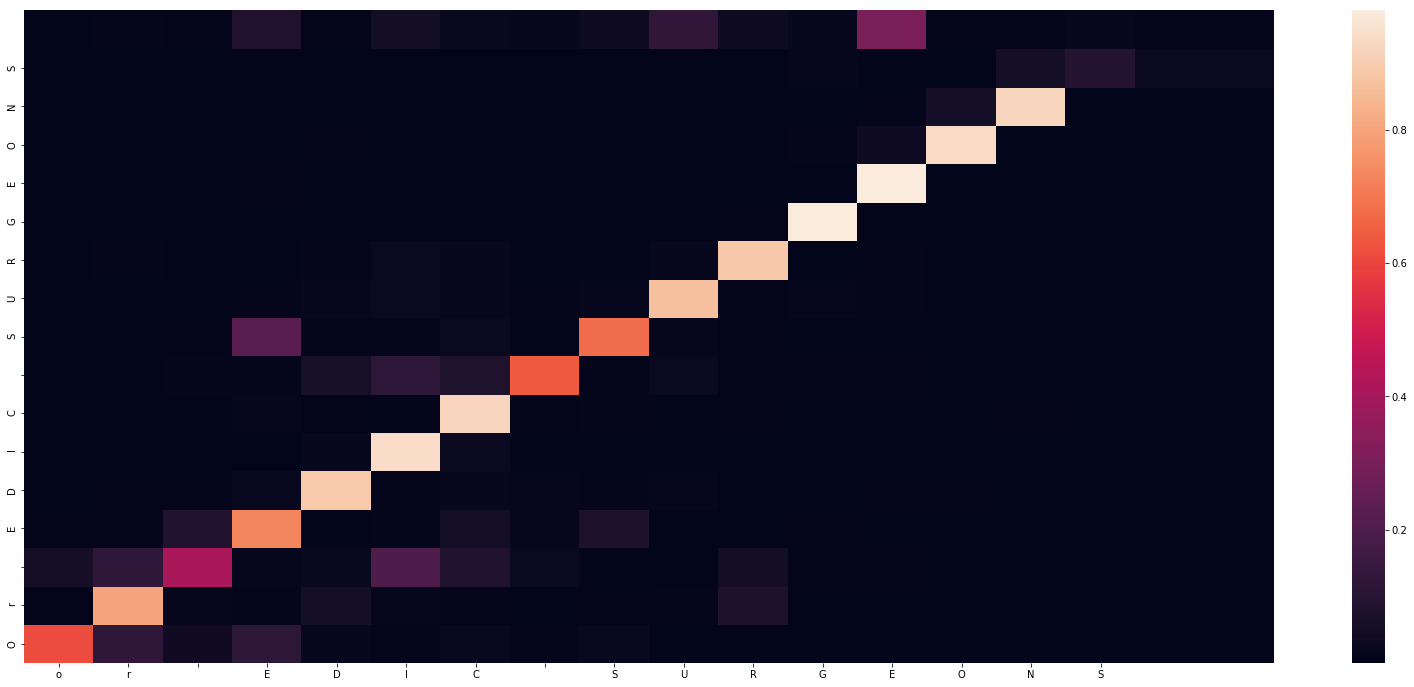

-
Input sentence: or EDIC SURGEONS
GT sentence: ORTHOPAEDIC SURGEONS

Decoded sentence: Or EDIC SURGEONS


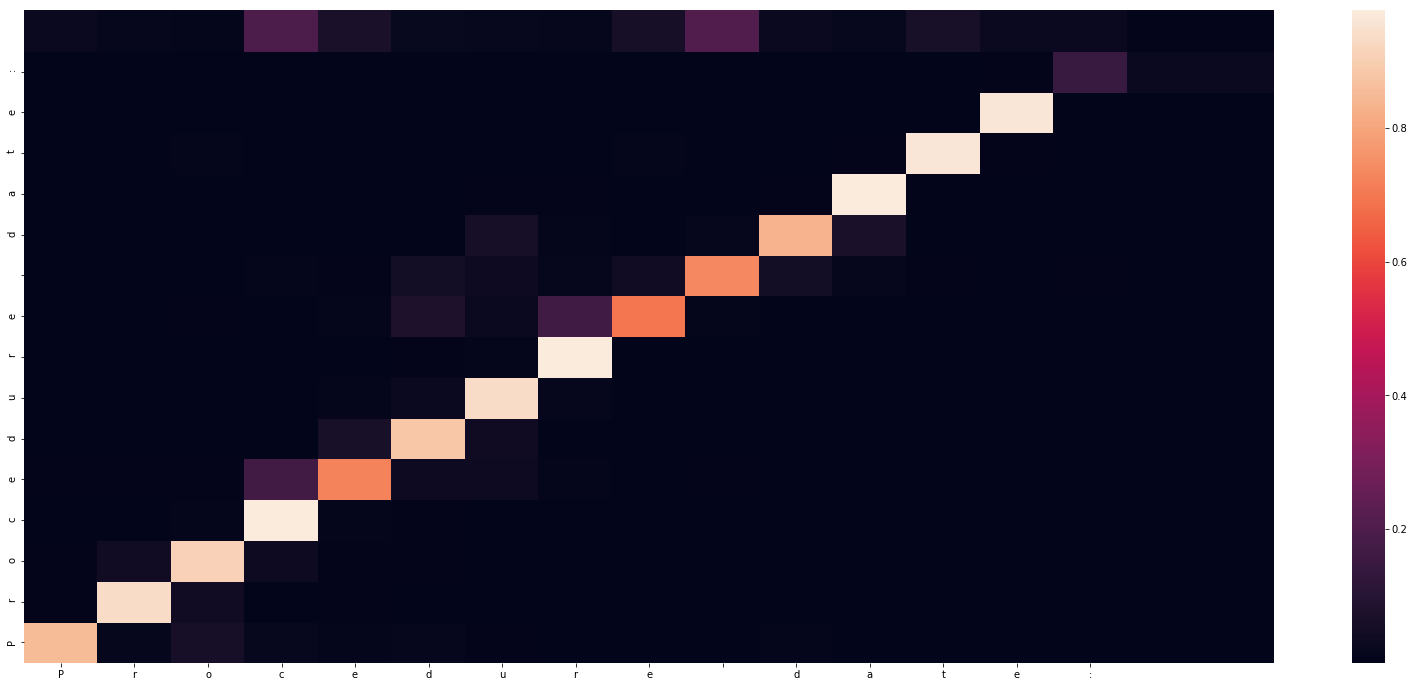

-
Input sentence: Procedure date:
GT sentence: Procedure date:

Decoded sentence: Procedure date:


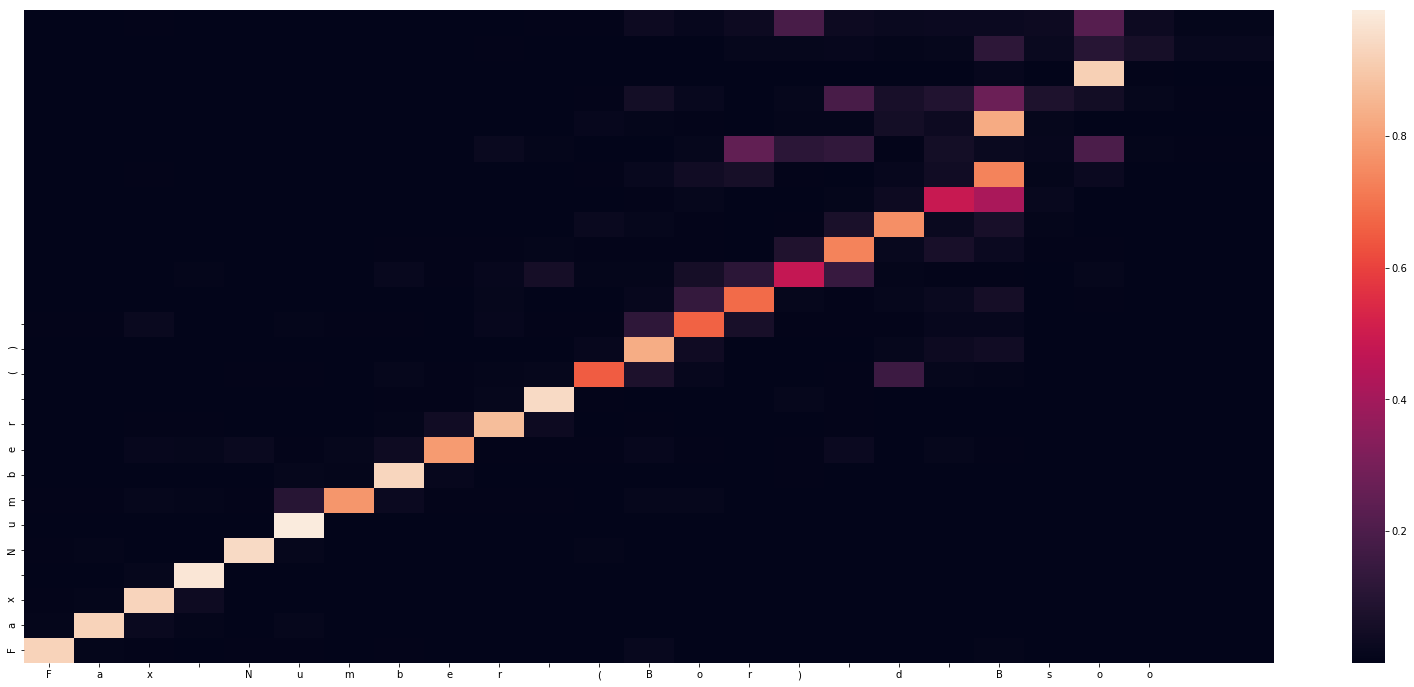

-
Input sentence: Fax Number (Bor) d Bsoo
GT sentence: Fax Number (308) 728-3500

Decoded sentence: Fax Number () 


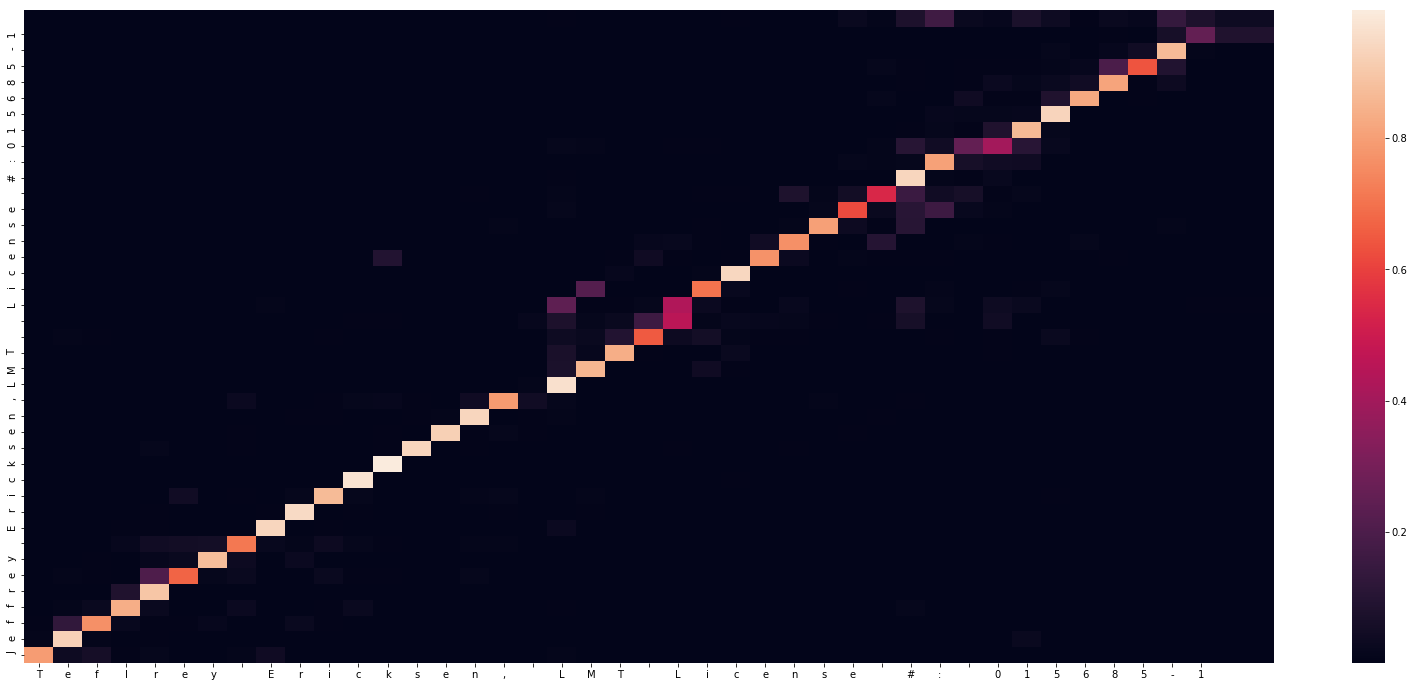

-
Input sentence: Teflrey Ericksen, LMT License #: 015685-1
GT sentence: Jeffrey Ericksen,LMT  License #:015685-1

Decoded sentence: Jeffrey Ericksen,LMT  License #:015685-1


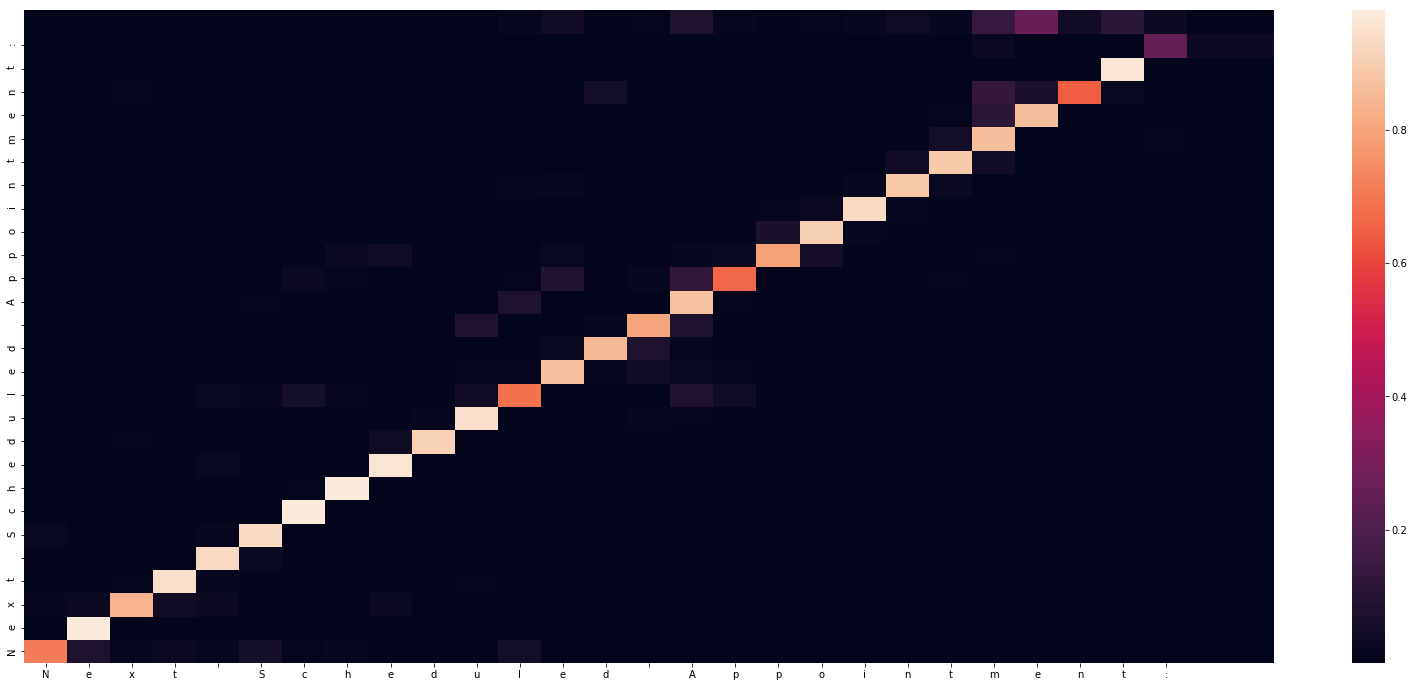

-
Input sentence: Next Scheduled Appointment:
GT sentence: Next Scheduled Appointment:

Decoded sentence: Next Scheduled Appointment:


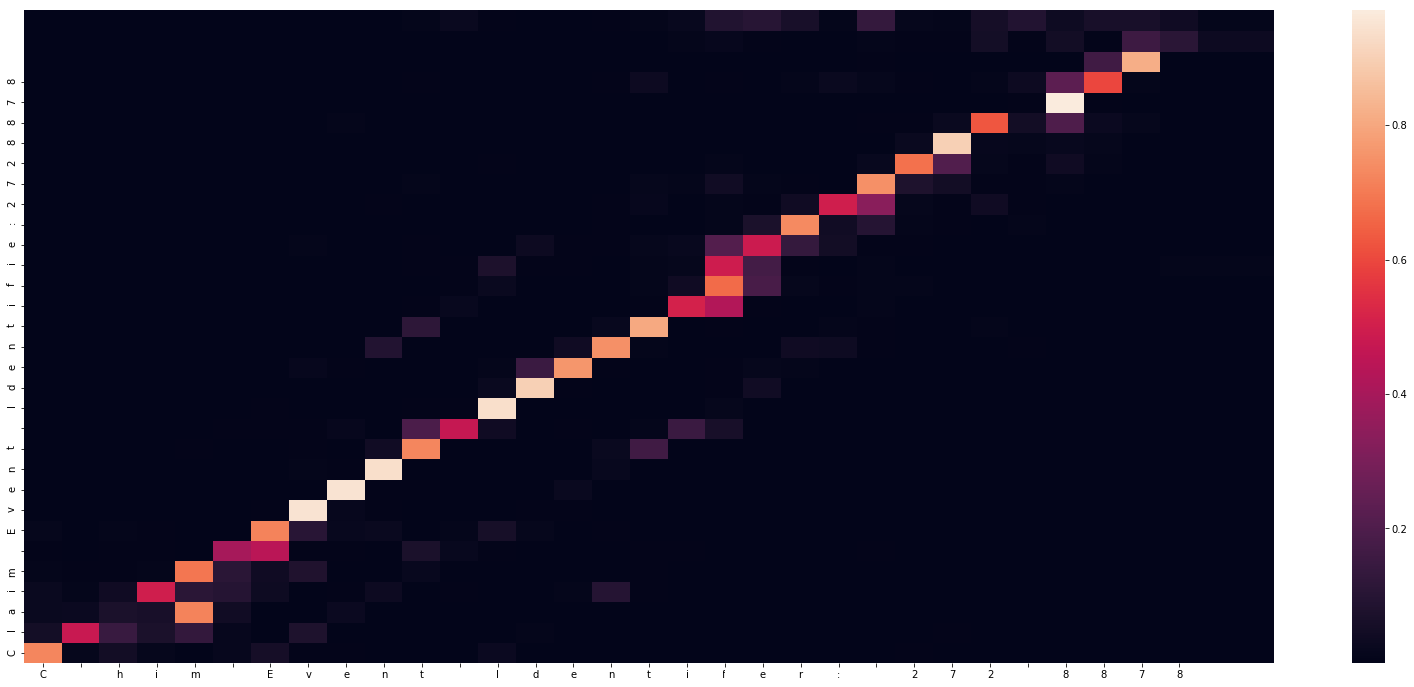

-
Input sentence: C him Event Identiﬁer: 272 8878
GT sentence: Claim Event Identifier: 2728878

Decoded sentence: Claim Event Identifie:2728878


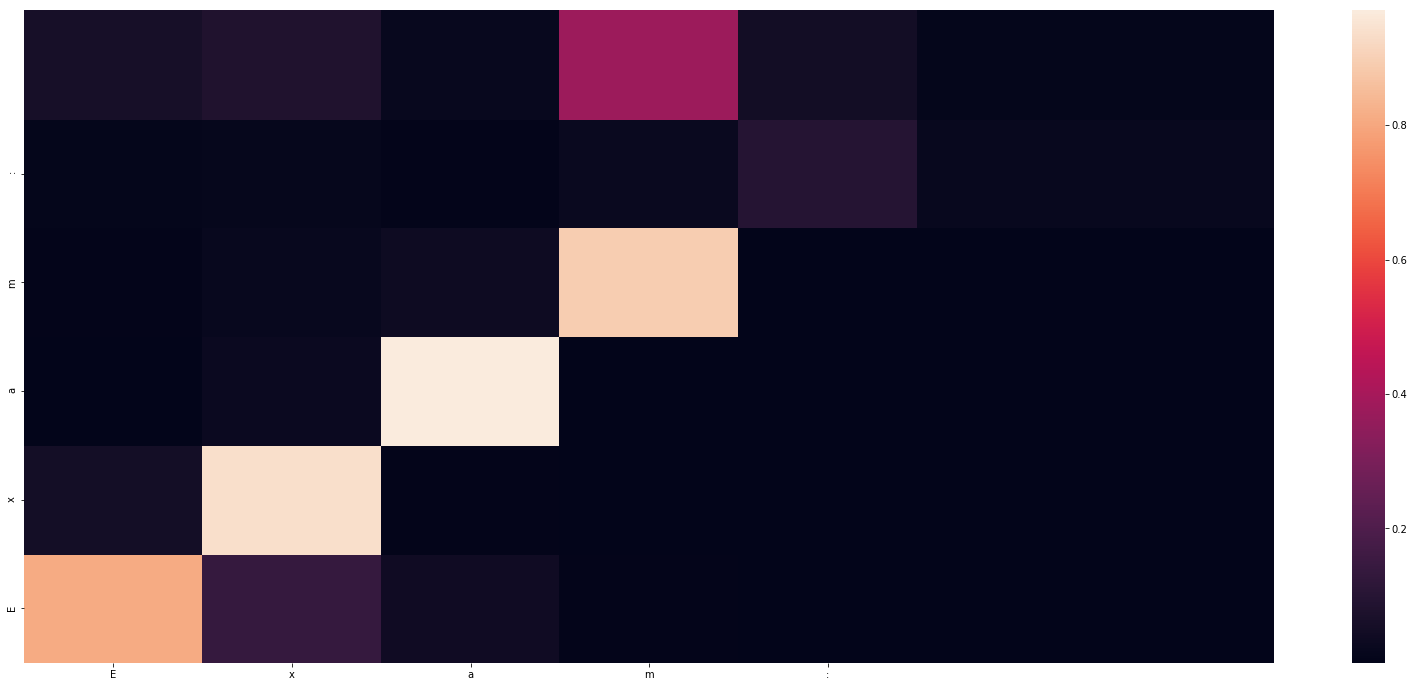

-
Input sentence: Exam:
GT sentence: Exam:

Decoded sentence: Exam:


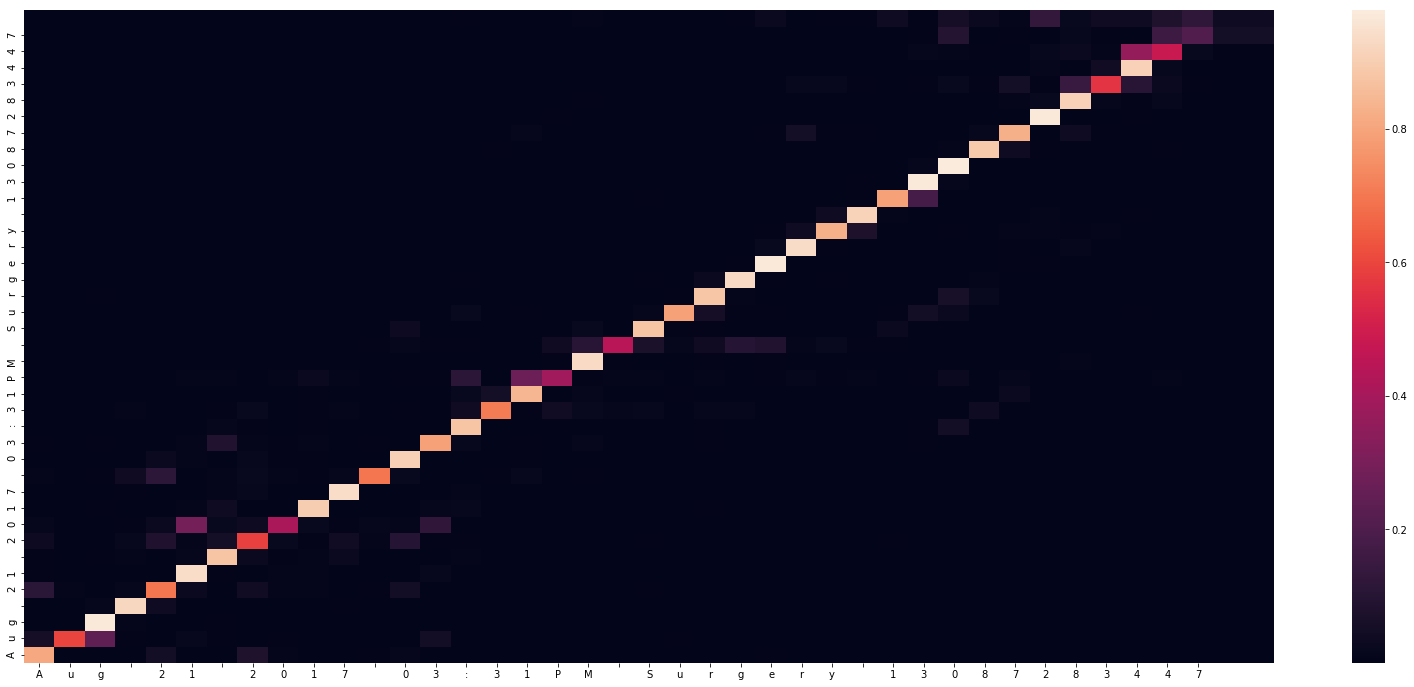

-
Input sentence: Aug 21 2017 03:31PM Surgery 13087283447
GT sentence: Aug 21 2017 03:31PM Surgery 13087283447

Decoded sentence: Aug 21 2017 03:31PM Surgery 13087283447


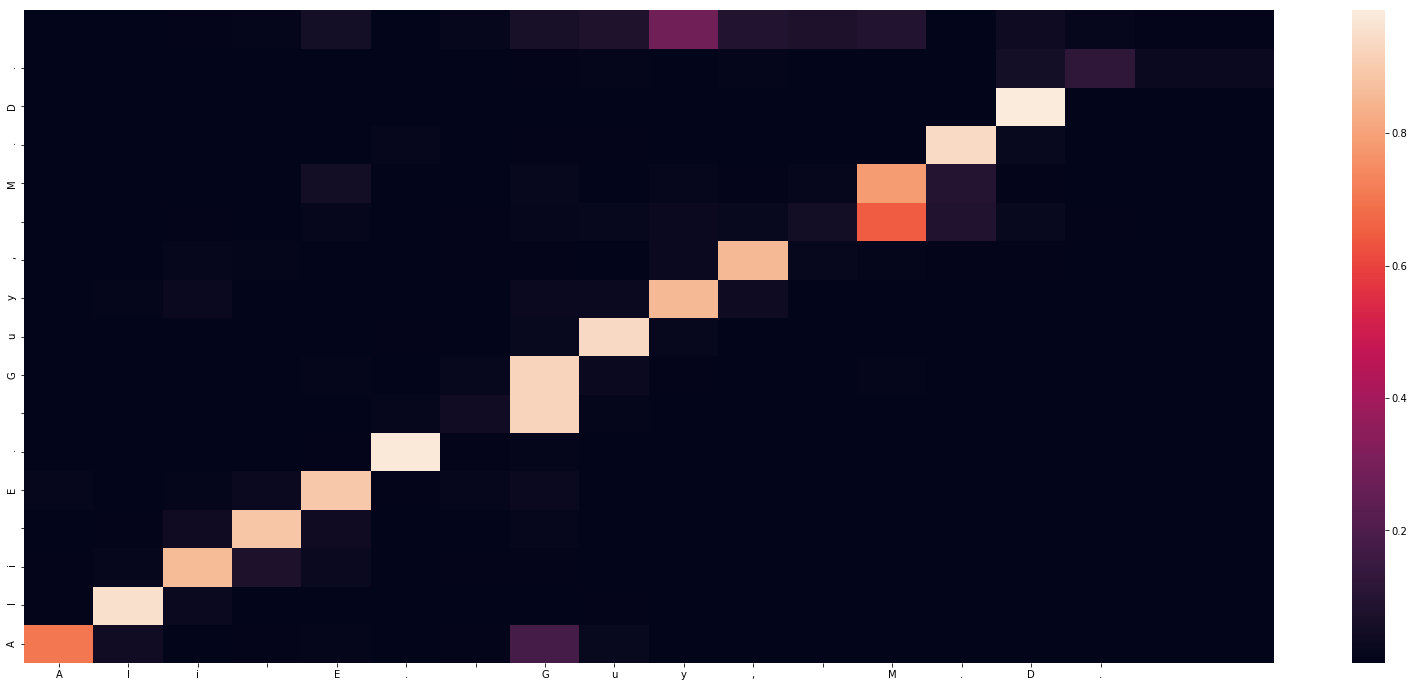

-
Input sentence: Ali E. Guy, M.D.
GT sentence: Ali E. Guy,M.D.

Decoded sentence: Ali E. Guy, M.D.


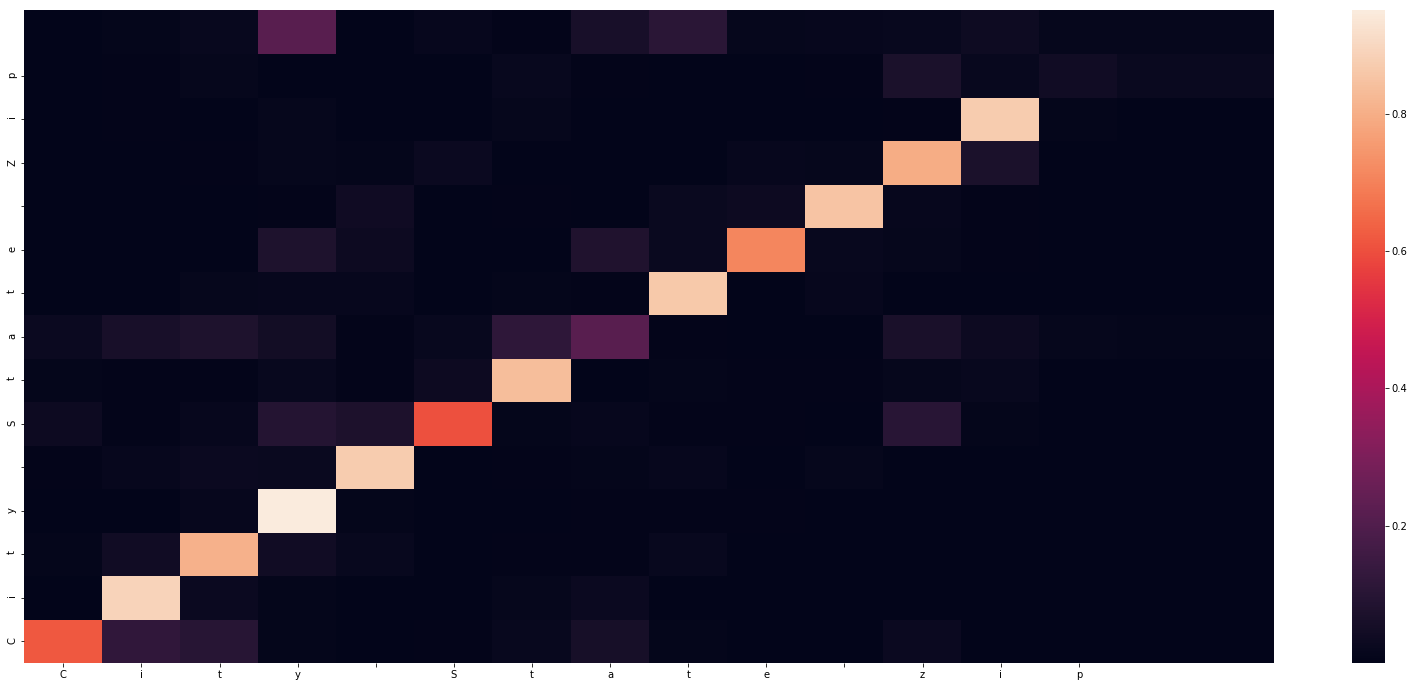

-
Input sentence: City State zip
GT sentence: City State Zip

Decoded sentence: City State Zip


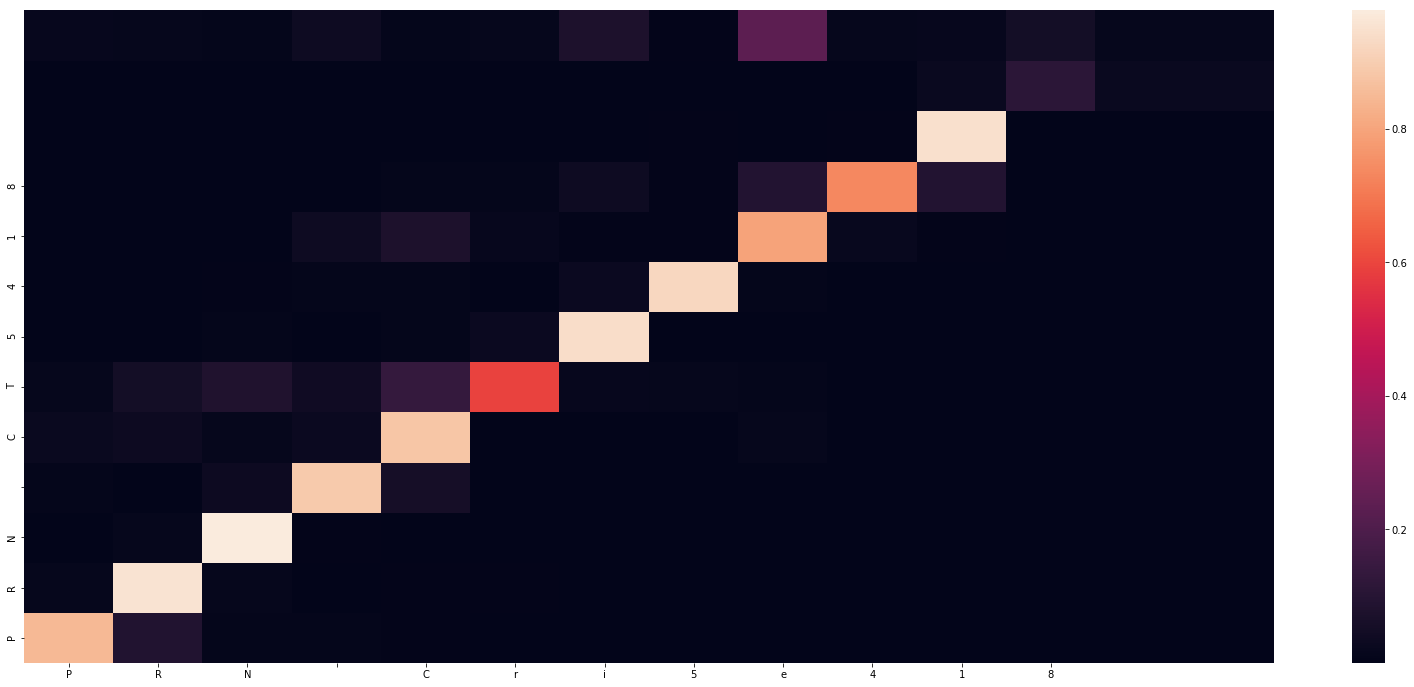

-
Input sentence: PRN Cri5e418
GT sentence: PRN CT156418

Decoded sentence: PRN CT5418


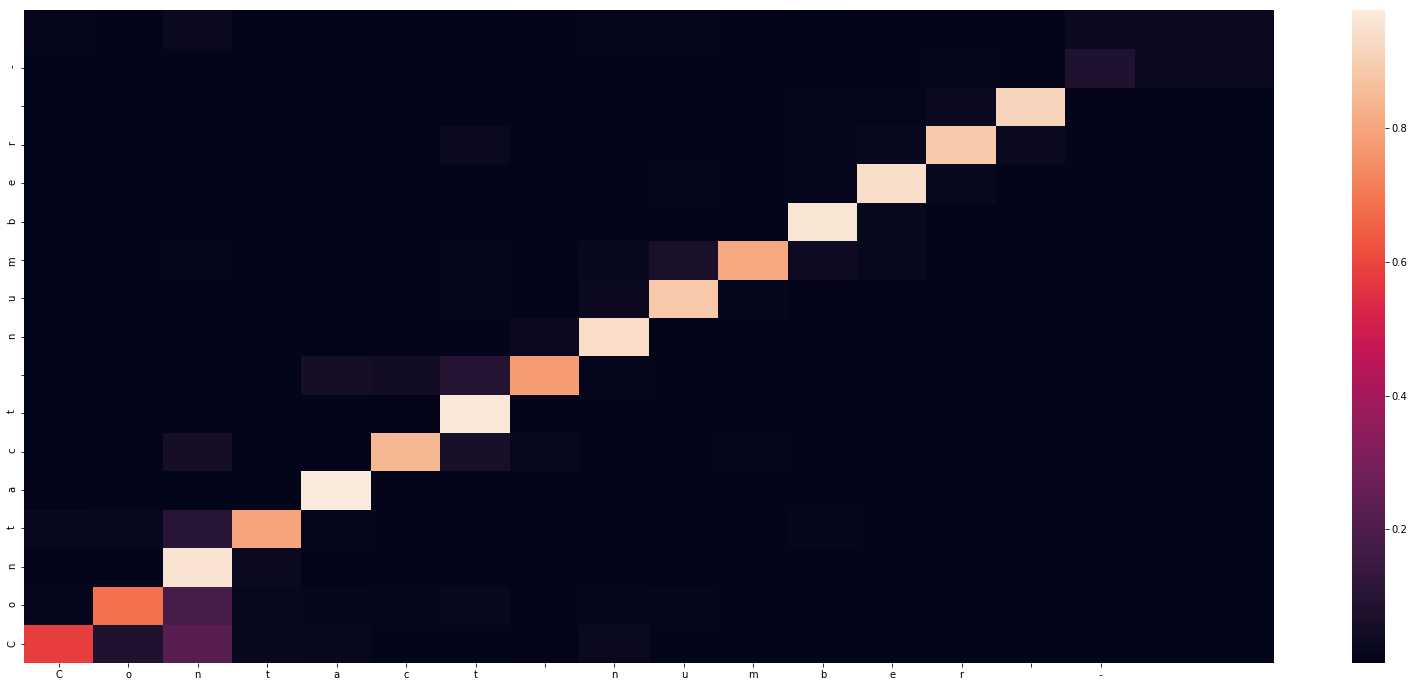

-
Input sentence: Contact number -
GT sentence: Contact number -

Decoded sentence: Contact number -


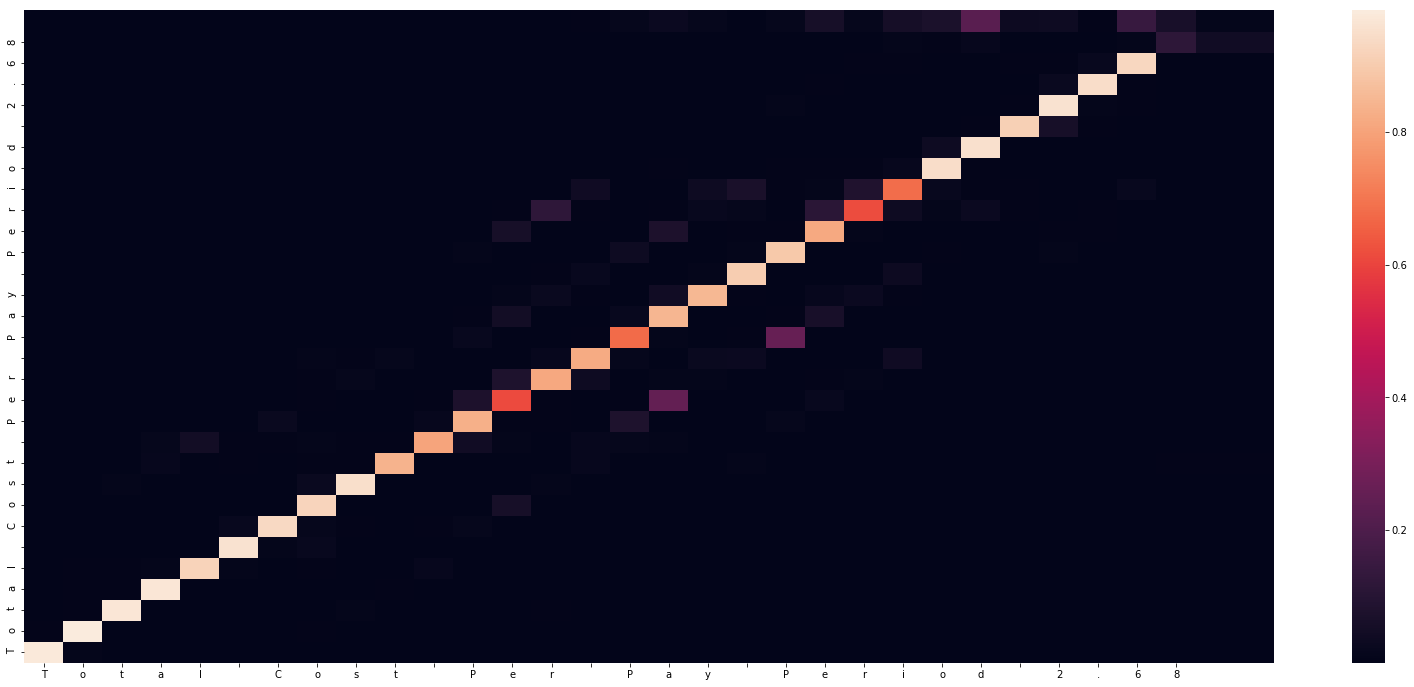

-
Input sentence: Total Cost Per Pay Period 2.68
GT sentence: Total Cost Per Pay Period 2.68

Decoded sentence: Total Cost Per Pay Period 2.68


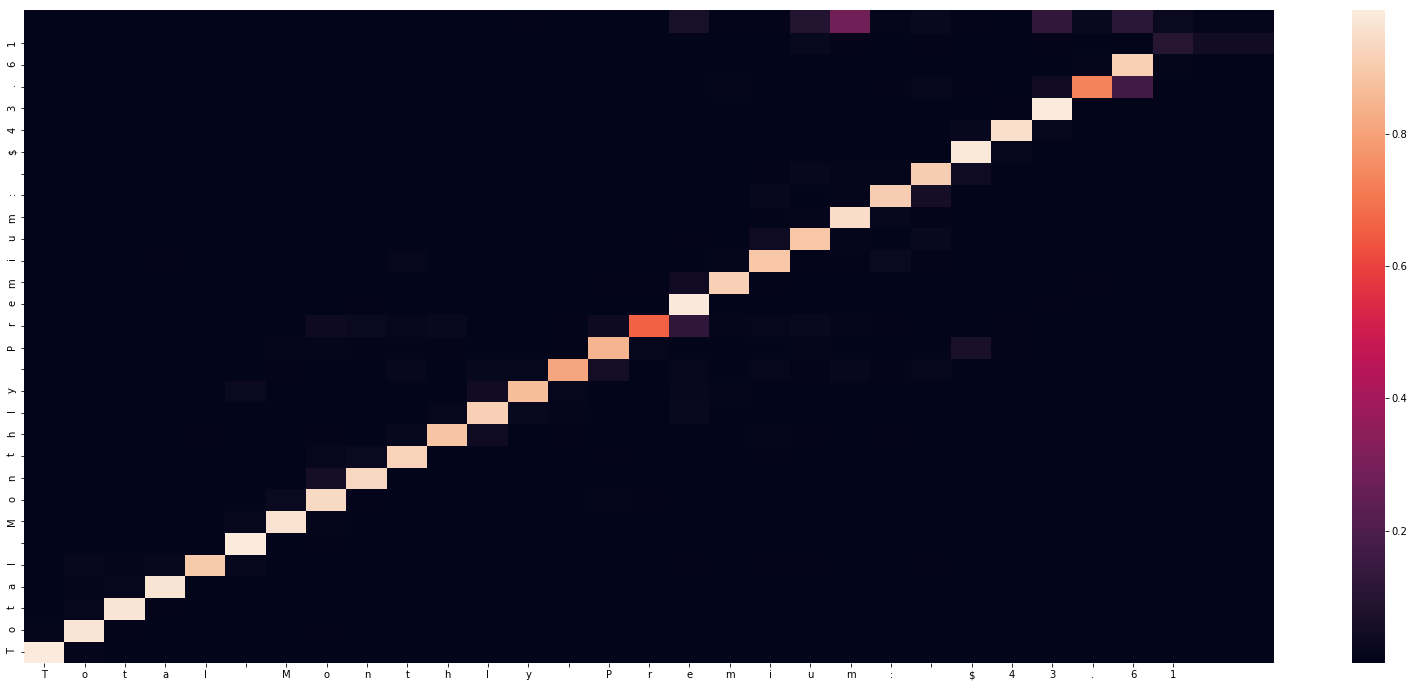

-
Input sentence: Total Monthly Premium: $43.61
GT sentence: Total Monthly Premium: $43.61

Decoded sentence: Total Monthly Premium: $43.61


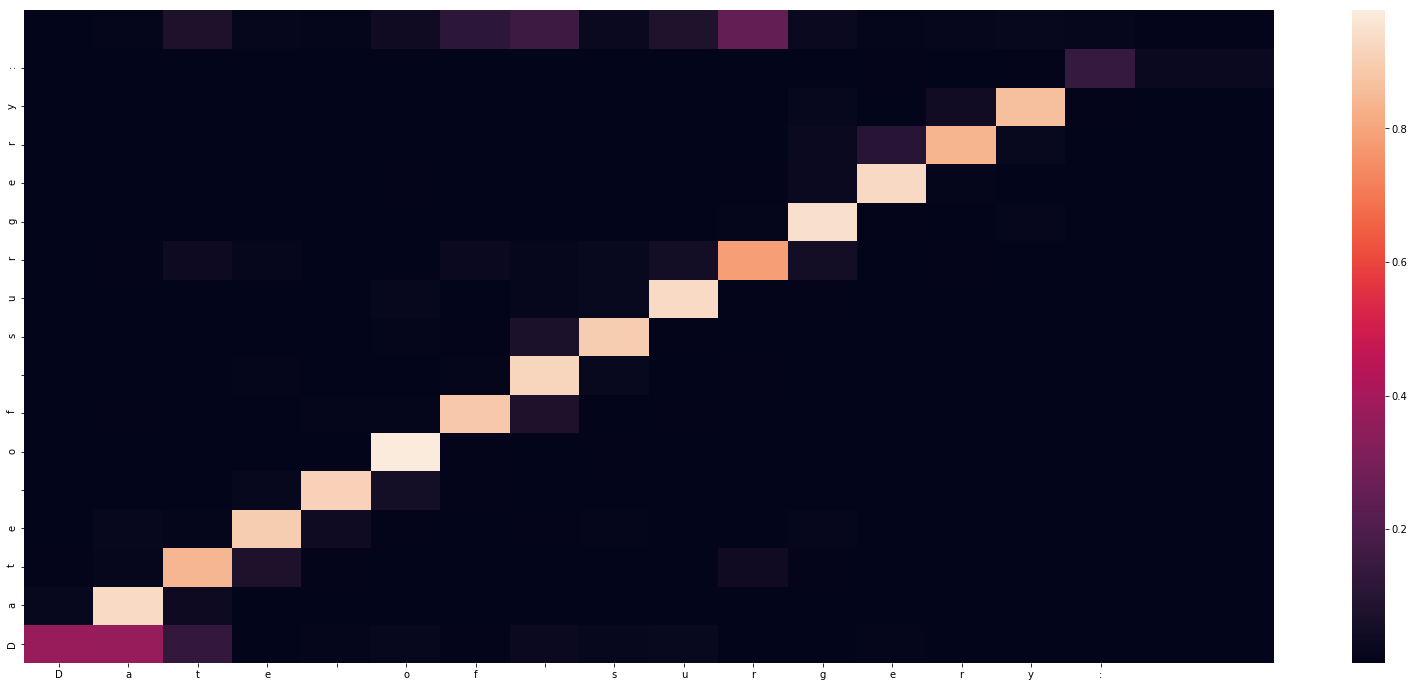

-
Input sentence: Date of surgery:
GT sentence: Date of surgery:

Decoded sentence: Date of surgery:


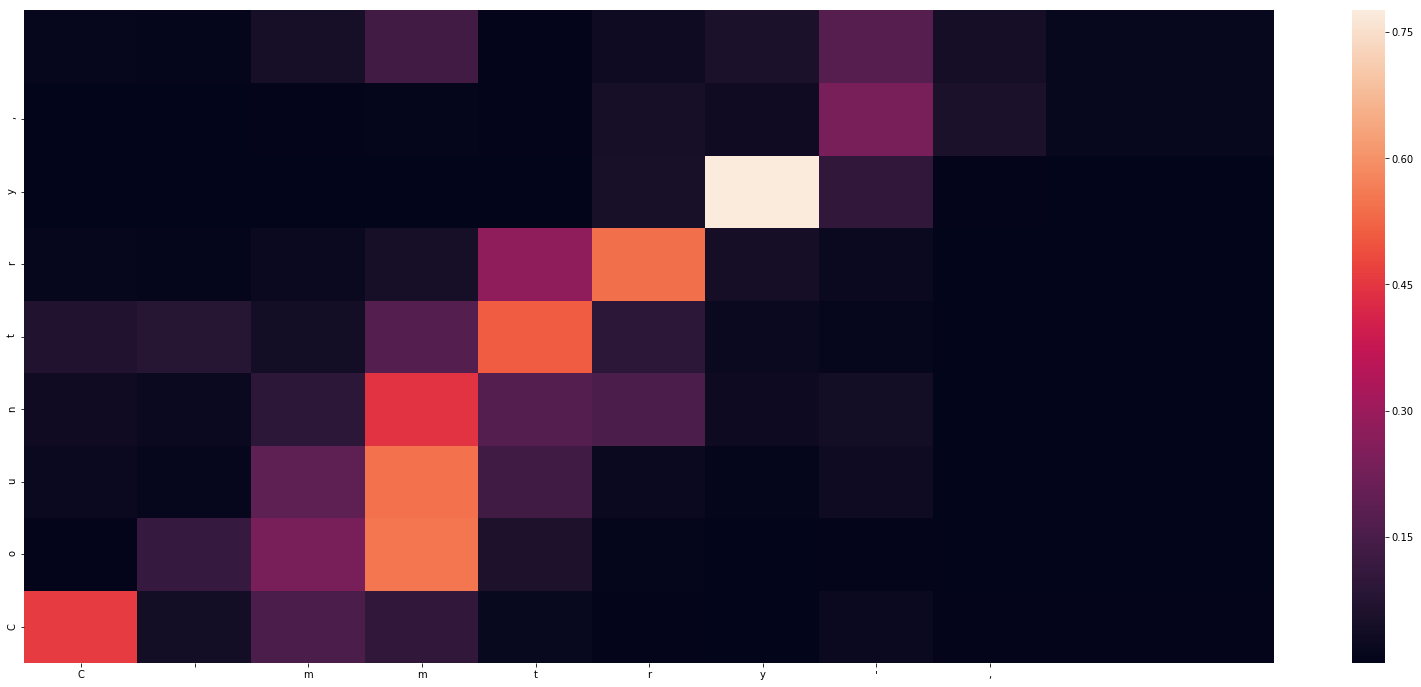

-
Input sentence: C mmtry',
GT sentence: Country:

Decoded sentence: Country,


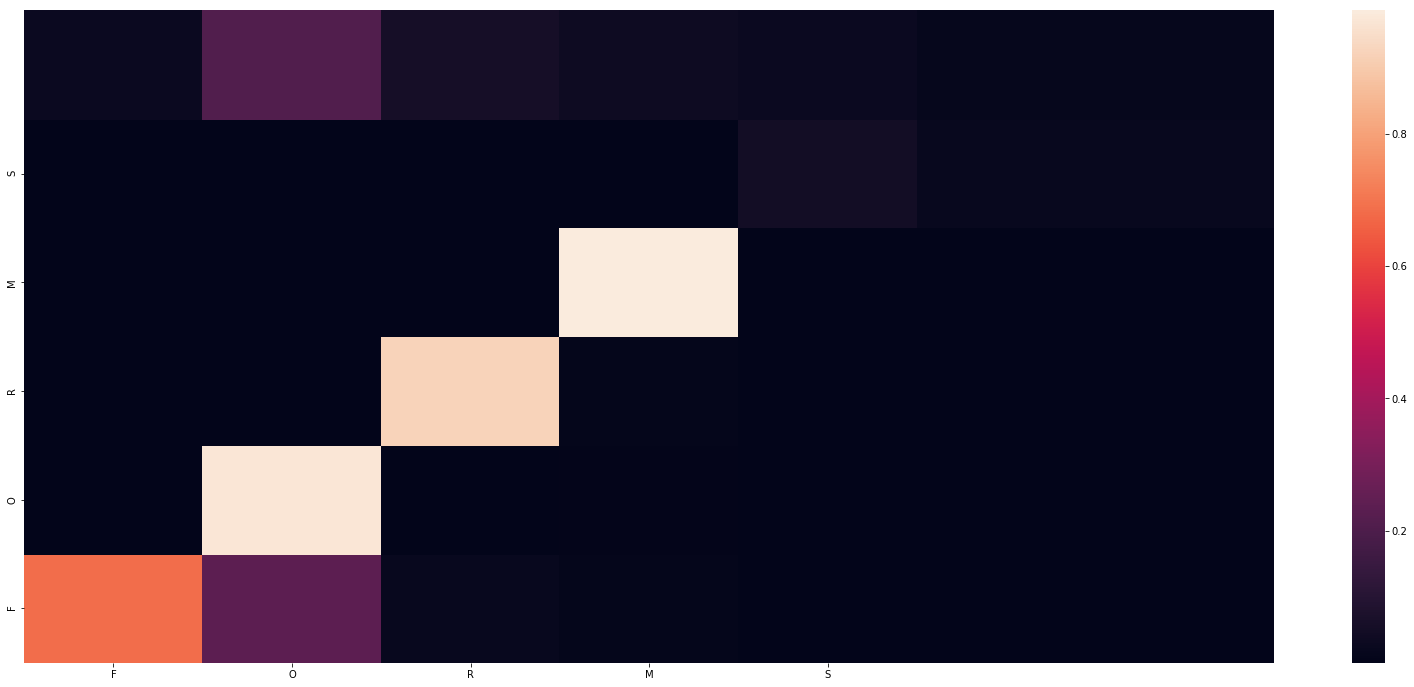

-
Input sentence: FORMS
GT sentence: FORMS

Decoded sentence: FORMS


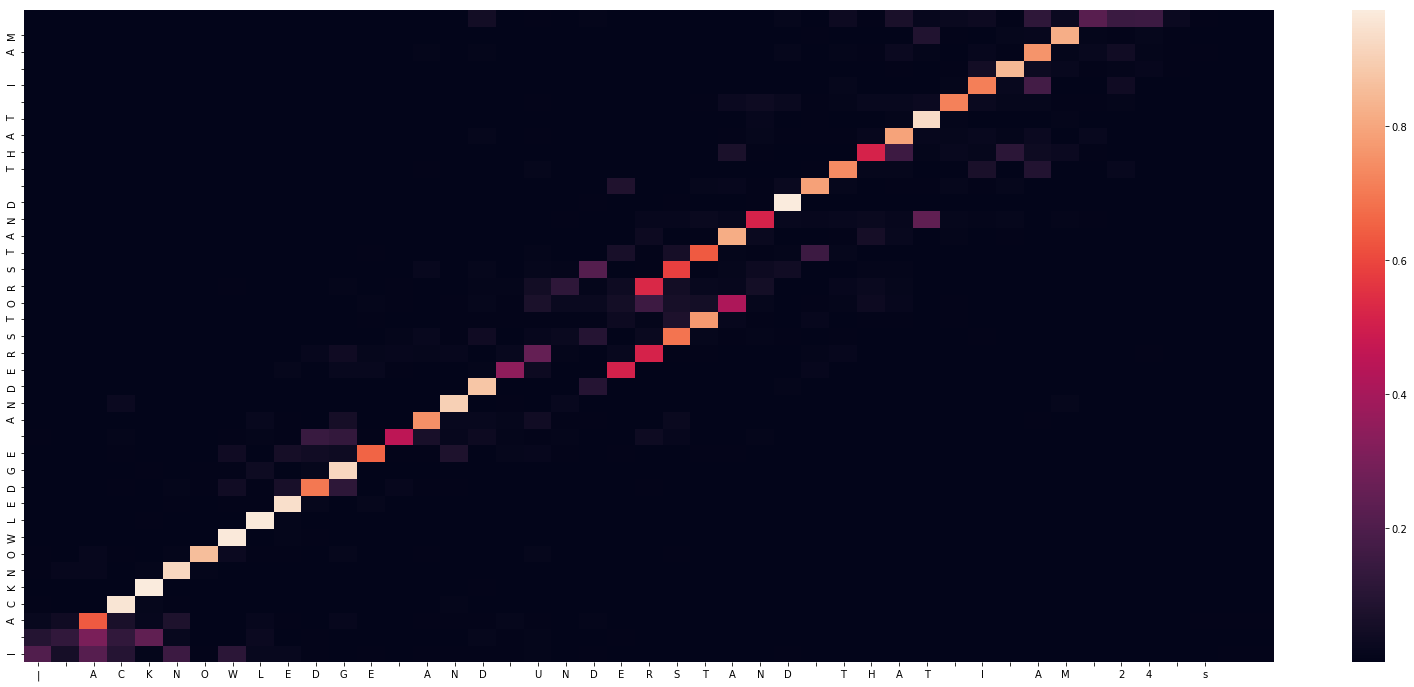

-
Input sentence: | ACKNOWLEDGE AND UNDERSTAND THAT I AM 24 s
GT sentence: I ACKNOWLEDGE AND UNDERSTAND THAT I AM

Decoded sentence: I ACKNOWLEDGE ANDERSTORSTAND THAT I AM


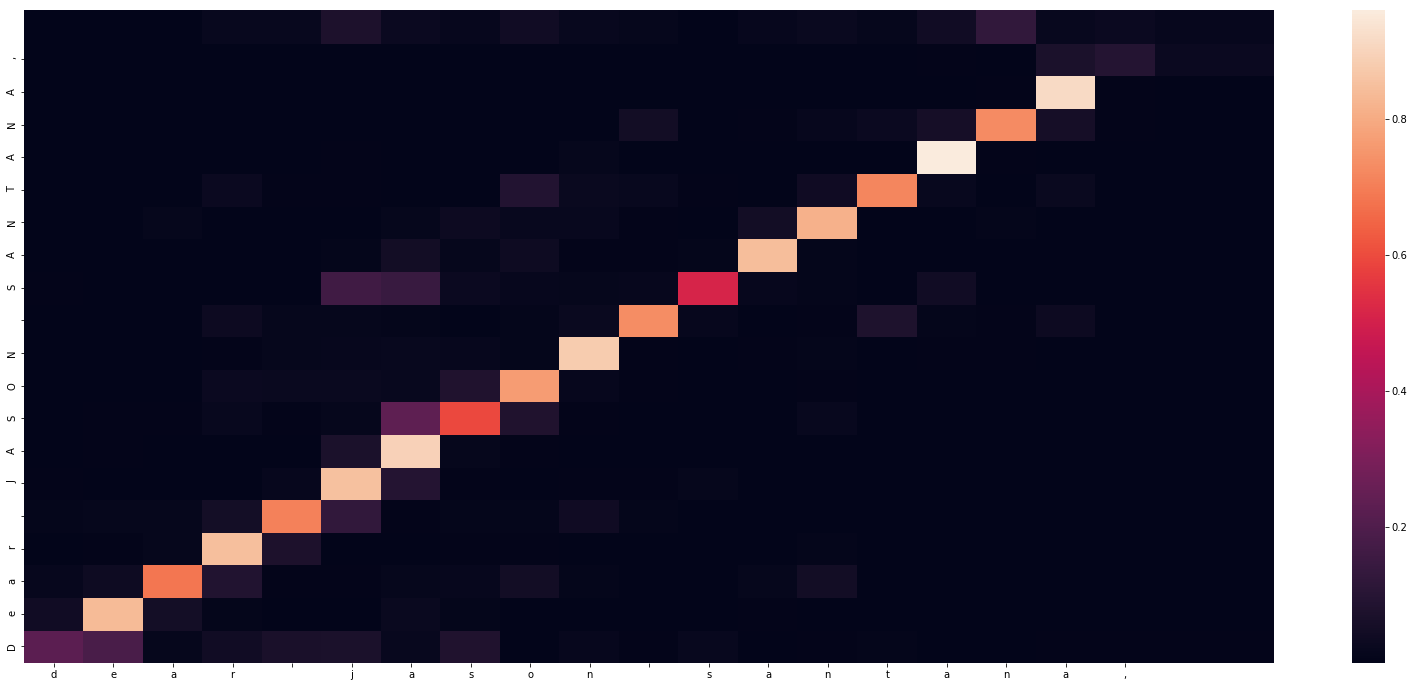

-
Input sentence: dear jason santana,
GT sentence: Dear JASON SANTANA,

Decoded sentence: Dear JASON SANTANA,


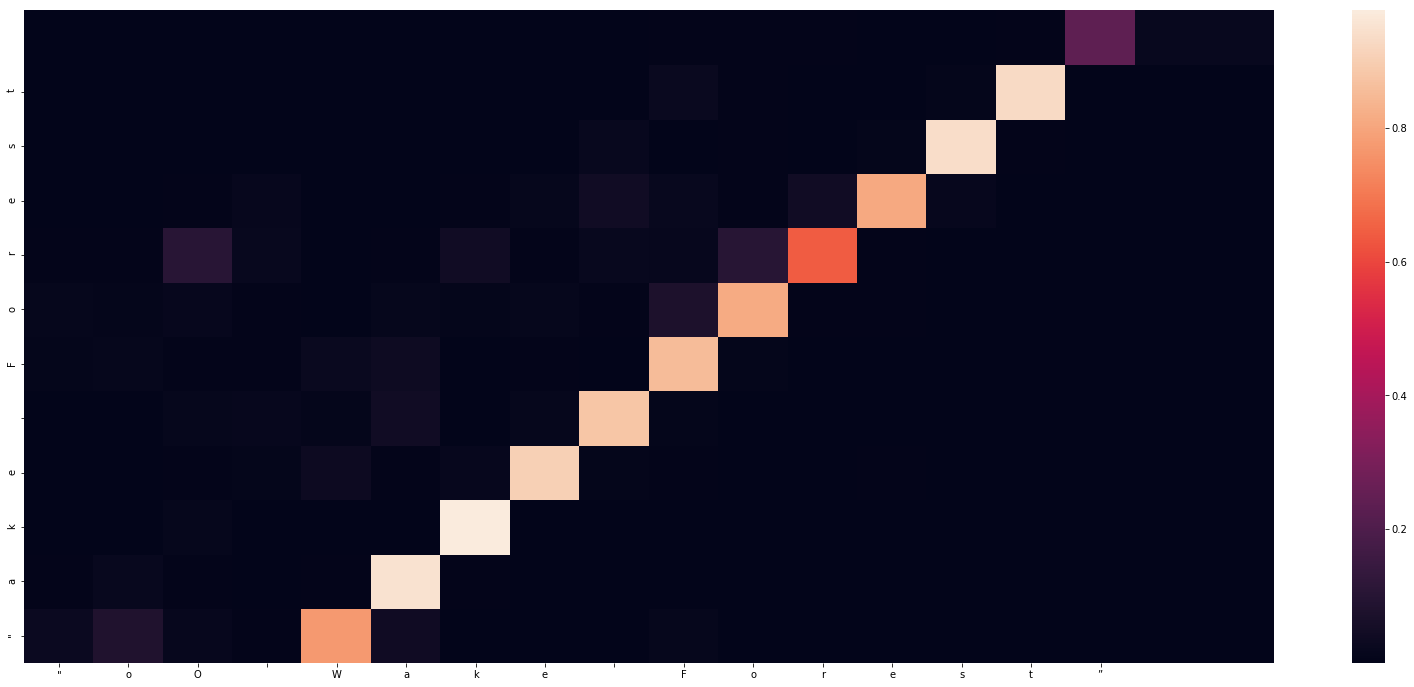

-
Input sentence: "oO Wake Forest”
GT sentence: Wake Forest

Decoded sentence: "ake Forest


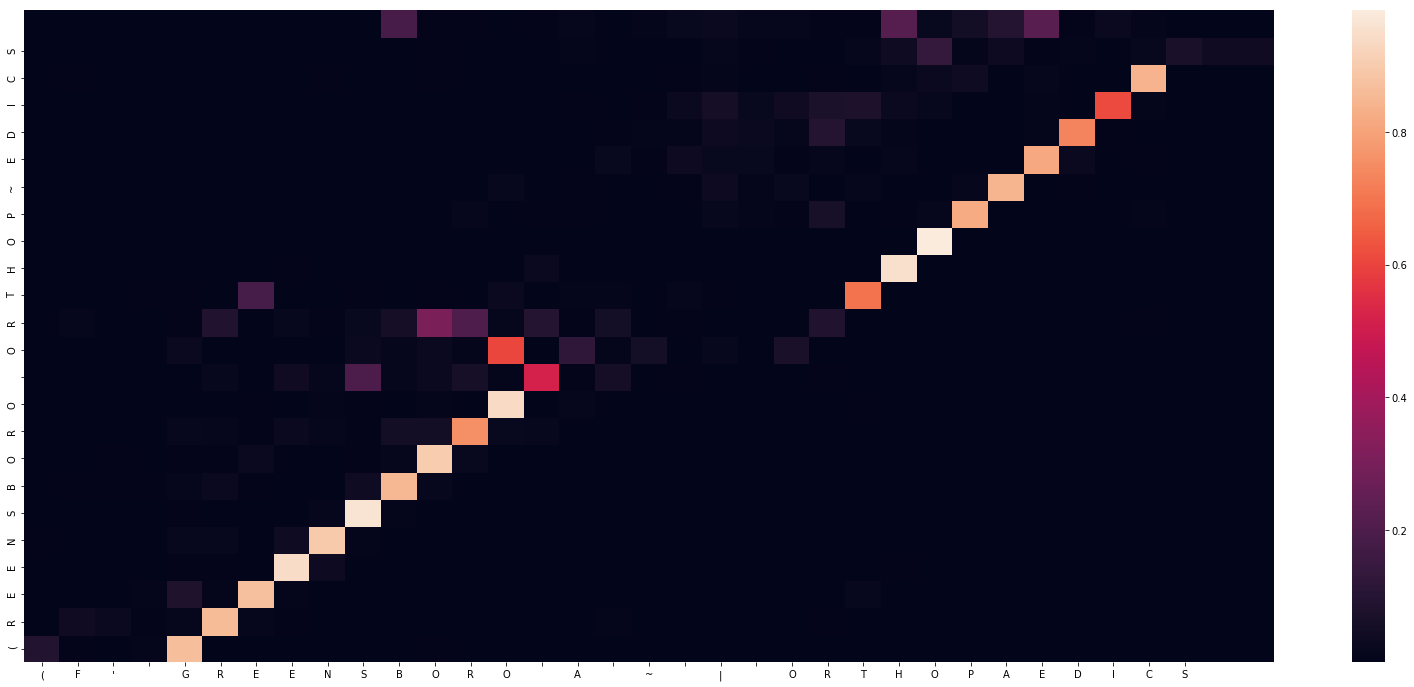

-
Input sentence: (F' GREENSBORO A ~ | ORTHOPAEDICS
GT sentence: GREENSBORO ORTHOPAEDICS

Decoded sentence: (REENSBORO ORTHOP~EDICS


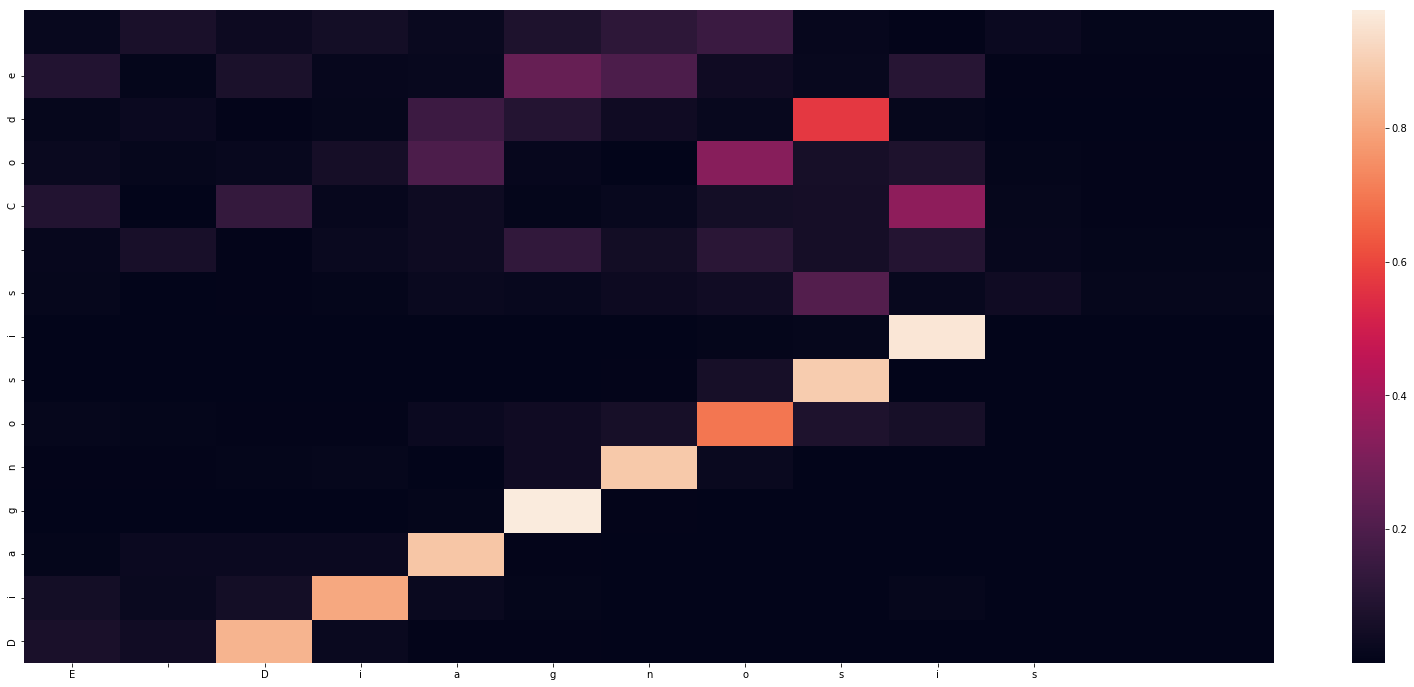

-
Input sentence: E Diagnosis
GT sentence: Diagnosis Code (ICD)

Decoded sentence: Diagnosis Code


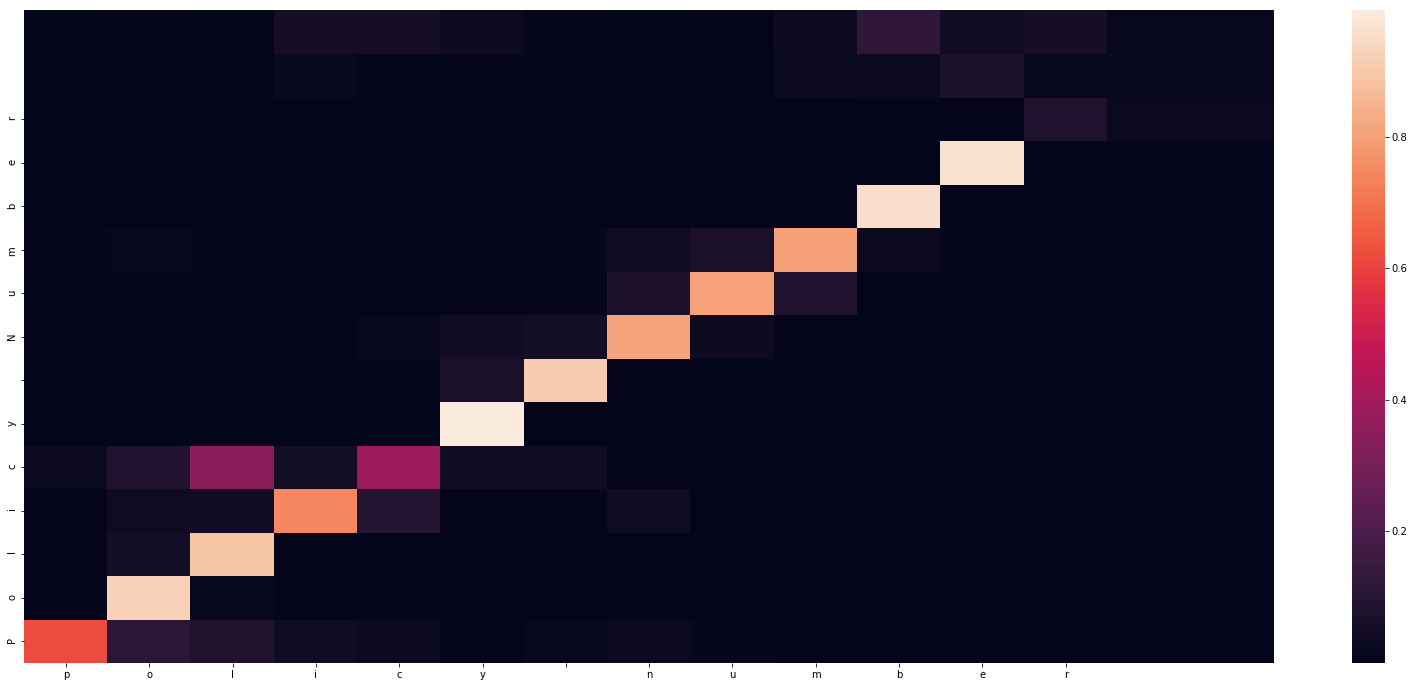

-
Input sentence: policy number
GT sentence: Policy Number:

Decoded sentence: Policy Number


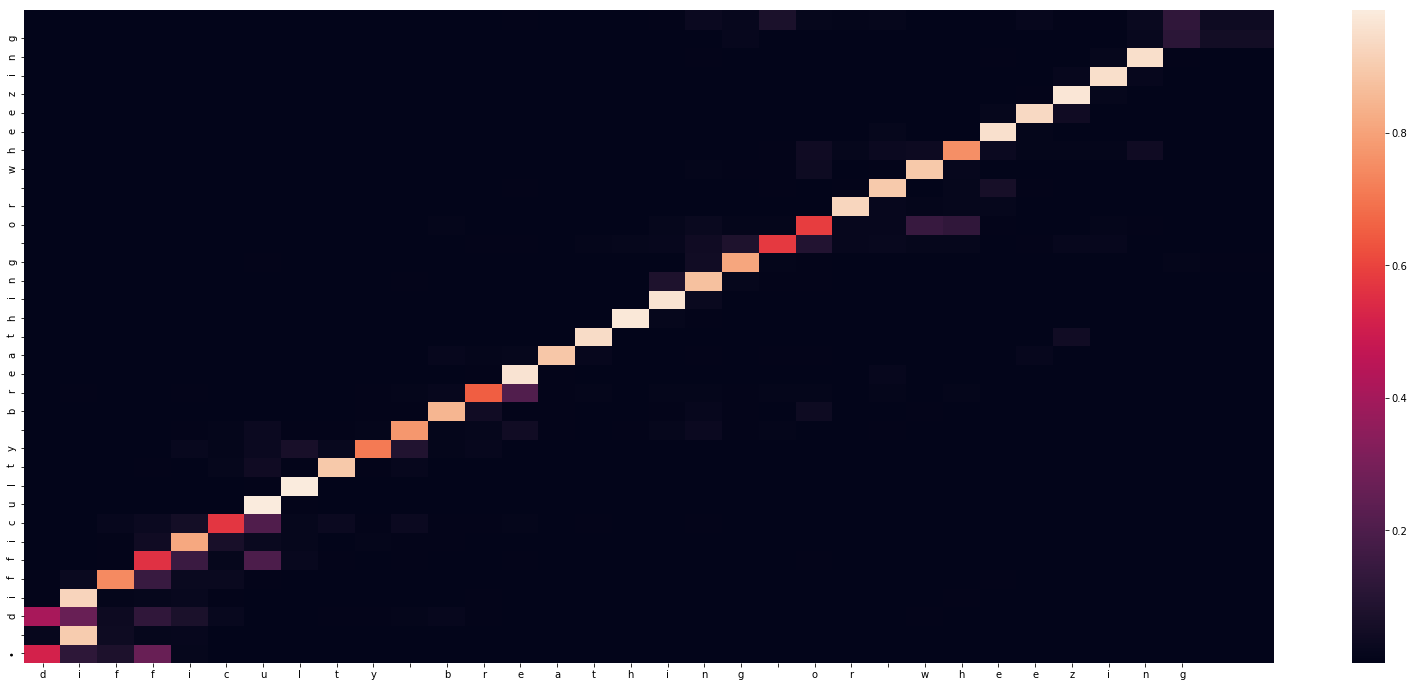

-
Input sentence: difficulty breathing or wheezing
GT sentence: • difficulty breathing or wheezing

Decoded sentence: • difficulty breathing or wheezing


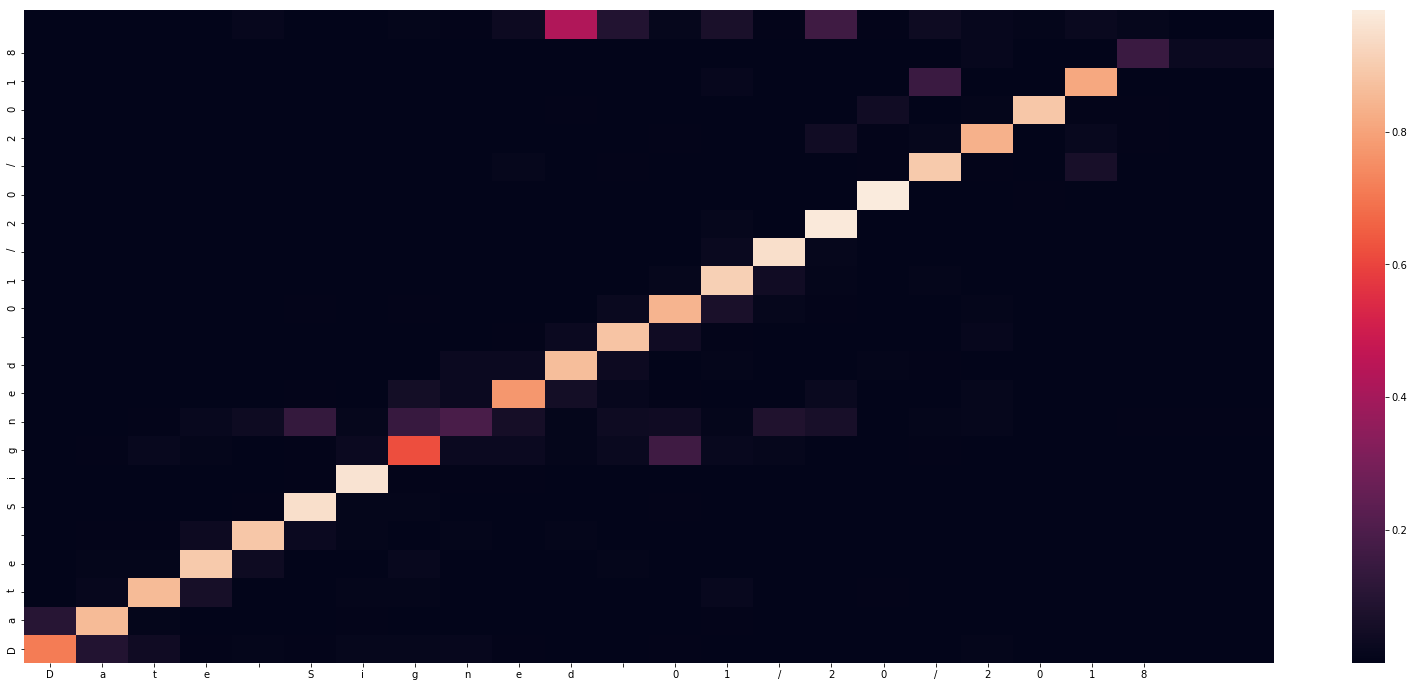

-
Input sentence: Date Signed 01/20/2018
GT sentence: Date Signed 01/20/2018

Decoded sentence: Date Signed 01/20/2018


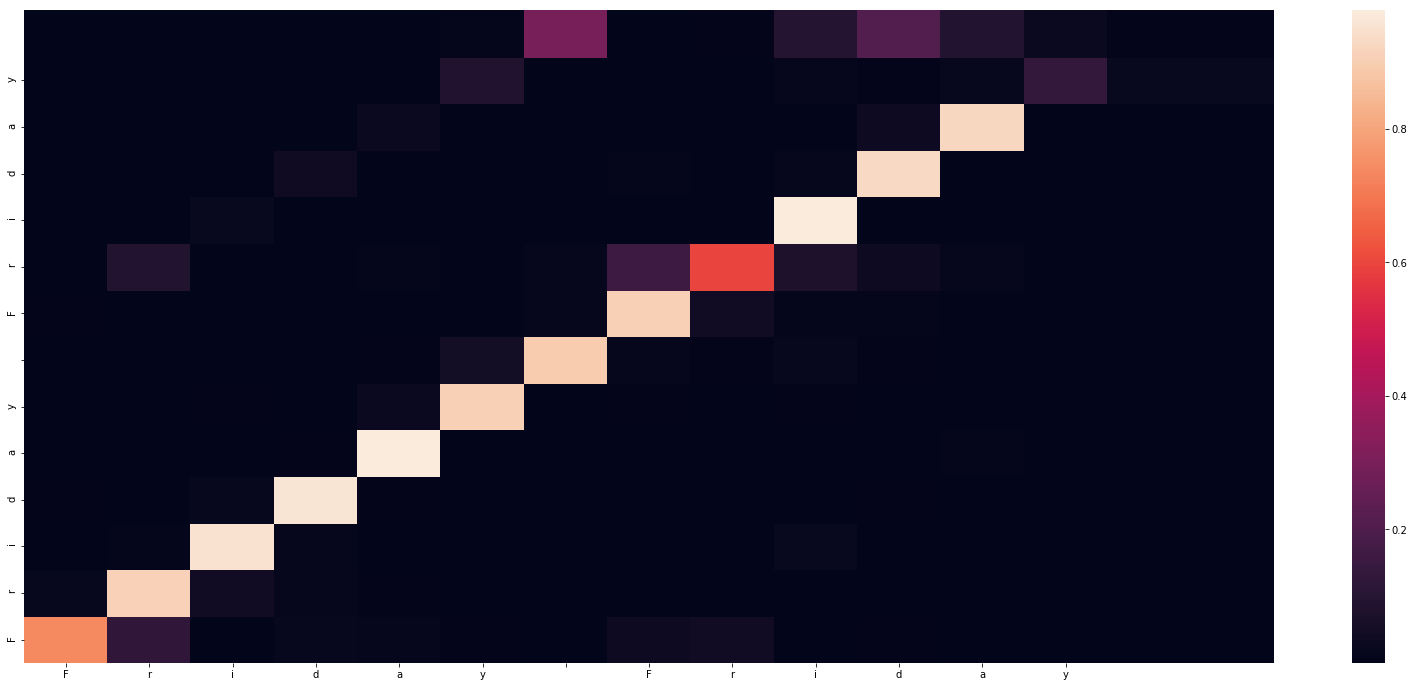

-
Input sentence: Friday Friday
GT sentence: Friday Friday

Decoded sentence: Friday Friday


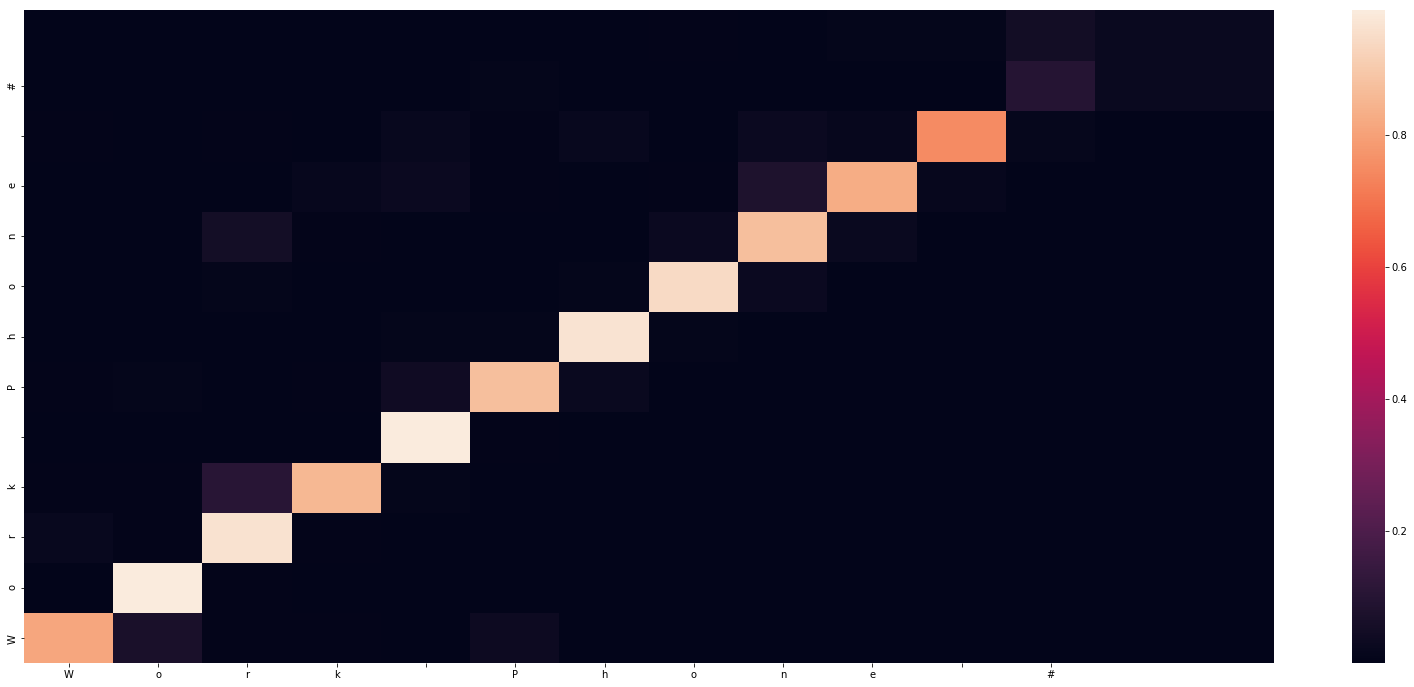

-
Input sentence: Work Phone #
GT sentence: Work Phone #

Decoded sentence: Work Phone #


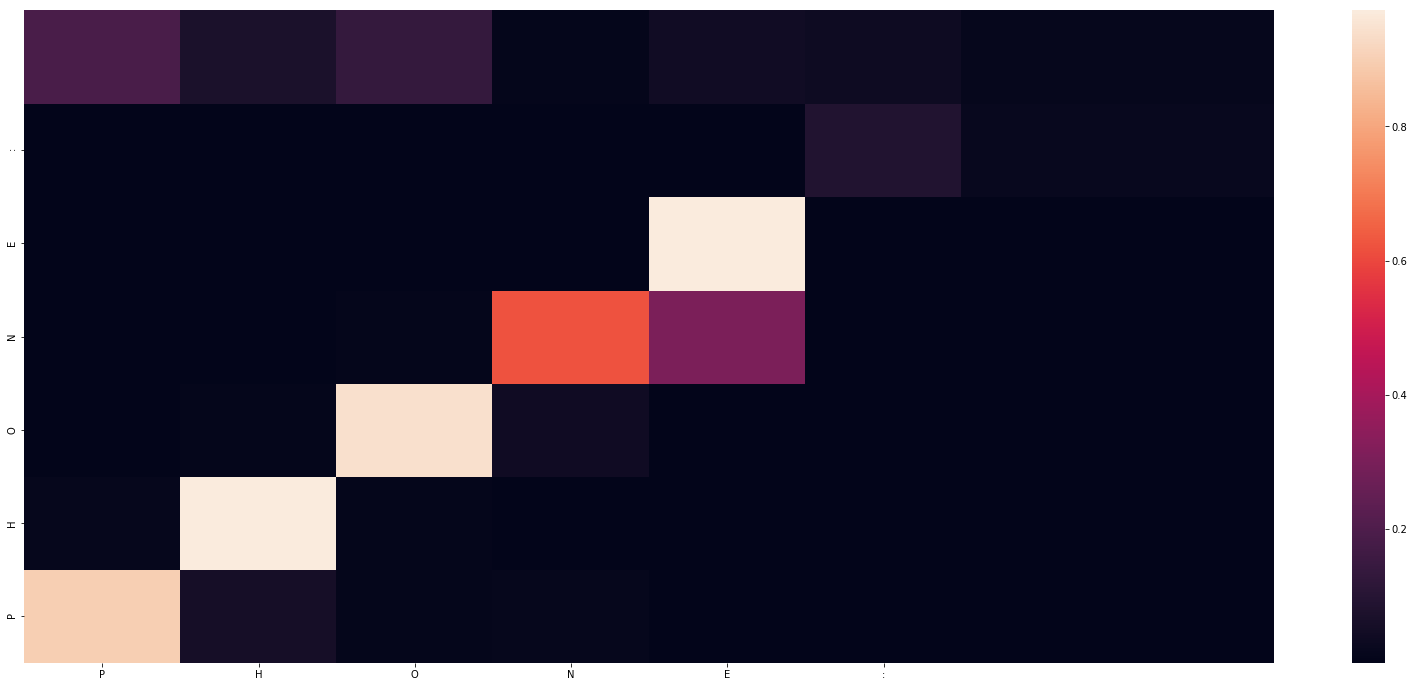

-
Input sentence: PHONE:
GT sentence: PHONE:

Decoded sentence: PHONE:


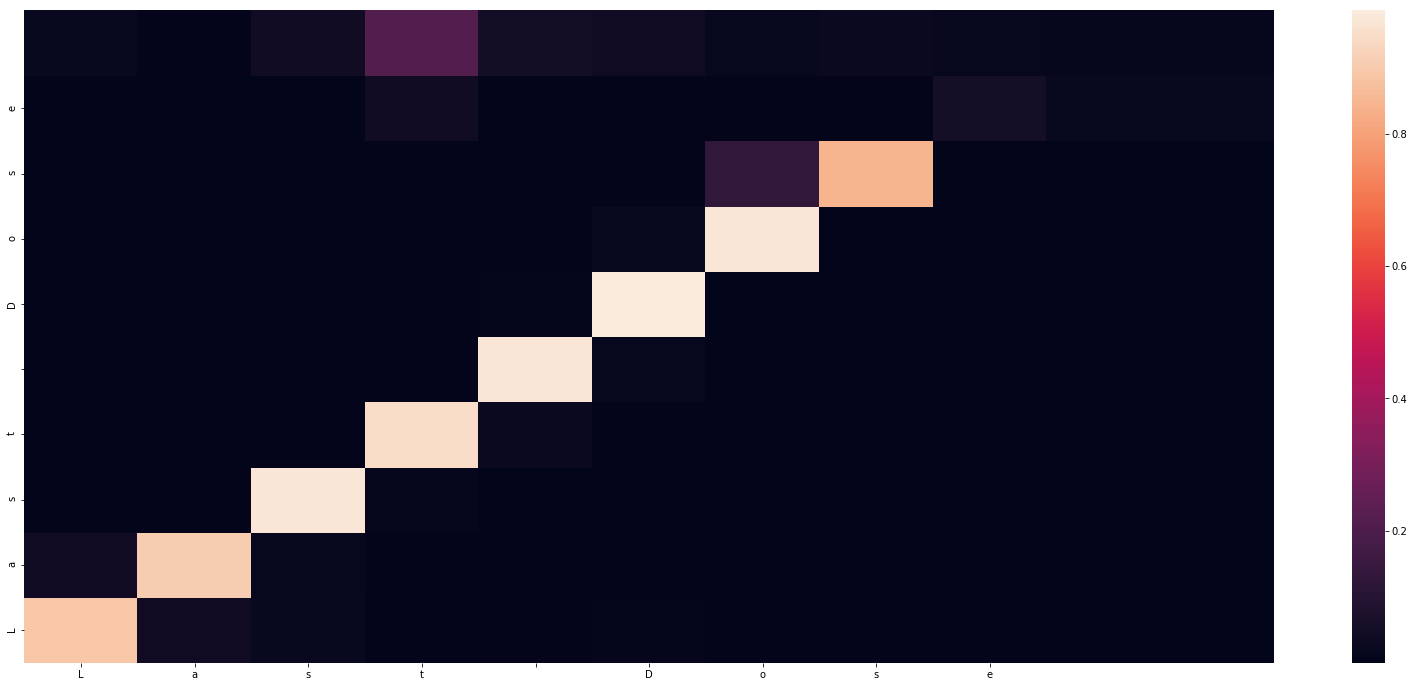

-
Input sentence: Last Dose
GT sentence: Last Dose

Decoded sentence: Last Dose


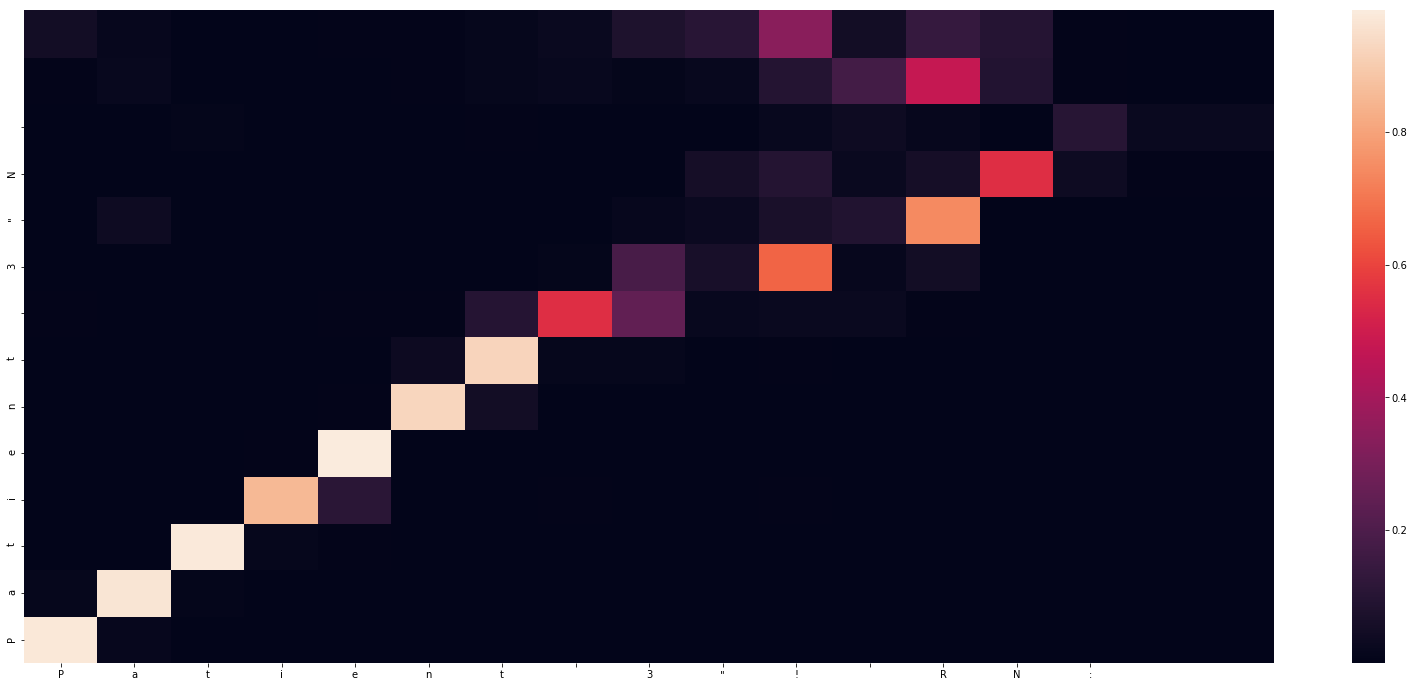

-
Input sentence: Patient 3"! RN:
GT sentence: Patient MRN: 

Decoded sentence: Patient 3"N 


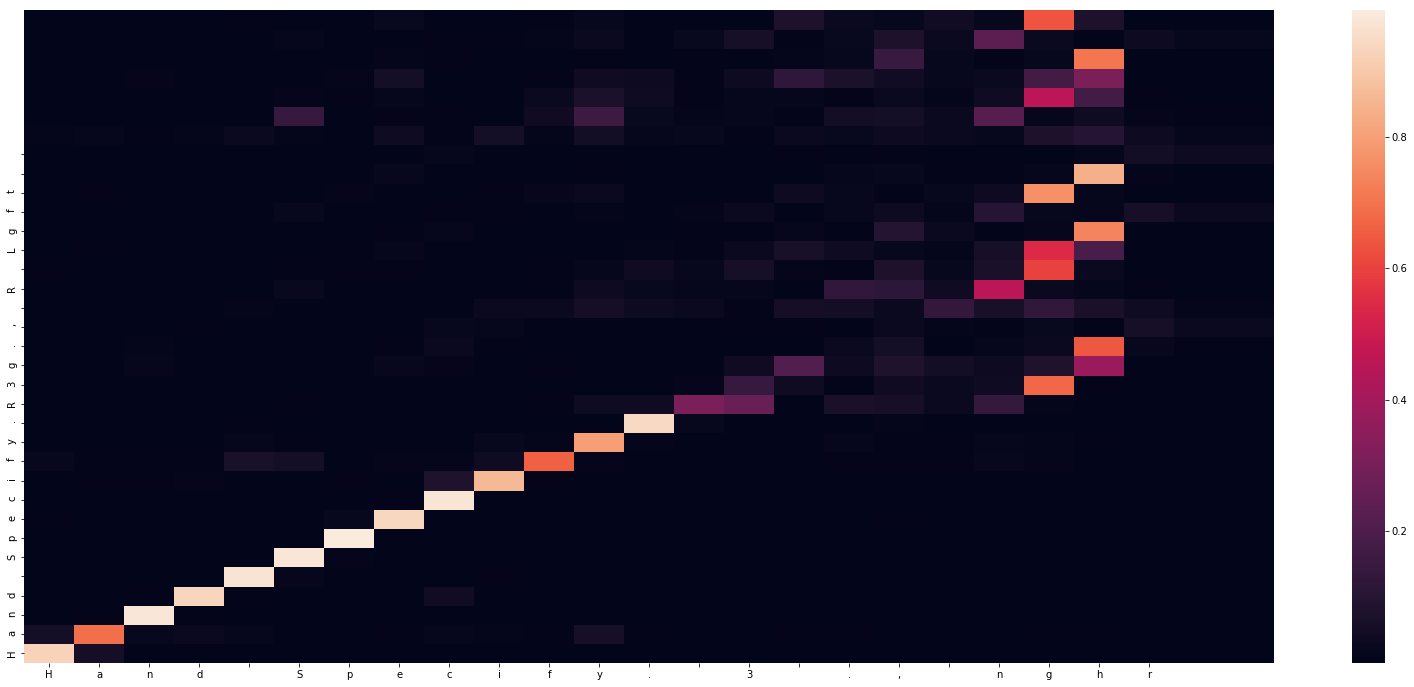

-
Input sentence: Hand Specify. 3 ., nghr
GT sentence: Hand Specify Right (R) Left (L) Bilateral (B)

Decoded sentence: Hand Specify.R3g., R Lgft  


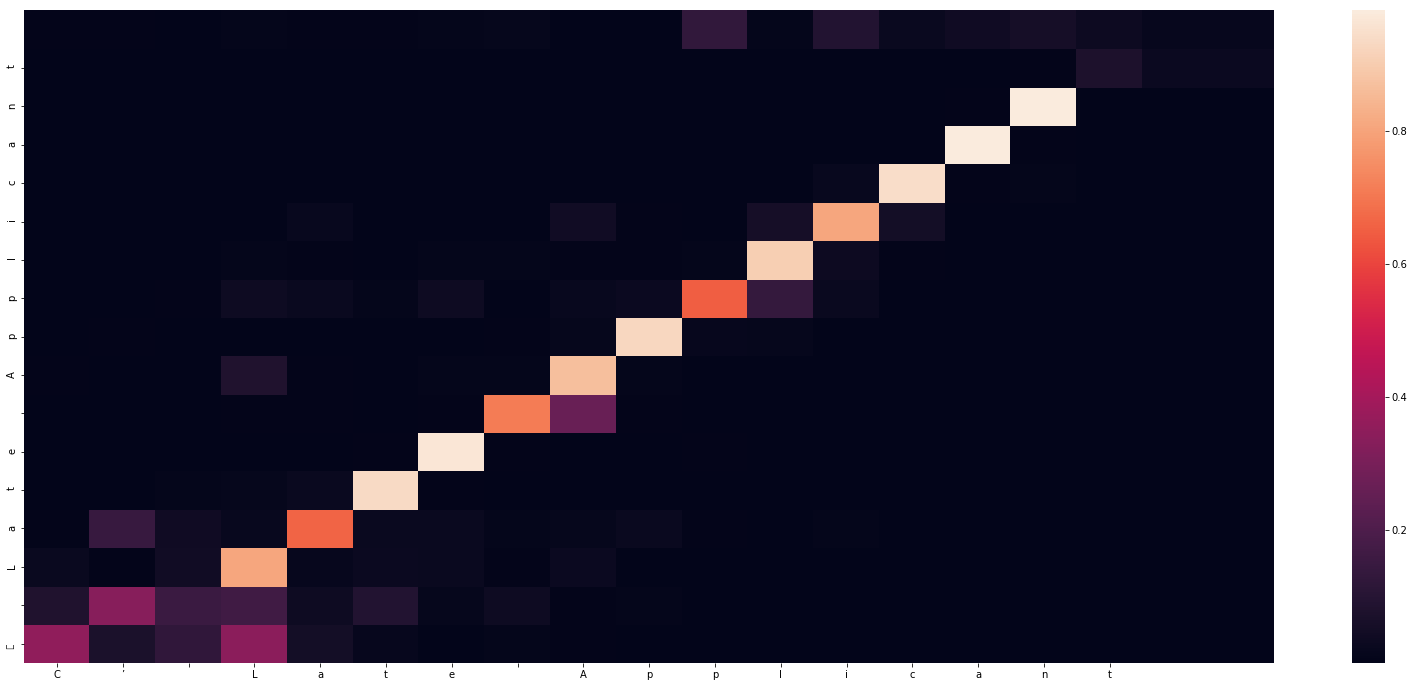

-
Input sentence: C’ Late Applicant
GT sentence: ☐ Late Applicant

Decoded sentence: ☐ Late Applicant


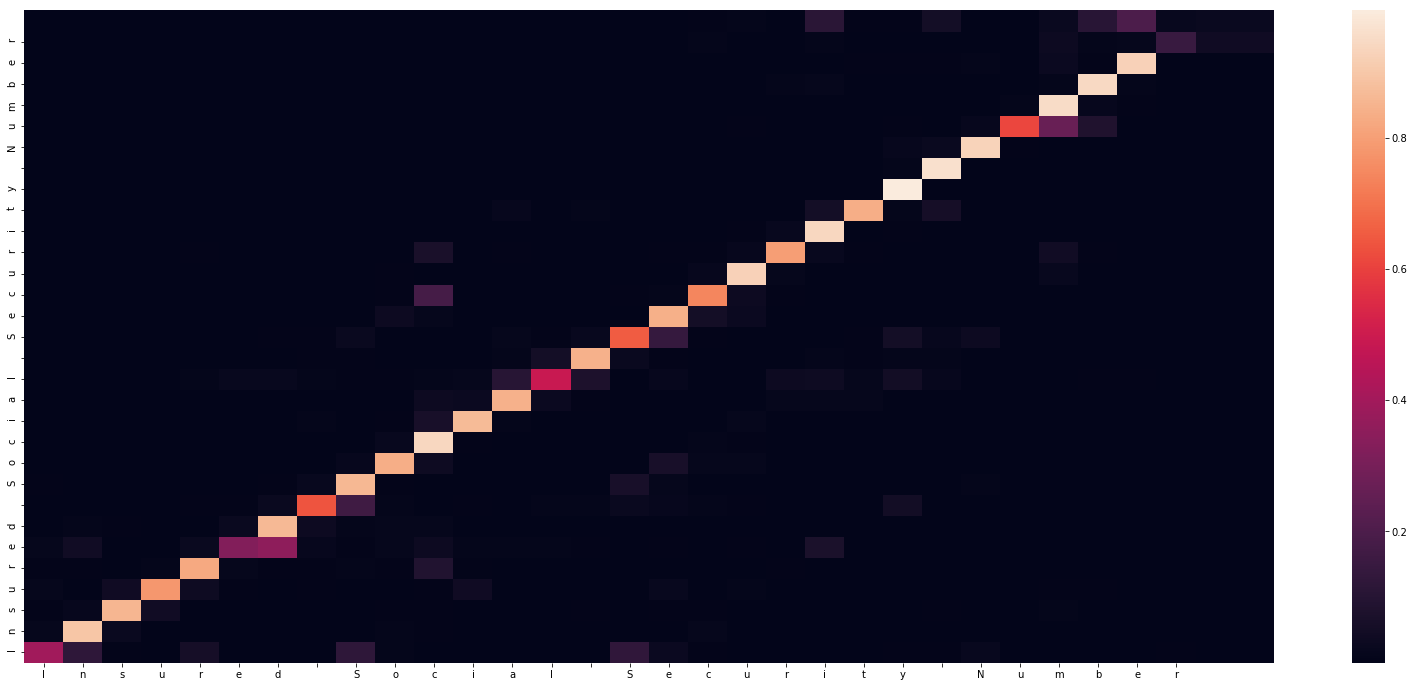

-
Input sentence: Insured Social Security Number
GT sentence: Insured Social Security Number

Decoded sentence: Insured Social Security Number


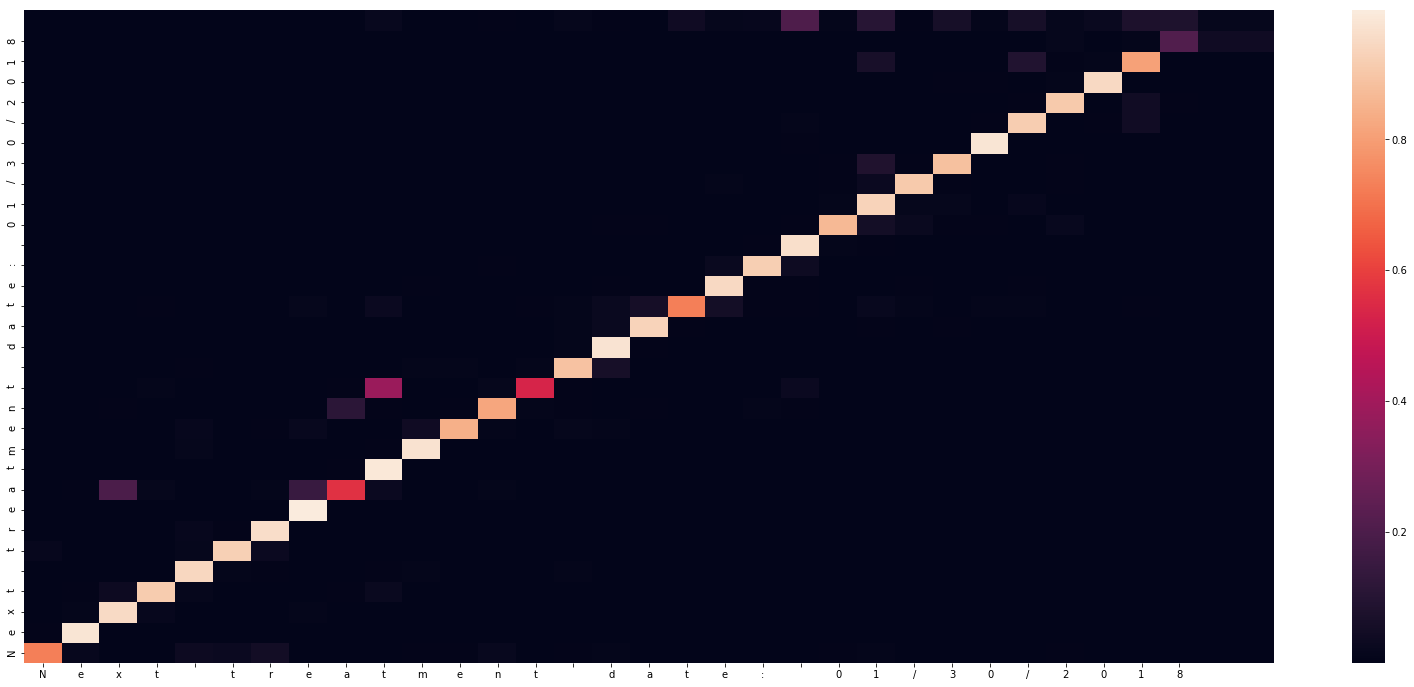

-
Input sentence: Next treatment date: 01/30/2018
GT sentence: Next treatment date: 01/30/2018

Decoded sentence: Next treatment date: 01/30/2018


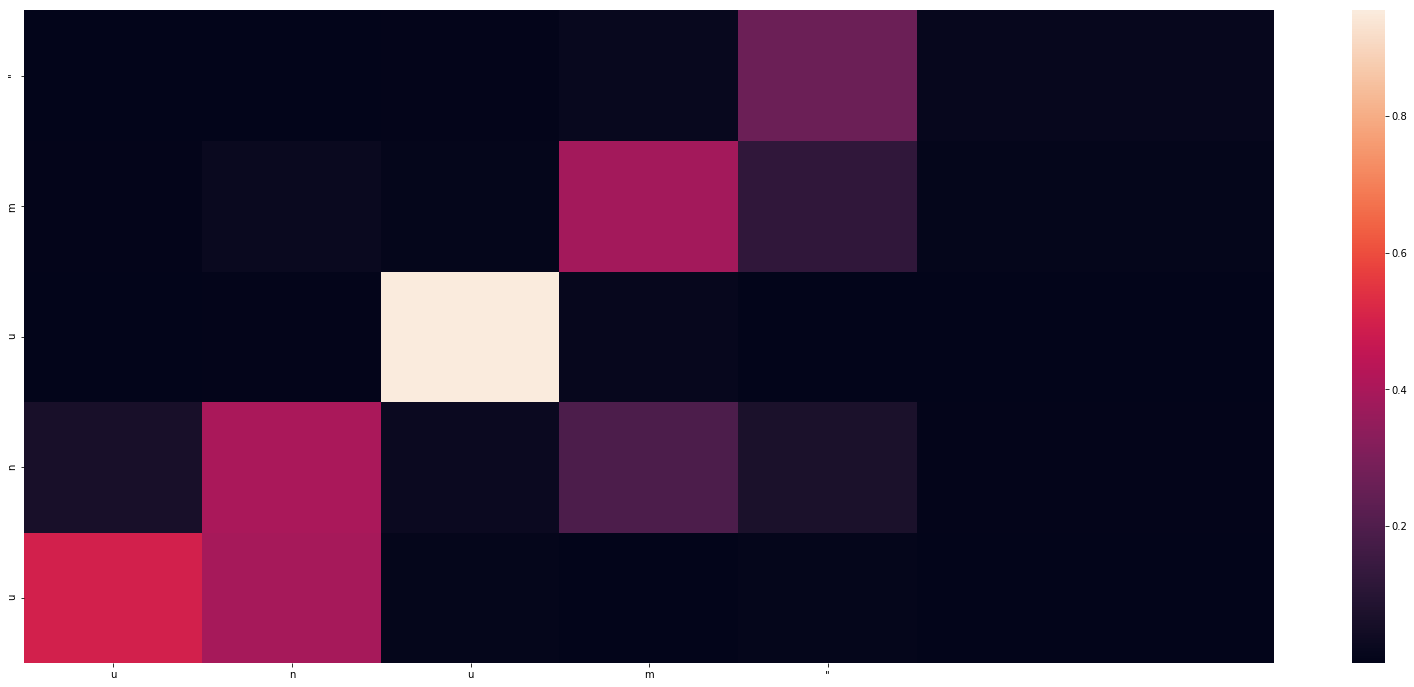

-
Input sentence: unum"
GT sentence: unum

Decoded sentence: unum"


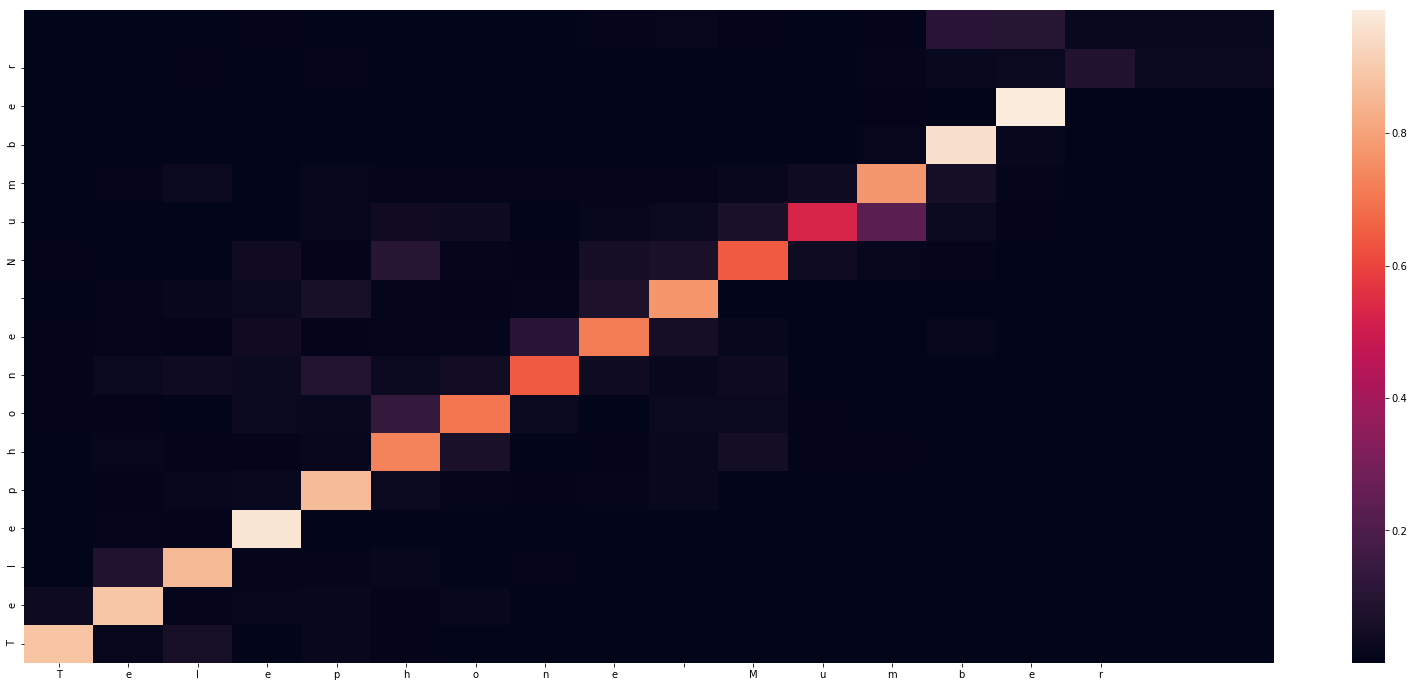

-
Input sentence: Telephone Mumber
GT sentence: Telephone Number

Decoded sentence: Telephone Number


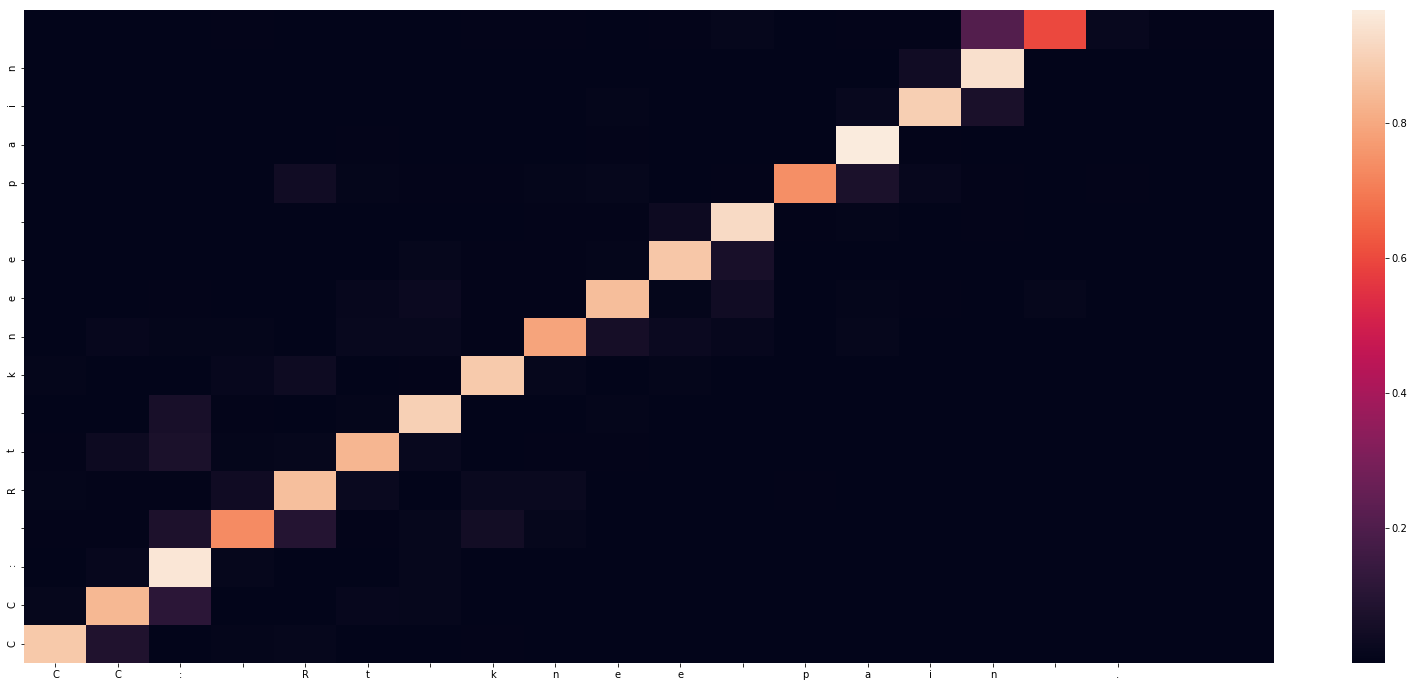

-
Input sentence: CC: Rt knee pain .
GT sentence: CC: Rt knee pain

Decoded sentence: CC: Rt knee pain


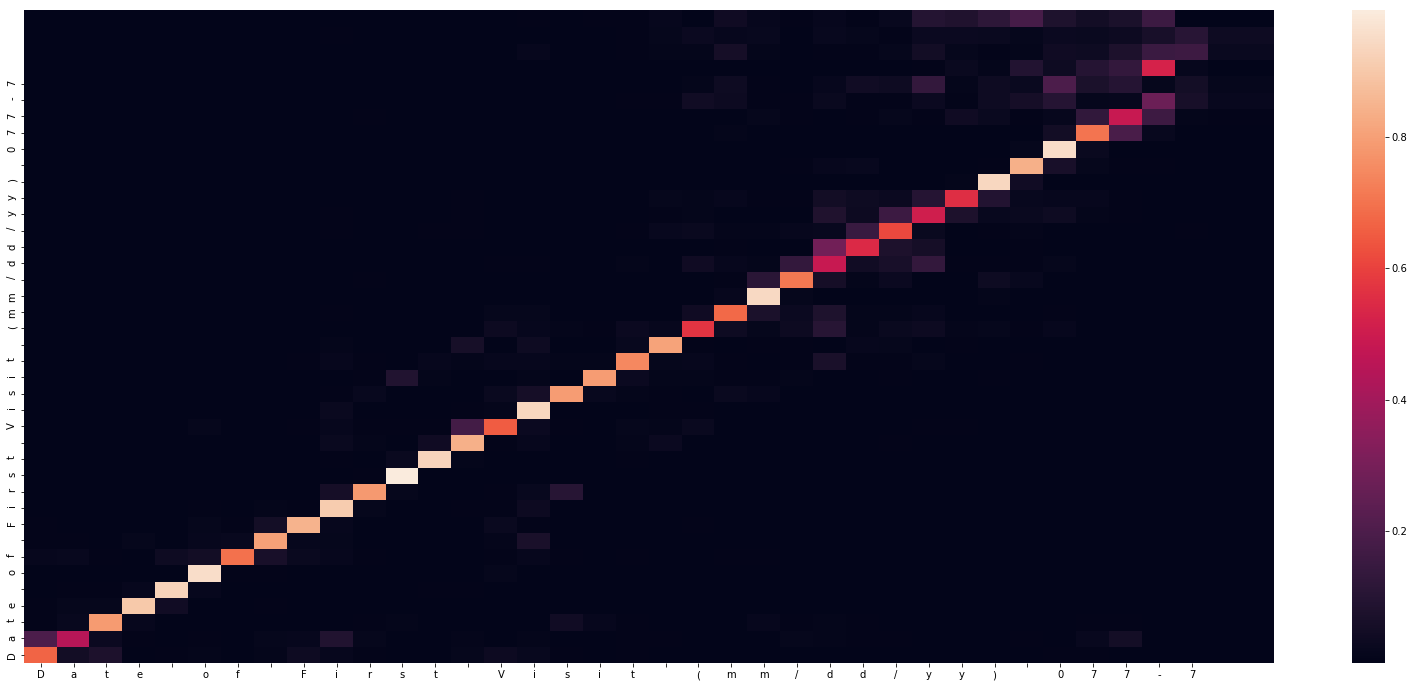

-
Input sentence: Date of First Visit (mm/dd/yy) 077-7
GT sentence: Date of First Visit (mm/dd/yy) 07-30-17

Decoded sentence: Date of First Visit (mm/dd/yy) 077-7


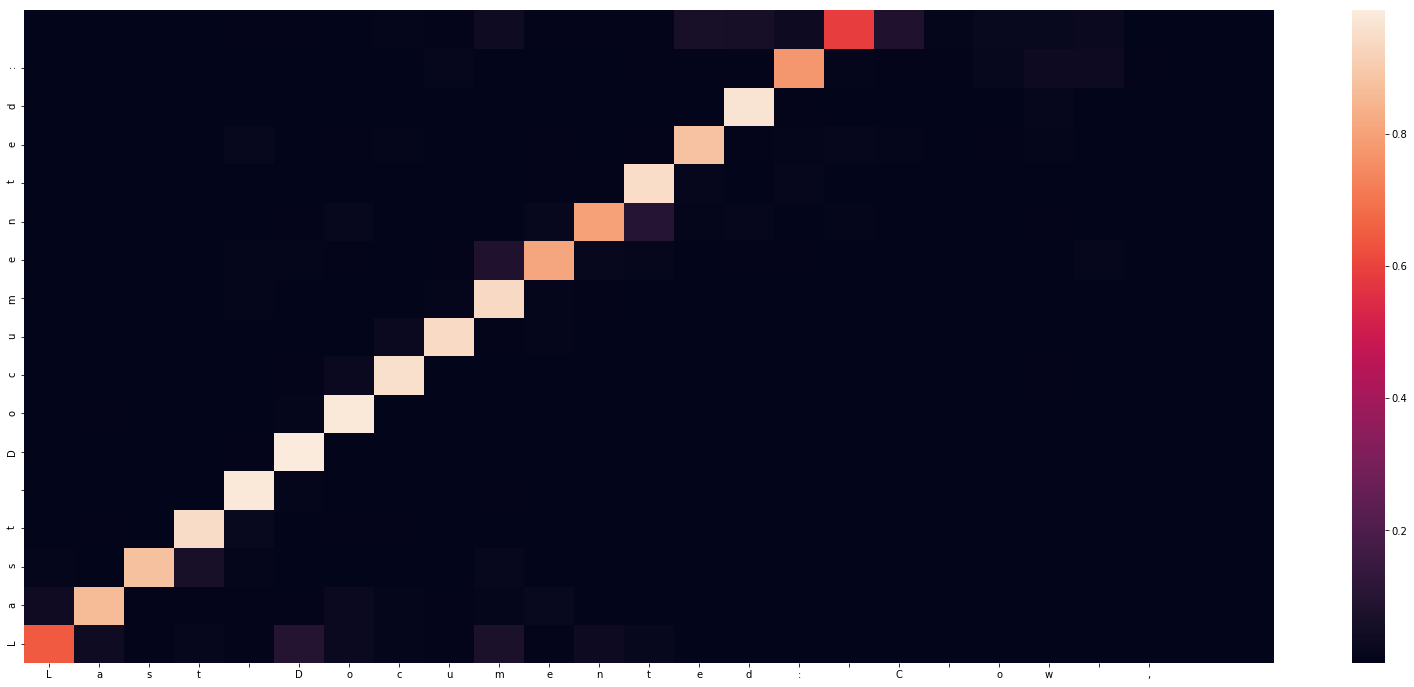

-
Input sentence: Last Documented: C ow ,
GT sentence: Last Documented:

Decoded sentence: Last Documented:


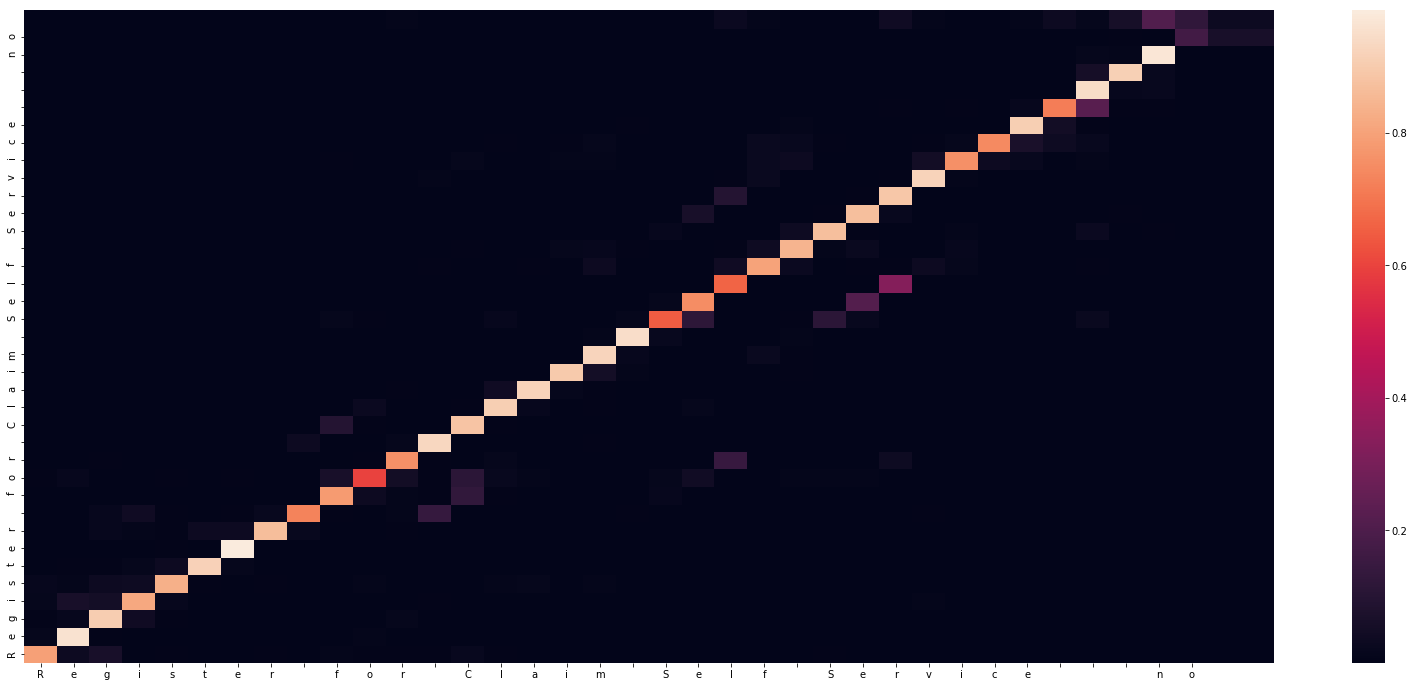

-
Input sentence: Register for Claim Self Service — no
GT sentence: Register for Claim Self Service - no

Decoded sentence: Register for Claim Self Service — no


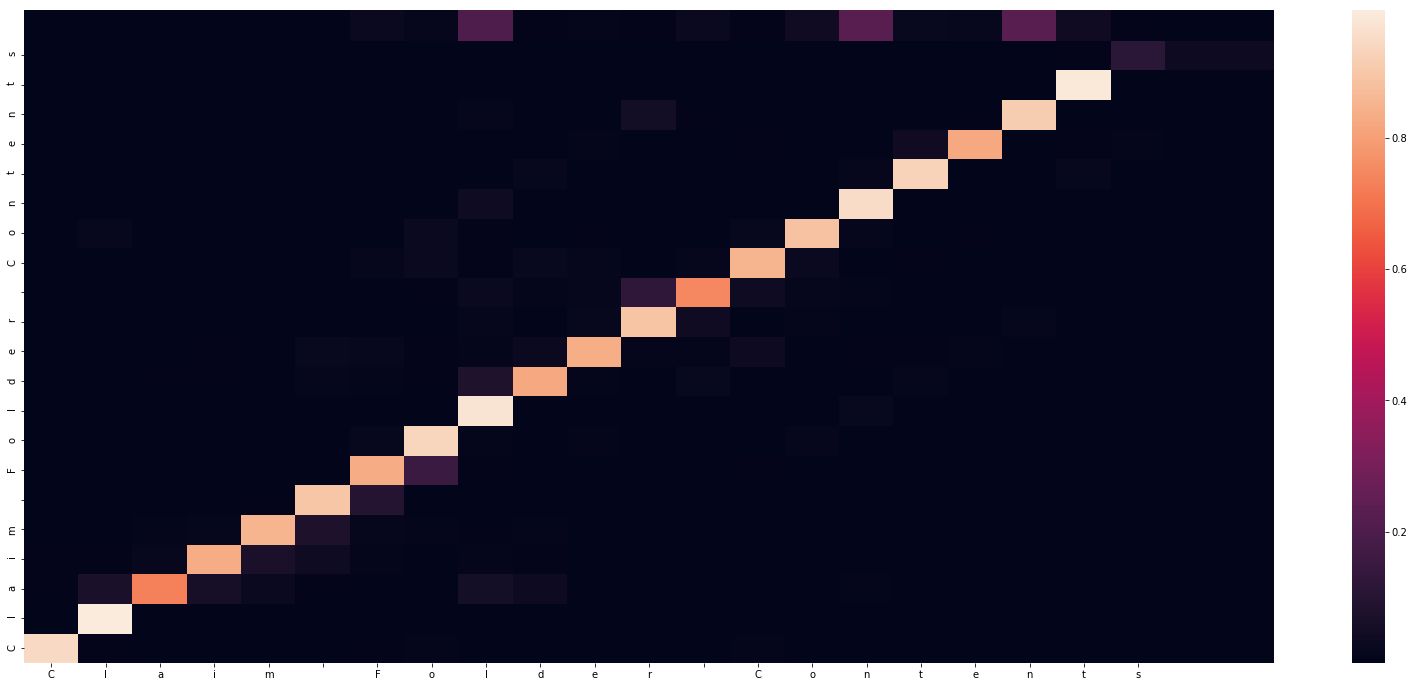

-
Input sentence: Claim Folder Contents
GT sentence: Claim Folder Contents

Decoded sentence: Claim Folder Contents


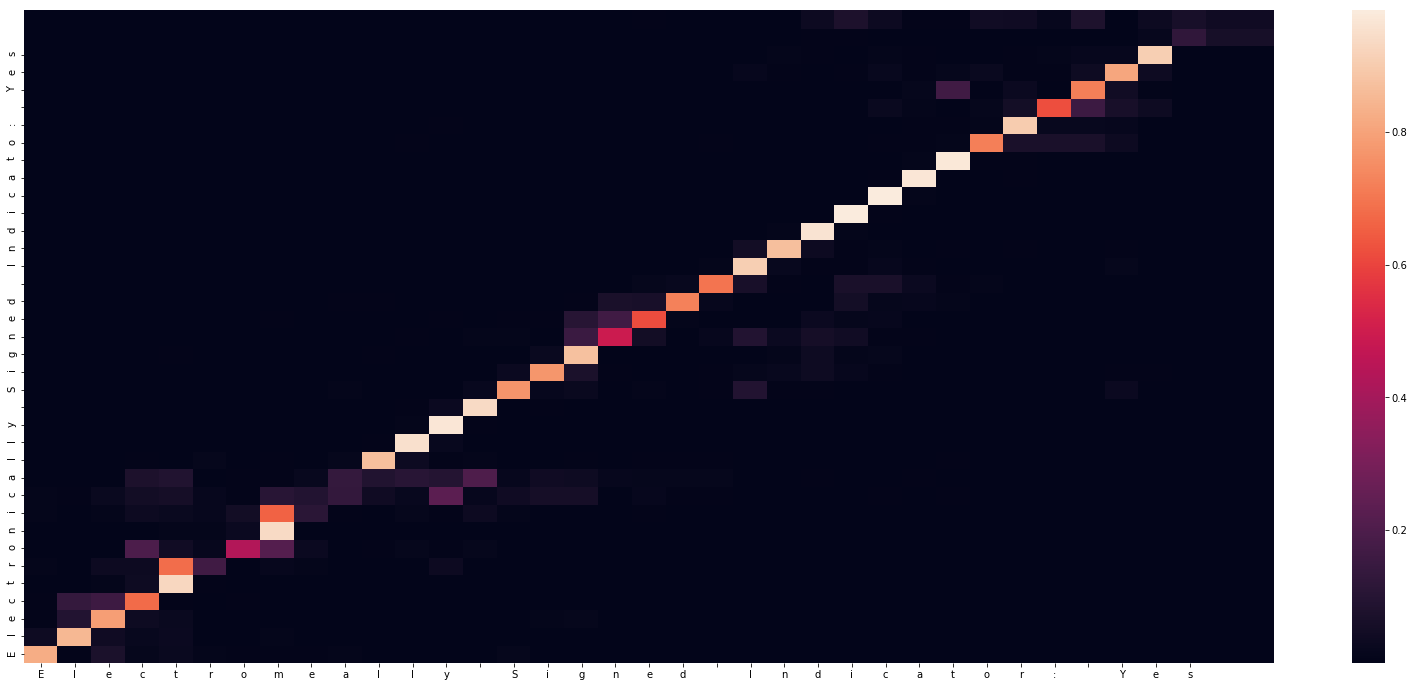

-
Input sentence: Electromeally Signed Indicator: Yes
GT sentence: Electronically Signed Indicator: Yes

Decoded sentence: Electronically Signed Indicato: Yes


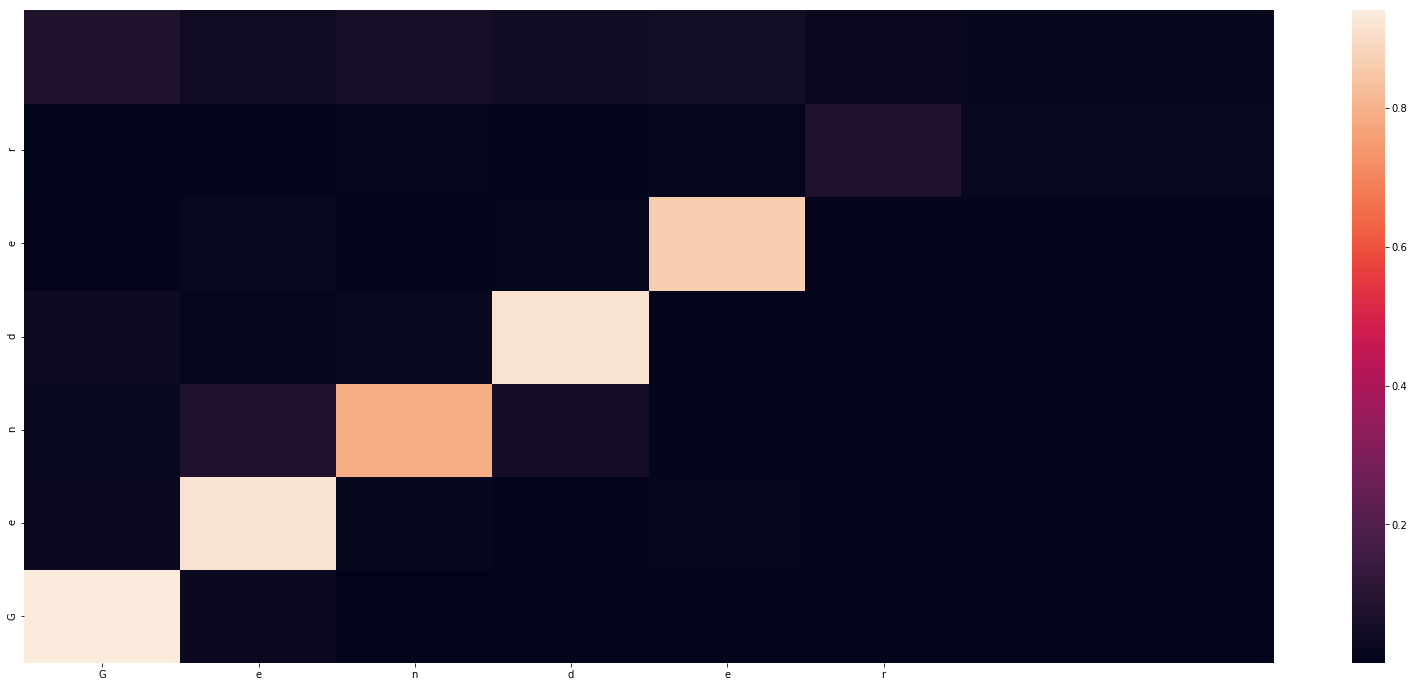

-
Input sentence: Gender
GT sentence: Gender

Decoded sentence: Gender


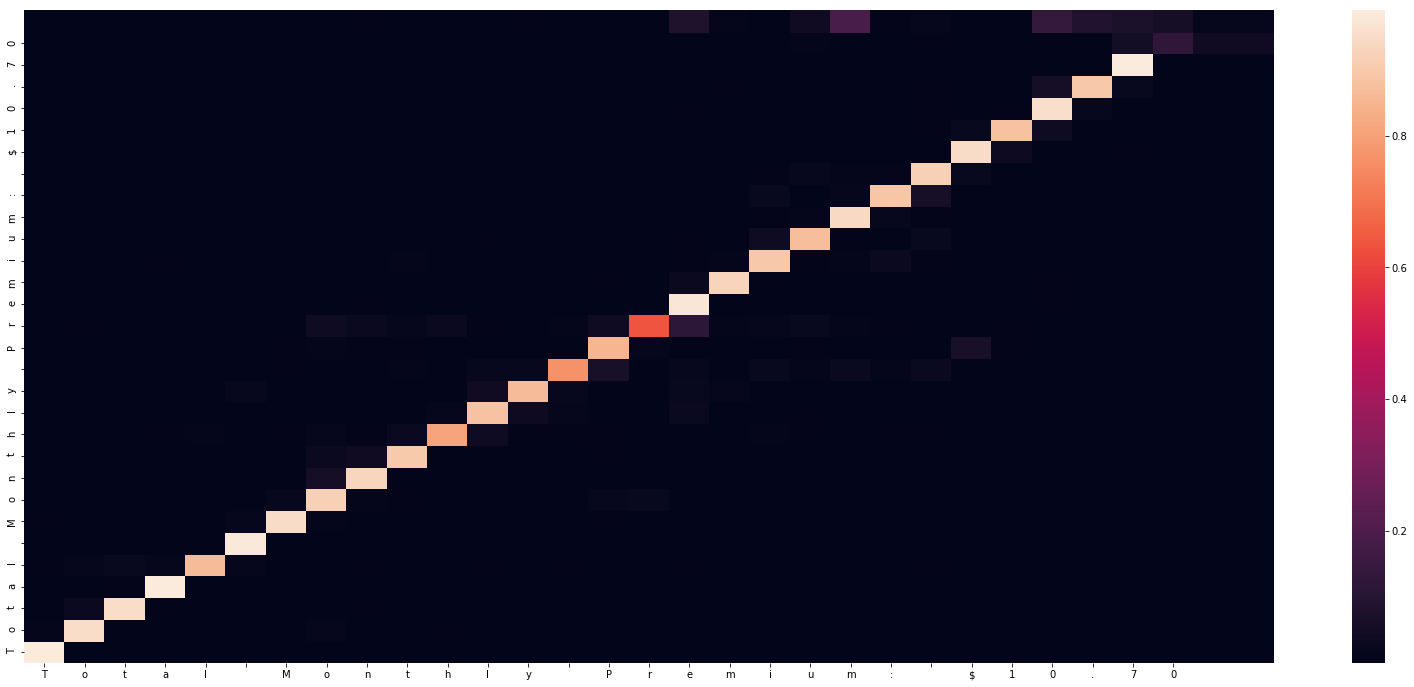

-
Input sentence: Total Monthly Premium: $10.70
GT sentence: Total Monthly Premium: $10.70

Decoded sentence: Total Monthly Premium: $10.70


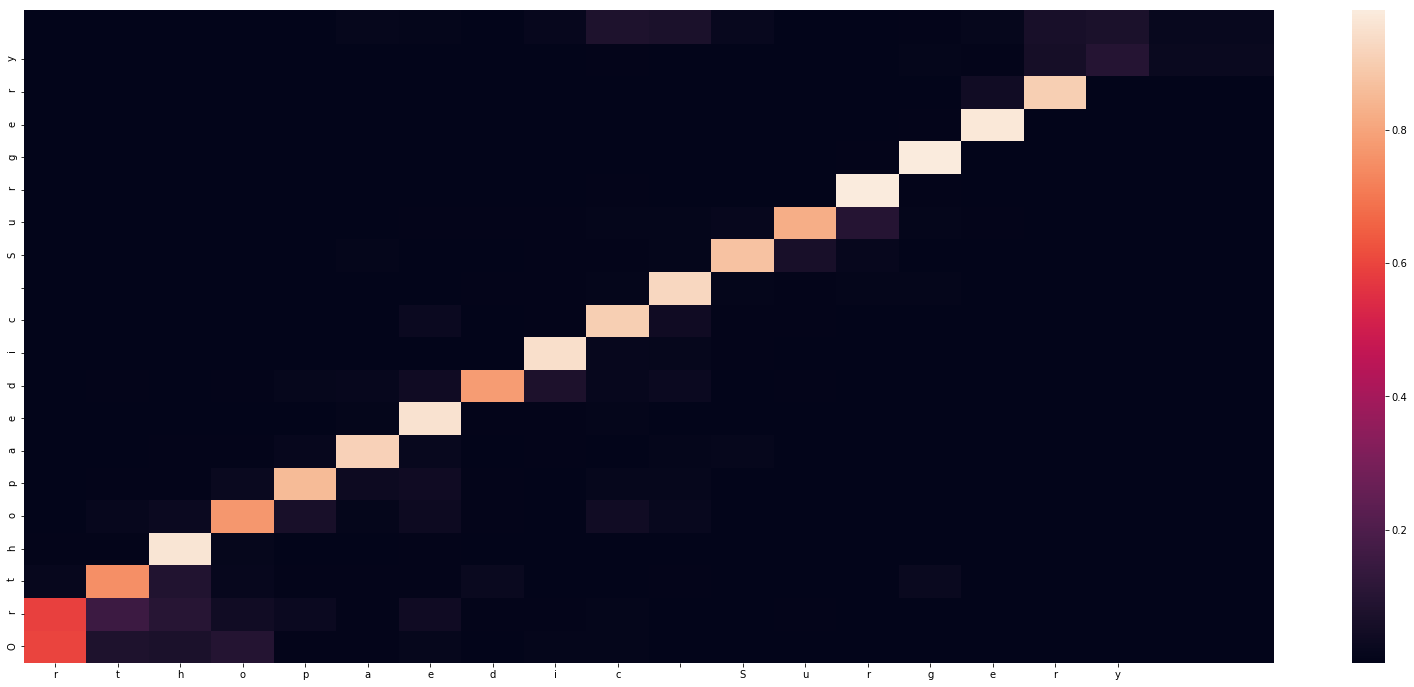

-
Input sentence: rthopaedic Surgery
GT sentence: Orthopaedic Surgery

Decoded sentence: Orthopaedic Surgery


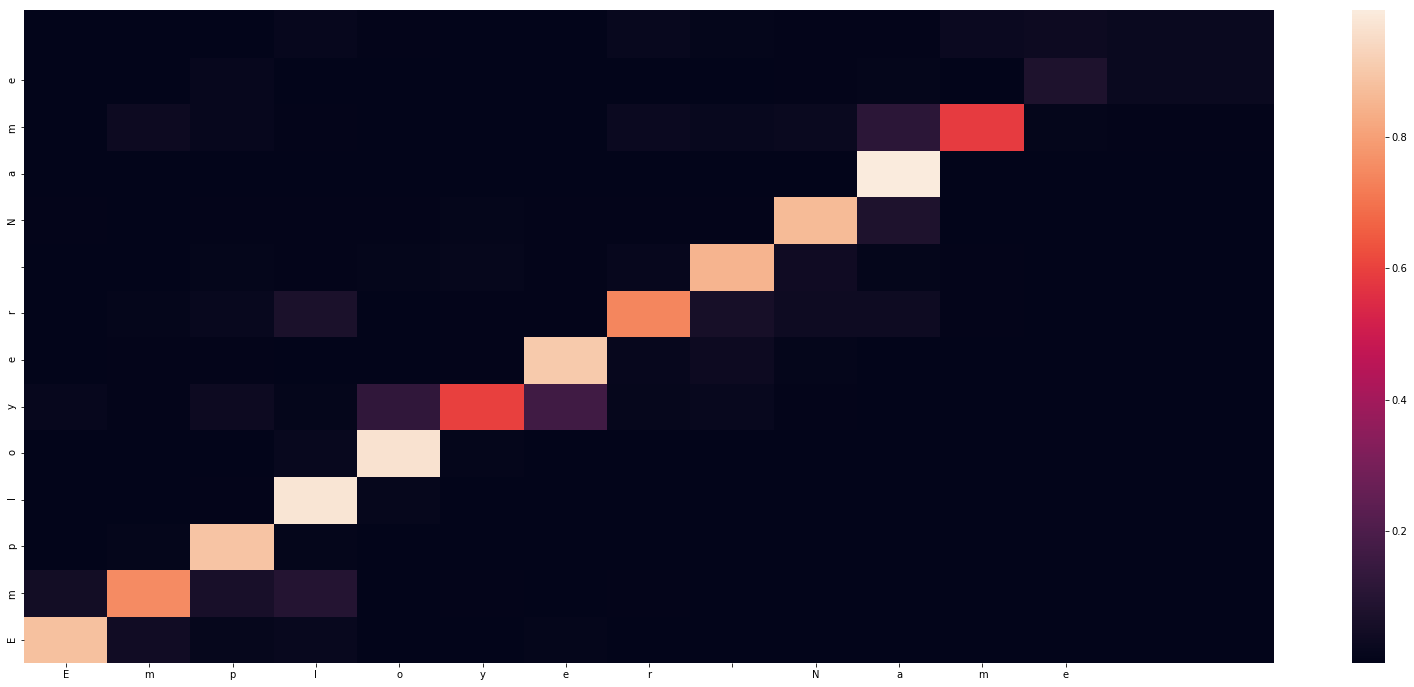

-
Input sentence: Employer Name
GT sentence: Employer Name

Decoded sentence: Employer Name


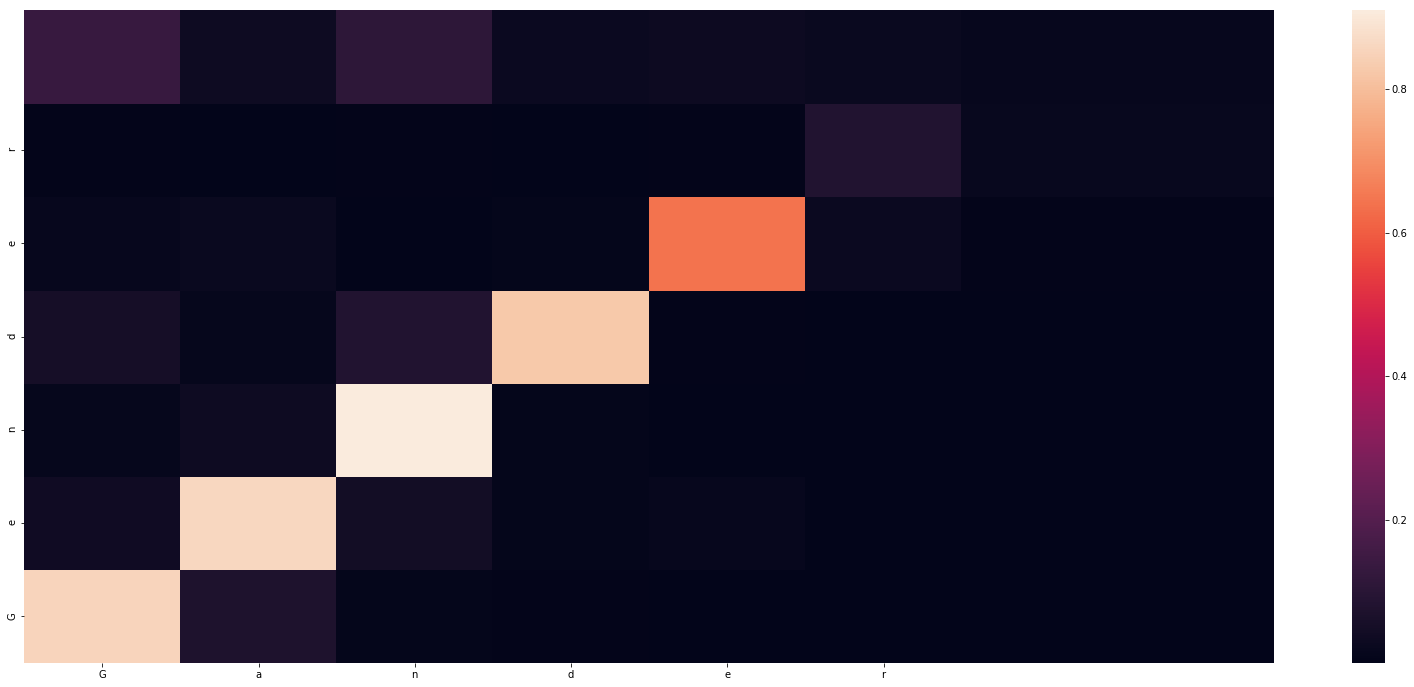

-
Input sentence: Gander
GT sentence: Gender

Decoded sentence: Gender


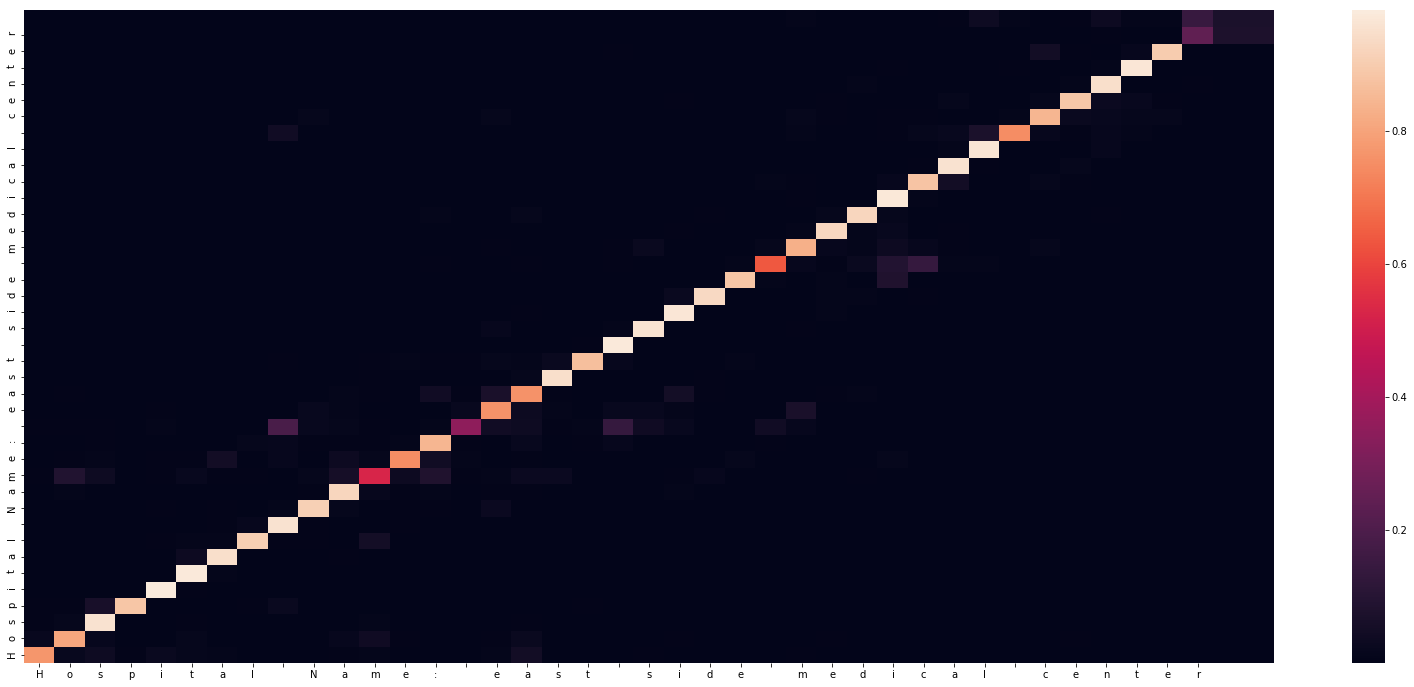

-
Input sentence: Hospital Name: east side medical center
GT sentence: Hospital Name: east side medical center

Decoded sentence: Hospital Name: east side medical center


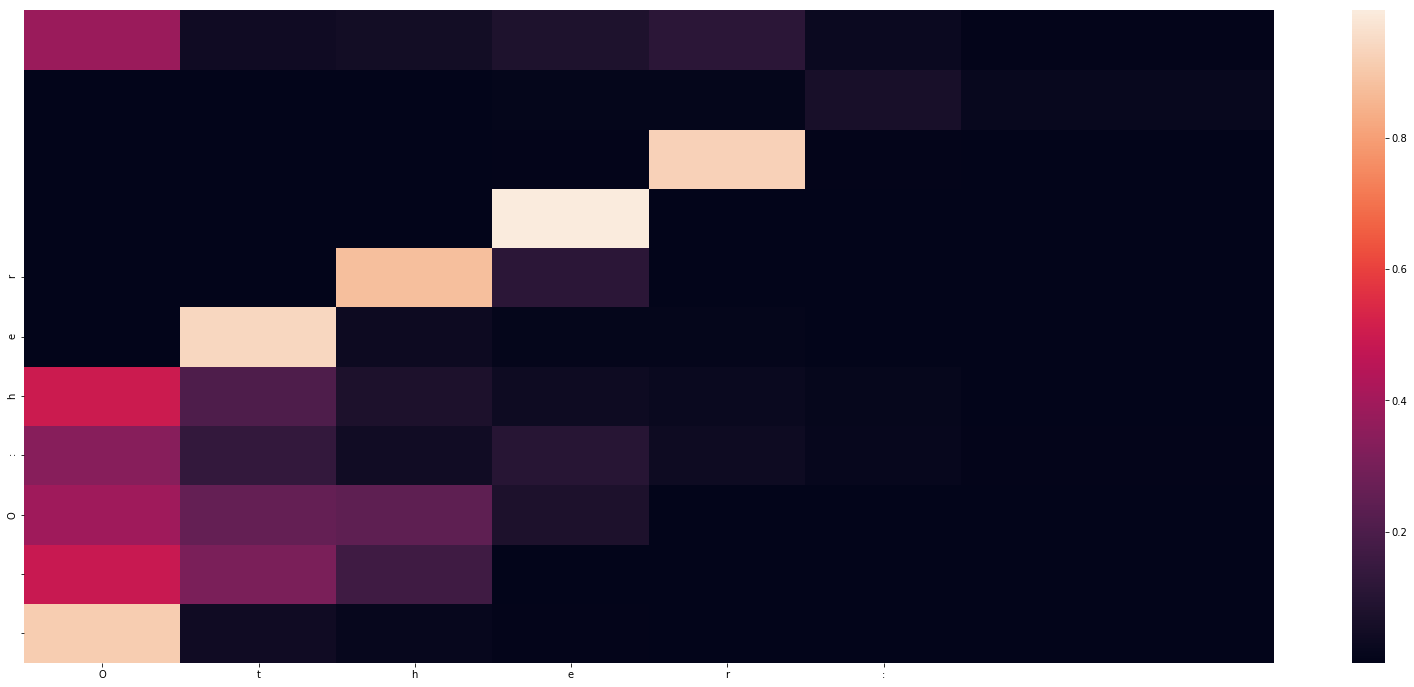

-
Input sentence: Other:
GT sentence: [ ] Other:

Decoded sentence:   O:her


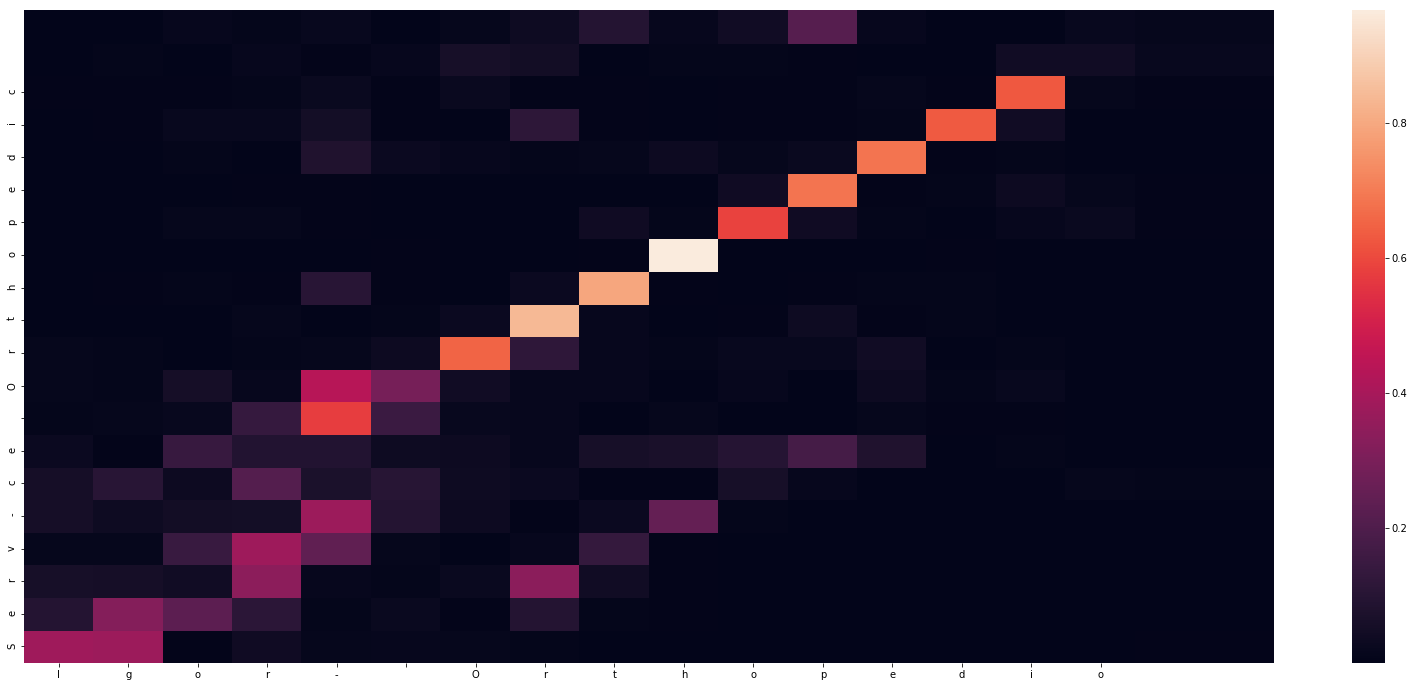

-
Input sentence: Igor- Orthopedio
GT sentence: Service: Orthopedic

Decoded sentence: Serv-ce Orthopedic


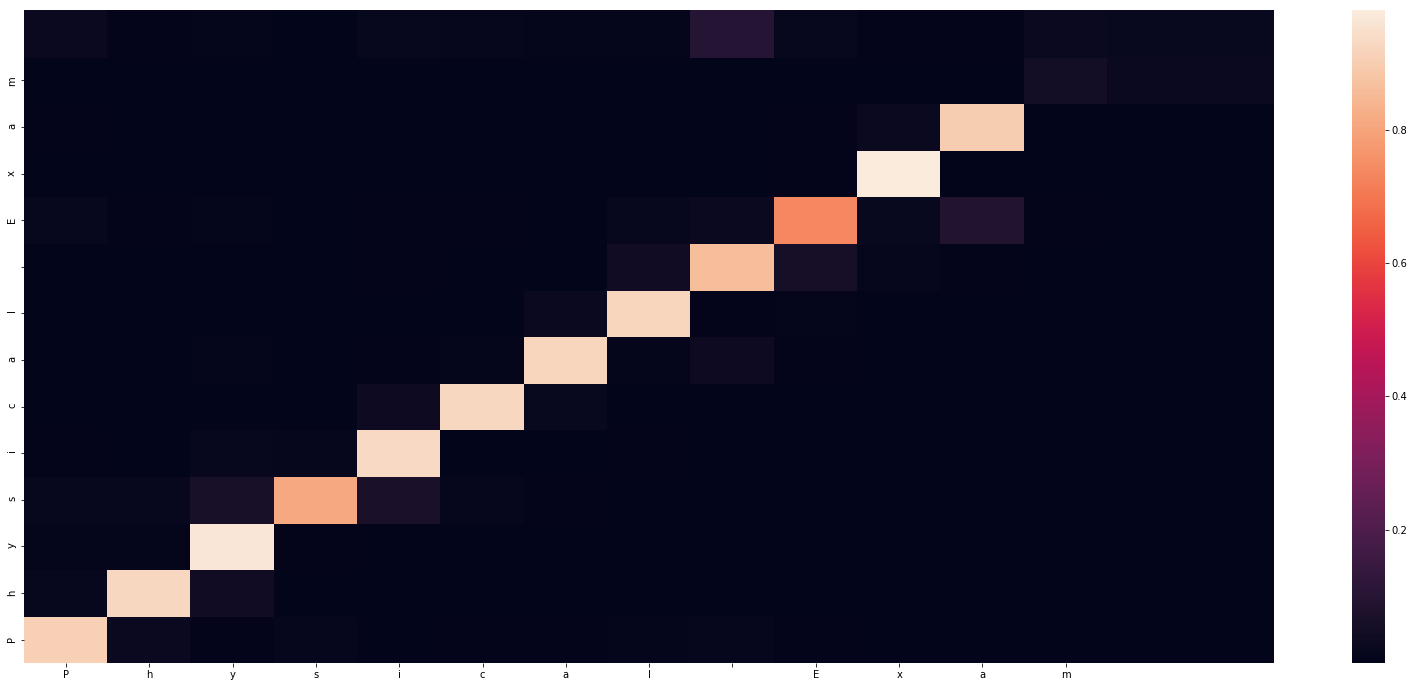

-
Input sentence: Physical Exam
GT sentence: Physical Exam

Decoded sentence: Physical Exam


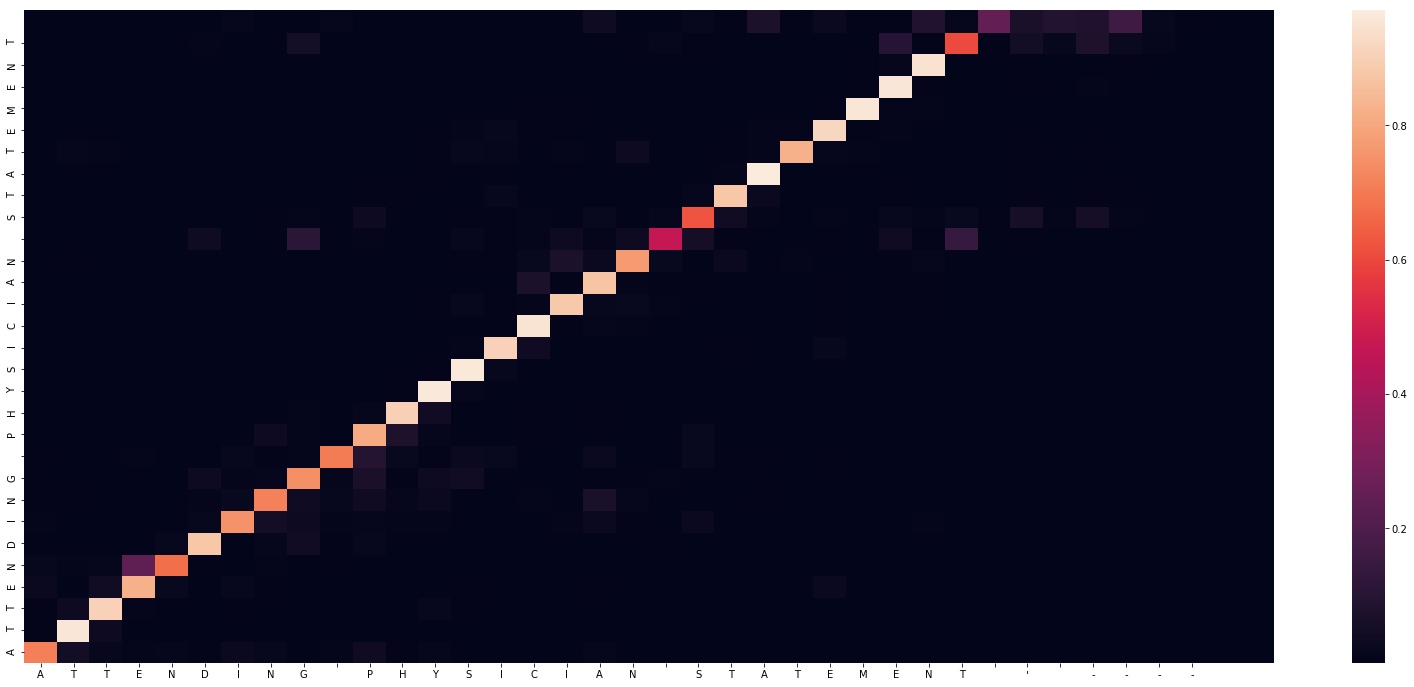

-
Input sentence: ATTENDING PHYSICIAN STATEMENT ' ----
GT sentence: ATTENDING PHYSICIAN STATEMENT

Decoded sentence: ATTENDING PHYSICIAN STATEMENT


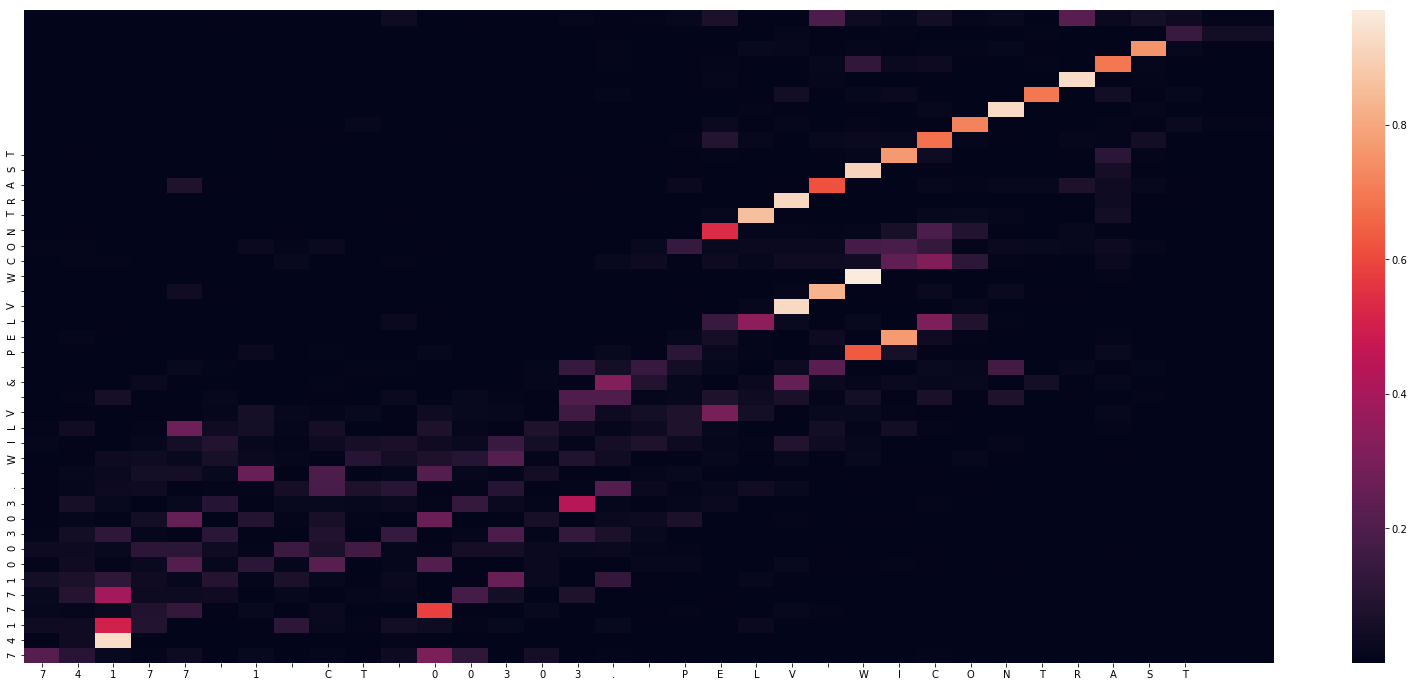

-
Input sentence: 74177 1 CT 00303. PELV WICONTRAST
GT sentence: 01-02-18 74177 1 CT ABD & PELV W/CONTRAST

Decoded sentence: 74177100303. WILV & PELV WCONTRAST


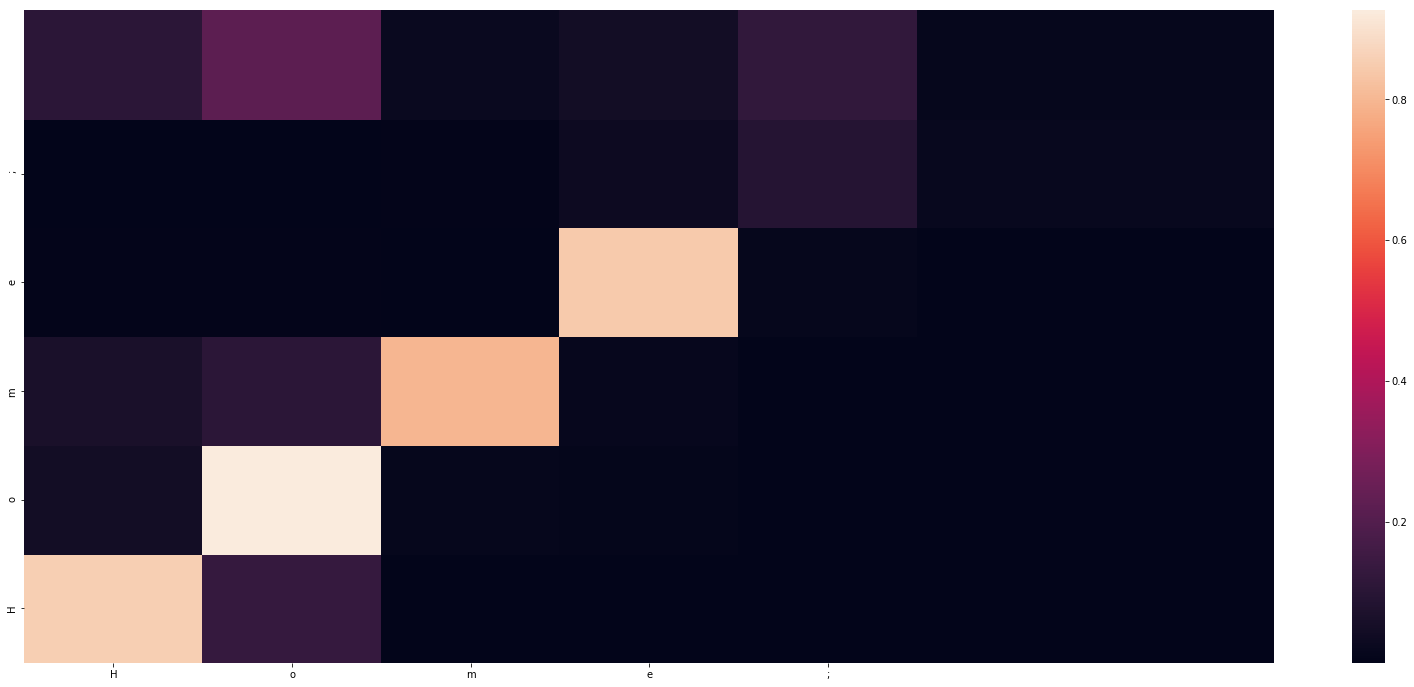

-
Input sentence: Home;
GT sentence: Home:

Decoded sentence: Home;


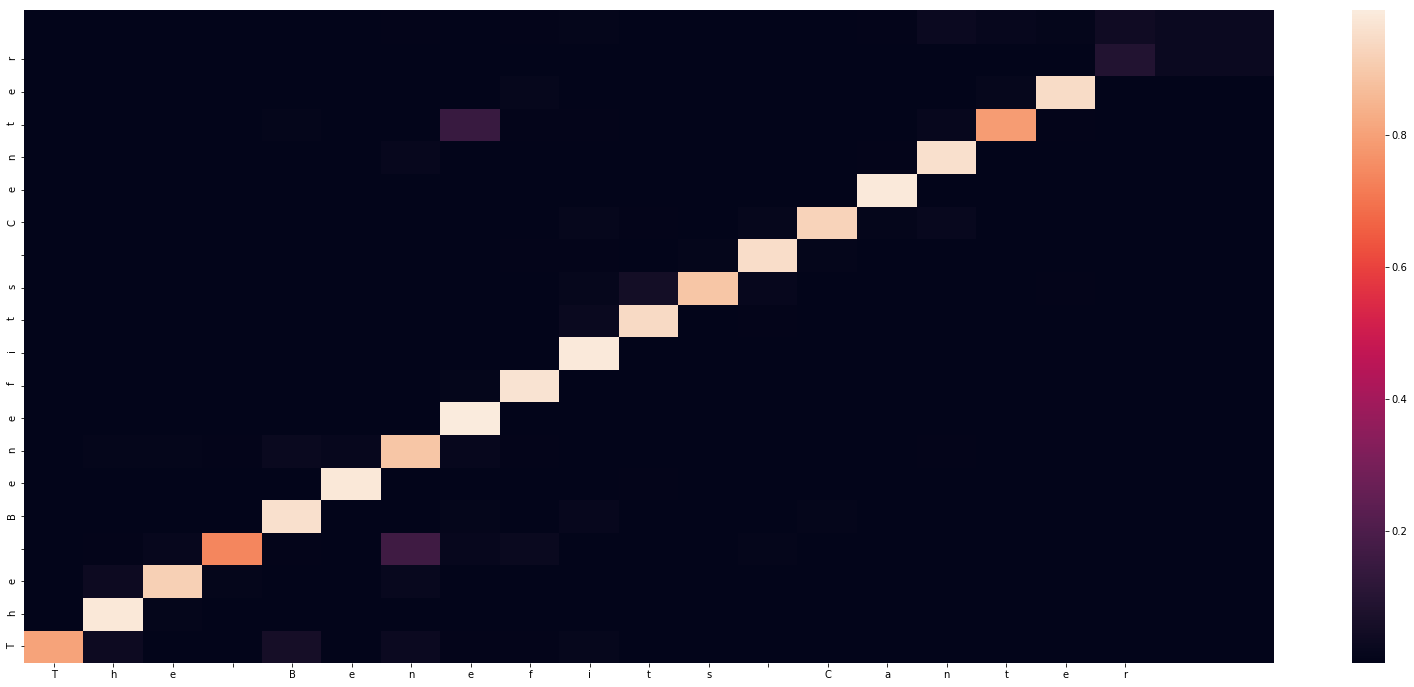

-
Input sentence: The Benefits Canter
GT sentence: The Benefits Center

Decoded sentence: The Benefits Center


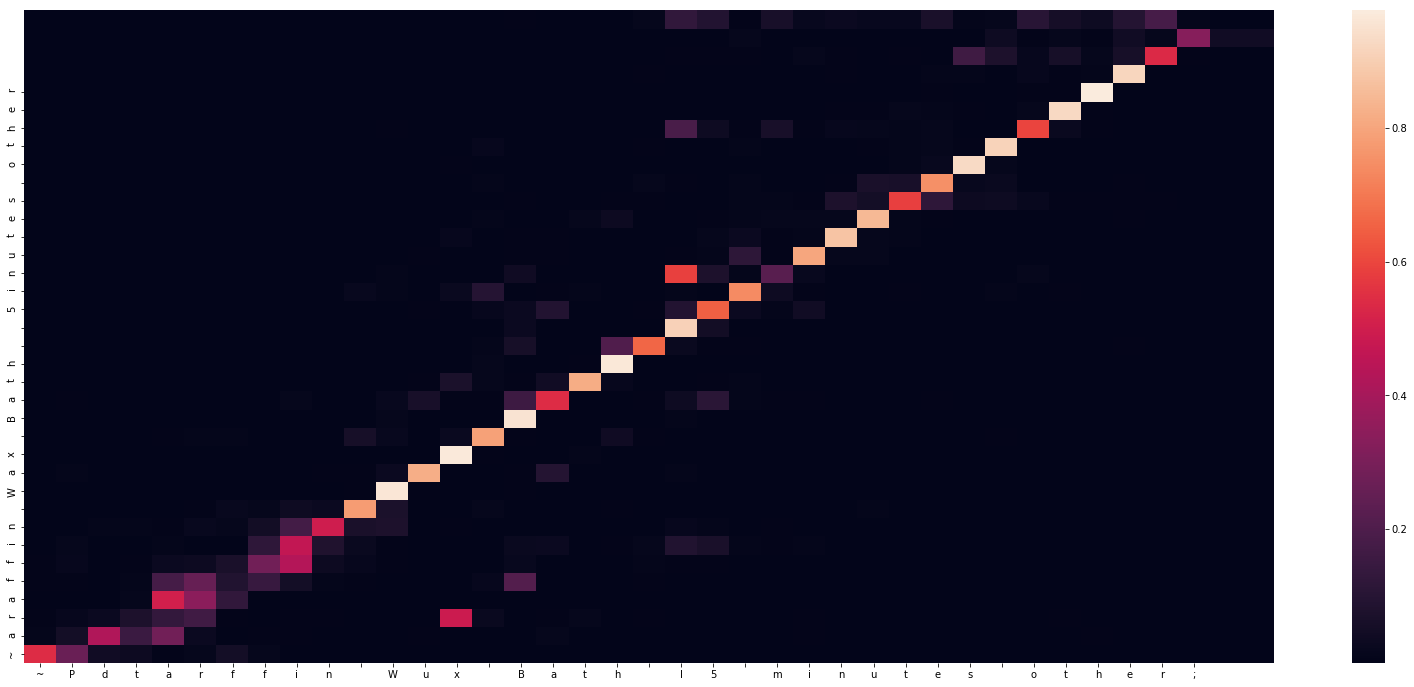

-
Input sentence: ~Pdtarffin Wux Bath I5 minutes other;
GT sentence: Paraffin Wax Bath 15 minutes other:

Decoded sentence: ~araffin Wax Bath  5inutes other


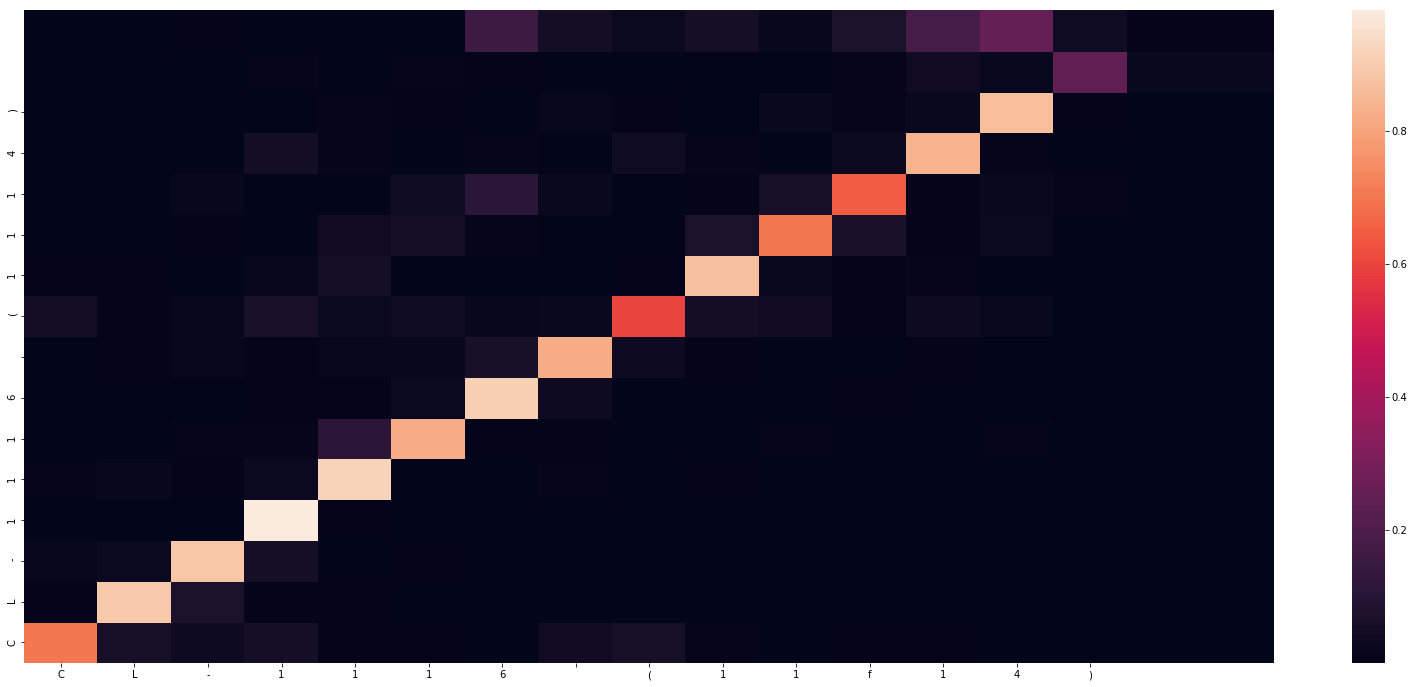

-
Input sentence: CL-1116 (11f14)
GT sentence: CL-1116 (11/14)

Decoded sentence: CL-1116 (1114)


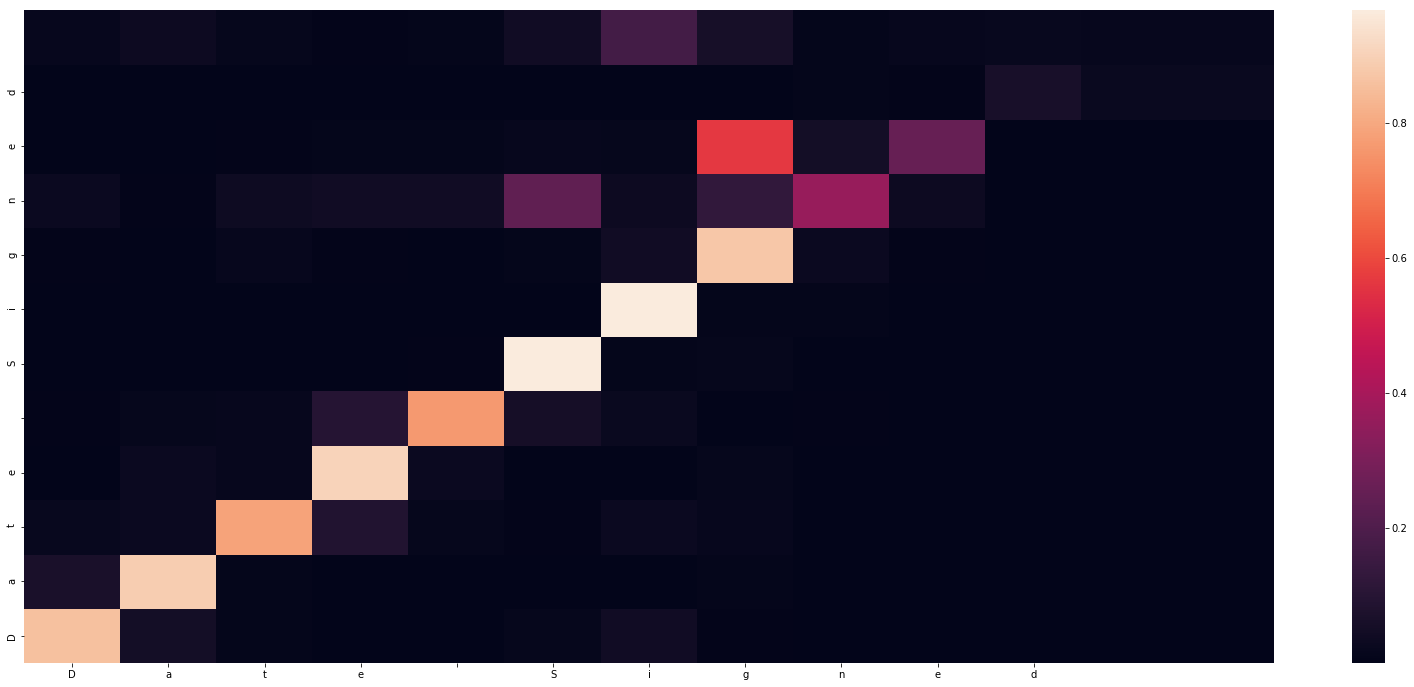

-
Input sentence: Date Signed
GT sentence: Date Signed

Decoded sentence: Date Signed


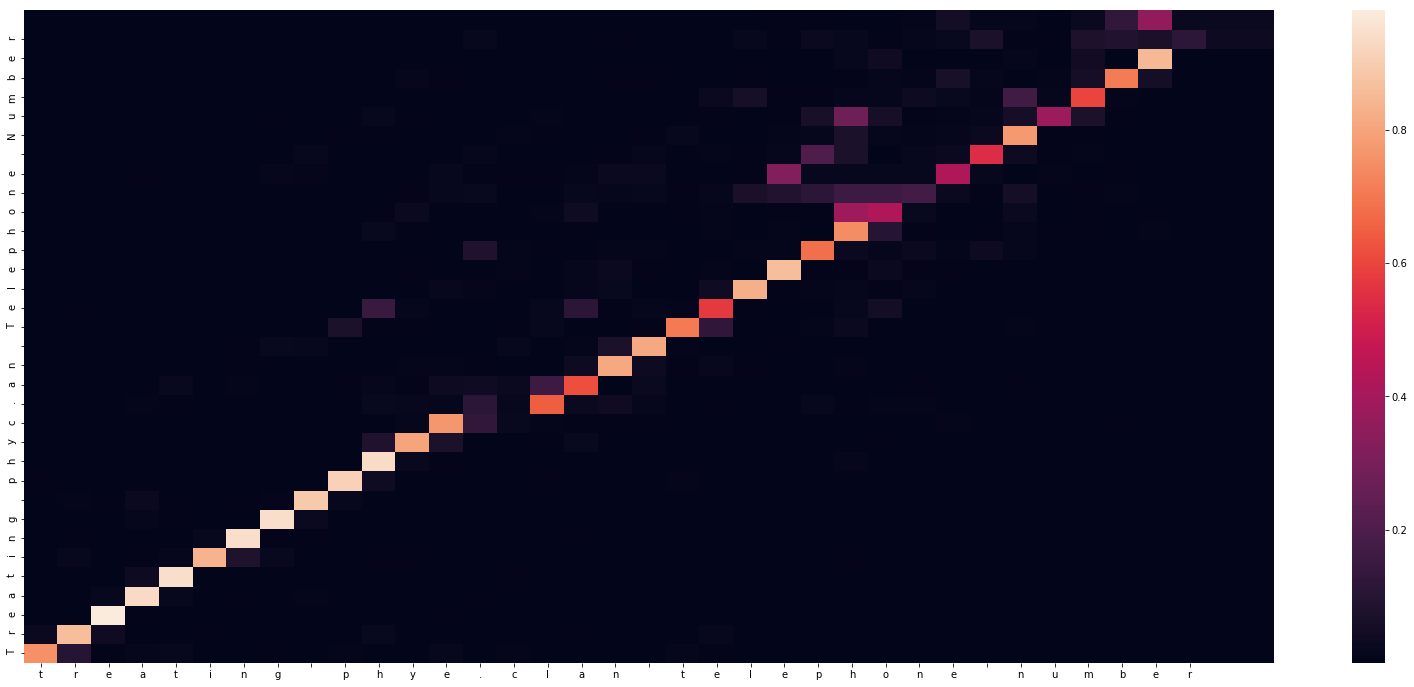

-
Input sentence: treating phye.clan telephone number
GT sentence: Treating phycian Telephone Number

Decoded sentence: Treating phyc.an Telephone Number


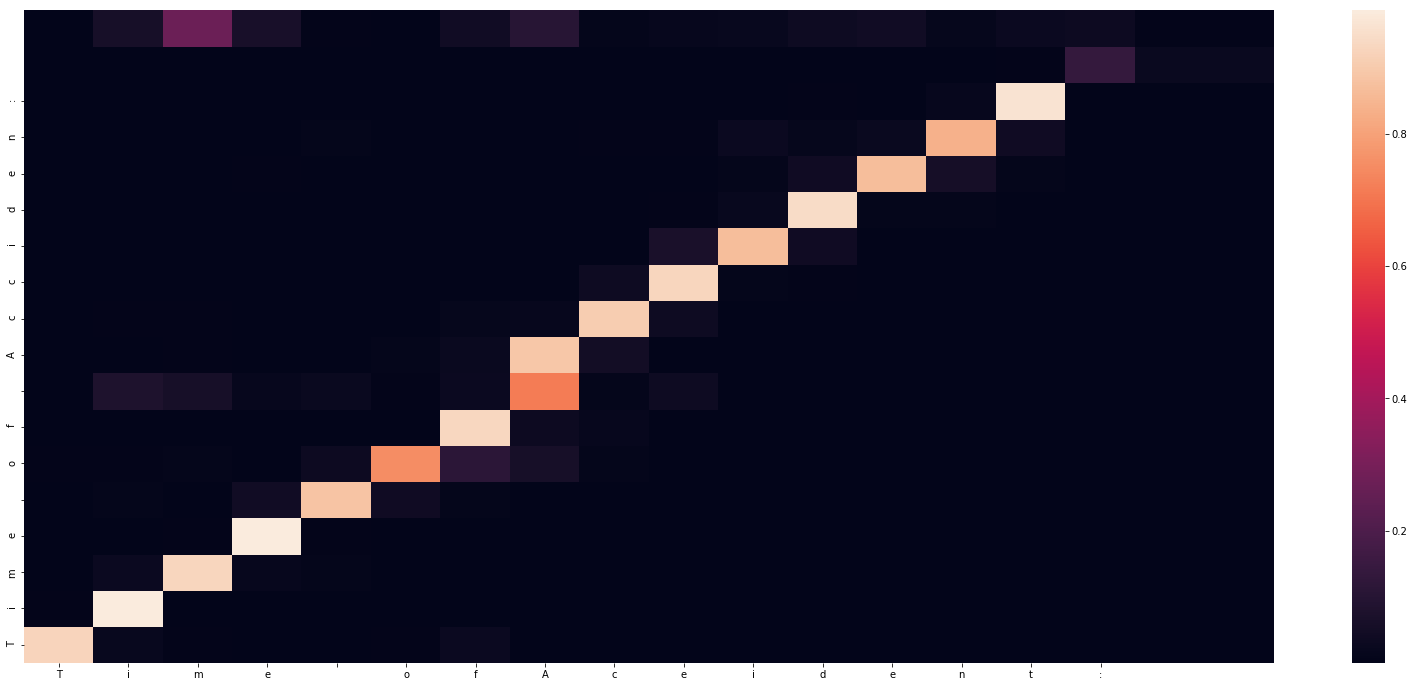

-
Input sentence: Time ofAceident:
GT sentence: Time of Accident:

Decoded sentence: Time of Acciden:


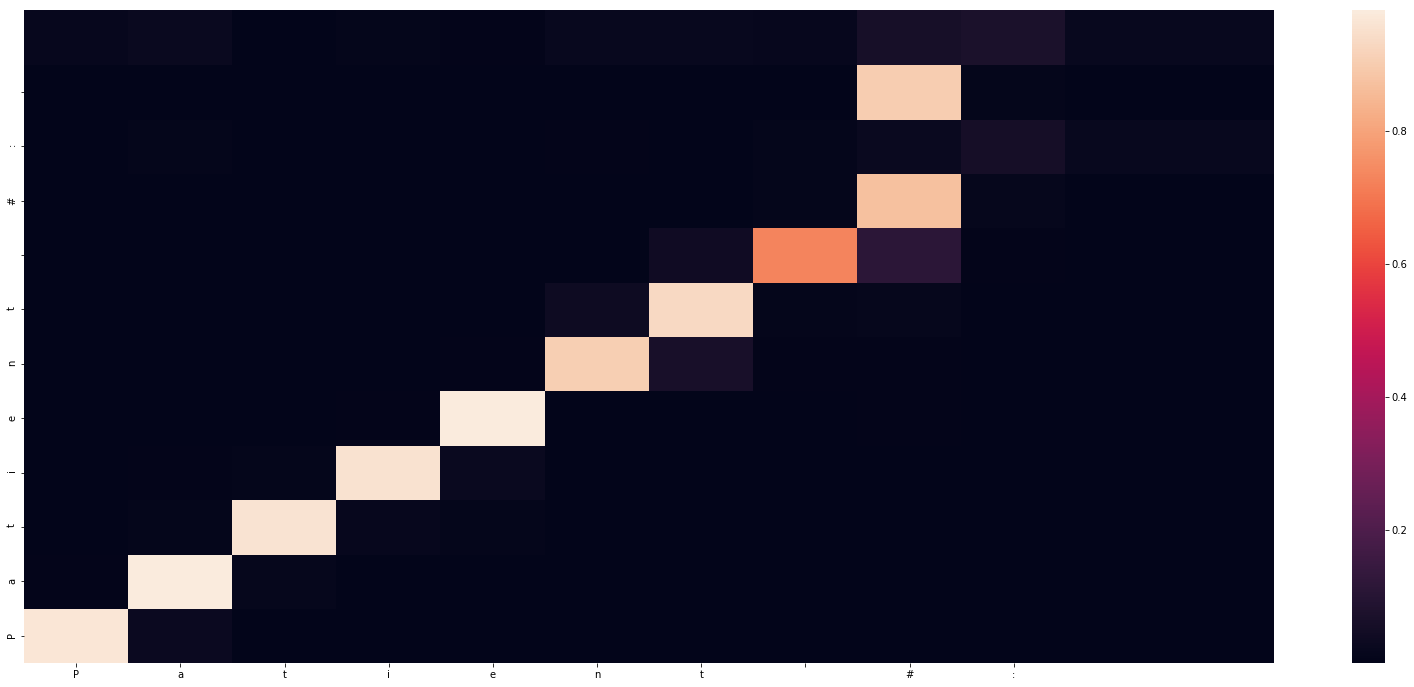

-
Input sentence: Patient #:
GT sentence: Patient #: 

Decoded sentence: Patient #: 


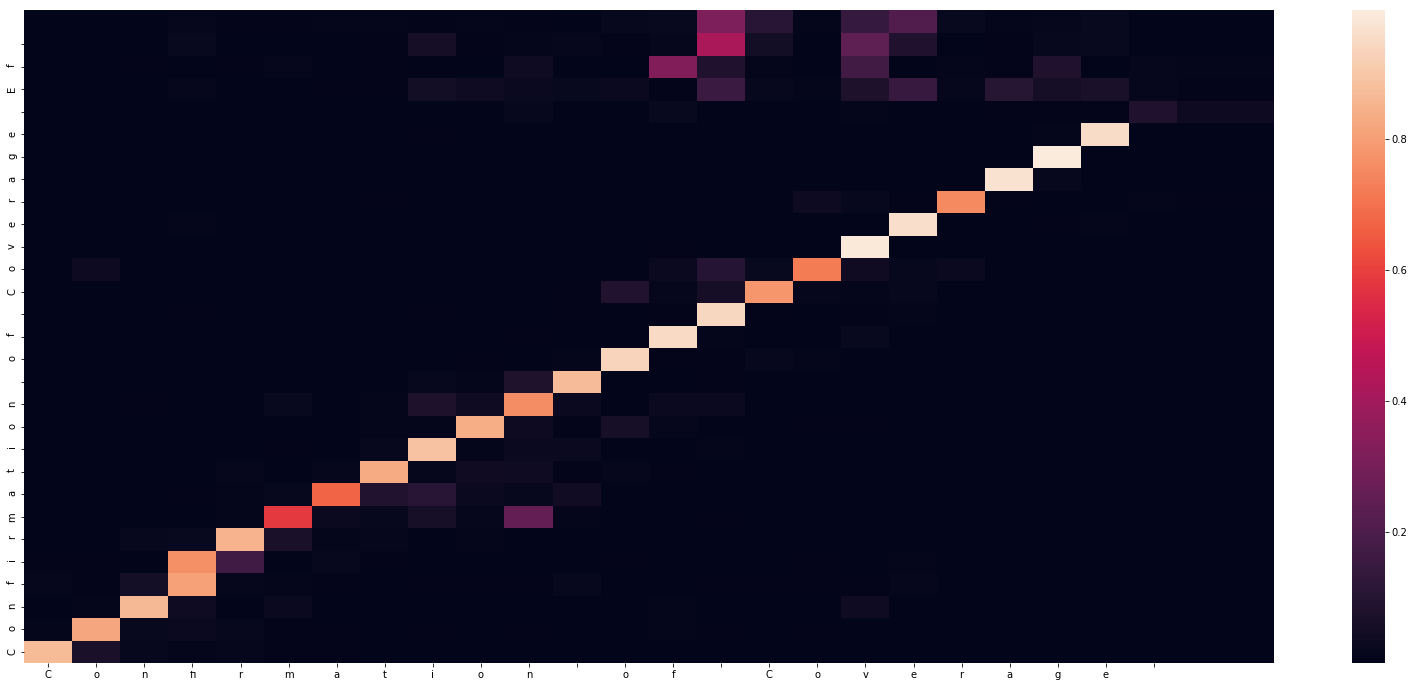

-
Input sentence: Conﬁrmation of Coverage 
GT sentence: Confirmation of Coverage

Decoded sentence: Confirmation of Coverage Ef 


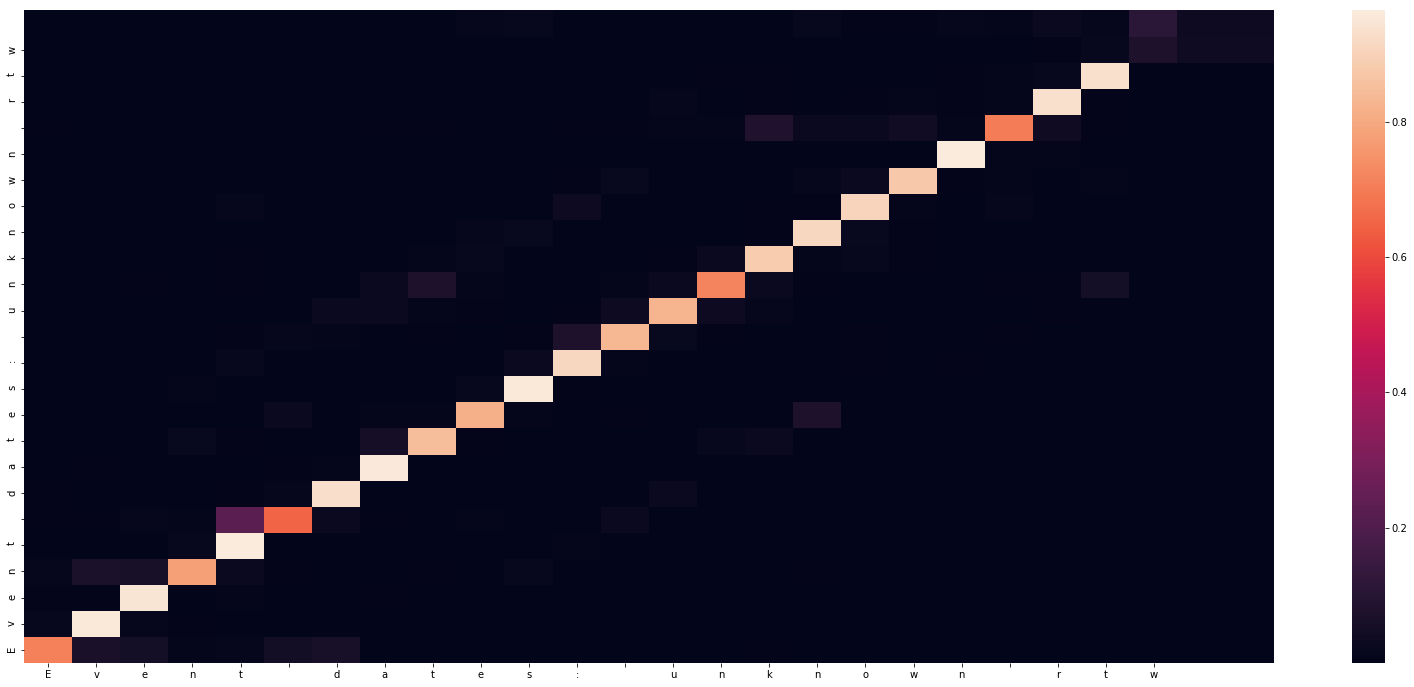

-
Input sentence: Event dates: unknown rtw
GT sentence: Event dates: unknown rtw

Decoded sentence: Event dates: unknown rtw


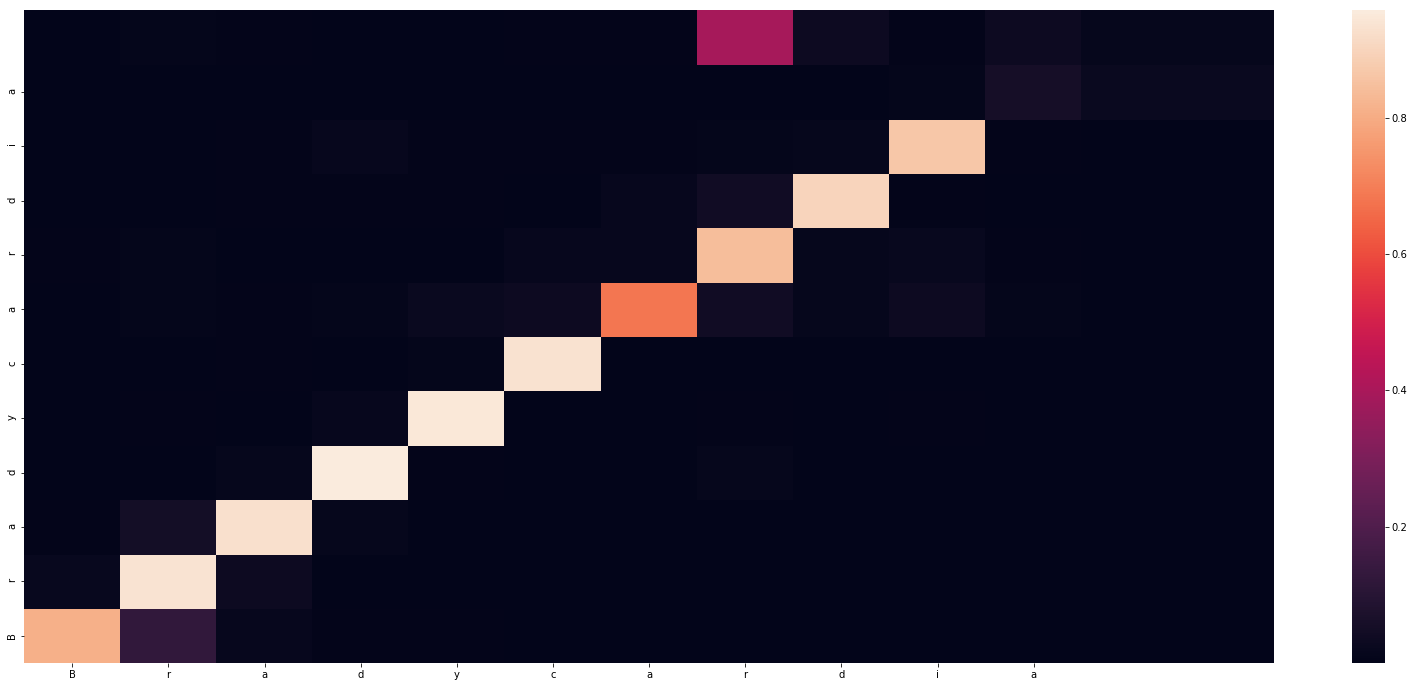

-
Input sentence: Bradycardia
GT sentence: Bradycardia

Decoded sentence: Bradycardia


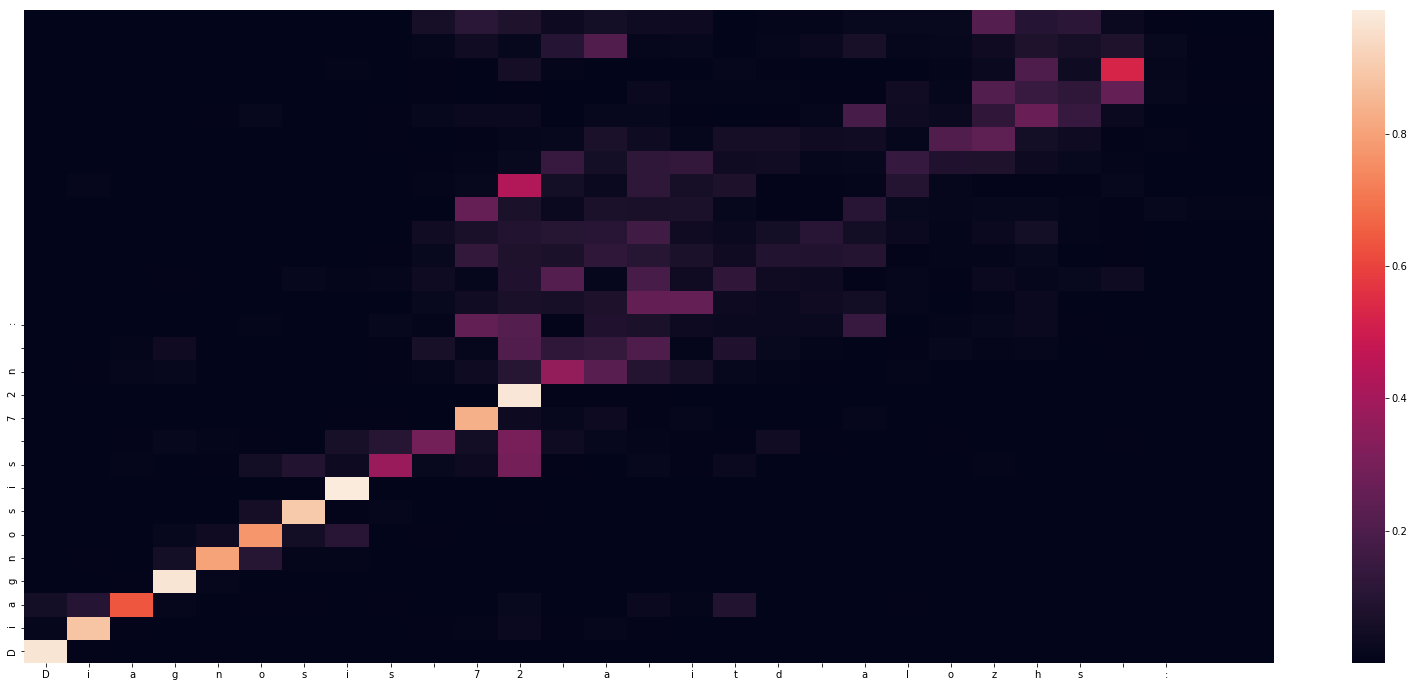

-
Input sentence: Diagnosis 72 a itd alozhs :
GT sentence: Diagnosis: 722.211A

Decoded sentence: Diagnosis 72n :


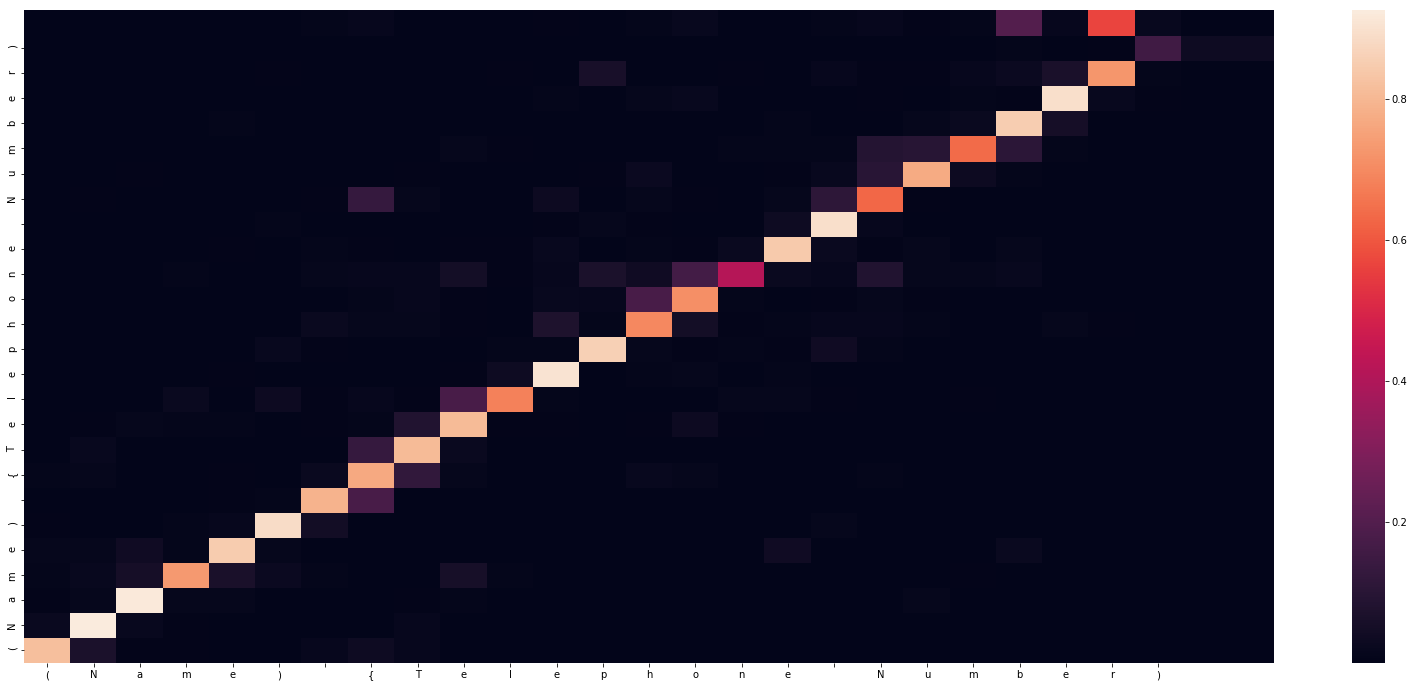

-
Input sentence: (Name) {Telephone Number)
GT sentence: (Name) (Telephone Number)

Decoded sentence: (Name) {Telephone Number)


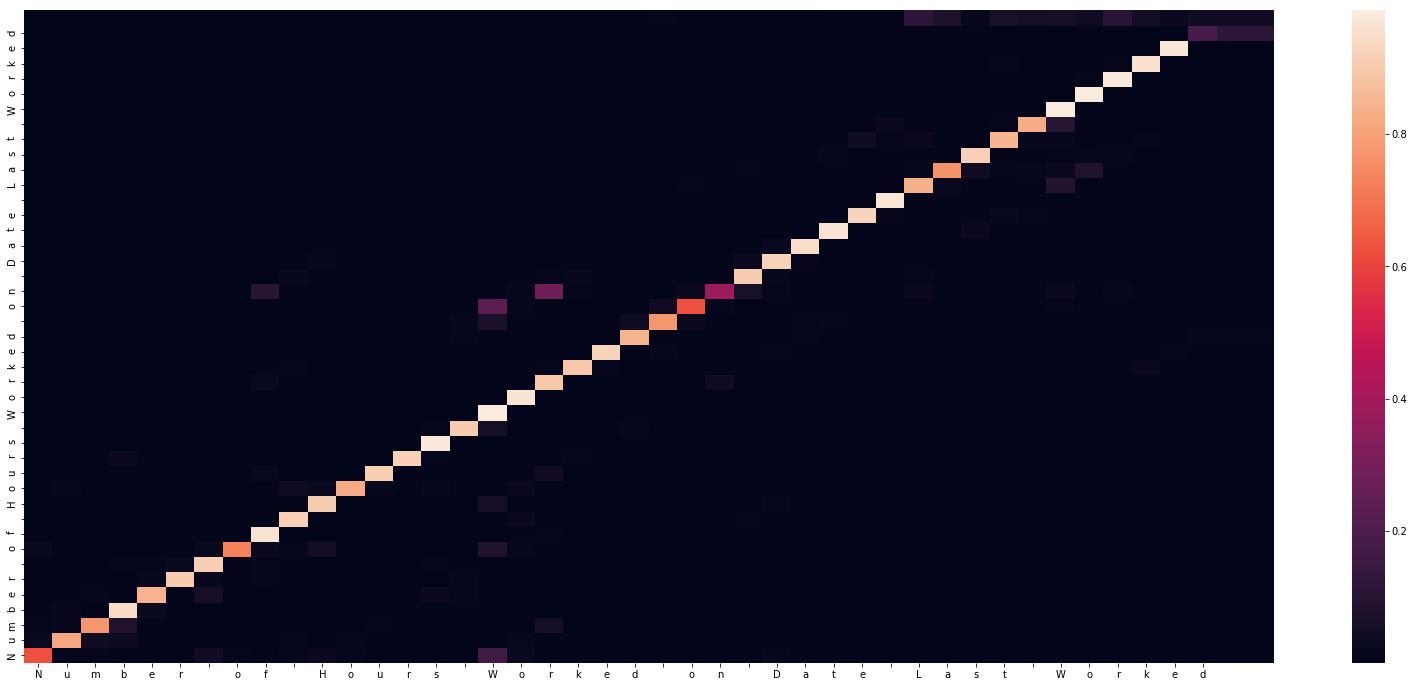

-
Input sentence: Number of Hours Worked on Date Last Worked
GT sentence: Number of Hours Worked on Date Last Worked

Decoded sentence: Number of Hours Worked on Date Last Worked


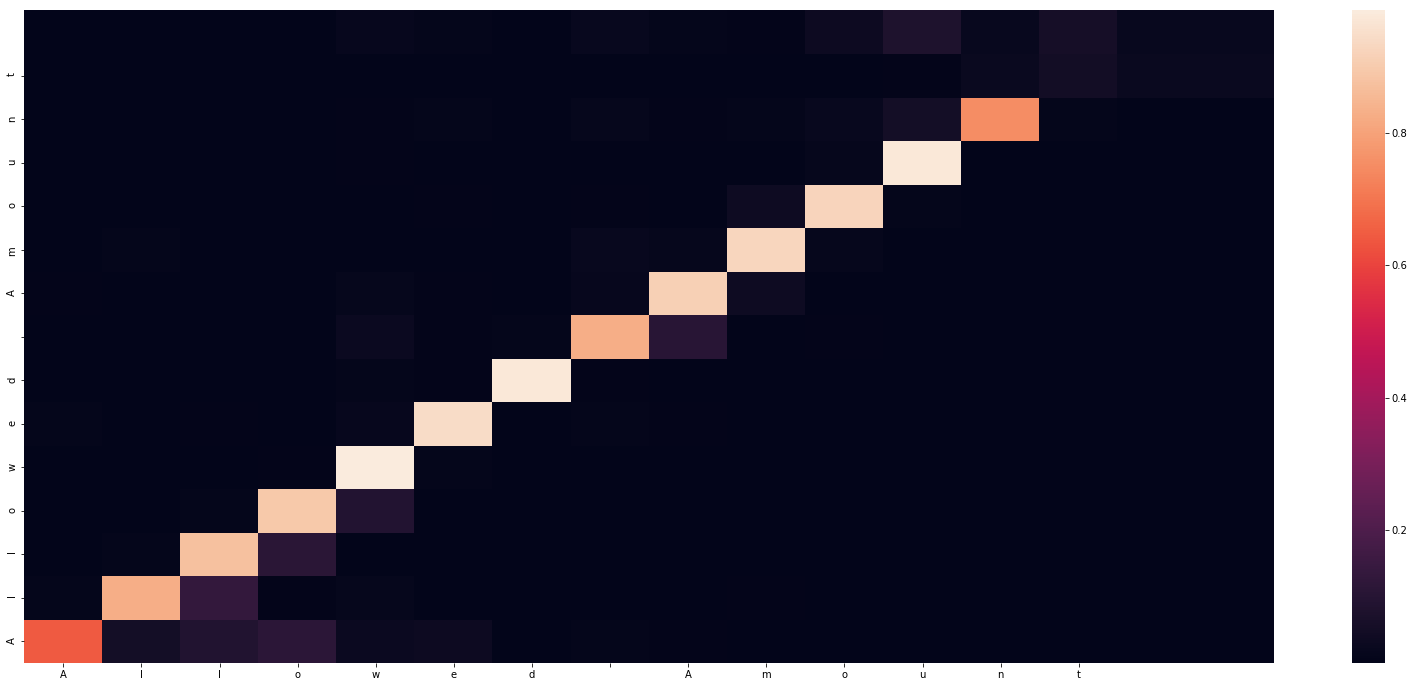

-
Input sentence: Allowed Amount
GT sentence: Allowed Amount

Decoded sentence: Allowed Amount


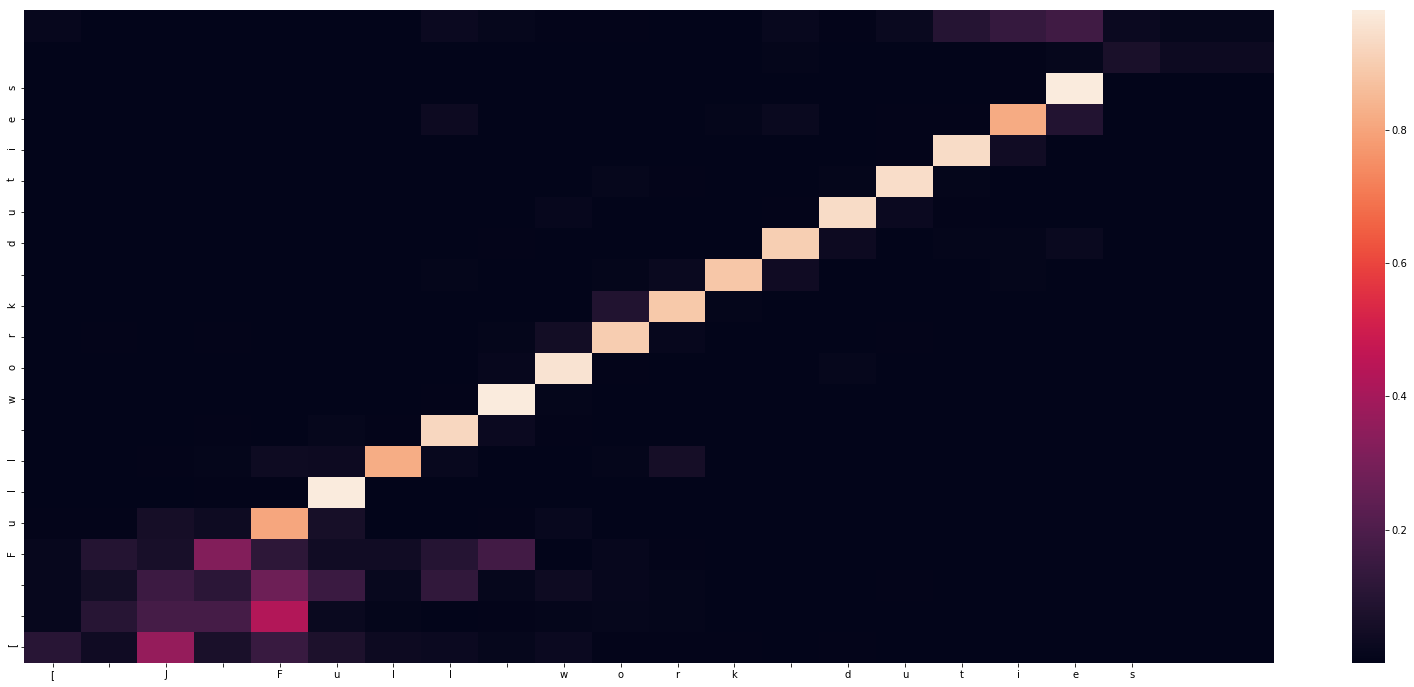

-
Input sentence: [ J Full work duties
GT sentence: [ ] Full work duties

Decoded sentence: [  Full work duties


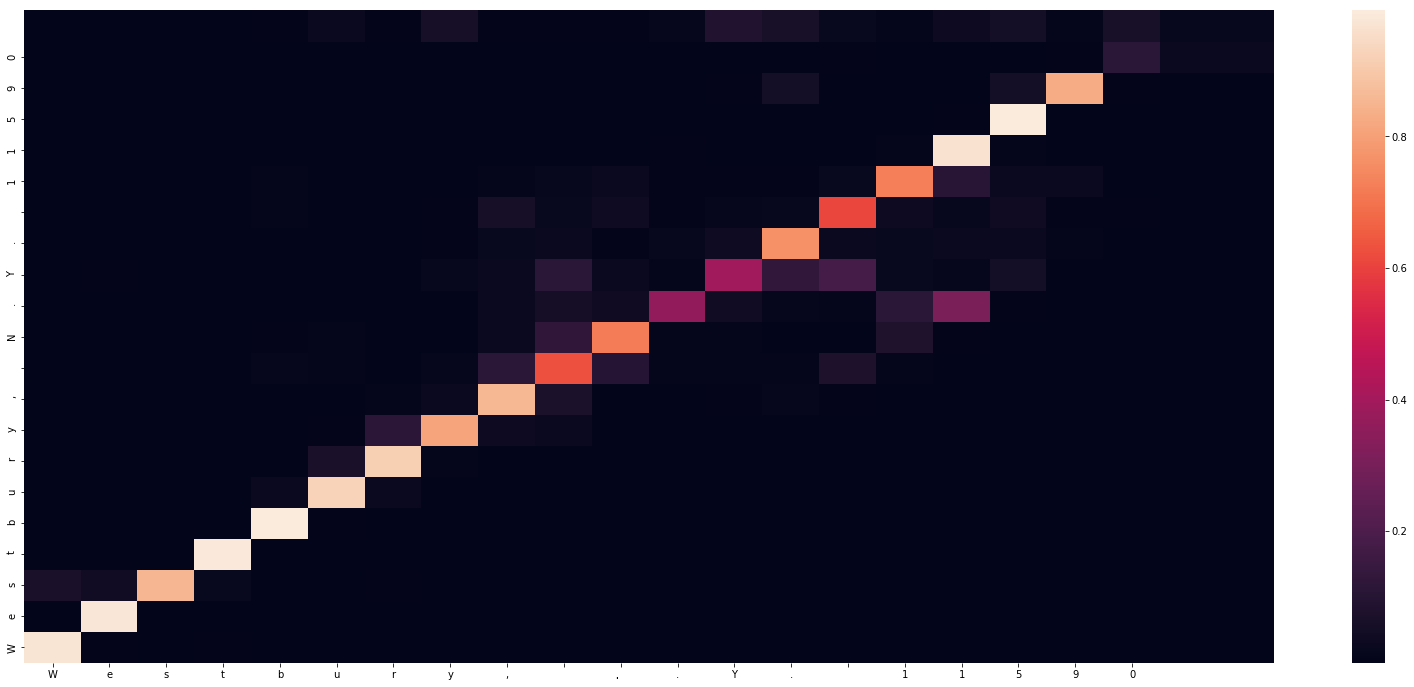

-
Input sentence: Westbury, ■.Y. 11590
GT sentence: Westbury, N.Y. 11590

Decoded sentence: Westbury, N.Y. 11590


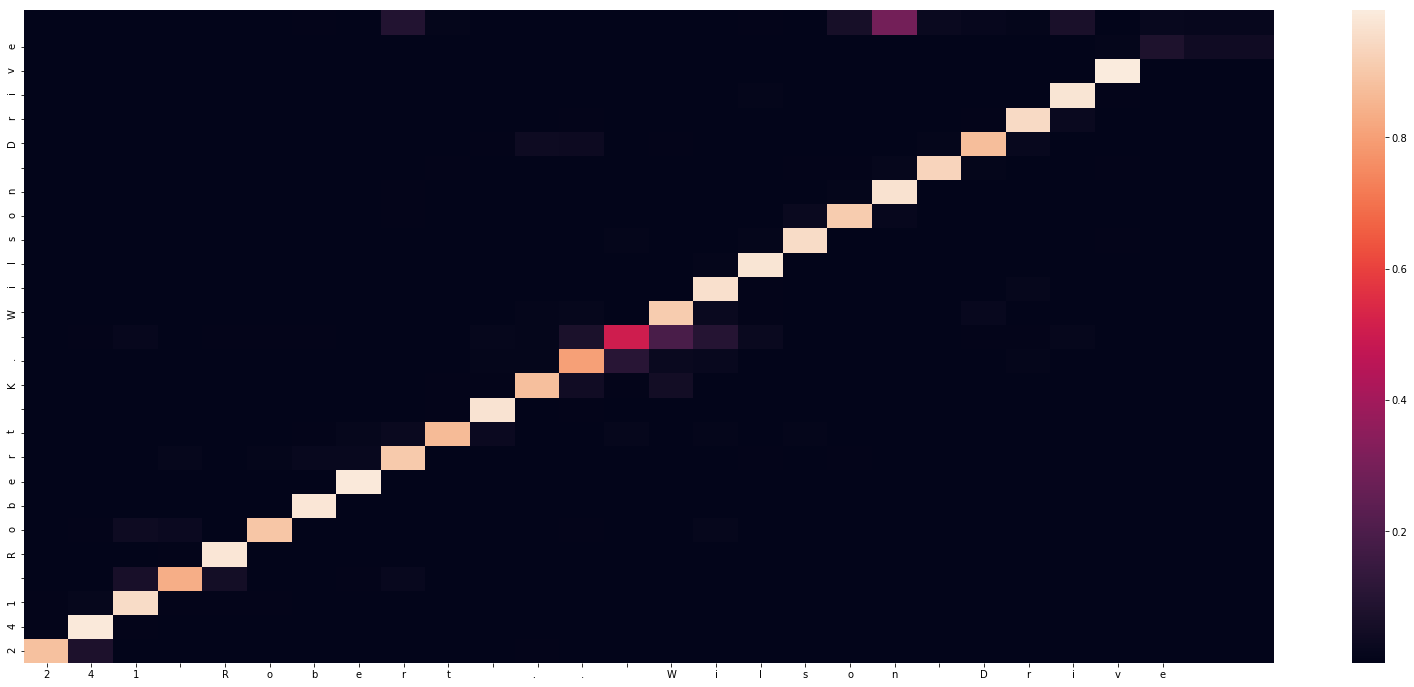

-
Input sentence: 241 Robert ☒. Wilson Drive
GT sentence: 241 Robert K. Wilson Drive

Decoded sentence: 241 Robert K. Wilson Drive


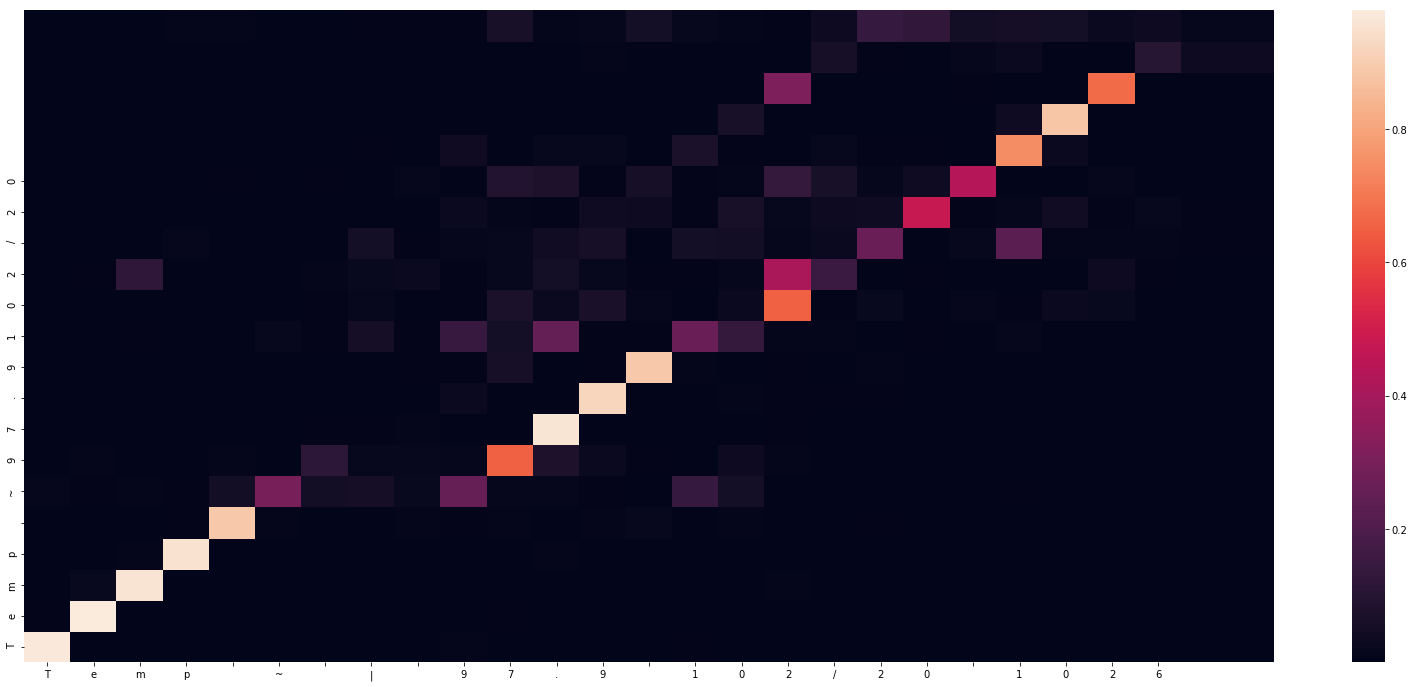

-
Input sentence: Temp ~ | 97.9 102/20 1026
GT sentence: Temp 97.9 02/20 1026

Decoded sentence: Temp ~97.9102/20


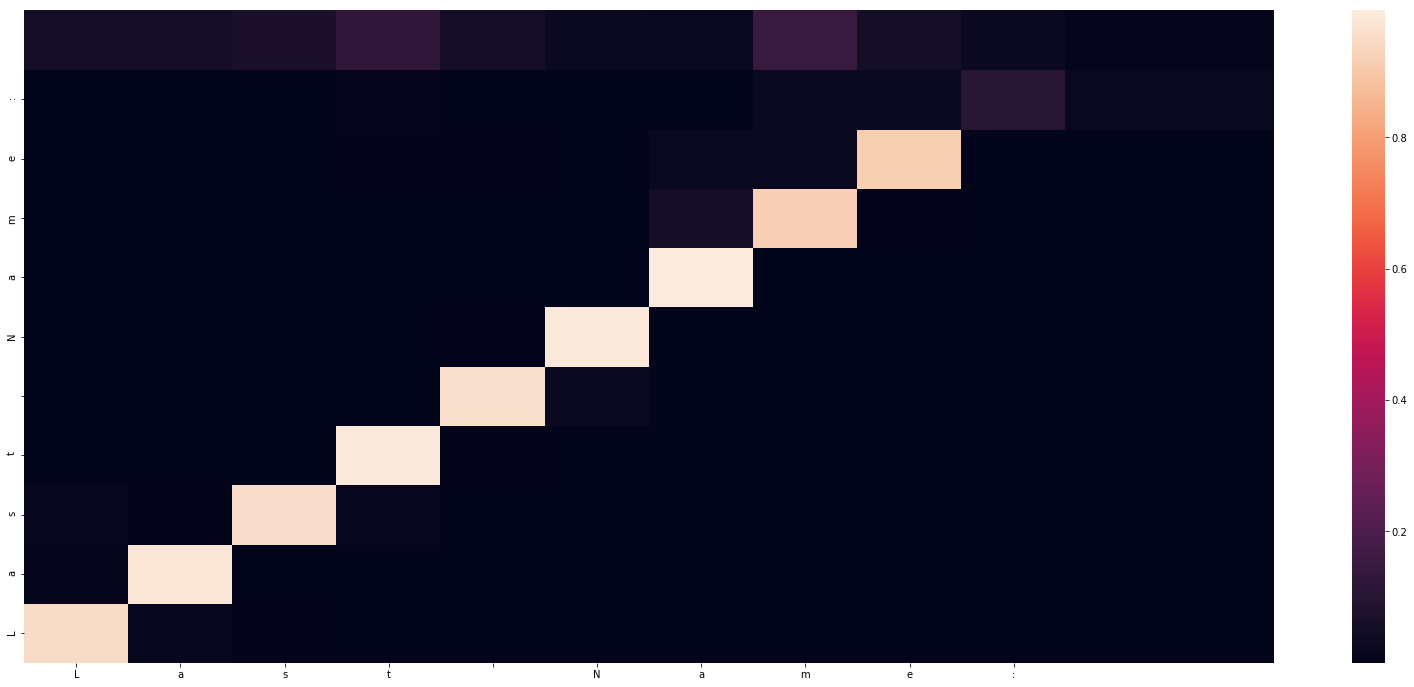

-
Input sentence: Last Name:
GT sentence: Last Name:

Decoded sentence: Last Name:


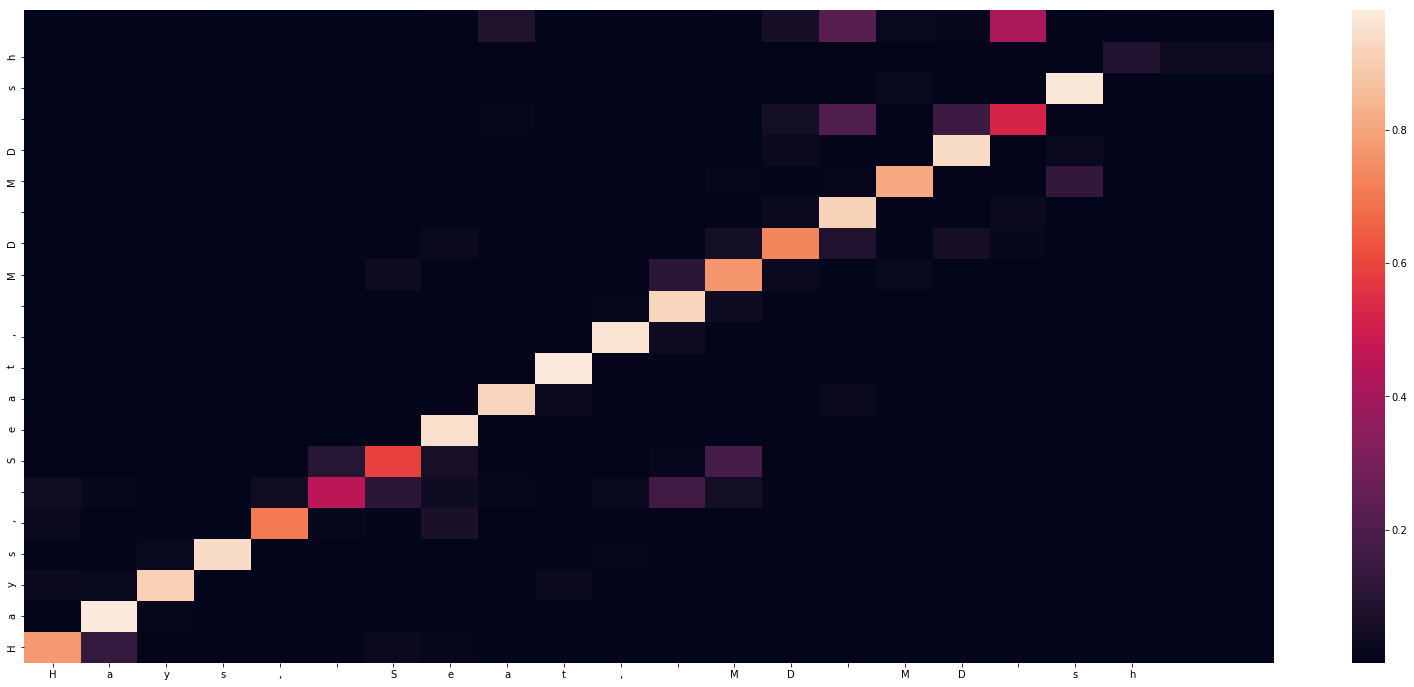

-
Input sentence: Hays, Seat, MD MD sh
GT sentence: Hays, Seat, MD MD sh

Decoded sentence: Hays, Seat, MD MD sh


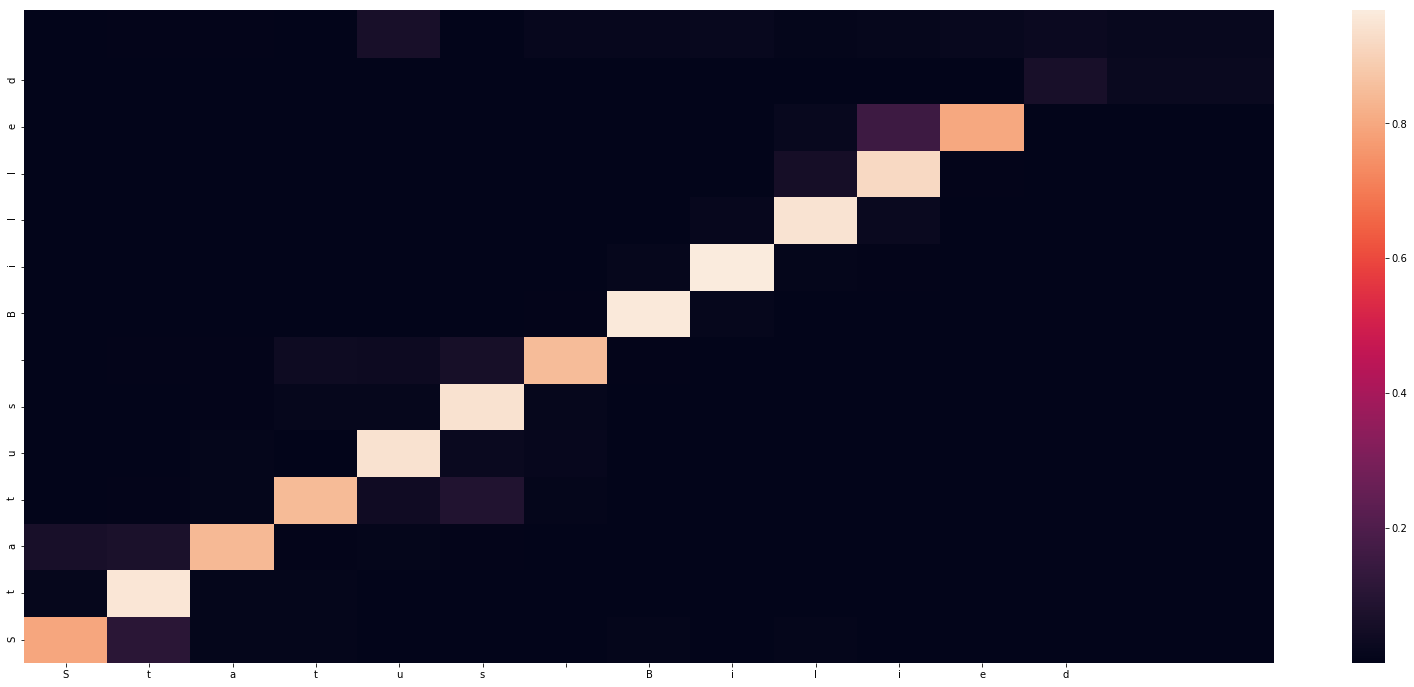

-
Input sentence: Status Bilied
GT sentence: Status Billed

Decoded sentence: Status Billed


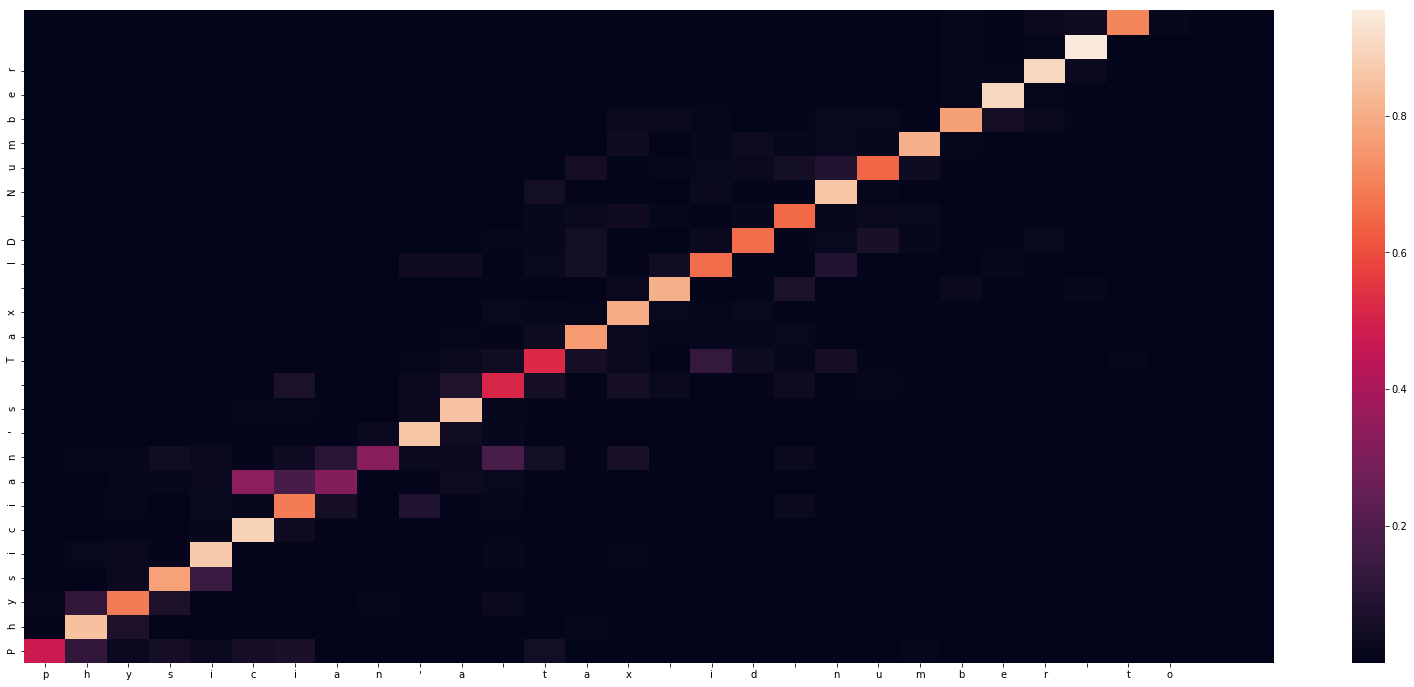

-
Input sentence: physician'a tax id number to
GT sentence: Physician's Tax ID Number:

Decoded sentence: Physician's Tax ID Number


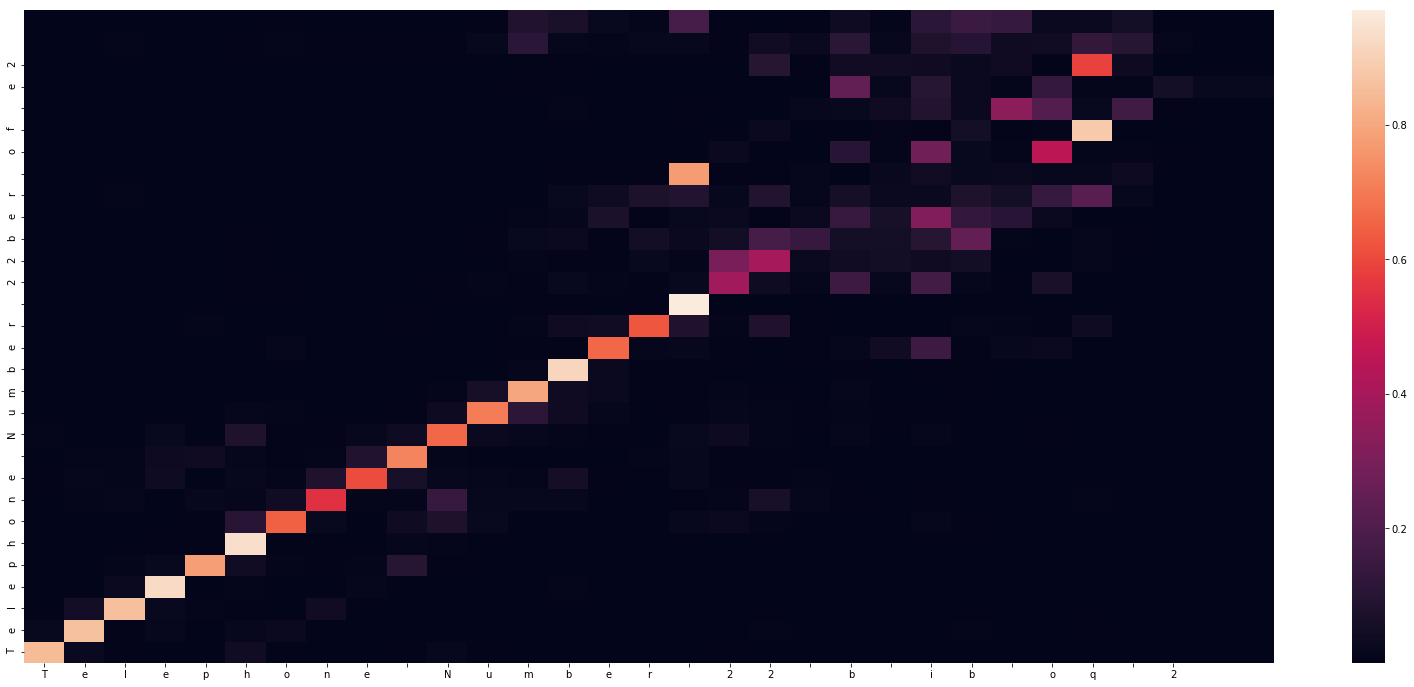

-
Input sentence: Telephone Number 22 b ib oq 2
GT sentence: Telephone Number 3367168092

Decoded sentence: Telephone Number 22ber of e2


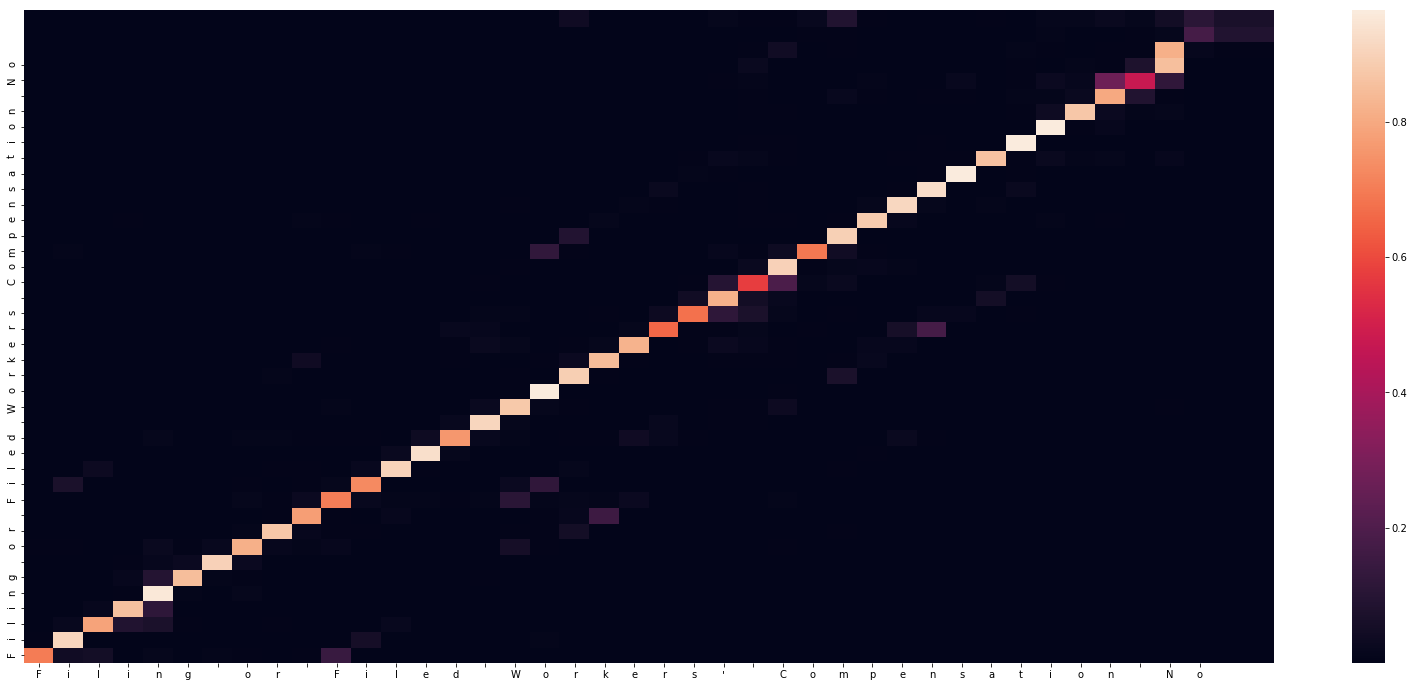

-
Input sentence: Filing or Filed Workers' Compensation No
GT sentence: Filing or Filed Workers' Compensation: No

Decoded sentence: Filing or Filed Workers Compensation No


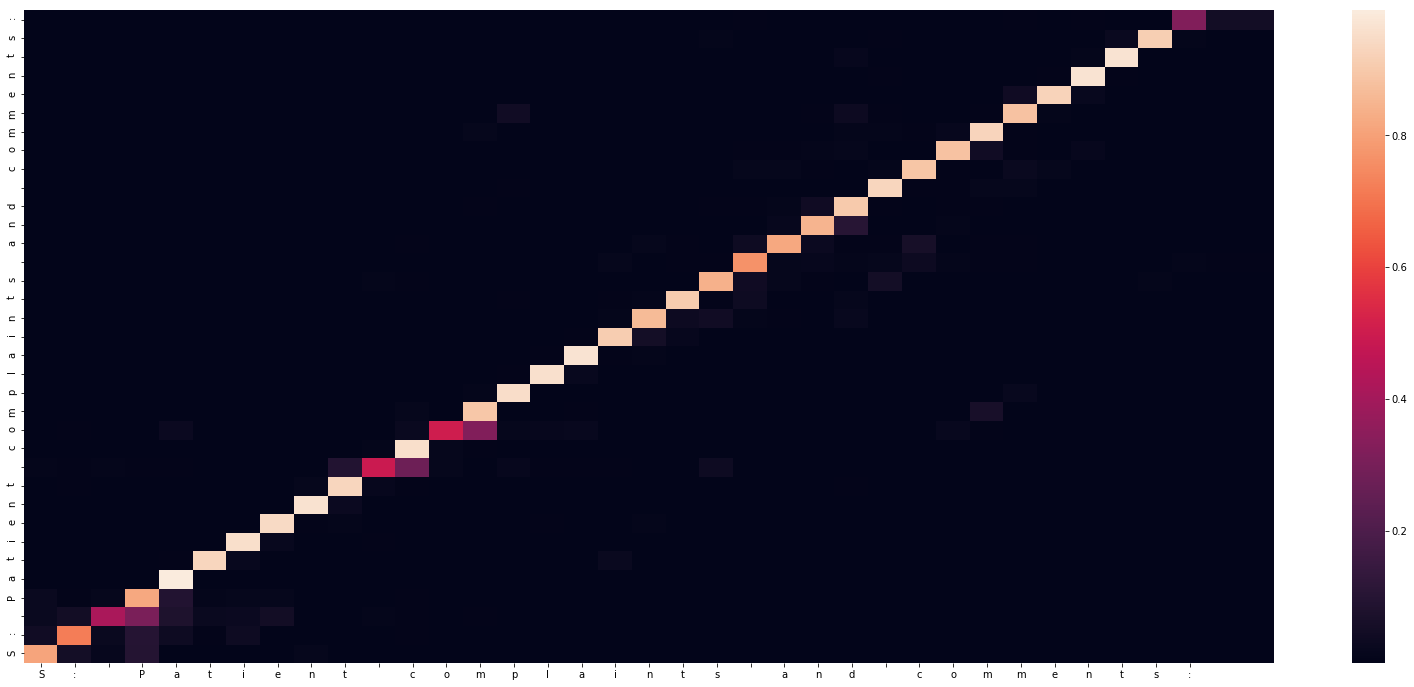

-
Input sentence: S: Patient complaints and comments:
GT sentence: S: Patient complaints and comments:

Decoded sentence: S: Patient complaints and comments:


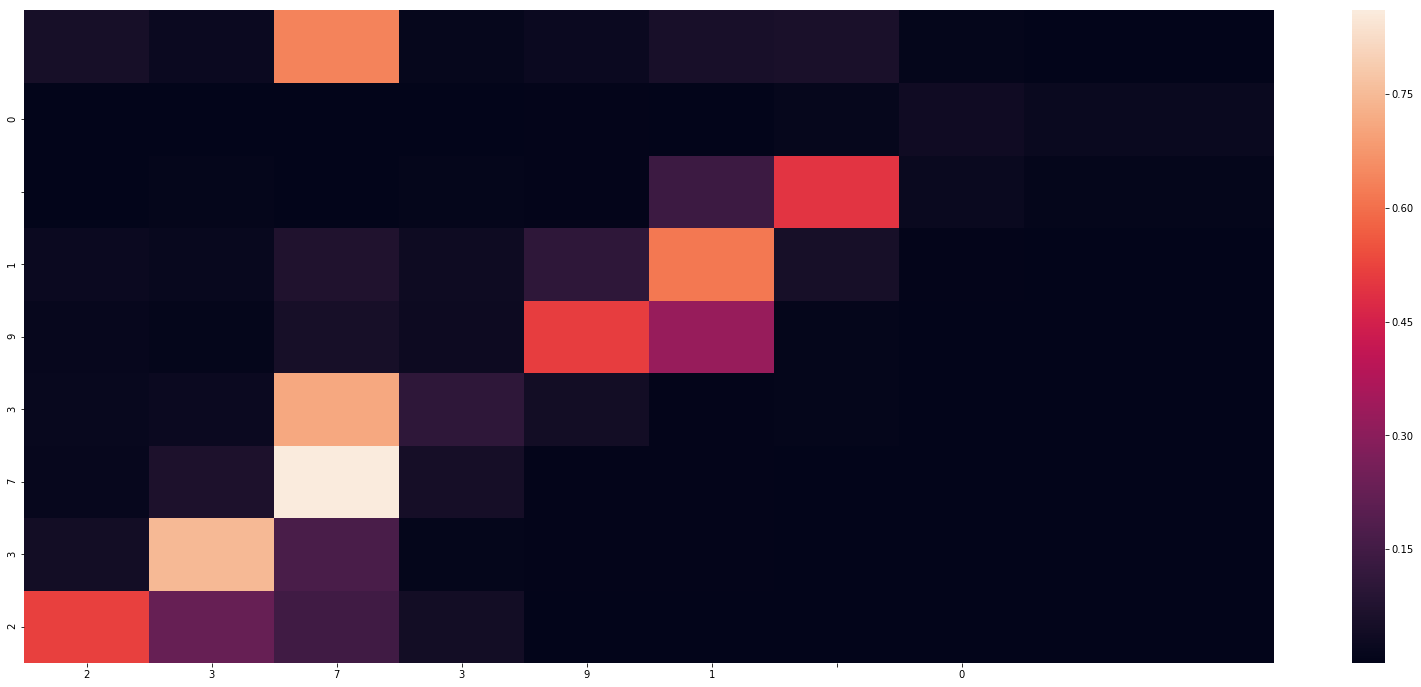

-
Input sentence: 237391 0
GT sentence: Z87891 ?

Decoded sentence: 237391 0


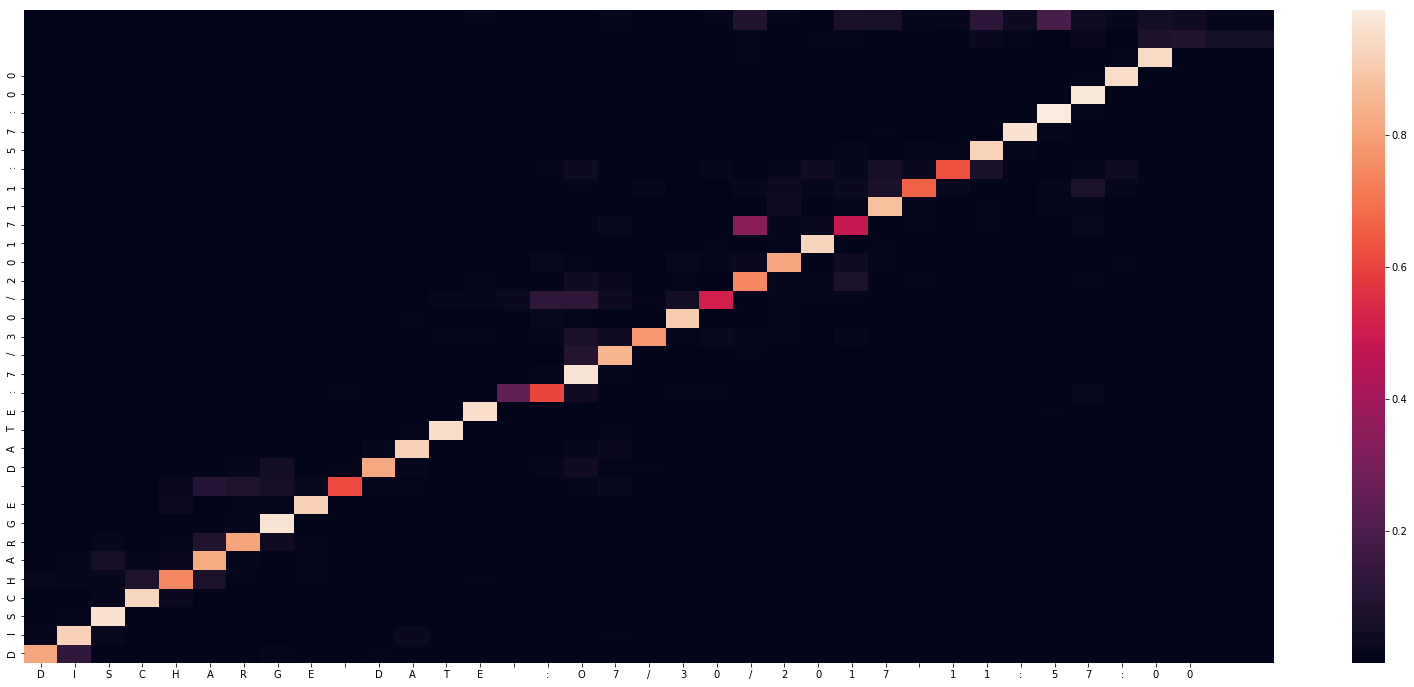

-
Input sentence: DISCHARGE DATE :O7/30/2017 11:57:00
GT sentence: DISCHARGE DATE:O7/30/2017 11:57:00

Decoded sentence: DISCHARGE DATE:7/30/201711:57:00


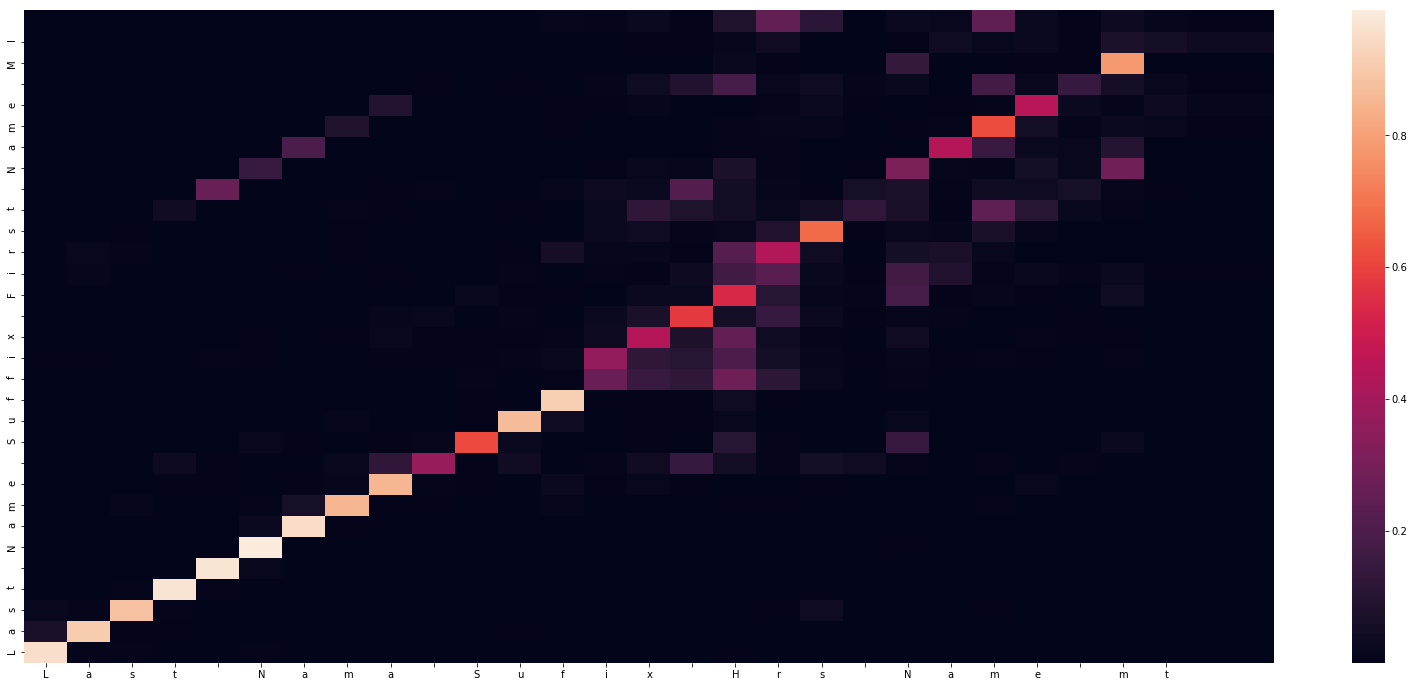

-
Input sentence: Last Nama Sufix Hrs Name mt
GT sentence: Last Name Suffix First Name MI

Decoded sentence: Last Name Suffix First Name MI


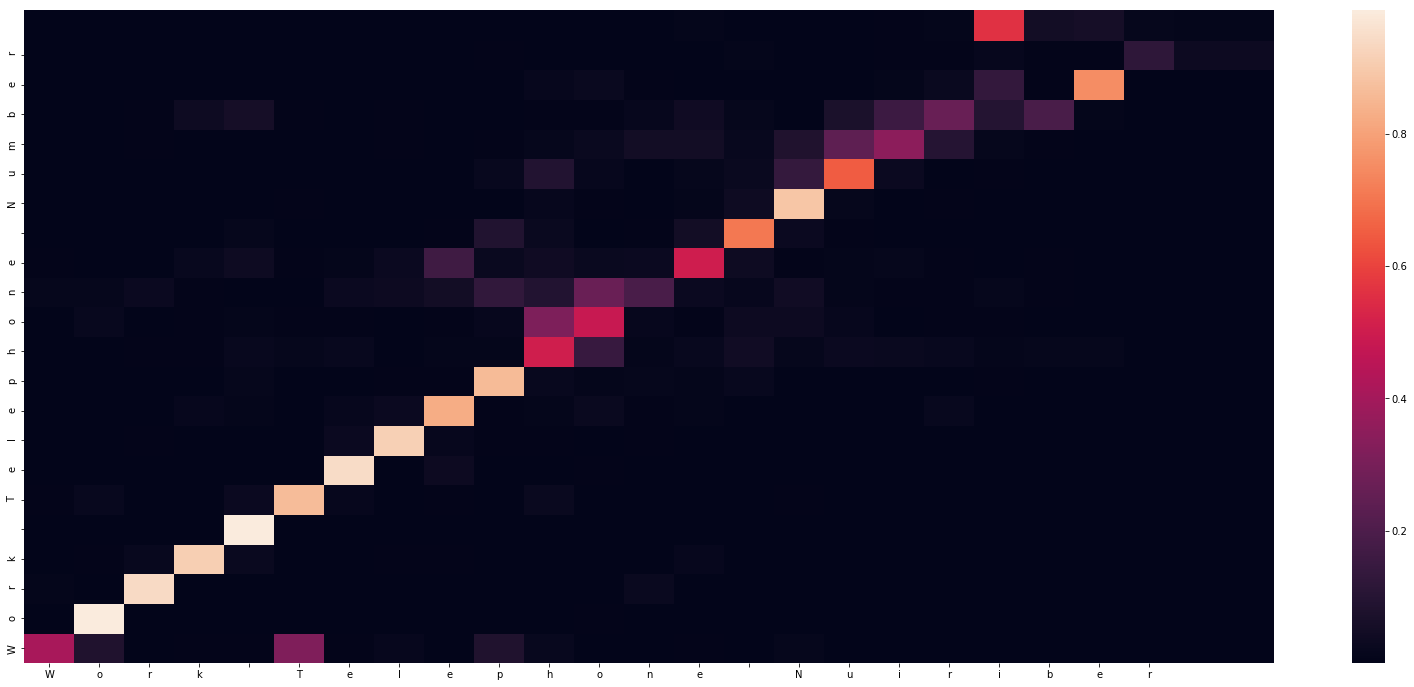

-
Input sentence: Work Telephone Nuiriber
GT sentence: Work Telephone Number

Decoded sentence: Work Telephone Number


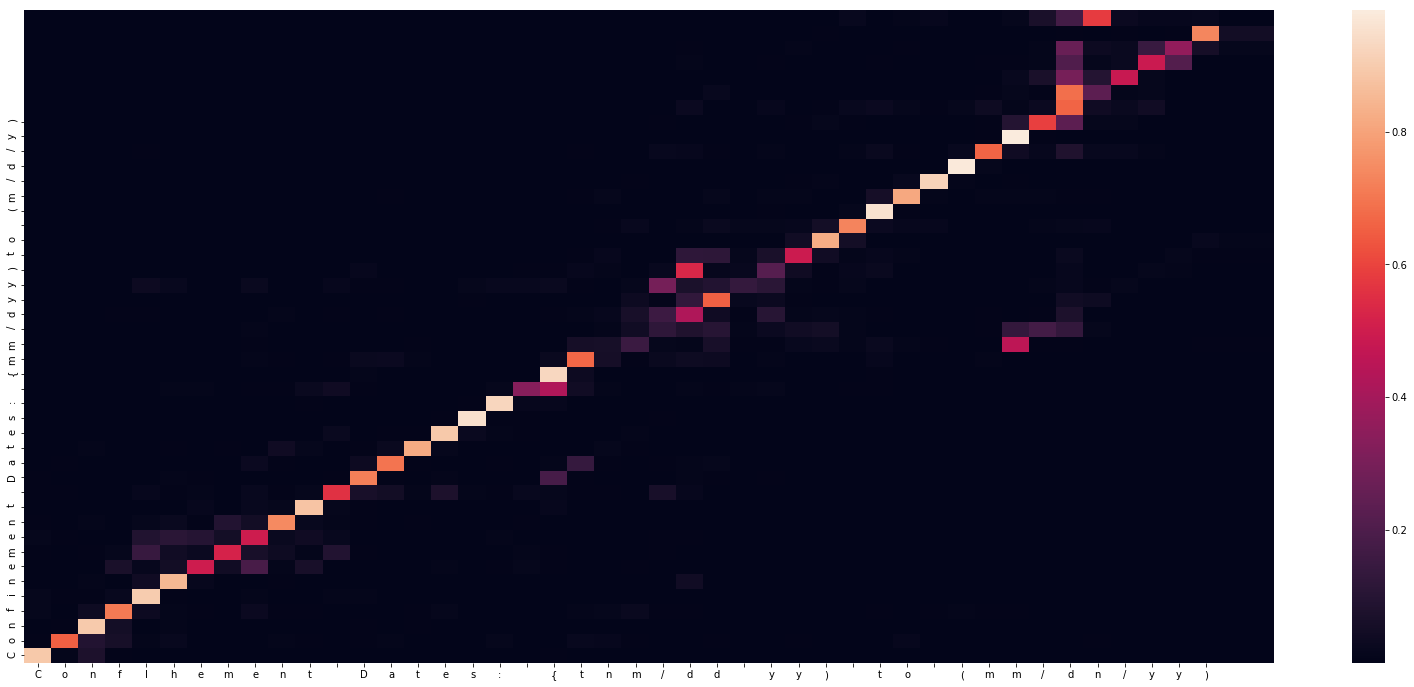

-
Input sentence: Conflhement Dates: {tnm/dd yy) to (mm/dn/yy)
GT sentence: Confinement Dates: (mm/dd/yy) to (mm/dd/yy)

Decoded sentence: Confinement Dates: {mm/dyy)to (m/d/y)


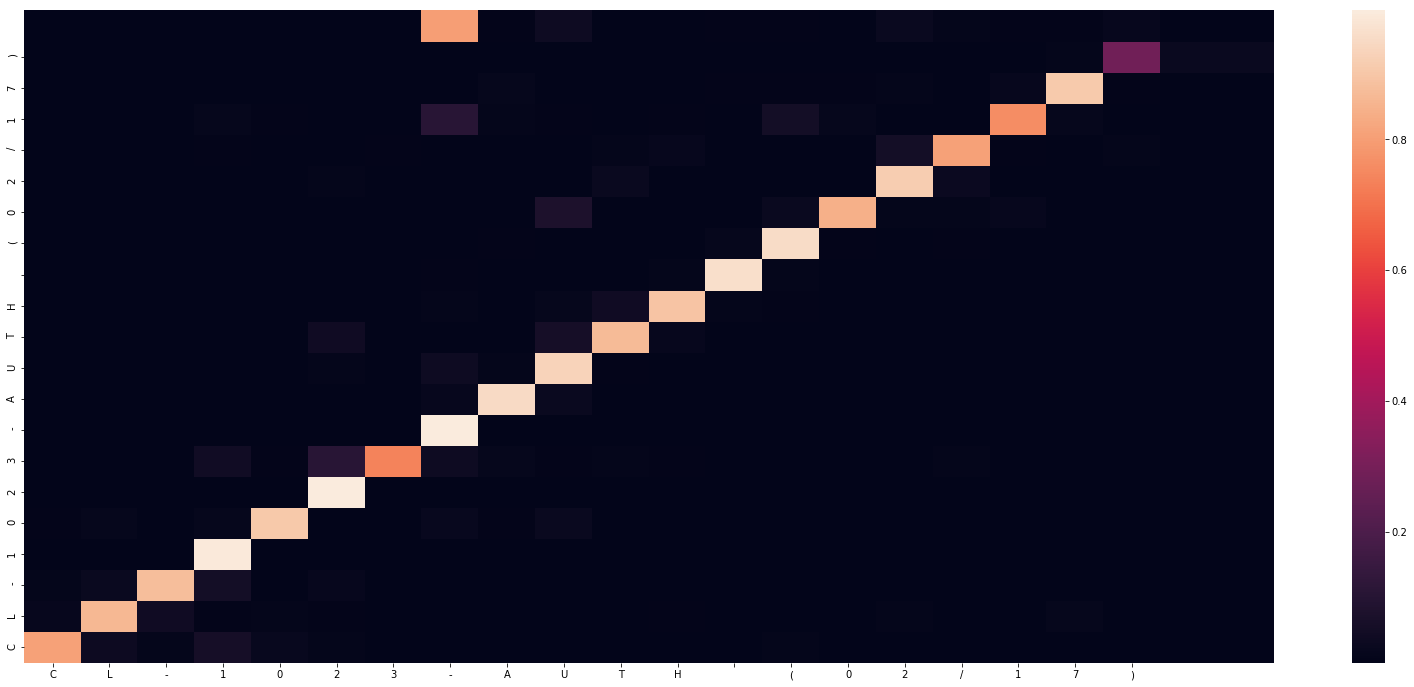

-
Input sentence: CL-1023-AUTH (02/17)
GT sentence: CL-1023-AUTH (02/17) 

Decoded sentence: CL-1023-AUTH (02/17)


In [49]:
for seq_index in range(100):

    target_text = target_texts[seq_index][1:-1]
    text = input_texts[seq_index]
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   


# Test - Short inference

In [65]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_text = test_input_texts[seq_index]
    target_text = test_target_texts[seq_index][1:-1]
    splits = split_ngrams(input_text, n=30)
    decoded_splits = []
    for split in splits:    
        encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=[split],
                                                                                     target_texts=[target_text], 
                                                                                     max_encoder_seq_length=max_encoder_seq_length, 
                                                                                     num_encoder_tokens=num_encoder_tokens, 
                                                                                     vocab_to_int=vocab_to_int)    

        input_seq = encoder_input_data
        #target_seq = np.argmax(decoder_target_data, axis=-1)
        #print(target_seq)
        decoded_split, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
        decoded_splits.append(decoded_split)
    decoded_sentence = ' '.join(decoded_splits) 
    print('-')
    print('Input sentence:', input_text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: ☐ Long Term Disability
GT sentence: ☐ Long Term Disability

Decoded sentence: ☐ Long Term Disability 
-
Input sentence: Physi Ex
GT sentence: Physical Exam

Decoded sentence: PhysicEax
-
Input sentence: :A. Continue PT/hore exercise program
GT sentence: 3. Continue PT/home exercise program

Decoded sentence: :o.tinue PTPT/T PT Fercice program
-
Input sentence: Pat Pmt
GT sentence: Pat. Pmt.

Decoded sentence: Patipnt
-
Input sentence: [ ] Full work duties
GT sentence: [ ] Full work duties

Decoded sentence: [ ] Full work duties
-
Input sentence: Customer #
GT sentence: Customer #

Decoded sentence: Customer #
-
Input sentence: (Name / Relationship)
GT sentence: (Name / Relationship)

Decoded sentence: (Name / Relationship)
-
Input sentence: MyDCH Patlent Portal Info,
GT sentence: MyDCH Patient Portal Info,

Decoded sentence: MyDCH Patient Portal Info,
-
Input sentence: E11113] arm en t In formation
GT sentence: Employment Information

Decoded sentence: E11113]ent Info

-
Input sentence: » Pain in thoracic spine
GT sentence: • Pain in thoracic spine

Decoded sentence: * Pain in thoracic spine
-
Input sentence: Insured’s Sigigture
GT sentence: Insured’s Signature

Decoded sentence: Insured’s Signature
-
Input sentence: Dhe Diagnoj
GT sentence: Primary Diagnosis: 

Decoded sentence: Dhe Diagnolis
-
Input sentence: Cottinetnent Pales:mmidd/yy) to (mmidd/yy} _
GT sentence: Confinement Dates:(mm/dd/yy) to (mm/dd/yy)

Decoded sentence: Coftinetnent Pale:
-
Input sentence: C mm’rry',
GT sentence: Country:

Decoded sentence: Countrr
-
Input sentence: S lute riProx-inee:
GT sentence: State/Province:

Decoded sentence: Ste riprox-:
-
Input sentence: Medication Disposal
GT sentence: Medication Disposal

Decoded sentence: Medication Disposal
-
Input sentence: » swelling of eyelids, throat, lips
GT sentence: • swelling of eyelids, throat, lips

Decoded sentence: * Swelling of eyelids, throat, lips
-
Input sentence: Best time to call? Anytime
GT sentence: Best time

In [66]:
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_spell_correction |TEST=  0.0797005724351


In [67]:
WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)

WER_OCR |TEST=  0.0823425803611


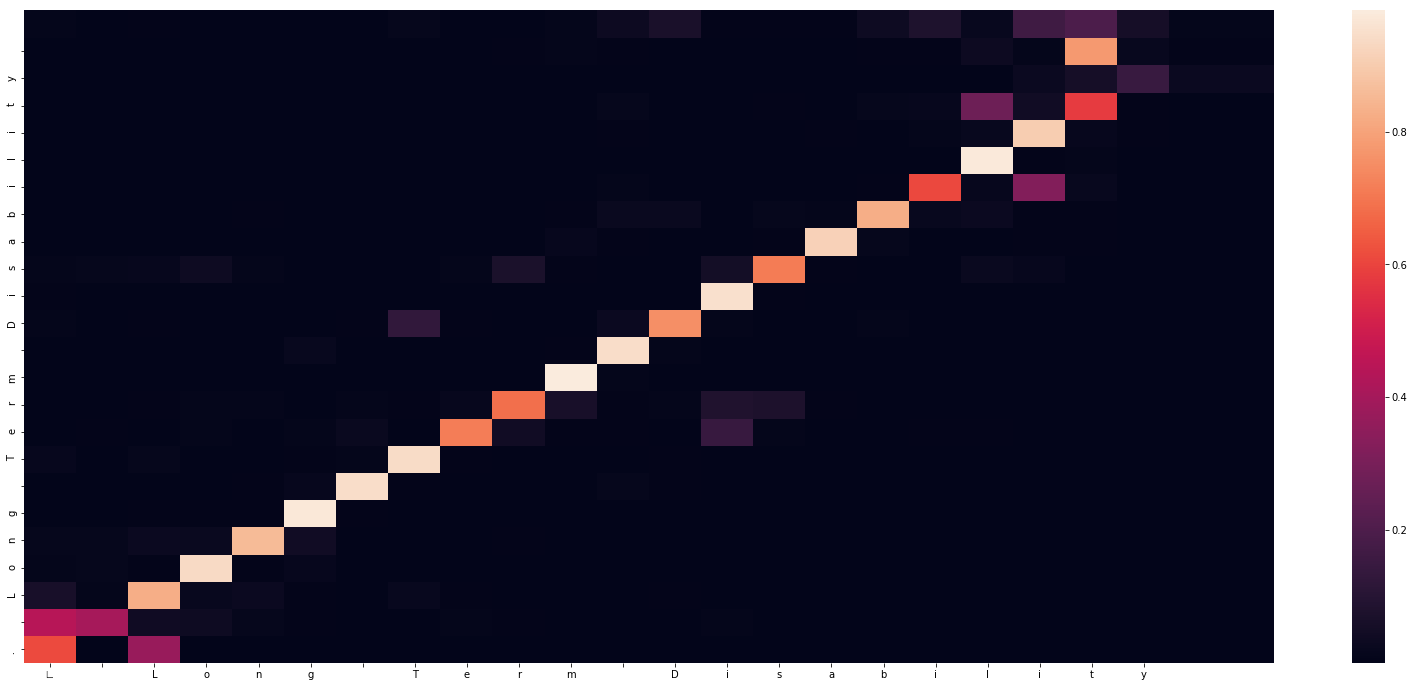

-
Input sentence: ☐ Long Term Disability
GT sentence: ☐ Long Term Disability

Decoded sentence: ☐ Long Term Disability 


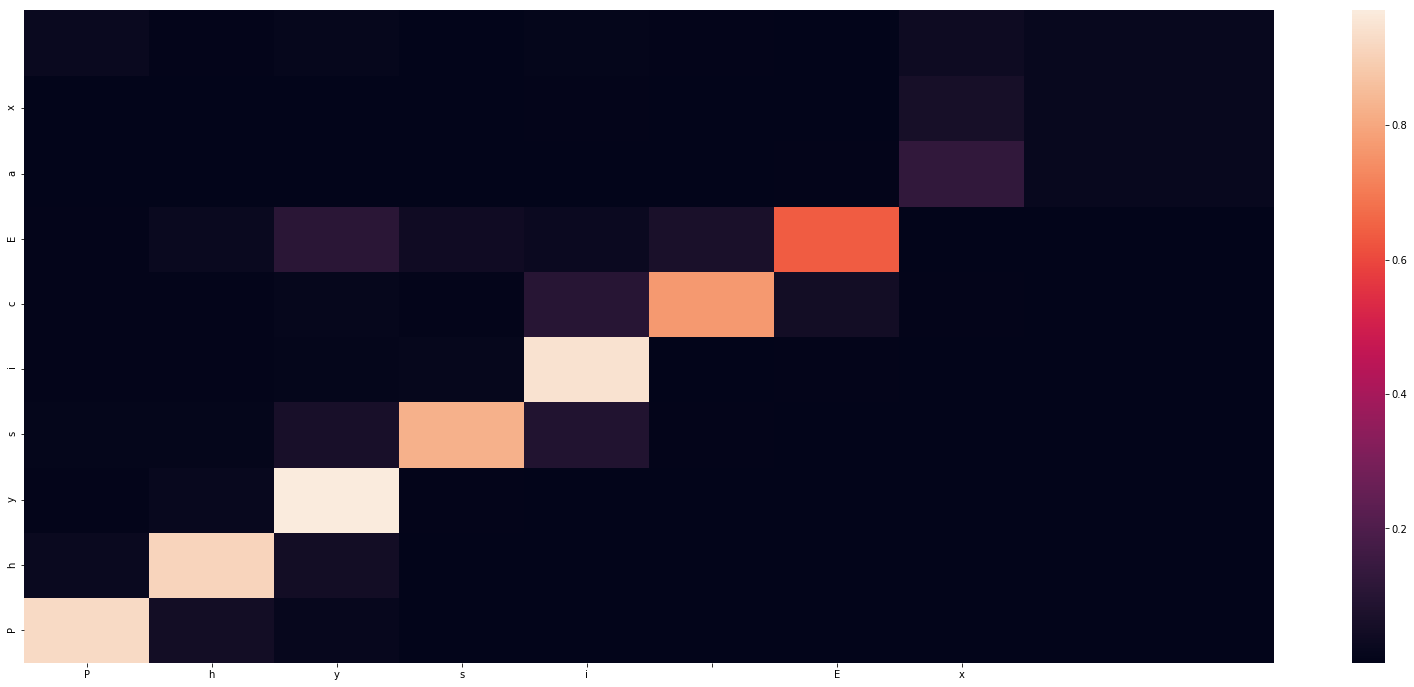

-
Input sentence: Physi Ex
GT sentence: Physical Exam

Decoded sentence: PhysicEax


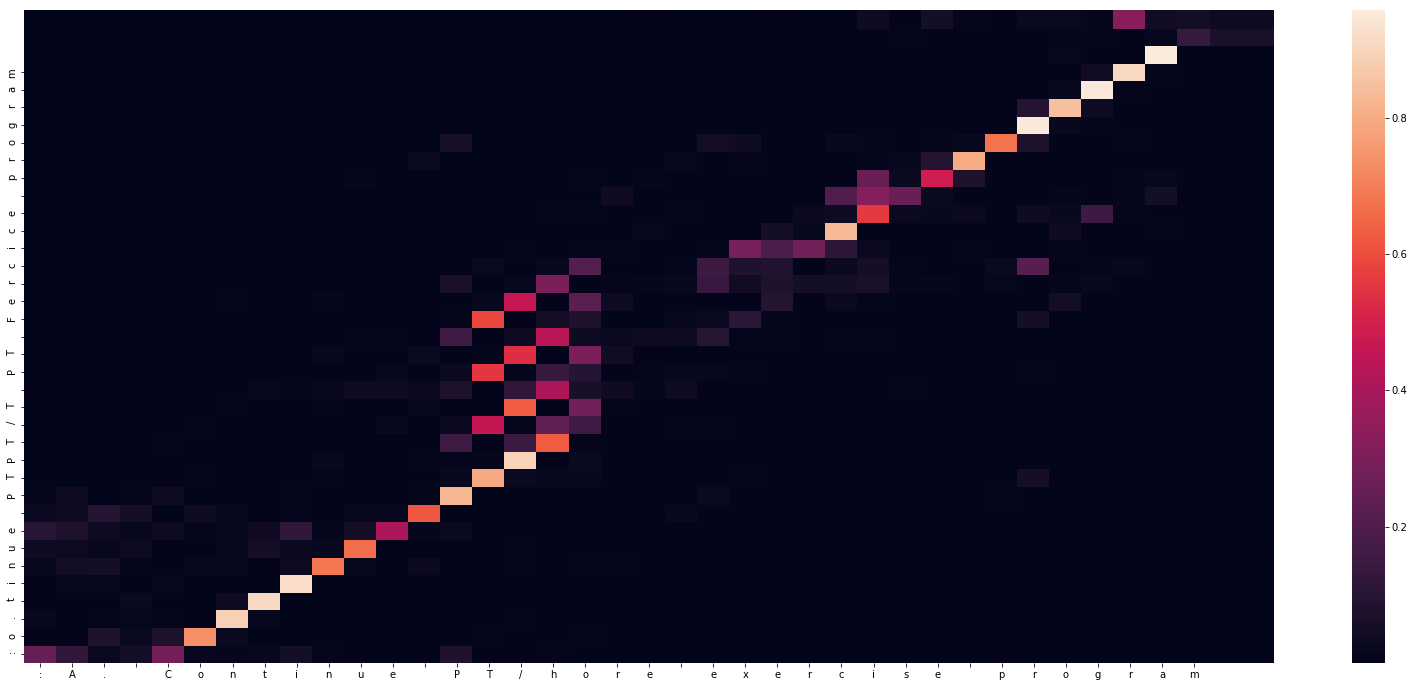

-
Input sentence: :A. Continue PT/hore exercise program
GT sentence: 3. Continue PT/home exercise program

Decoded sentence: :o.tinue PTPT/T PT Fercice program


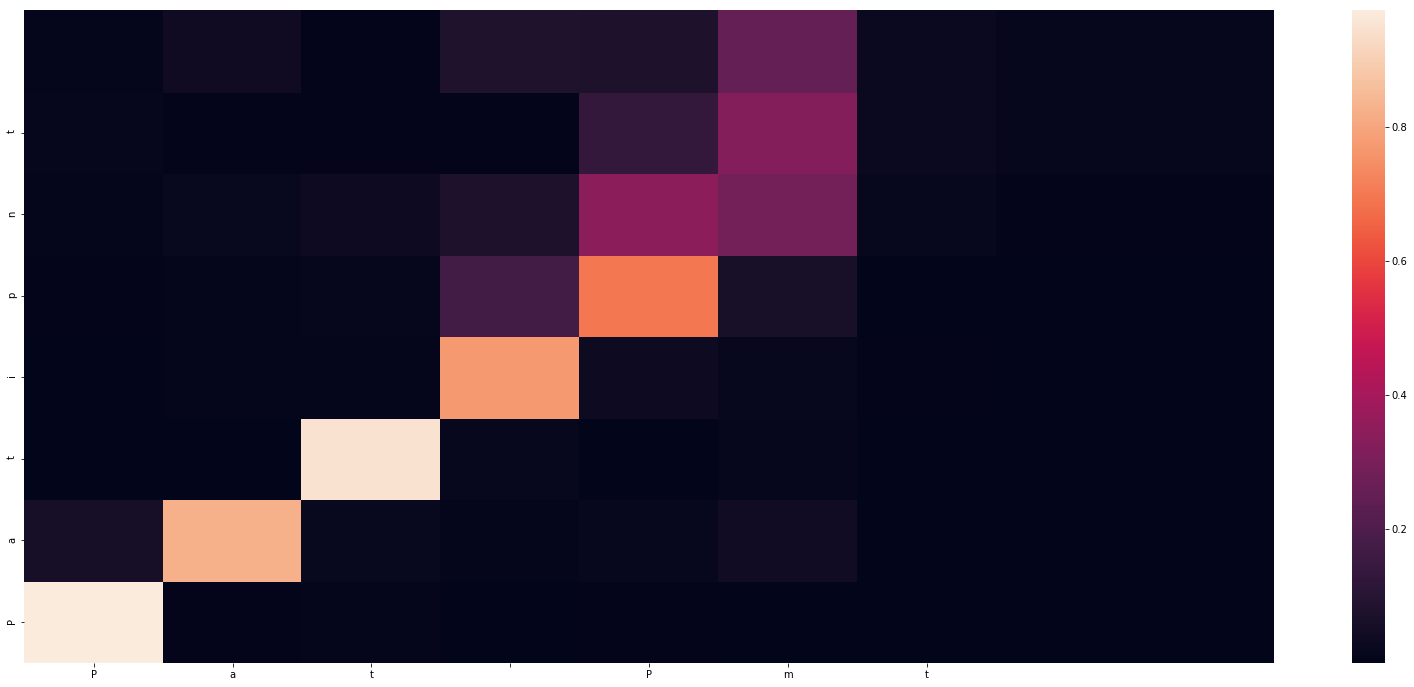

-
Input sentence: Pat Pmt
GT sentence: Pat. Pmt.

Decoded sentence: Patipnt


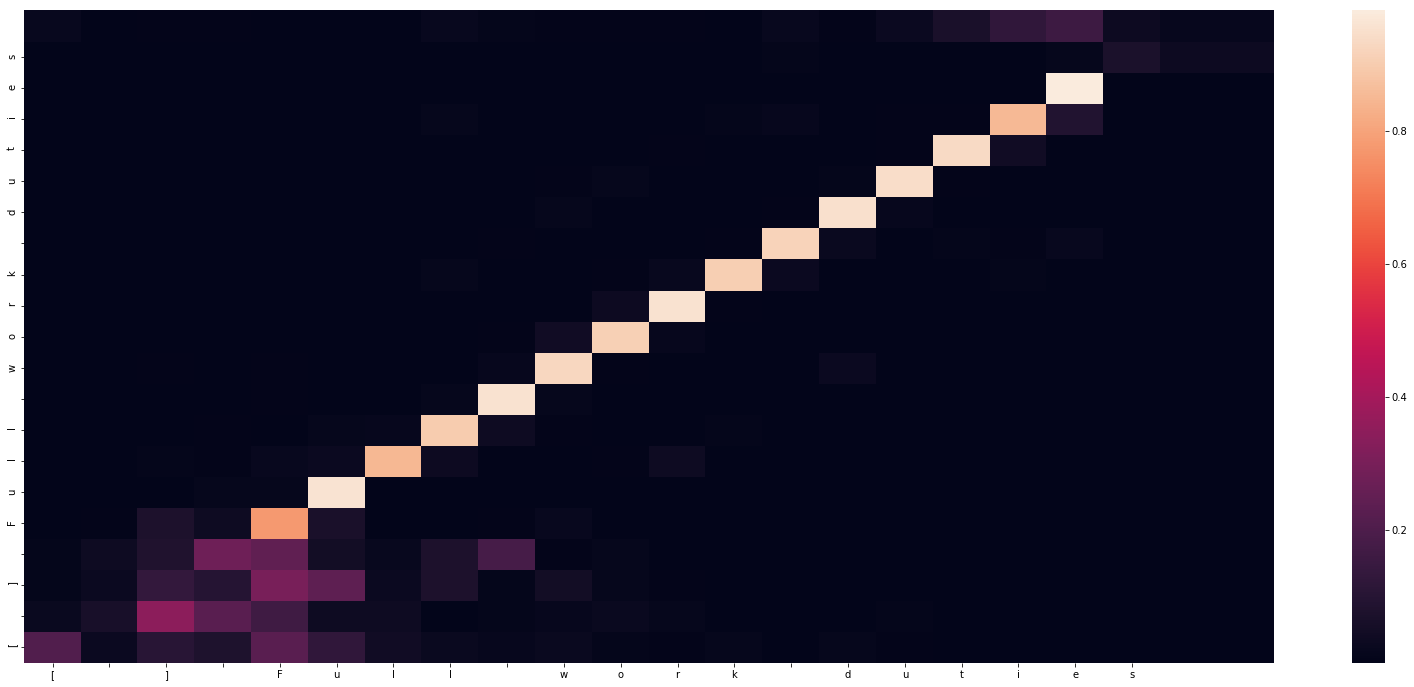

-
Input sentence: [ ] Full work duties
GT sentence: [ ] Full work duties

Decoded sentence: [ ] Full work duties


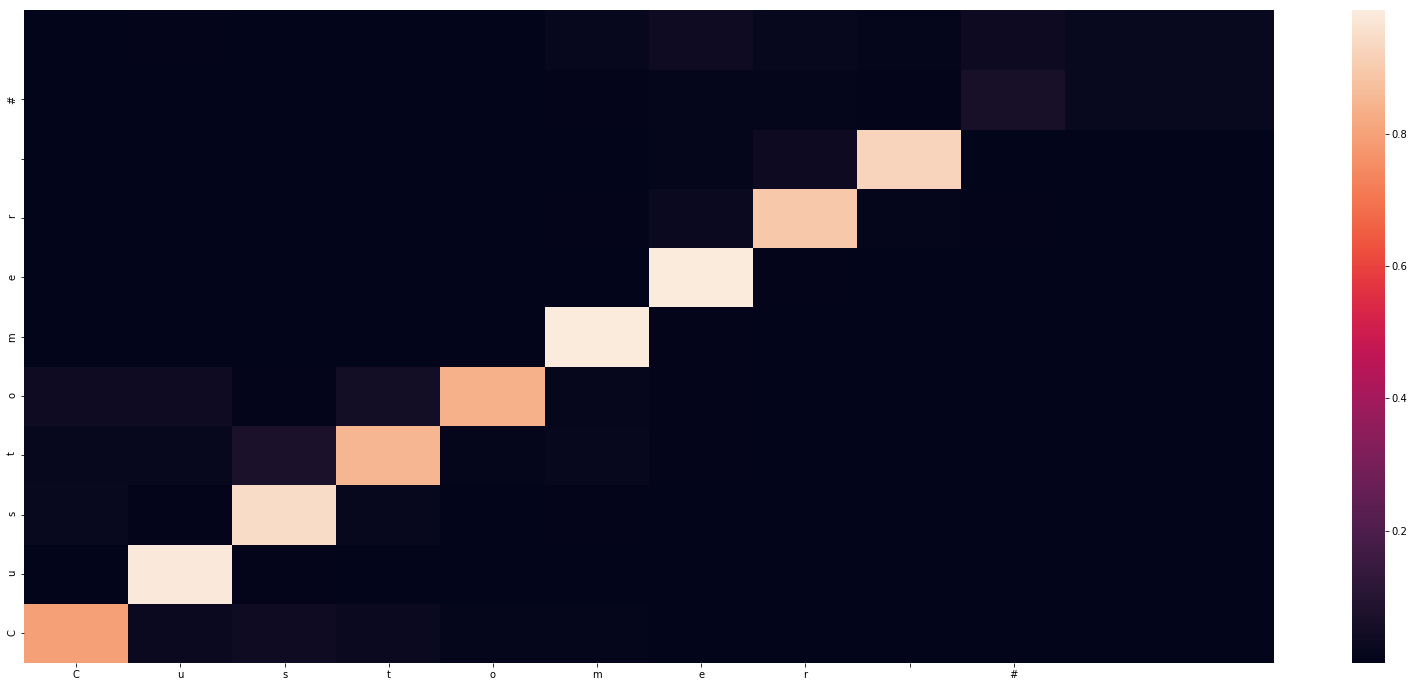

-
Input sentence: Customer #
GT sentence: Customer #

Decoded sentence: Customer #


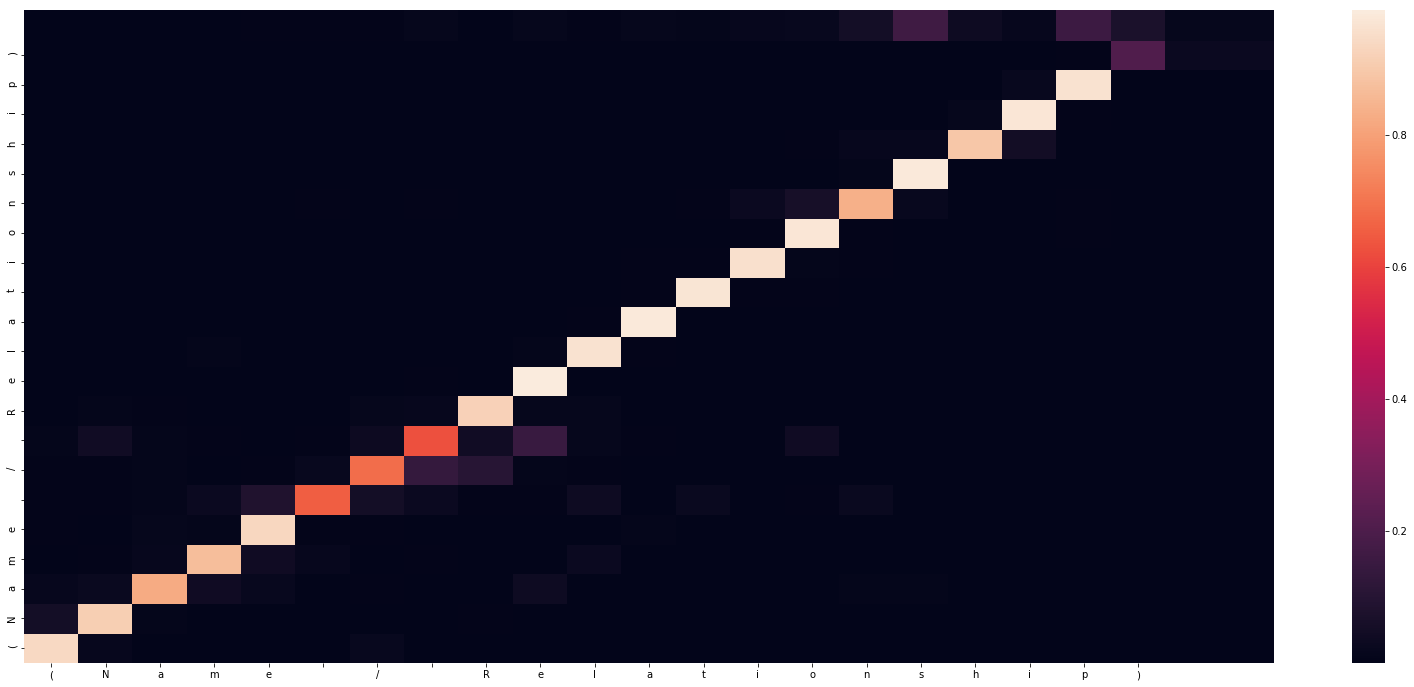

-
Input sentence: (Name / Relationship)
GT sentence: (Name / Relationship)

Decoded sentence: (Name / Relationship)


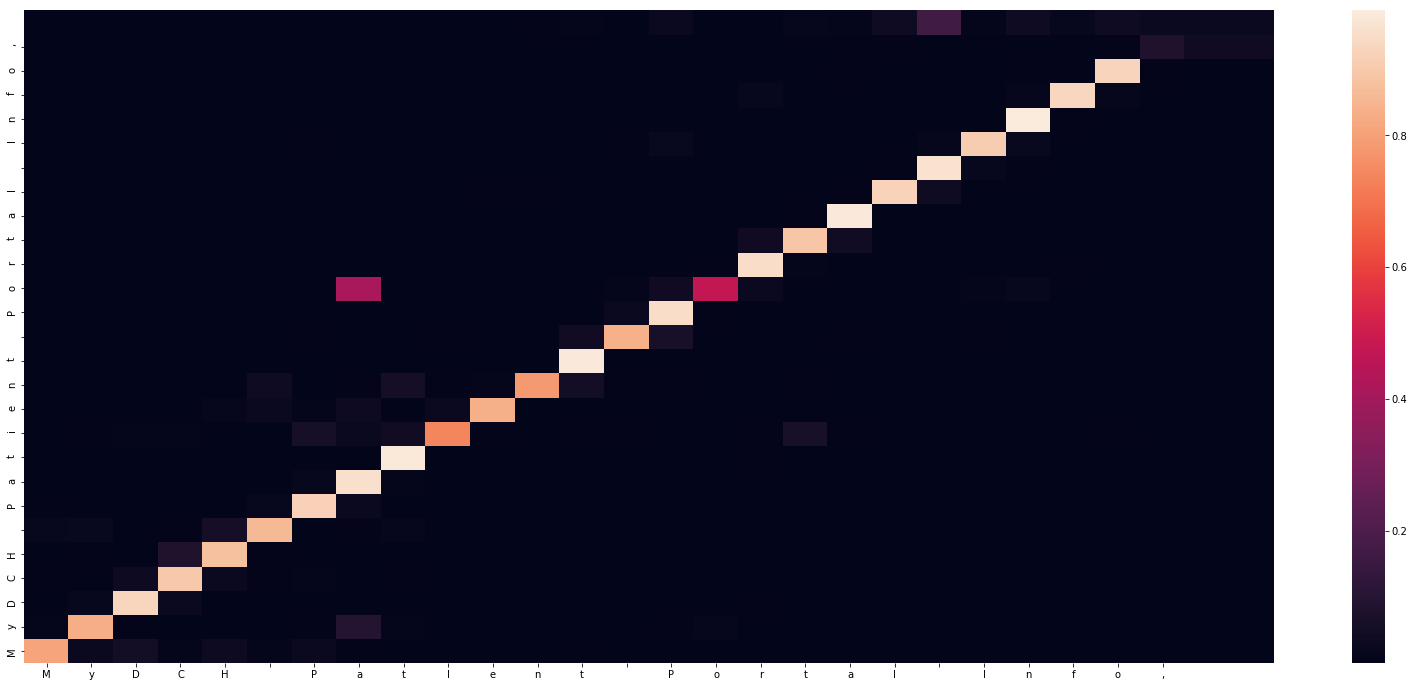

-
Input sentence: MyDCH Patlent Portal Info,
GT sentence: MyDCH Patient Portal Info,

Decoded sentence: MyDCH Patient Portal Info,


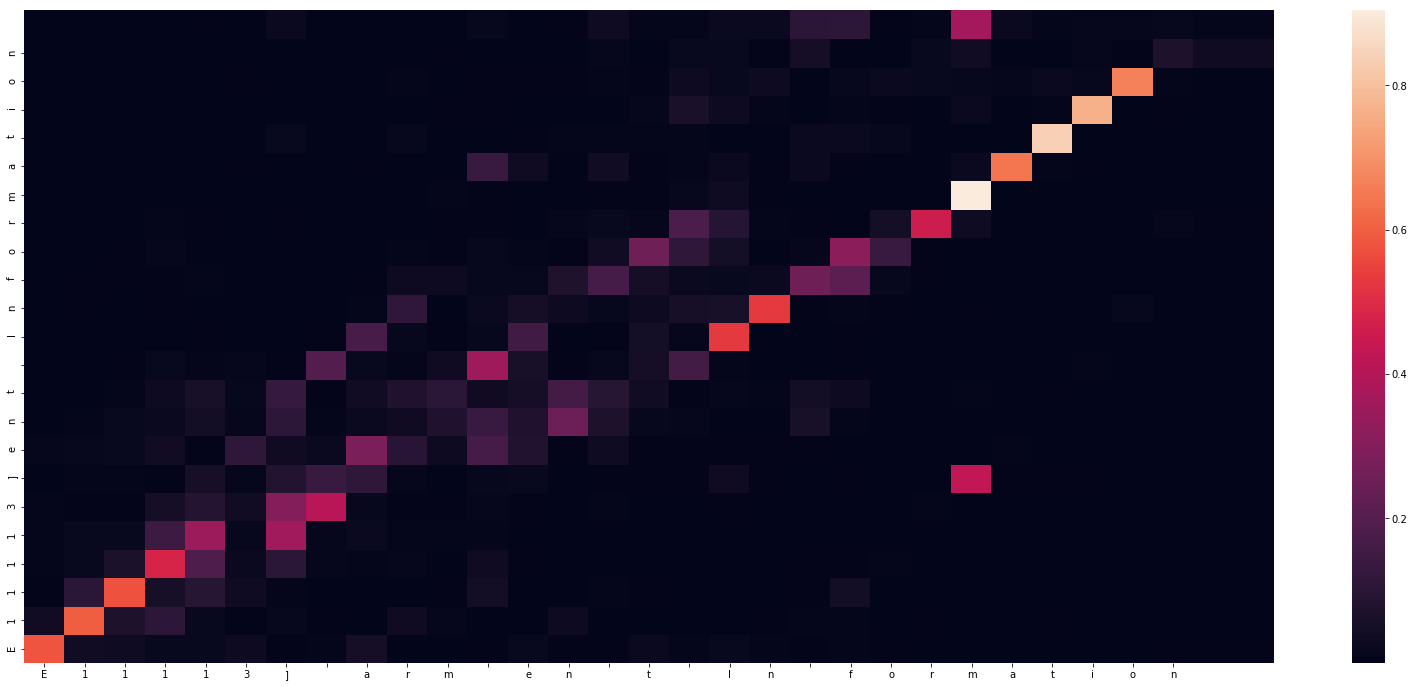

-
Input sentence: E11113] arm en t In formation
GT sentence: Employment Information

Decoded sentence: E11113]ent Information


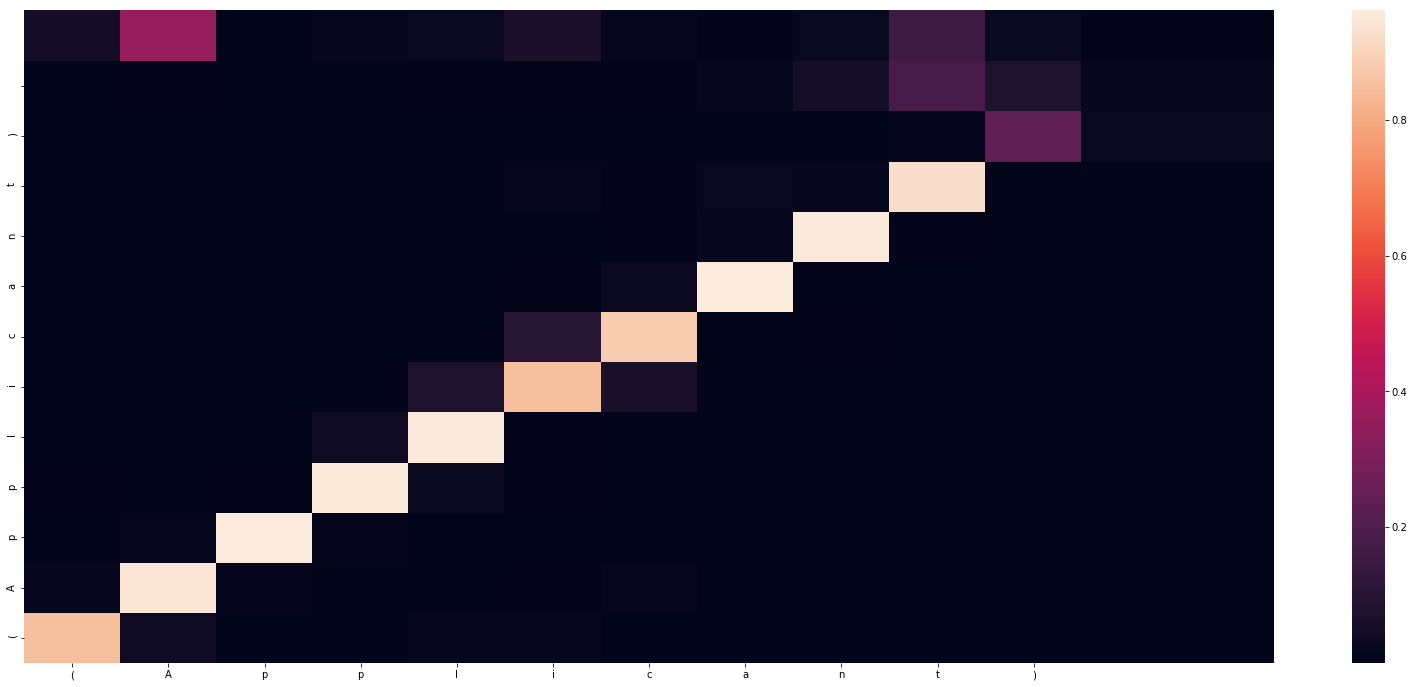

-
Input sentence: (Applicant)
GT sentence: (Applicant)

Decoded sentence: (Applicant) 


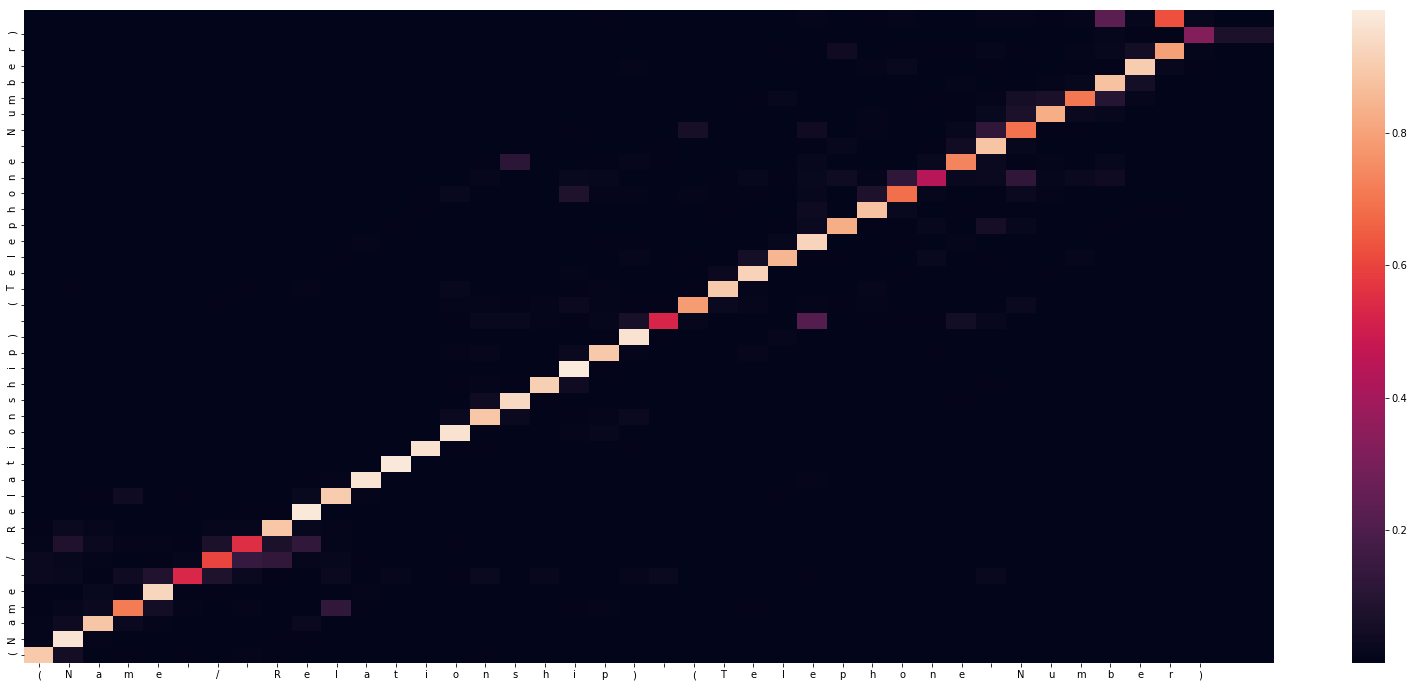

-
Input sentence: (Name / Relationship) (Telephone Number)
GT sentence: (Name / Relationship) (Telephone Number)

Decoded sentence: (Name / Relationship) (Telephone Number)


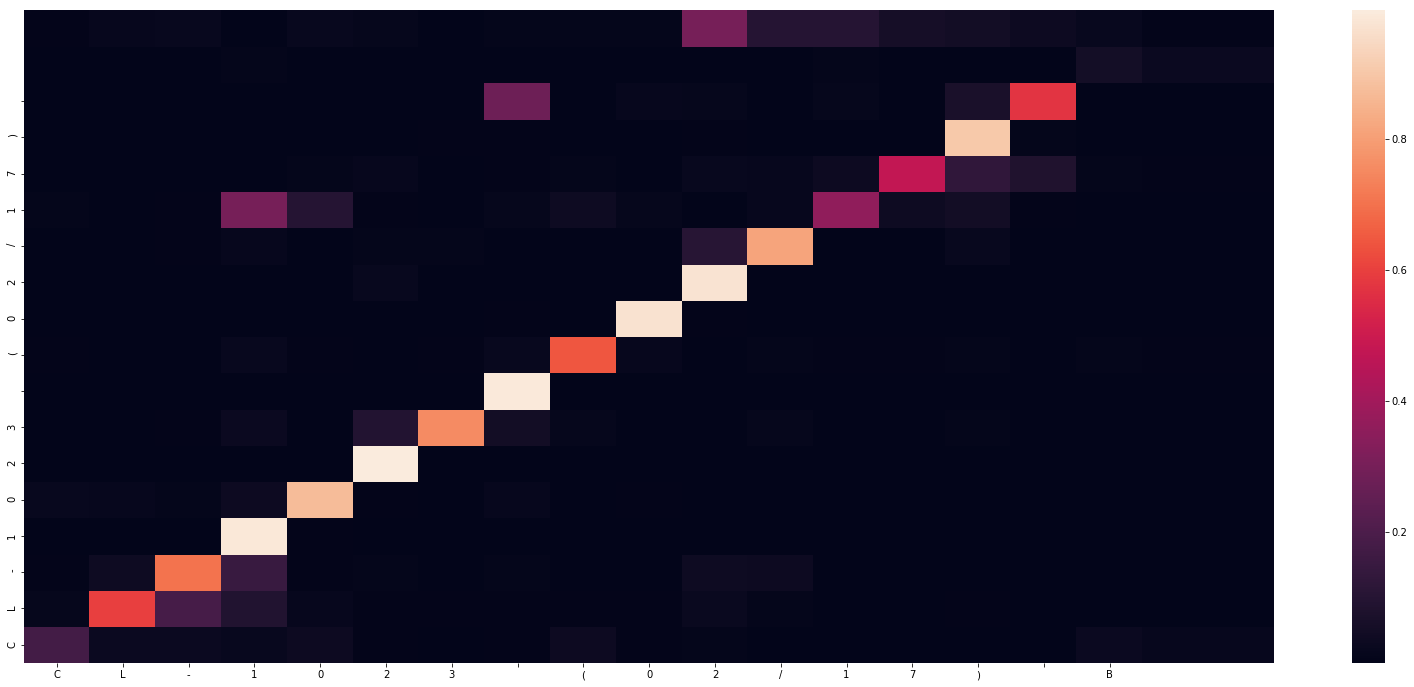

-
Input sentence: CL-1023 (02/17) B
GT sentence: CL-1023 (02/17) 5

Decoded sentence: CL-1023 (02/17) 


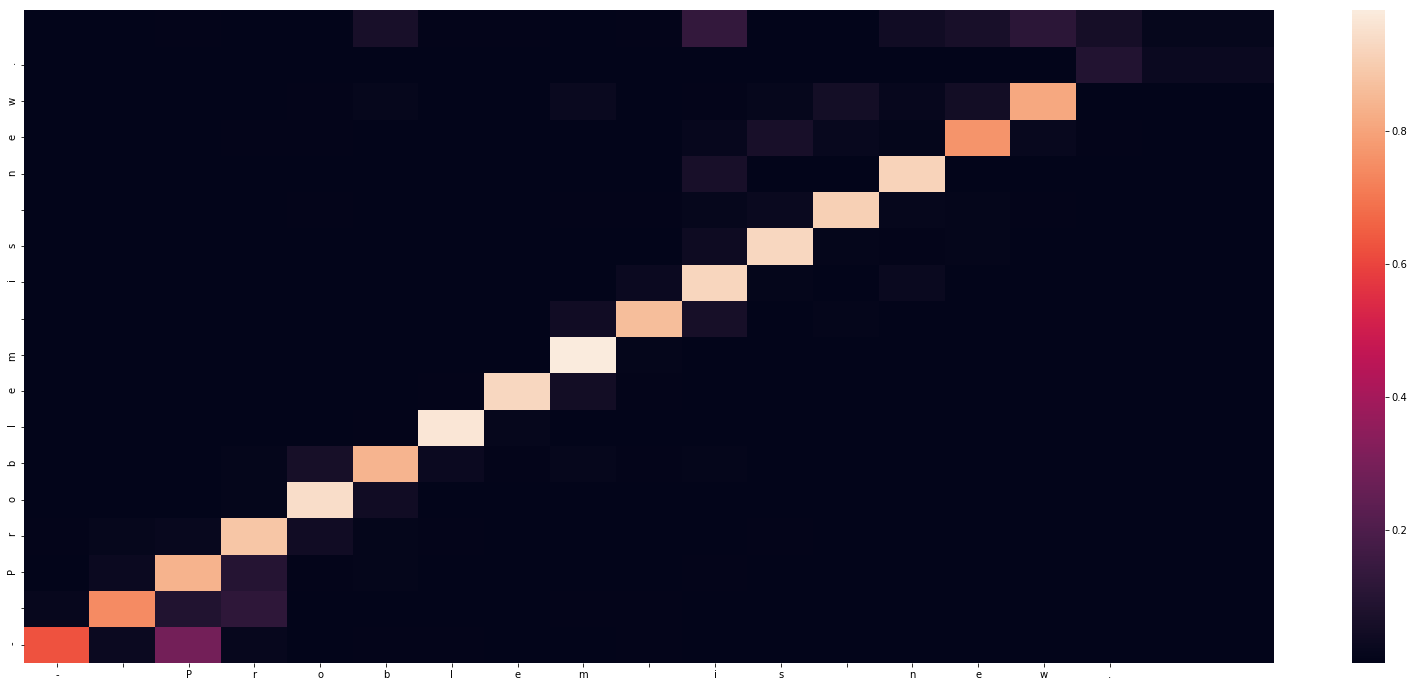

-
Input sentence: - Problem is new.
GT sentence: - Problem is new.

Decoded sentence: - Problem is new.


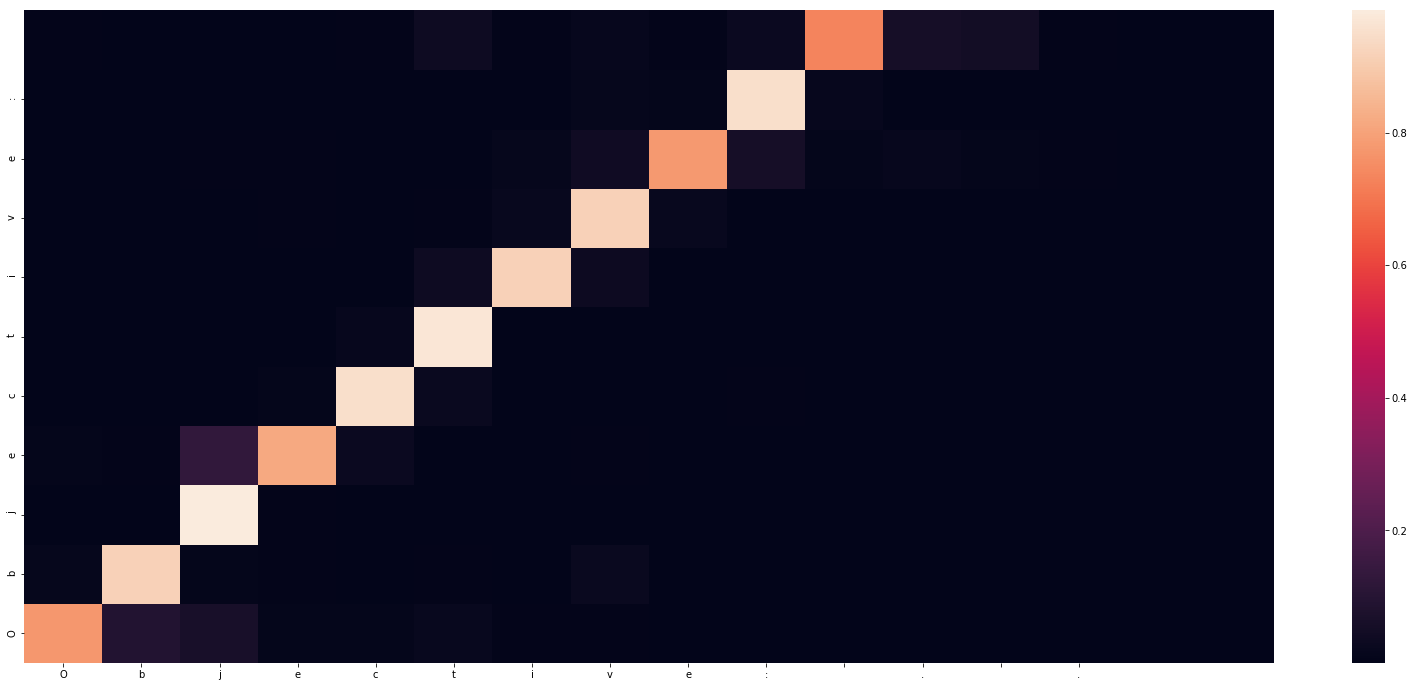

-
Input sentence: Objective: . .
GT sentence: Objective:

Decoded sentence: Objective:


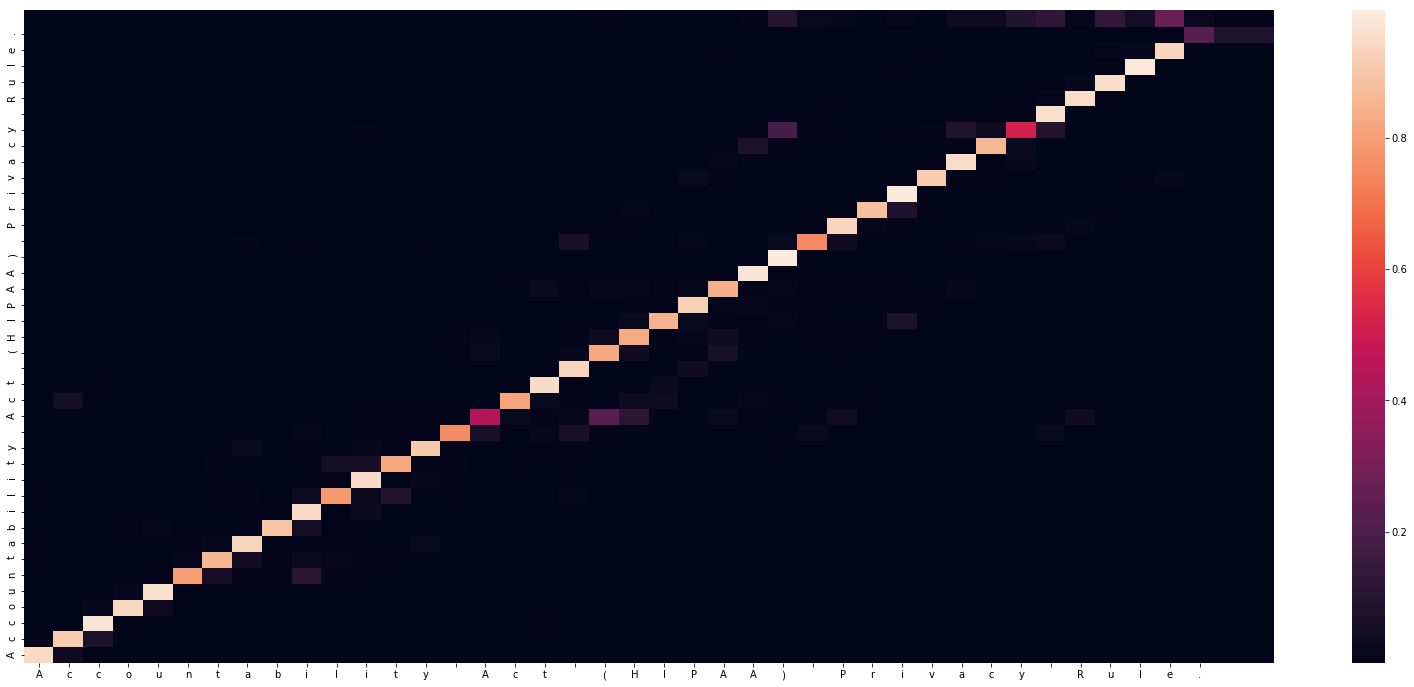

-
Input sentence: Accountability Act (HIPAA) Privacy Rule.
GT sentence: Accountability Act (HIPAA) Privacy Rule.

Decoded sentence: Accountability Act (HIPAA) Privacy Rule.


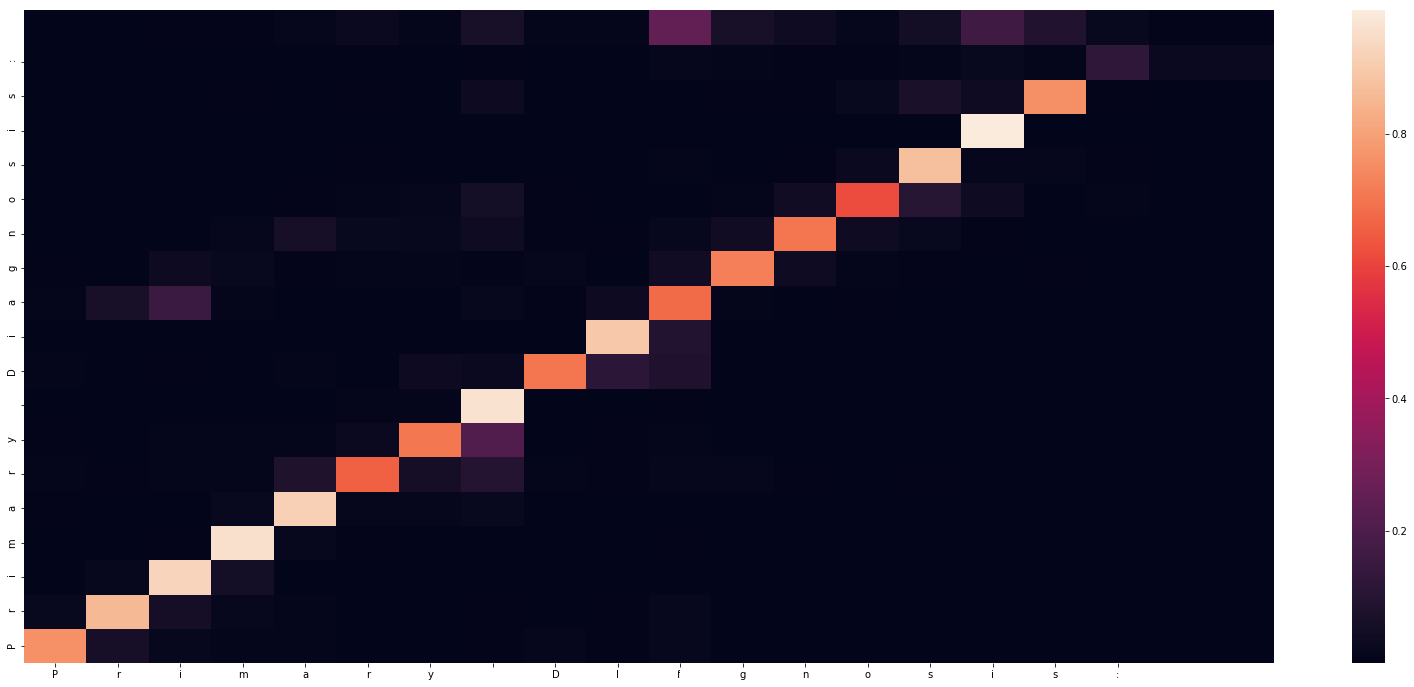

-
Input sentence: Primary Dlﬁgnosis:
GT sentence: Primary Diagnosis:

Decoded sentence: Primary Diagnosis:


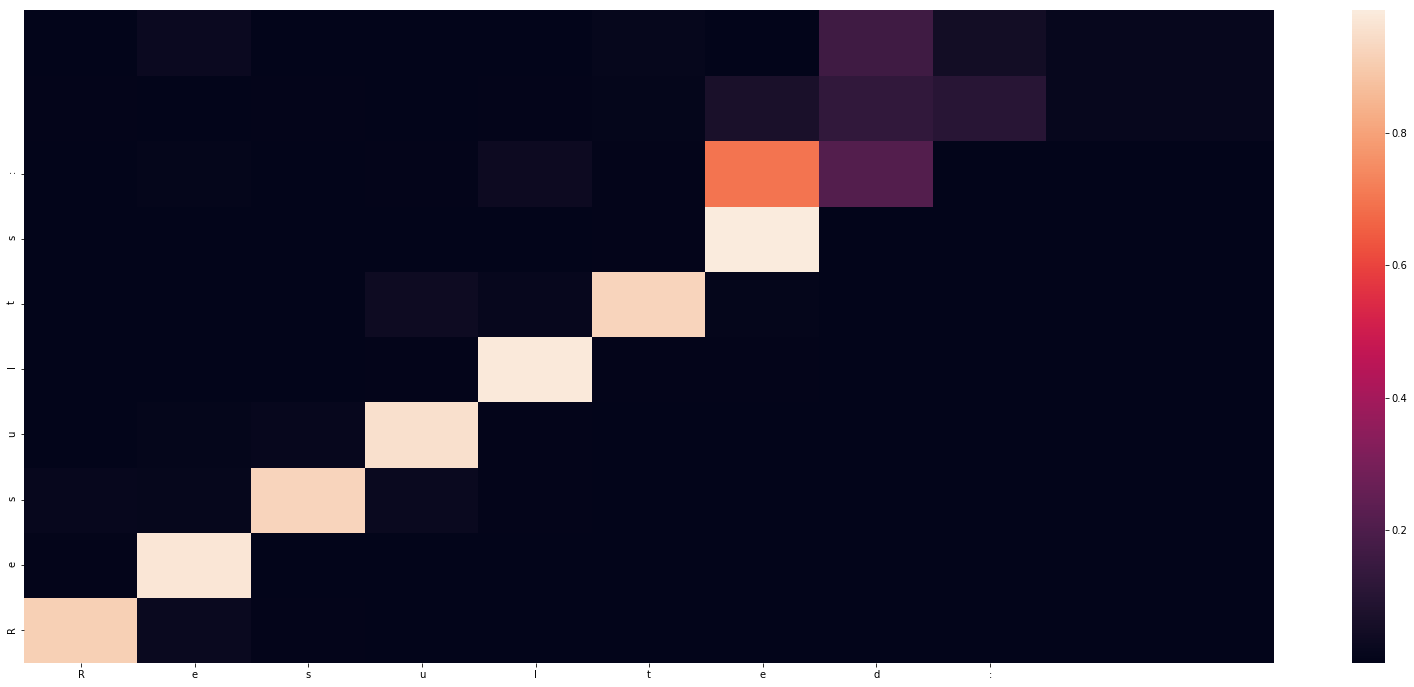

-
Input sentence: Resulted:
GT sentence: Resulted:

Decoded sentence: Results:


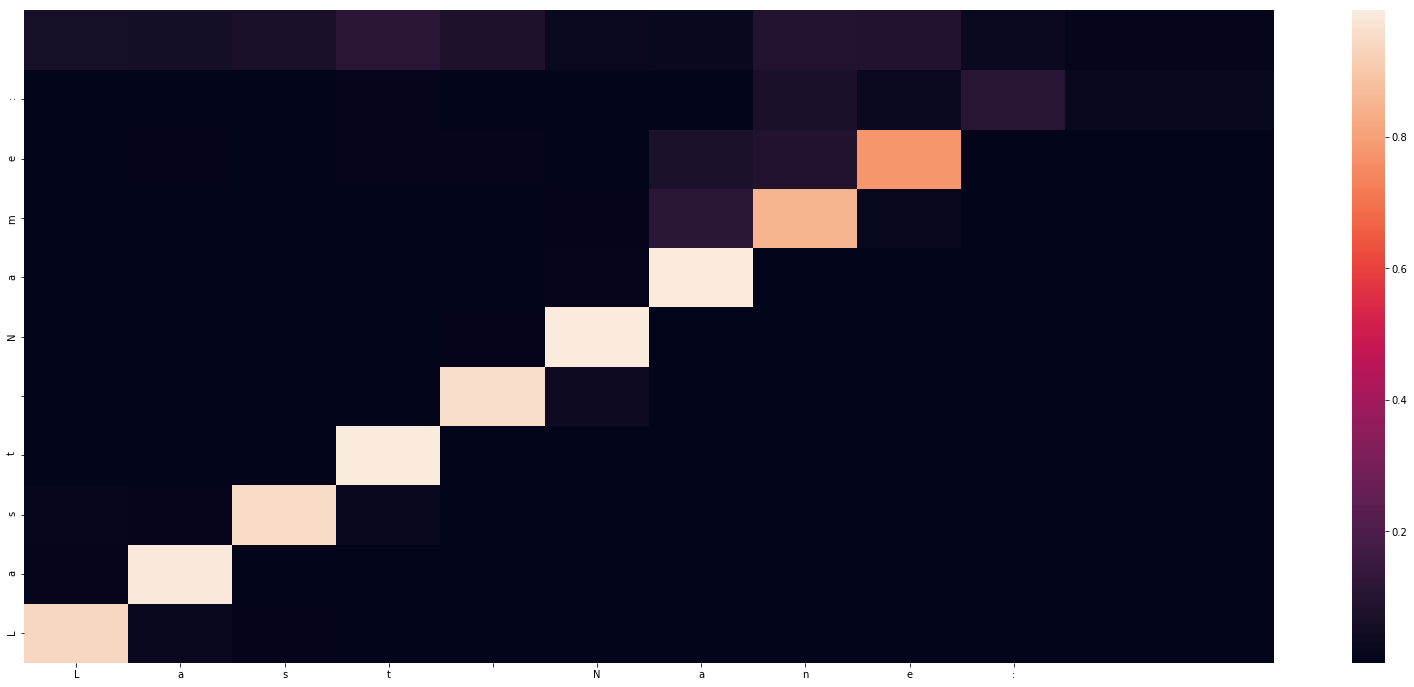

-
Input sentence: Last Nane:
GT sentence: Last Name:

Decoded sentence: Last Name:


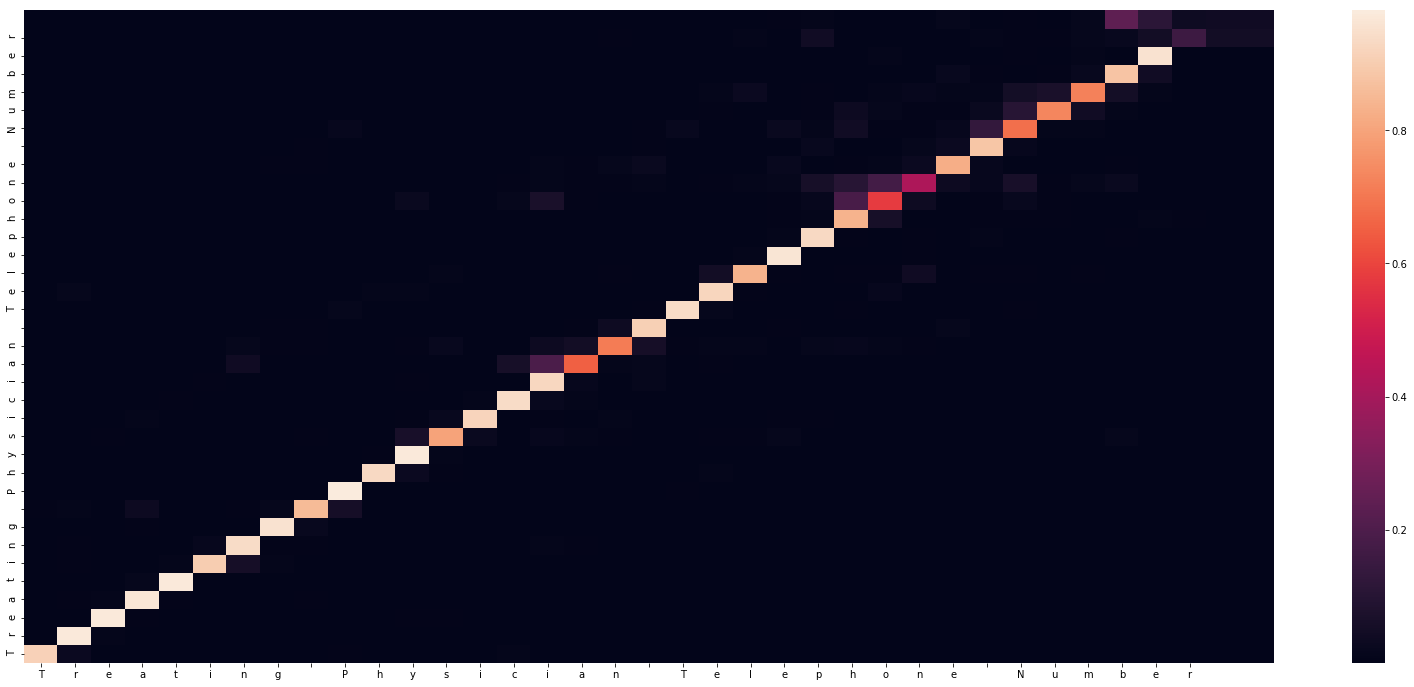

-
Input sentence: Treating Physician Telephone Number
GT sentence: Treating Physician Telephone Number

Decoded sentence: Treating Physician Telephone Number


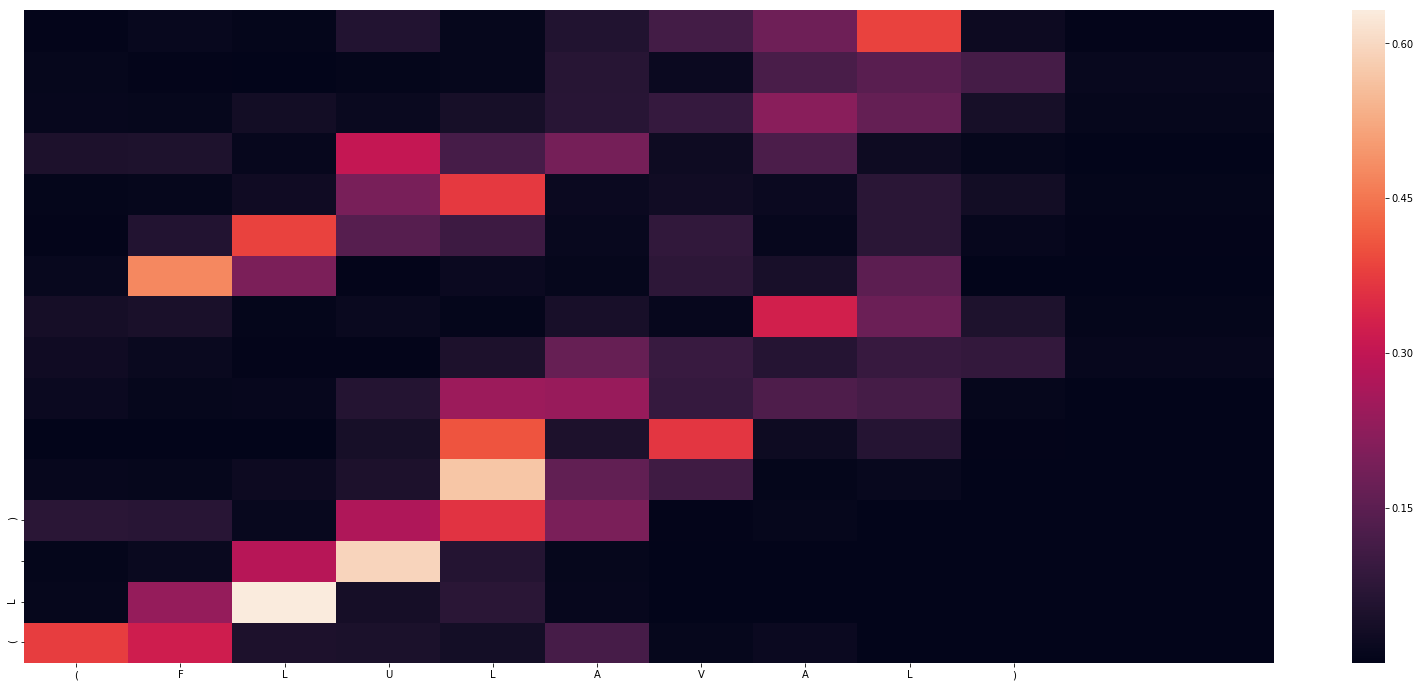

-
Input sentence: (FLULAVAL)
GT sentence: (FLULAVAL)

Decoded sentence: (L )


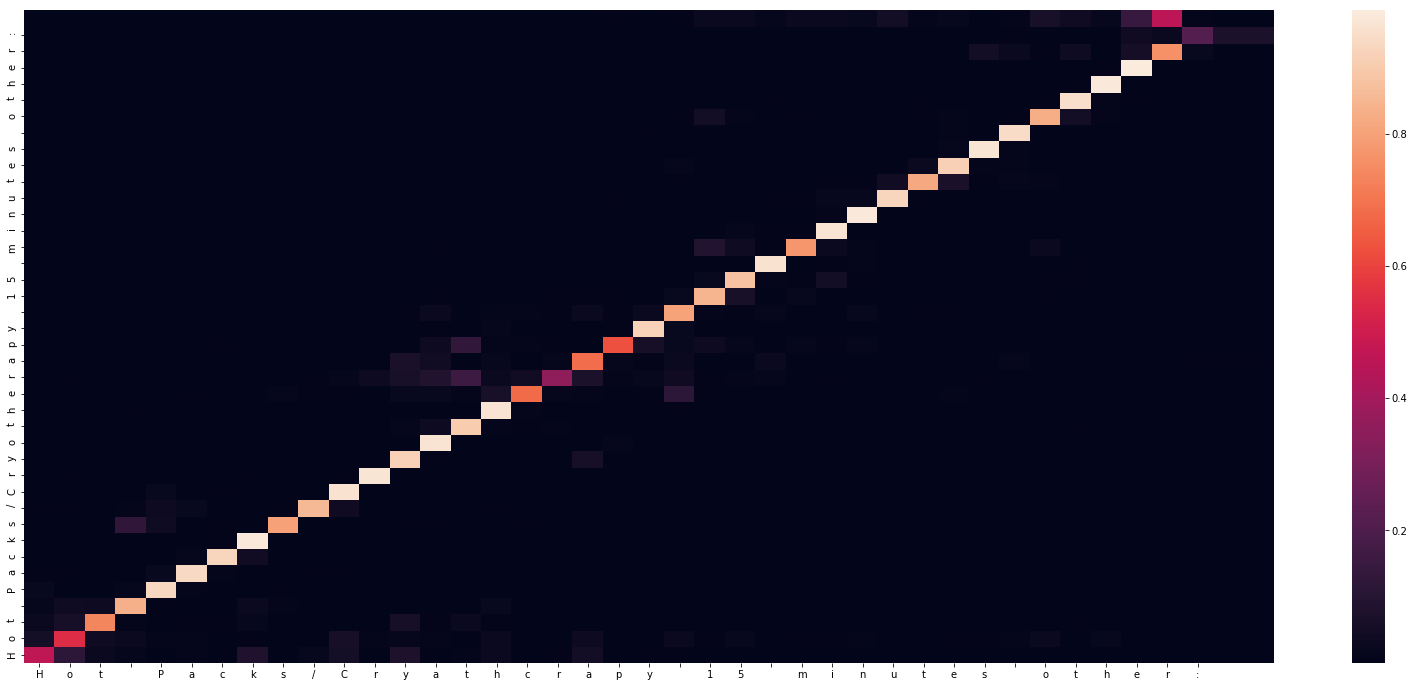

-
Input sentence: Hot Packs/Cryathcrapy 15 minutes other:
GT sentence: Hot Packs/Cryotherapy 15 minutes other:

Decoded sentence: Hot Packs/Cryotherapy 15 minutes other:


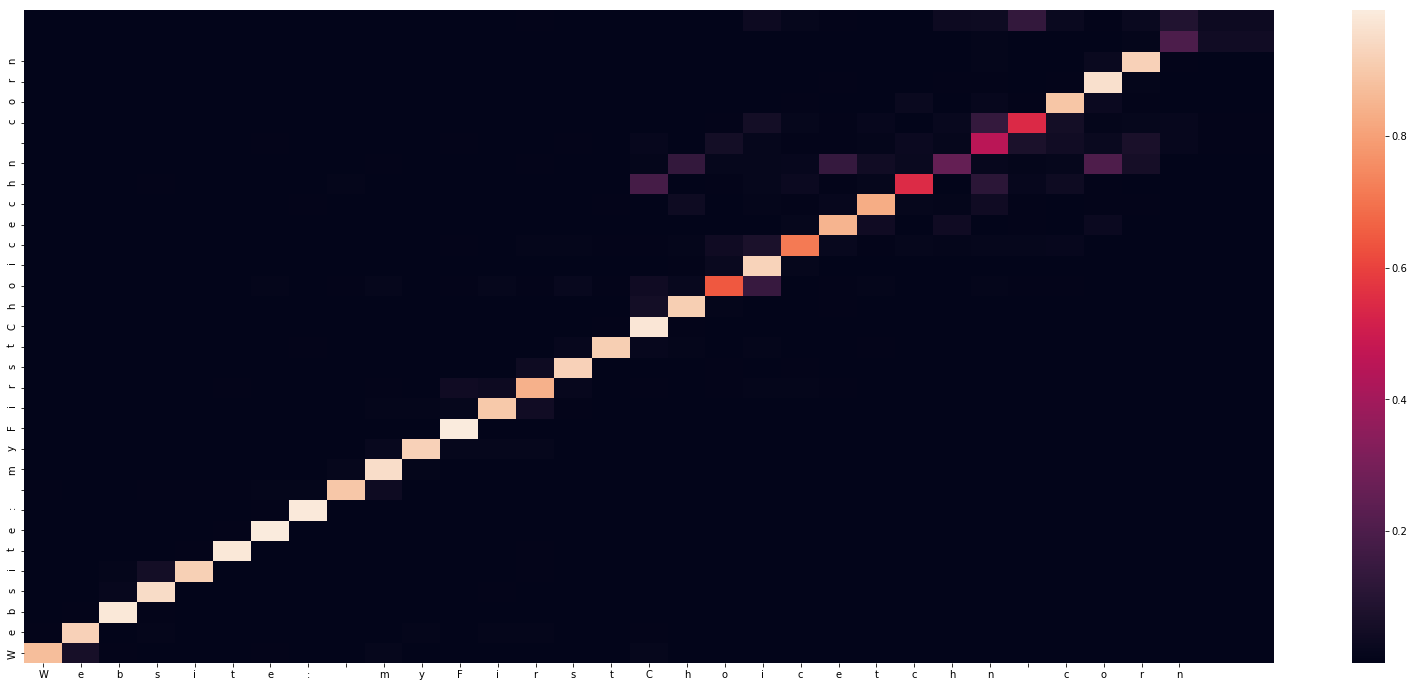

-
Input sentence: Website: myFirstChoicetchn corn
GT sentence: Website: myFirstChoice.fchn.com

Decoded sentence: Website: myFirstChoicechn corn


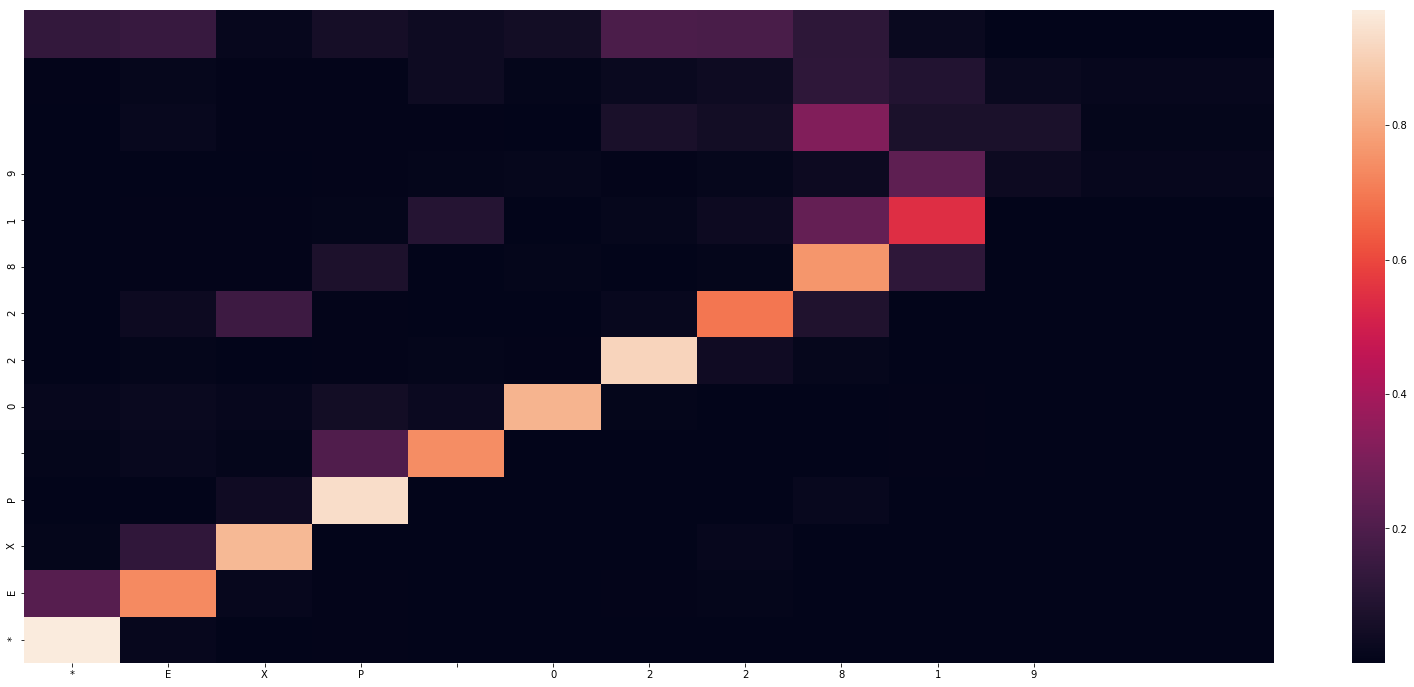

-
Input sentence: *EXP 022819
GT sentence: *EXP 022819

Decoded sentence: *EXP 022819


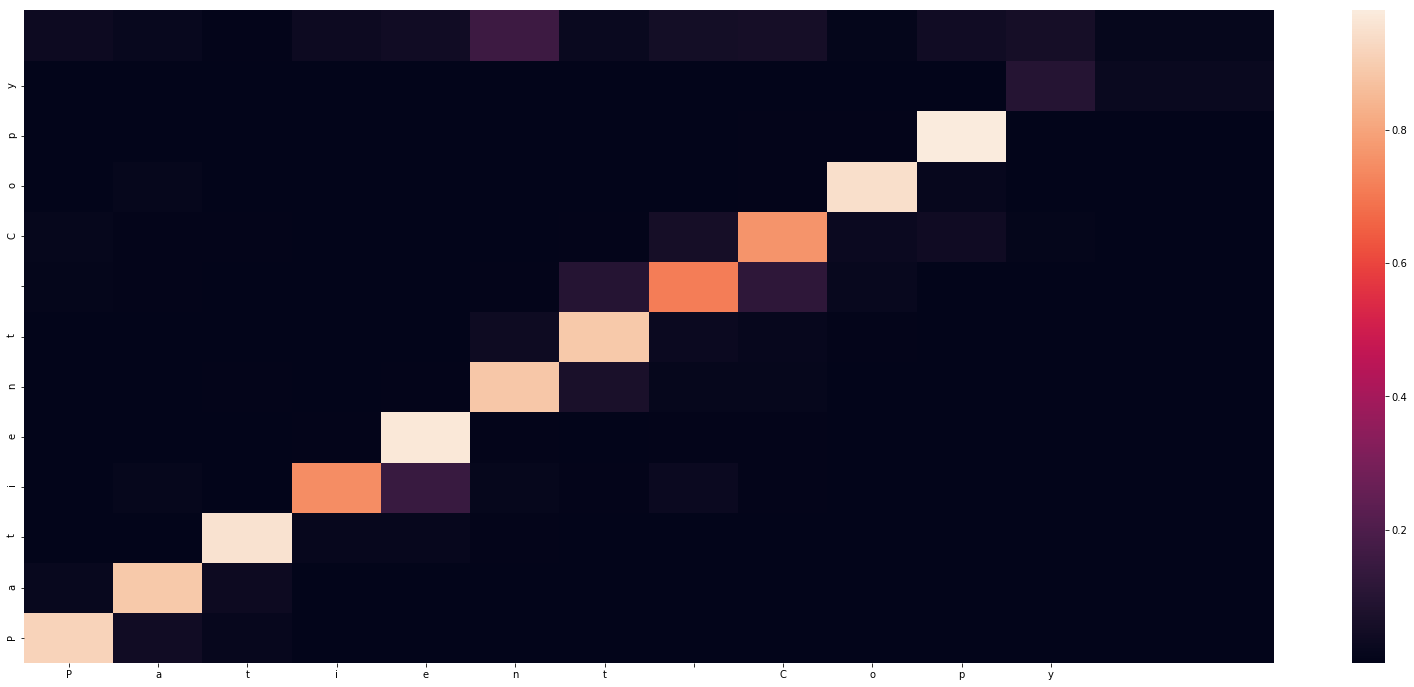

-
Input sentence: Patient Copy
GT sentence: Patient Copy

Decoded sentence: Patient Copy


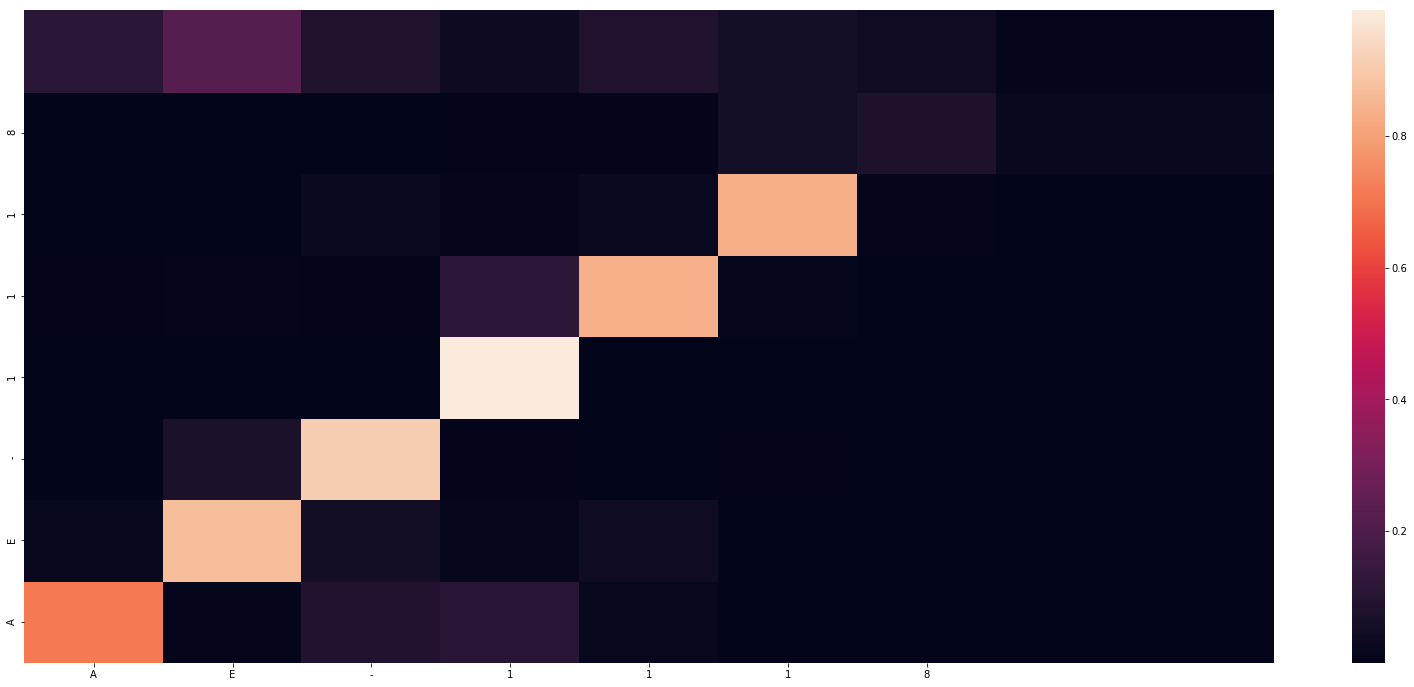

-
Input sentence: AE-1118
GT sentence: AE-1118

Decoded sentence: AE-1118


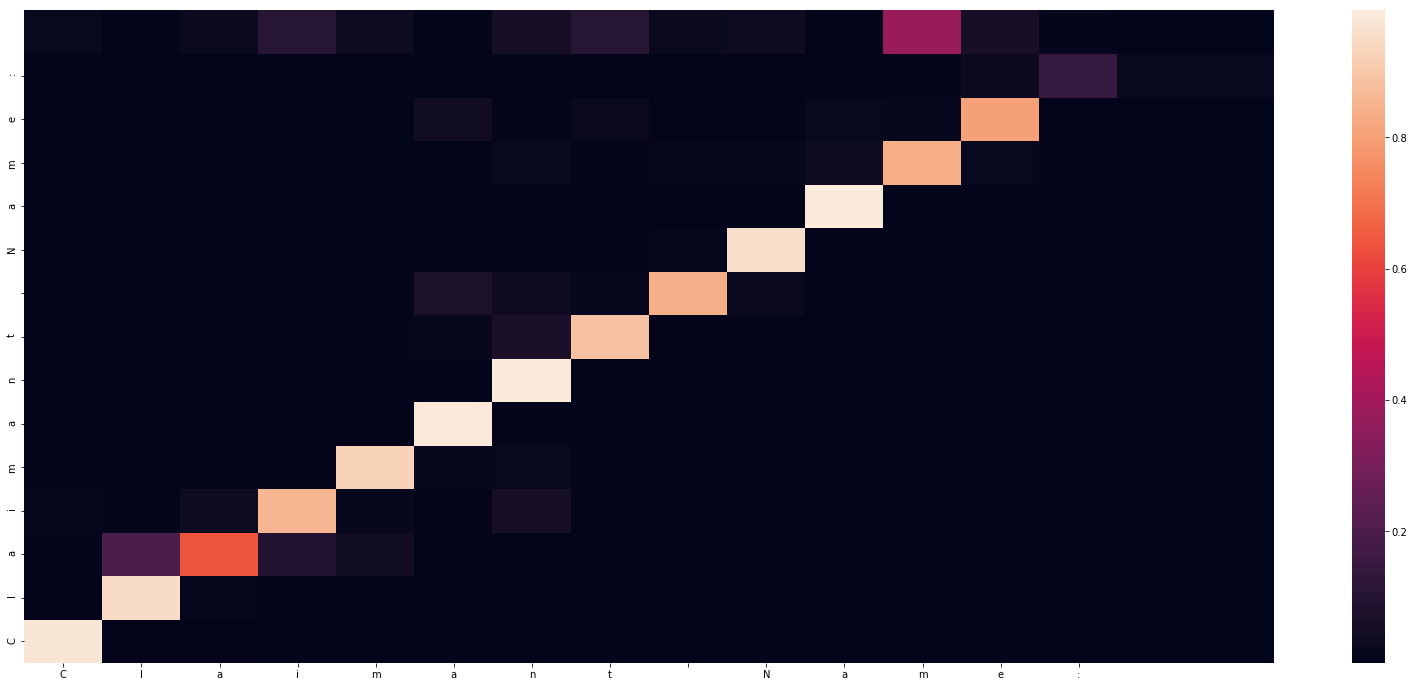

-
Input sentence: Claimant Name:
GT sentence: Claimant Name:

Decoded sentence: Claimant Name:


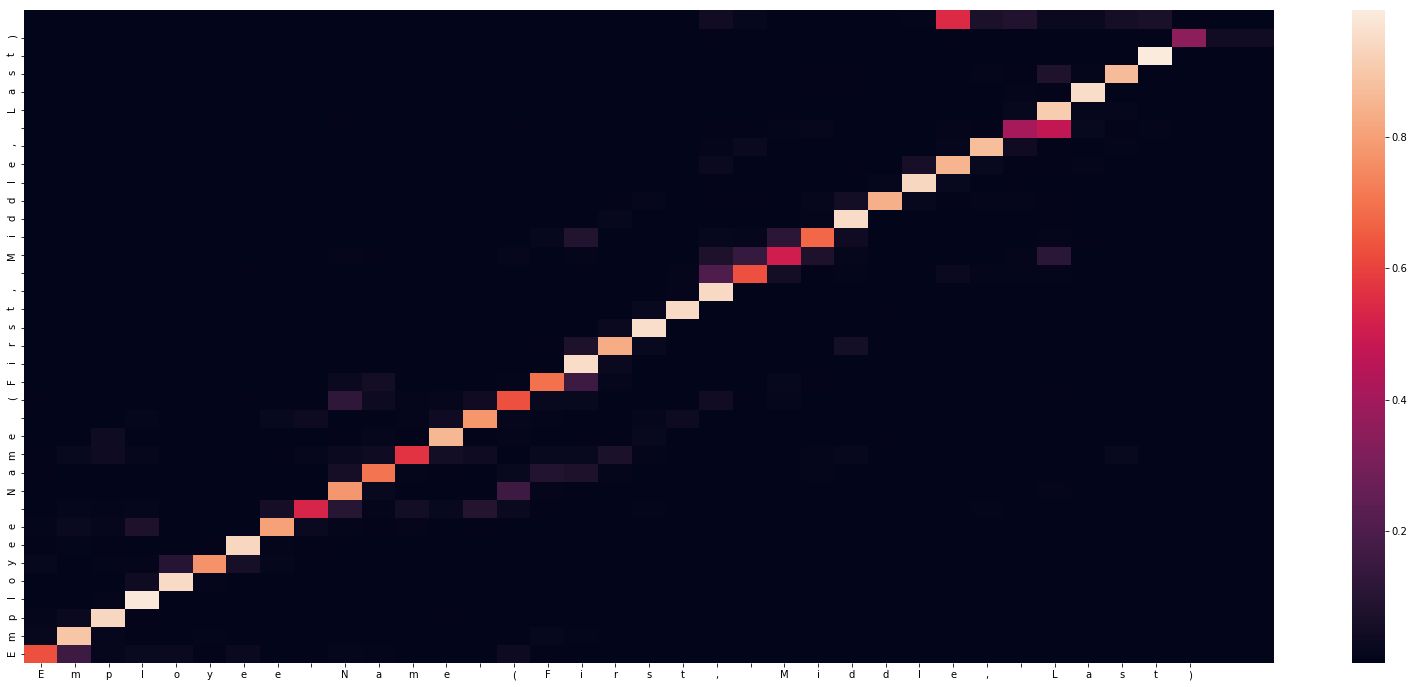

-
Input sentence: Employee Name (First, Middle, Last)
GT sentence: Employee Name (First, Middle, Last)

Decoded sentence: Employee Name (First, Middle, Last)


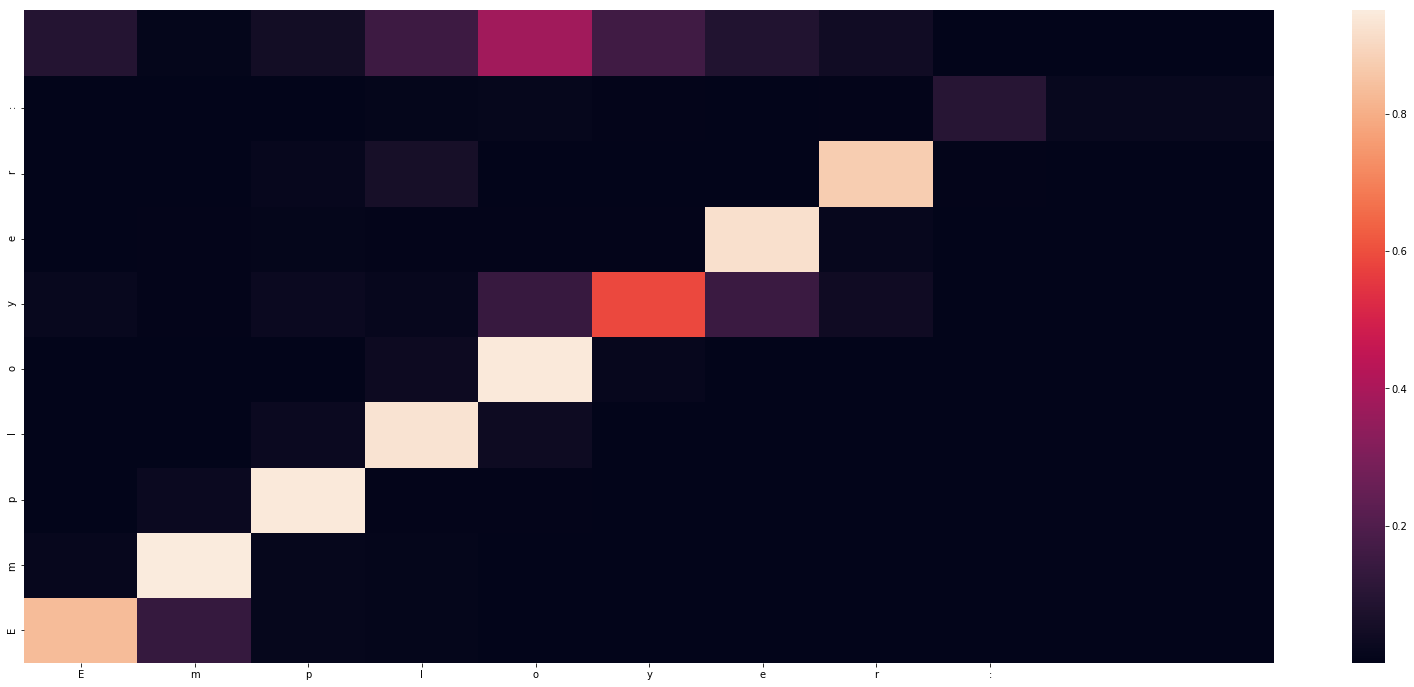

-
Input sentence: Employer:
GT sentence: Employer:

Decoded sentence: Employer:


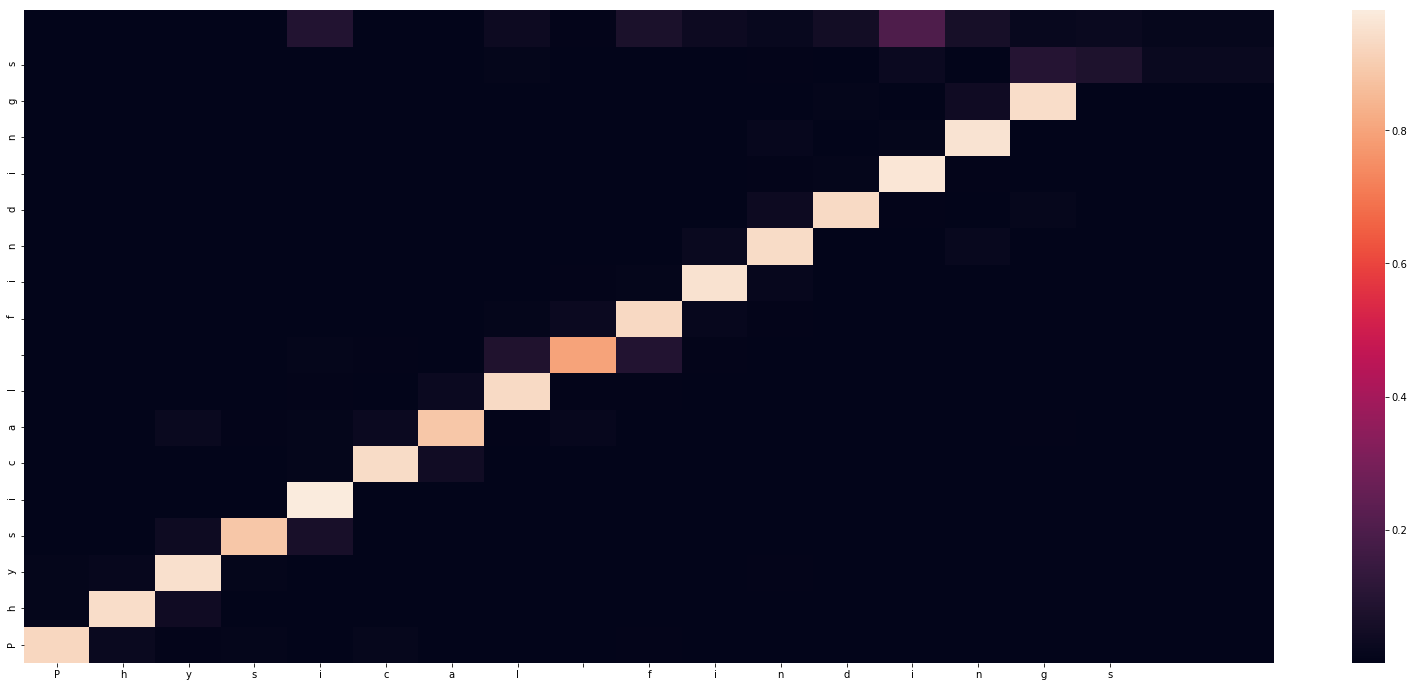

-
Input sentence: Physical findings
GT sentence: Physical findings

Decoded sentence: Physical findings


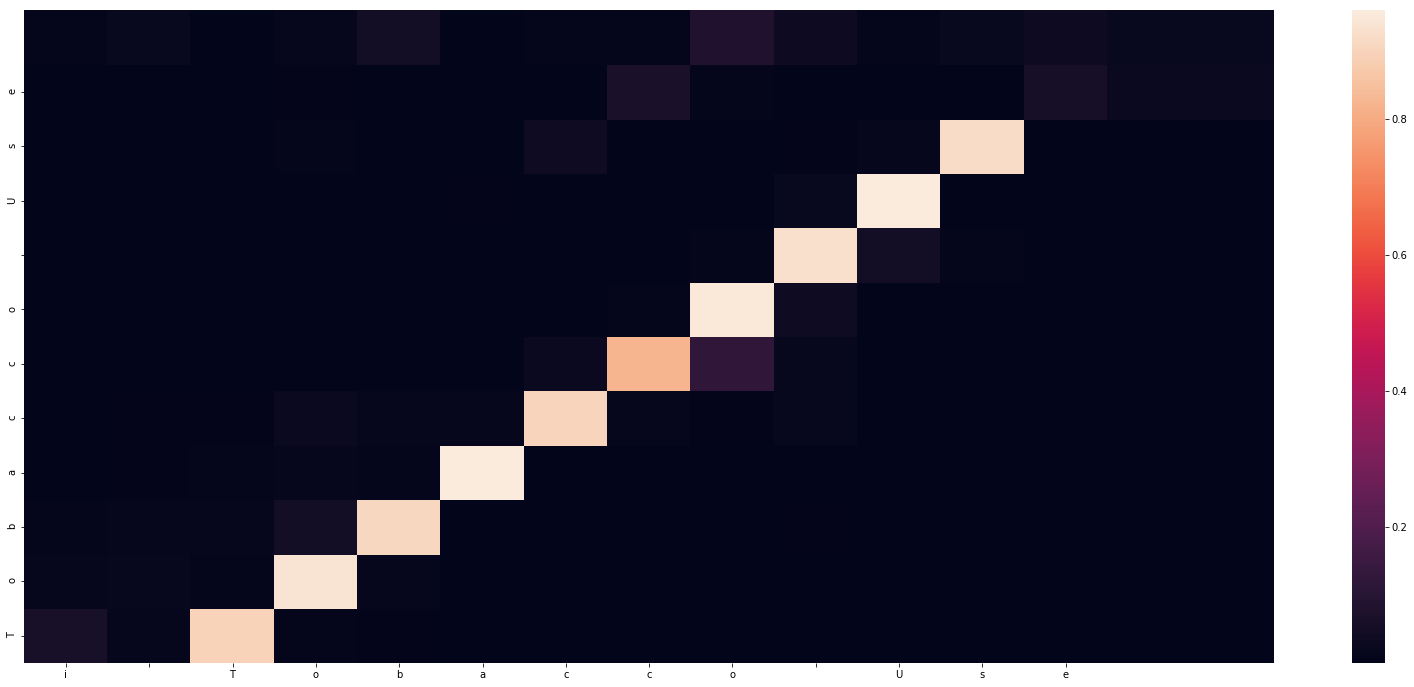

-
Input sentence: i Tobacco Use
GT sentence: Tobacco Use

Decoded sentence: Tobacco Use


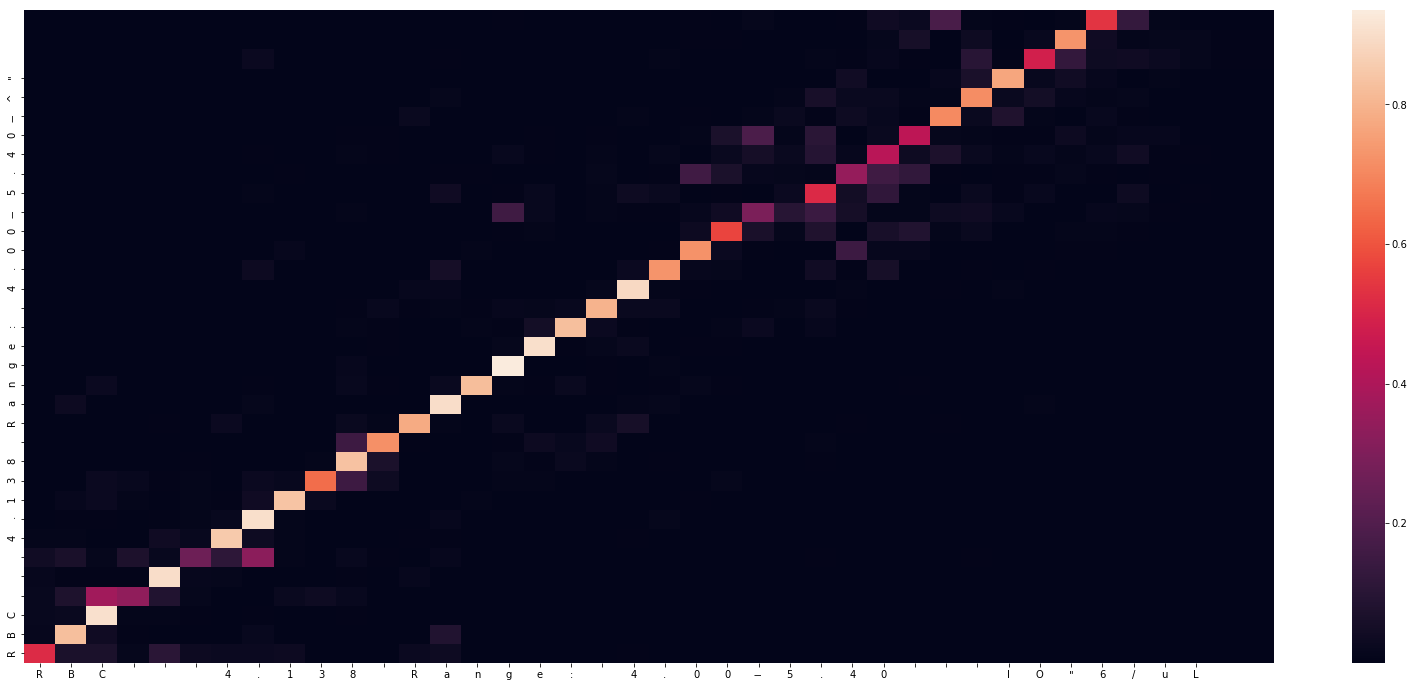

-
Input sentence: RBC — 4.138 Range: 4.00—5.40 — IO"6/uL
GT sentence: • RBC - 4.68 Range: 4.00-5.40 - 10^6/uL

Decoded sentence: RBC — 4.138 Range: 4.00—5.40—^"


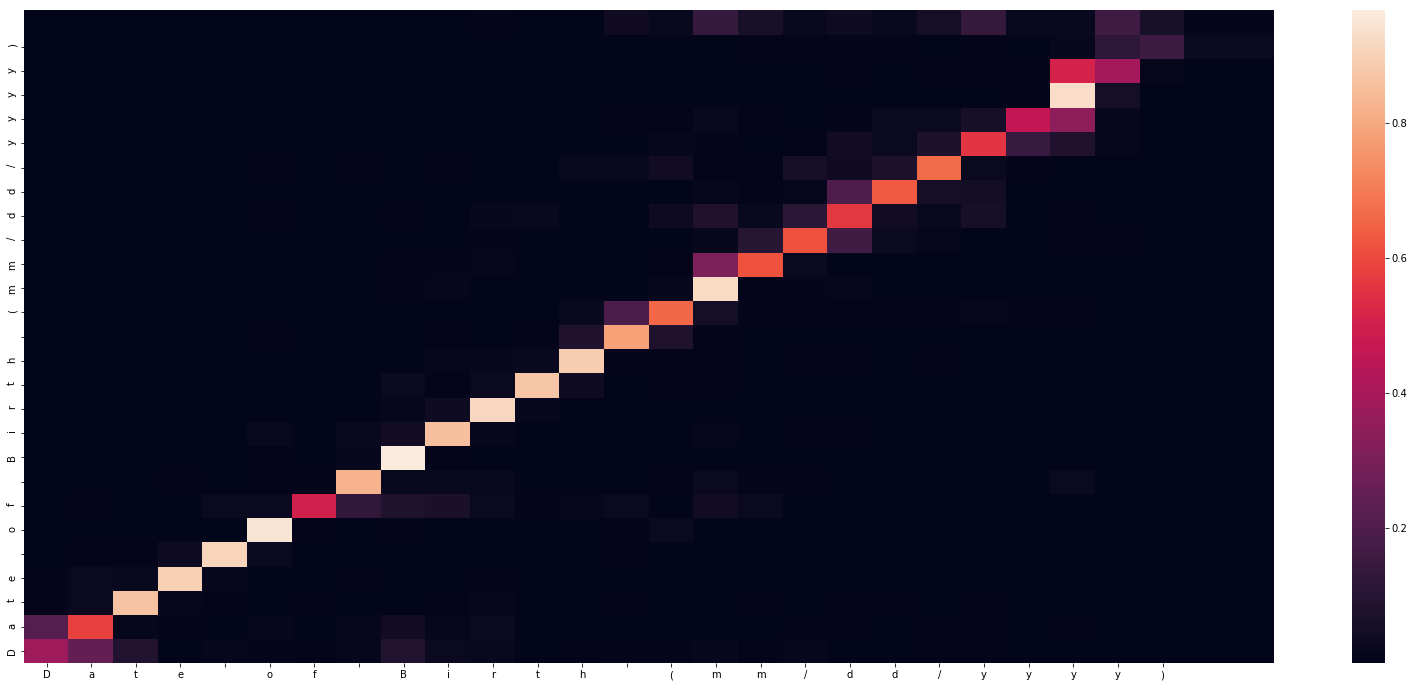

-
Input sentence: Date of Birth (mm/dd/yyyy)
GT sentence: Date of Birth (mm/dd/yyyy)

Decoded sentence: Date of Birth (mm/dd/yyyy)


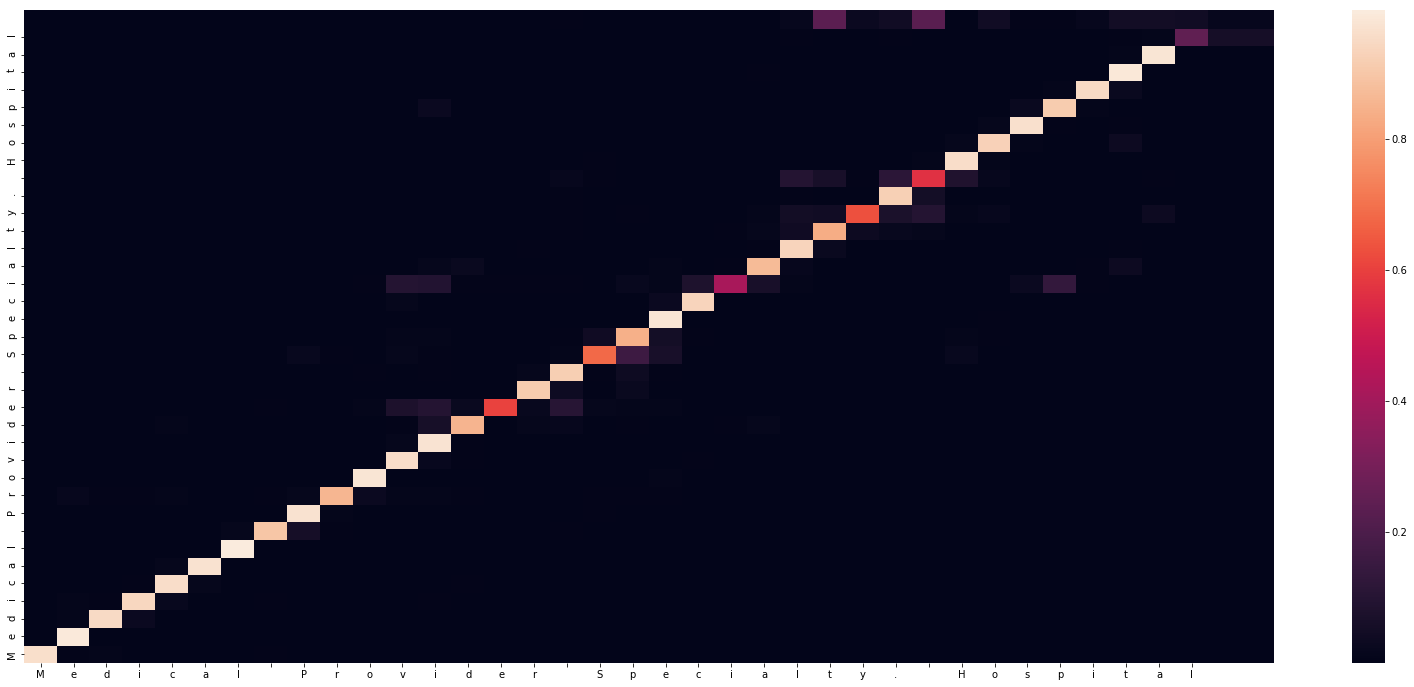

-
Input sentence: Medical Provider Specialty. Hospital
GT sentence: Medical Provider Specialty: Hospital

Decoded sentence: Medical Provider Specialty. Hospital


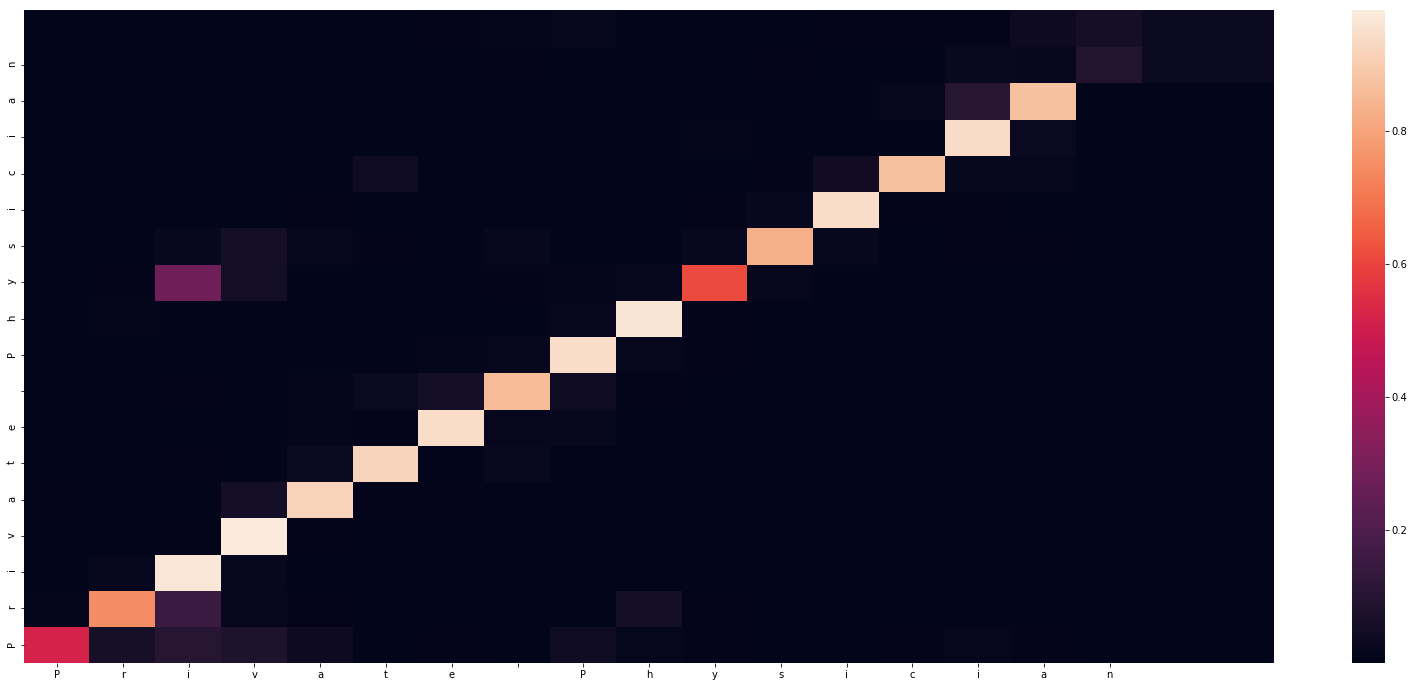

-
Input sentence: Private Physician
GT sentence: Private Physician

Decoded sentence: Private Physician


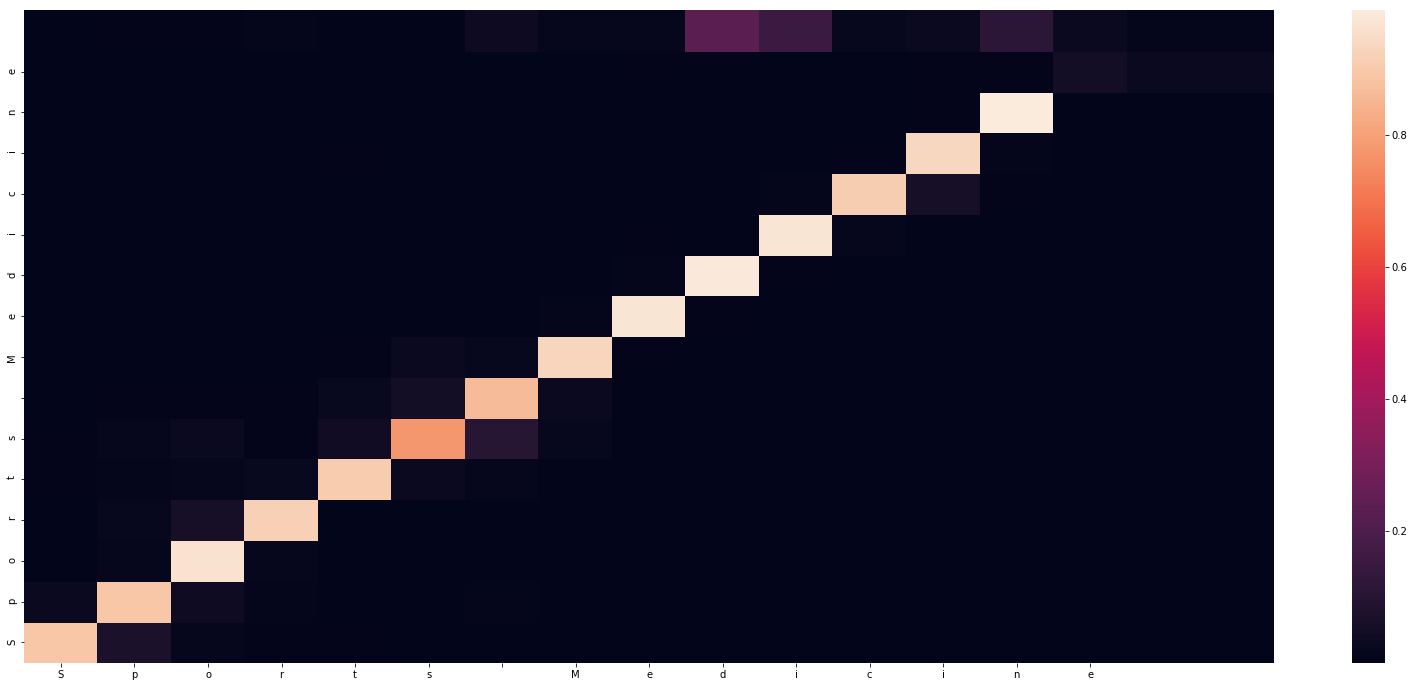

-
Input sentence: Sports Medicine
GT sentence: Sports Medicine

Decoded sentence: Sports Medicine


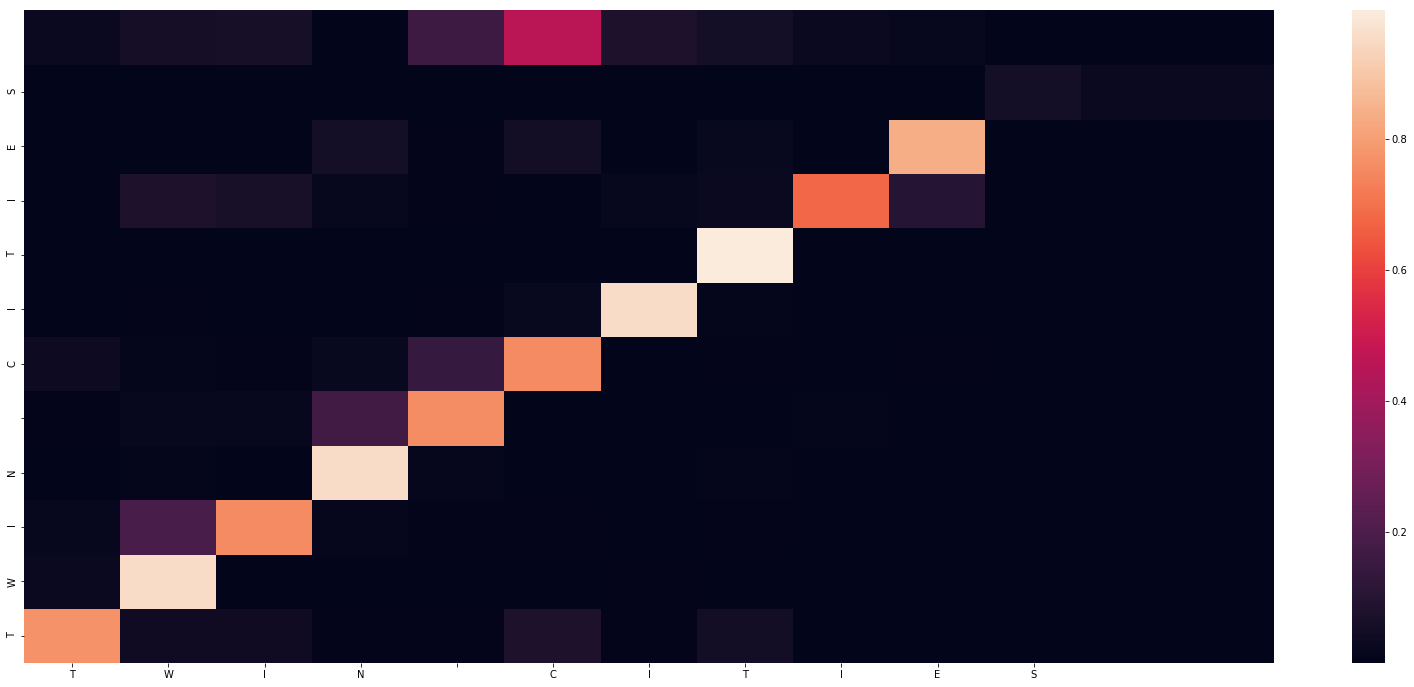

-
Input sentence: TWIN CITIES
GT sentence: TWIN CITIES

Decoded sentence: TWIN CITIES


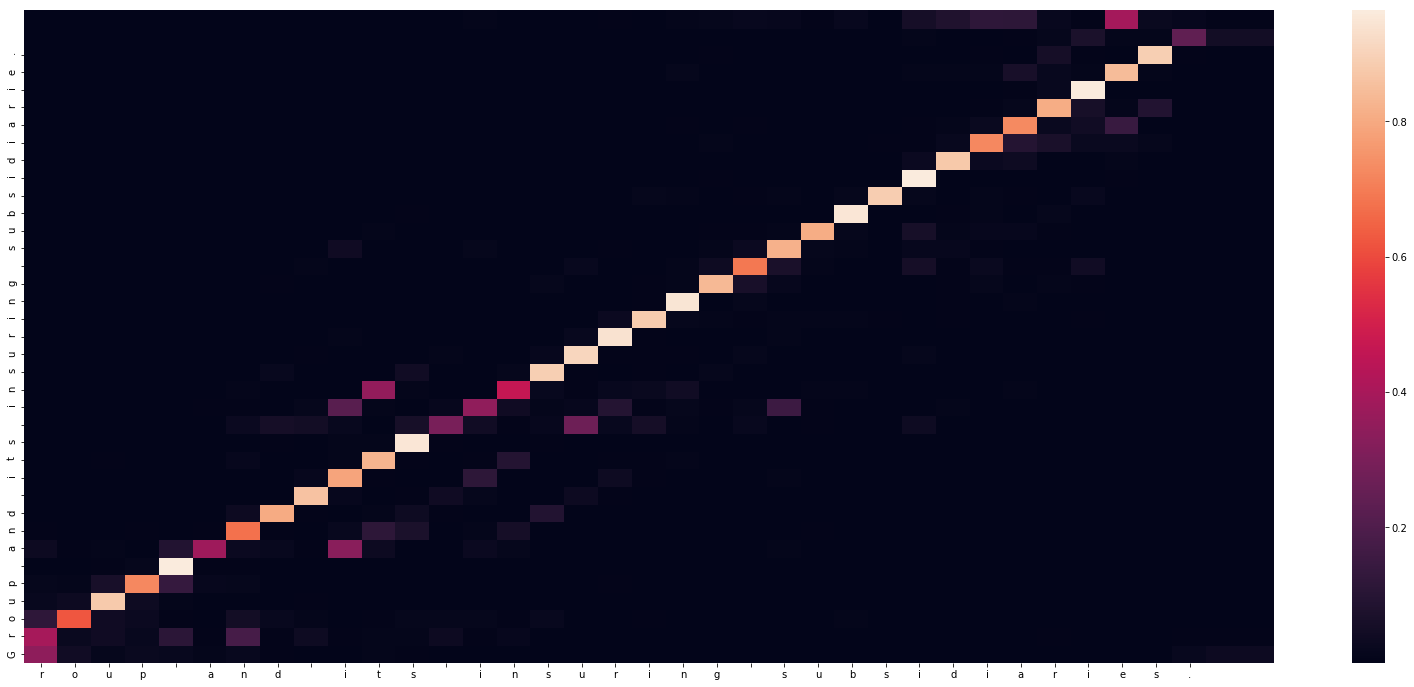

-
Input sentence: roup and its insuring subsidiaries.
GT sentence: Group and its insuring subsidiaries.

Decoded sentence: Group and its insuring subsidiarie.


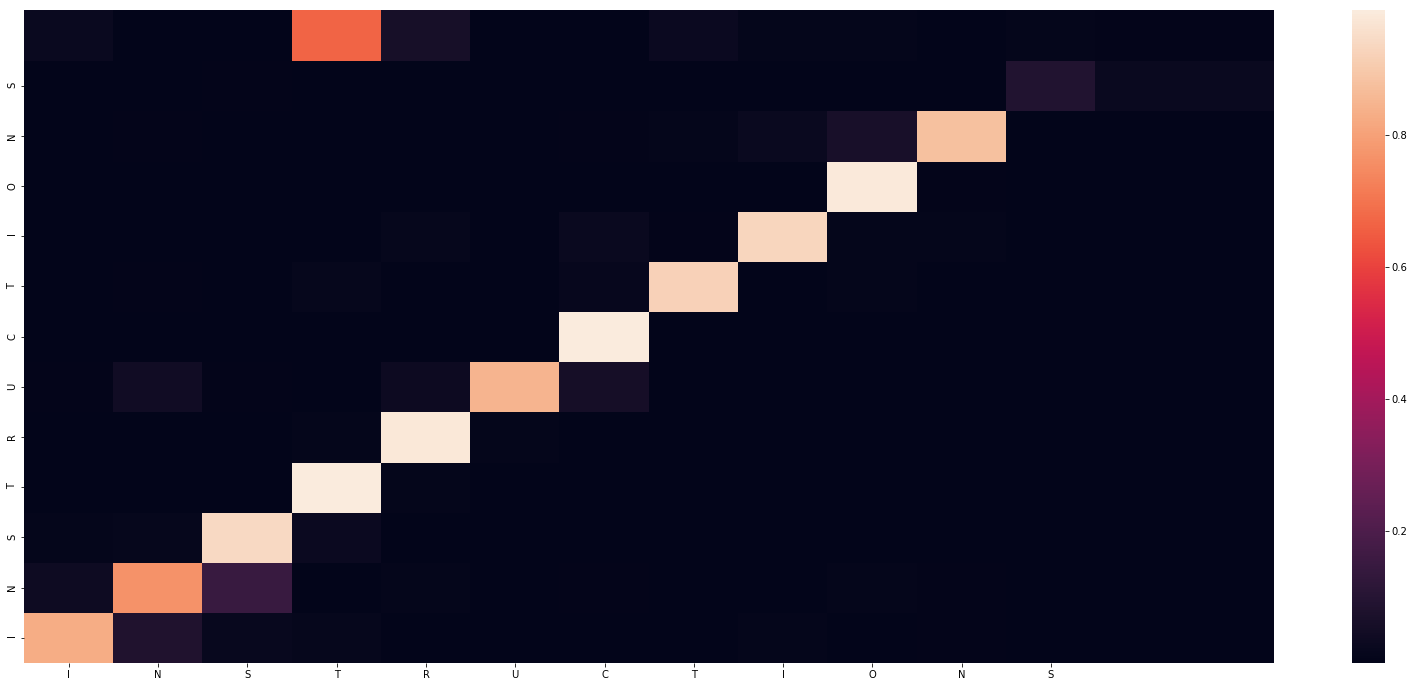

-
Input sentence: INSTRUCTIONS
GT sentence: INSTRUCTIONS

Decoded sentence: INSTRUCTIONS


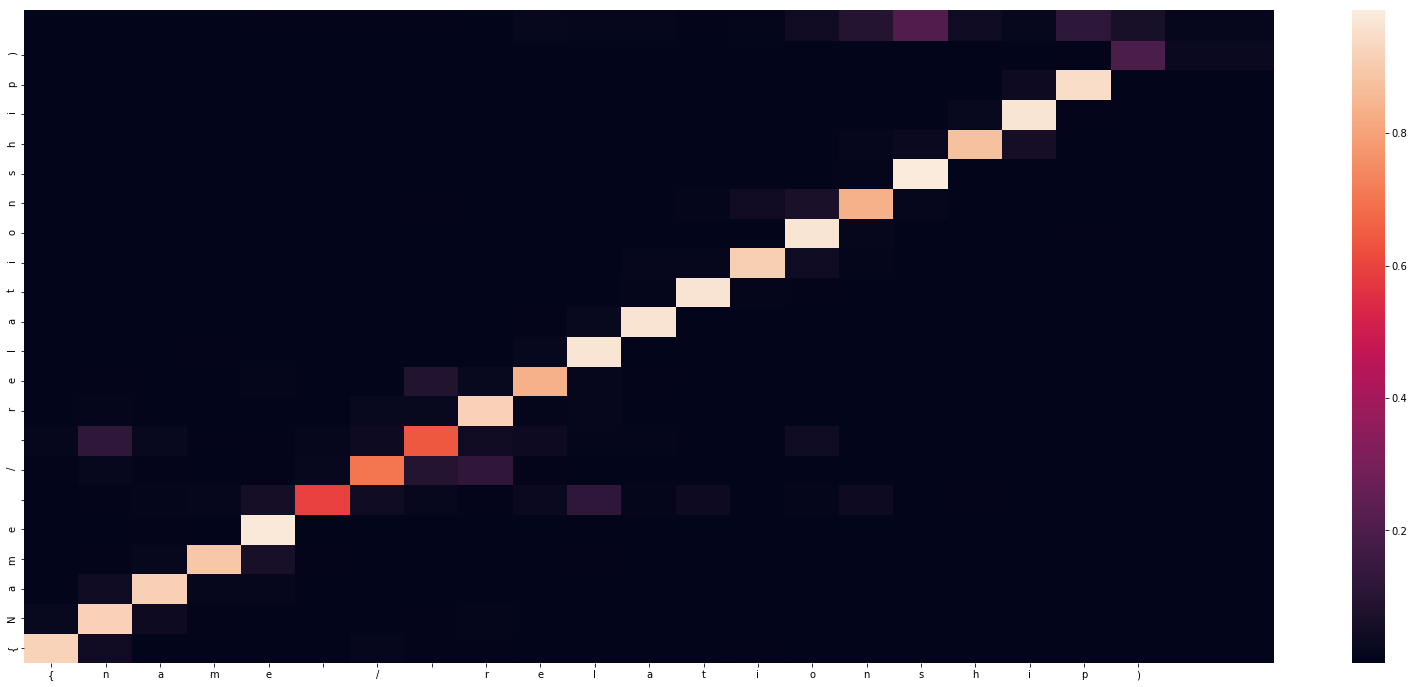

-
Input sentence: {name / relationship)
GT sentence: (Name / Relationship)

Decoded sentence: {Name / relationship)


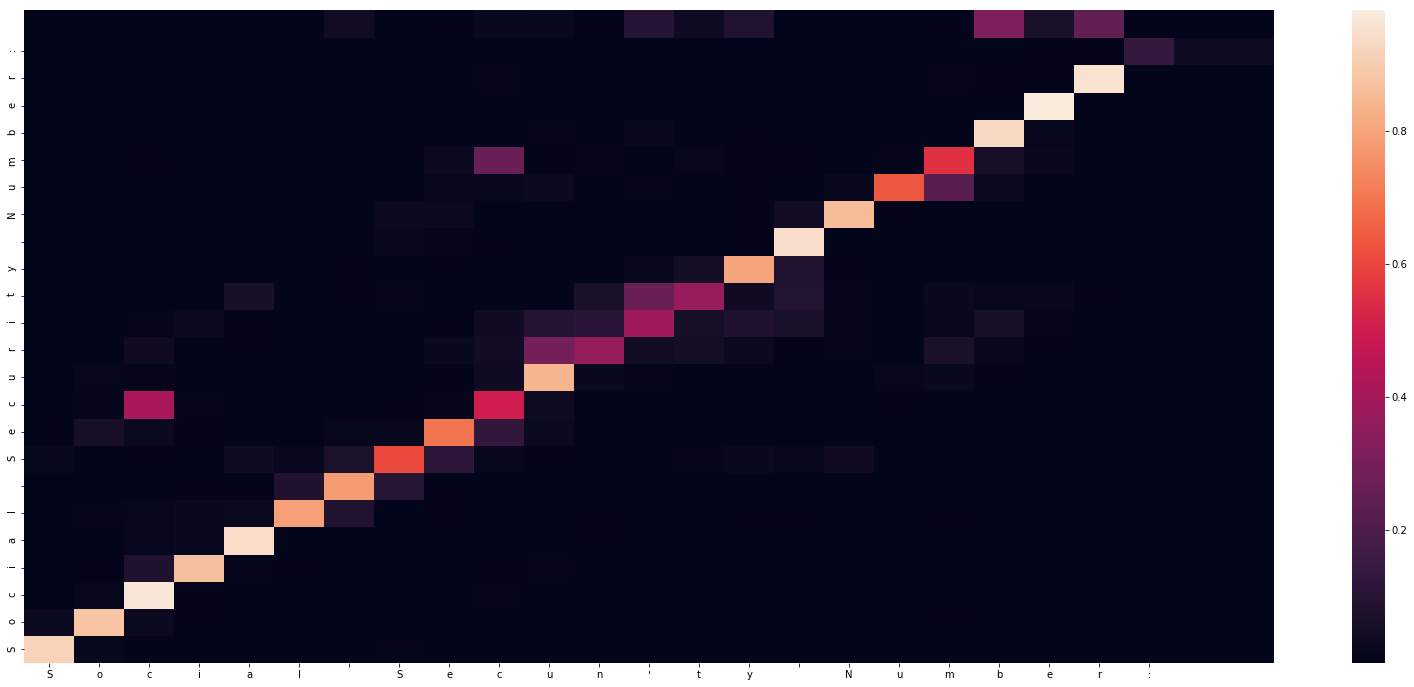

-
Input sentence: Social Secun'ty Number:
GT sentence: Social Security Number:

Decoded sentence: Social Security Number:


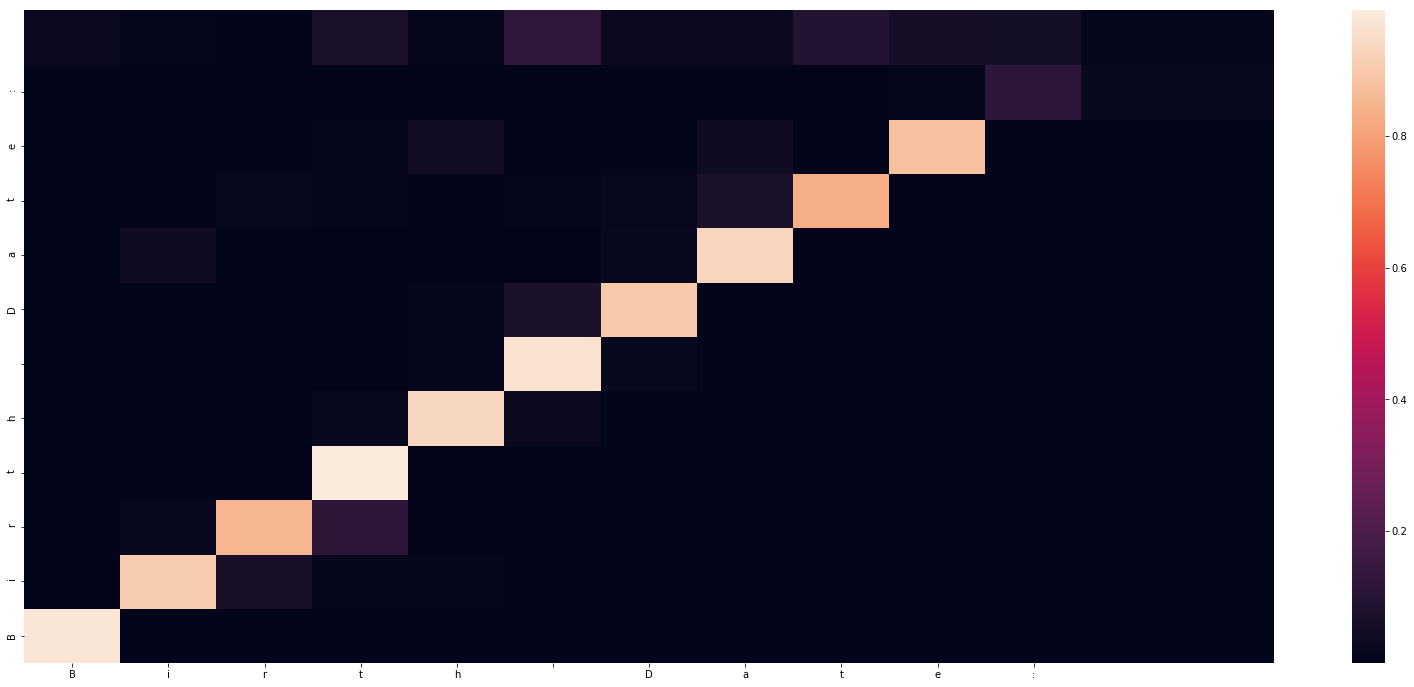

-
Input sentence: Birth Date:
GT sentence: Birth Date:

Decoded sentence: Birth Date:


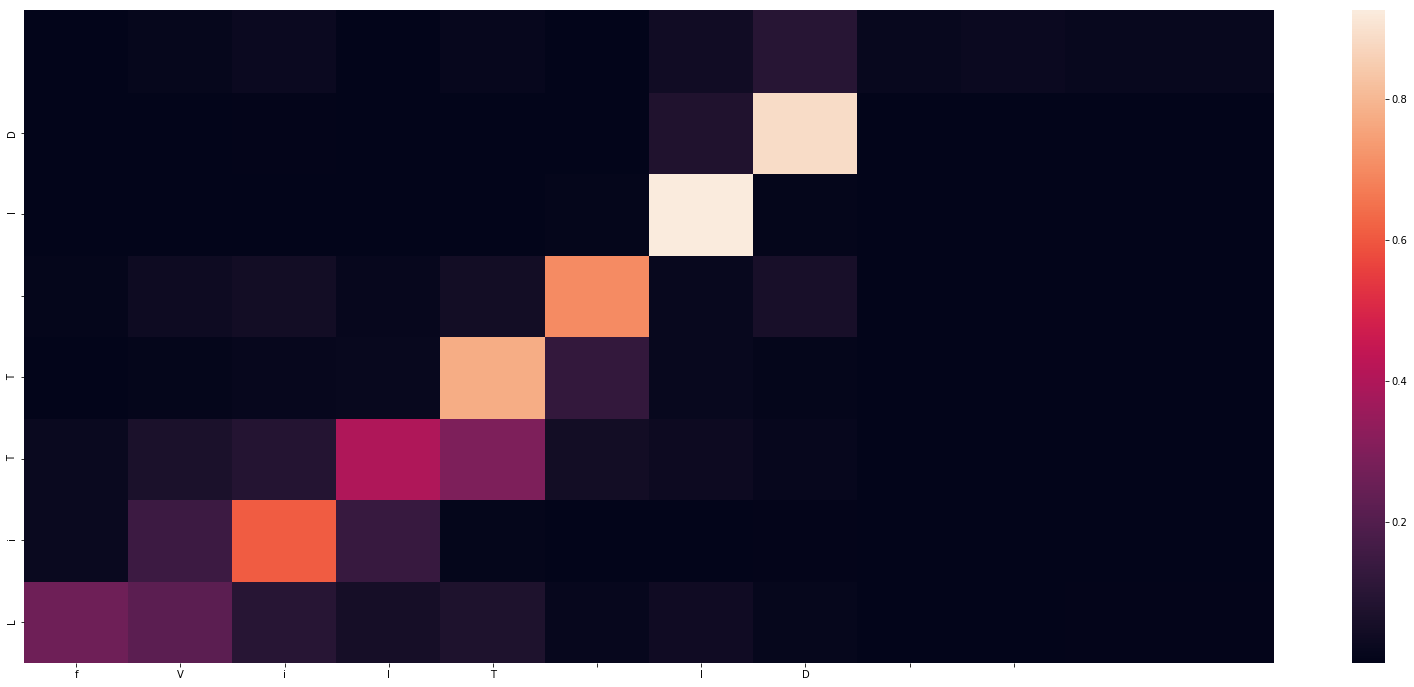

-
Input sentence: fViIT ID ’
GT sentence: VISIT ID 

Decoded sentence: LiTT ID


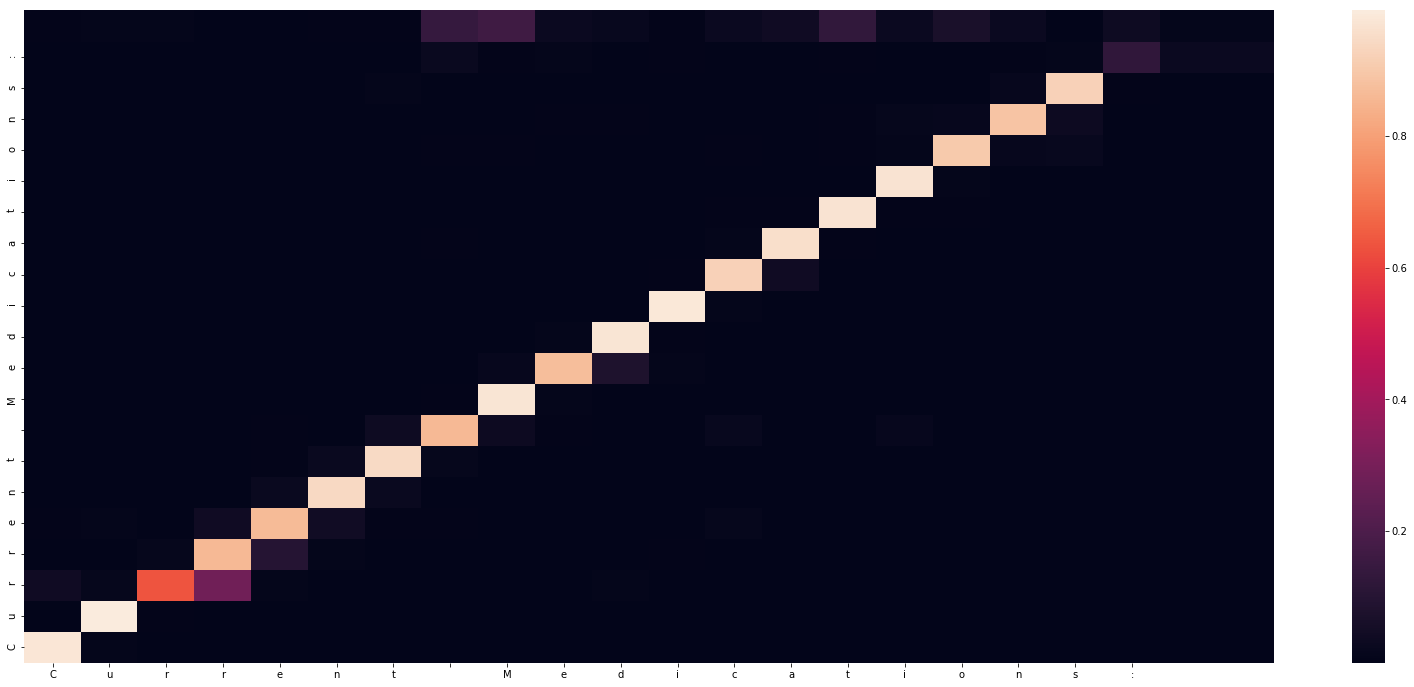

-
Input sentence: Current Medications:
GT sentence: Current Medications:

Decoded sentence: Current Medications:


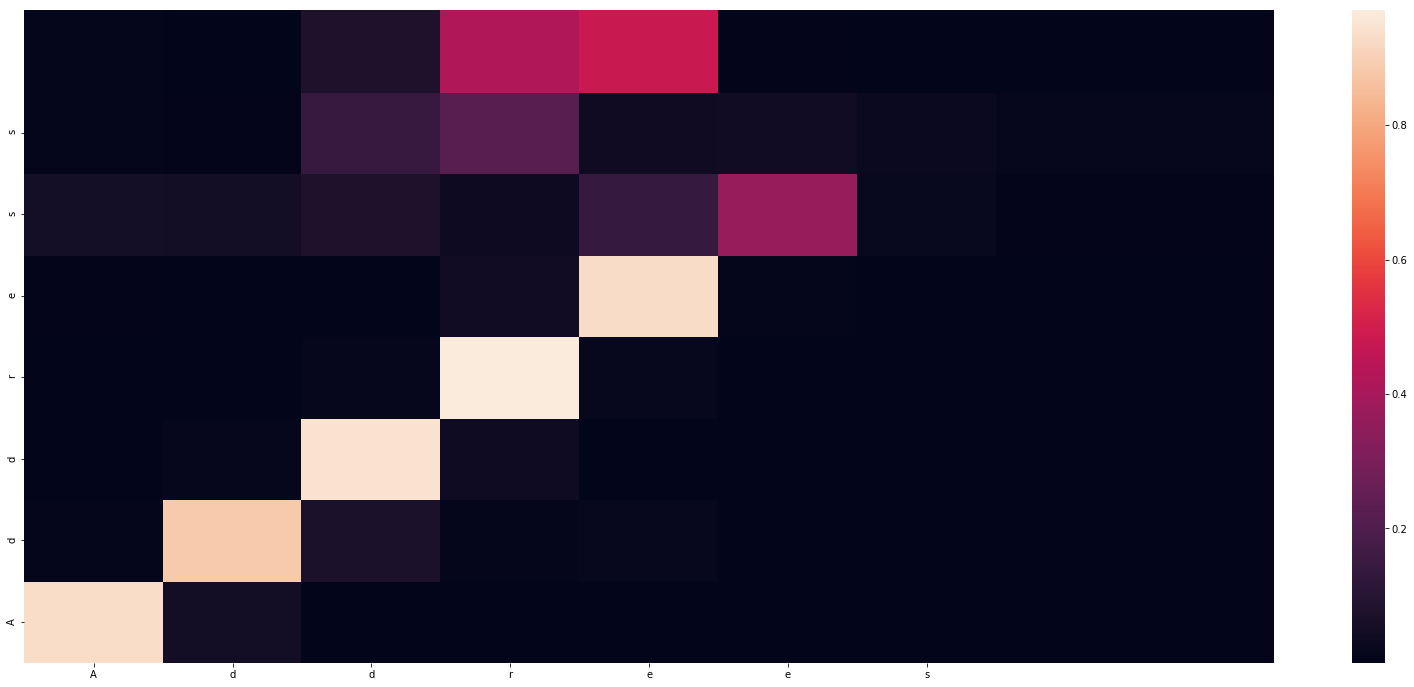

-
Input sentence: Addrees
GT sentence: Address

Decoded sentence: Address


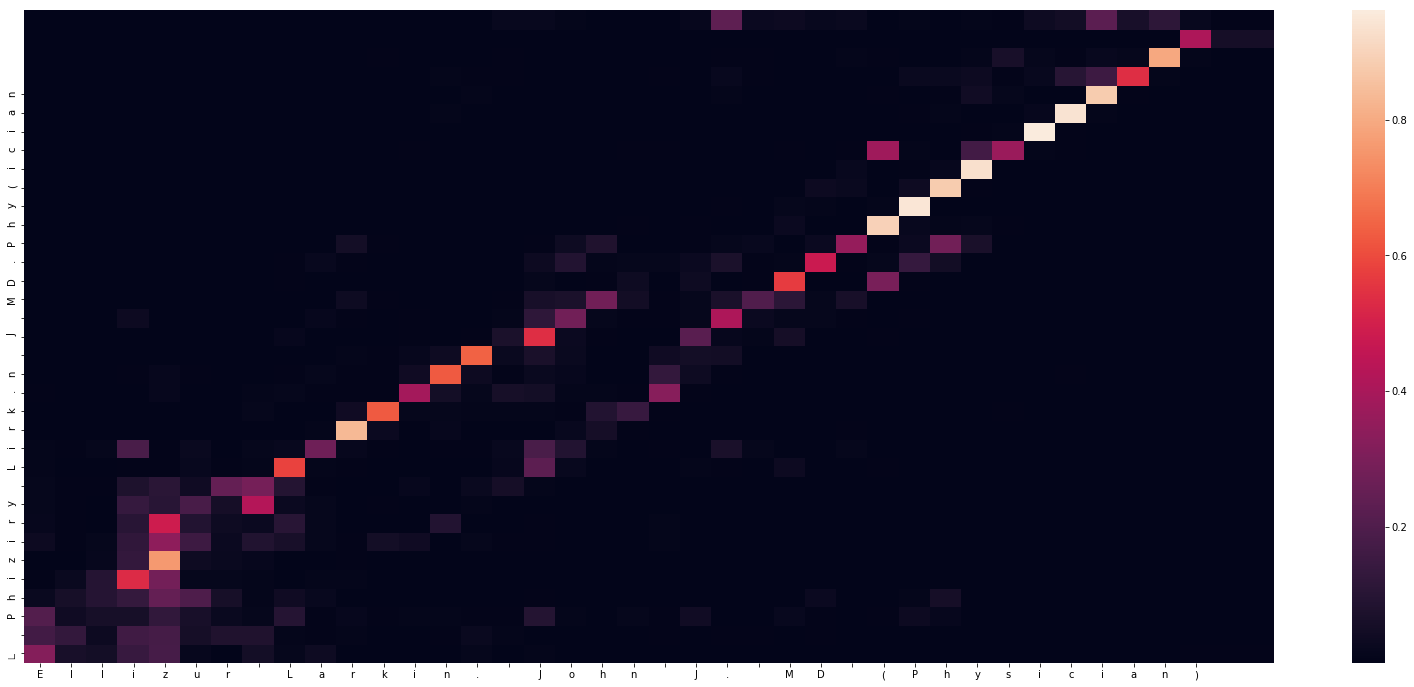

-
Input sentence: Ellizur Larkin. John J. MD (Physician)
GT sentence: Editor: Larkin, John J. MD (Physician)

Decoded sentence: ☐ Phiziry Lirk.n J MD.Phy(ician


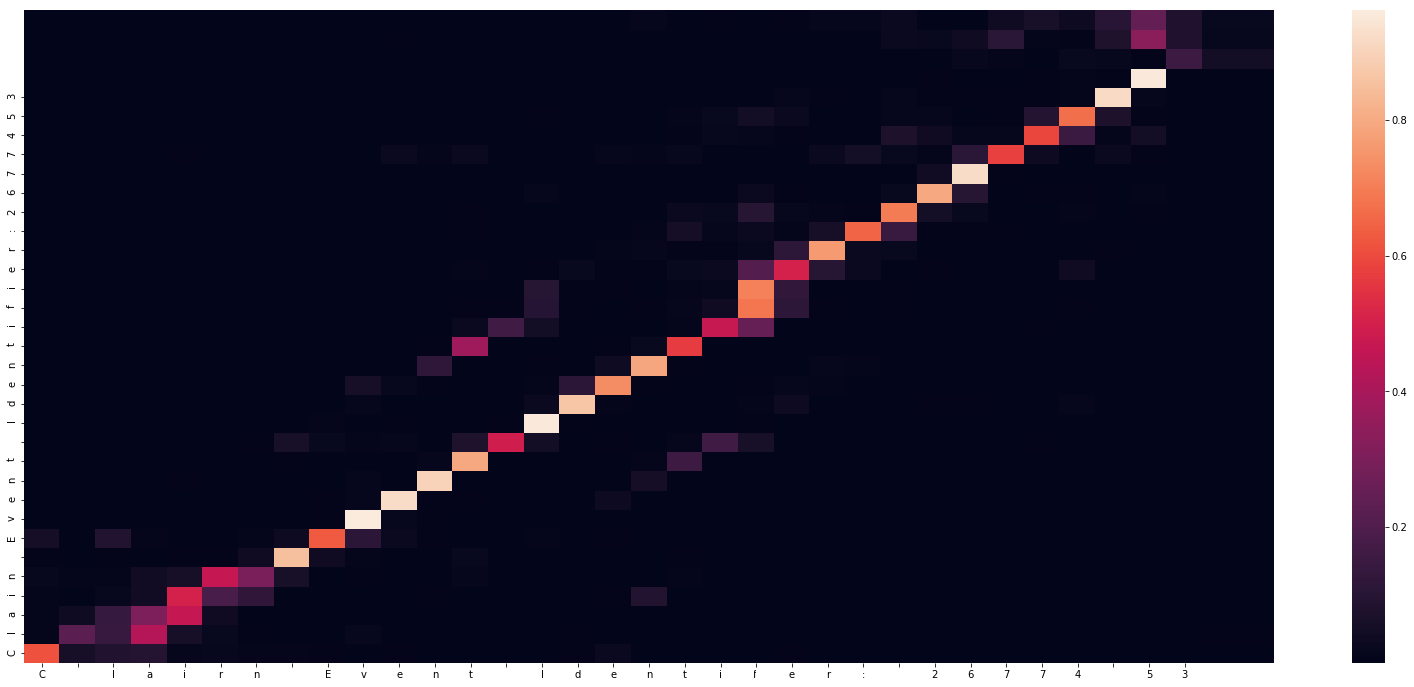

-
Input sentence: C lairn Event Identiﬁer: 26774 53
GT sentence: Clairn Event Identifier: 2677453

Decoded sentence: Clain Event Identifier:2677453


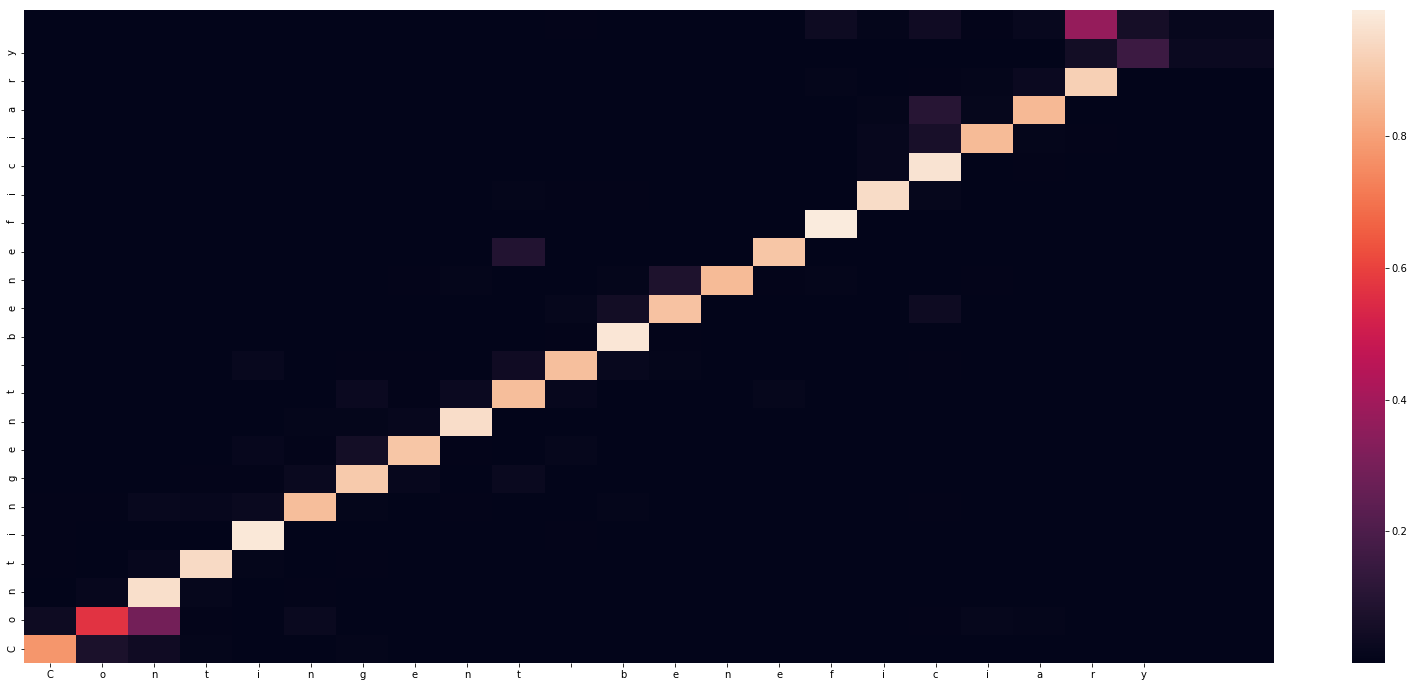

-
Input sentence: Contingent beneficiary
GT sentence: Contingent beneficiary

Decoded sentence: Contingent beneficiary


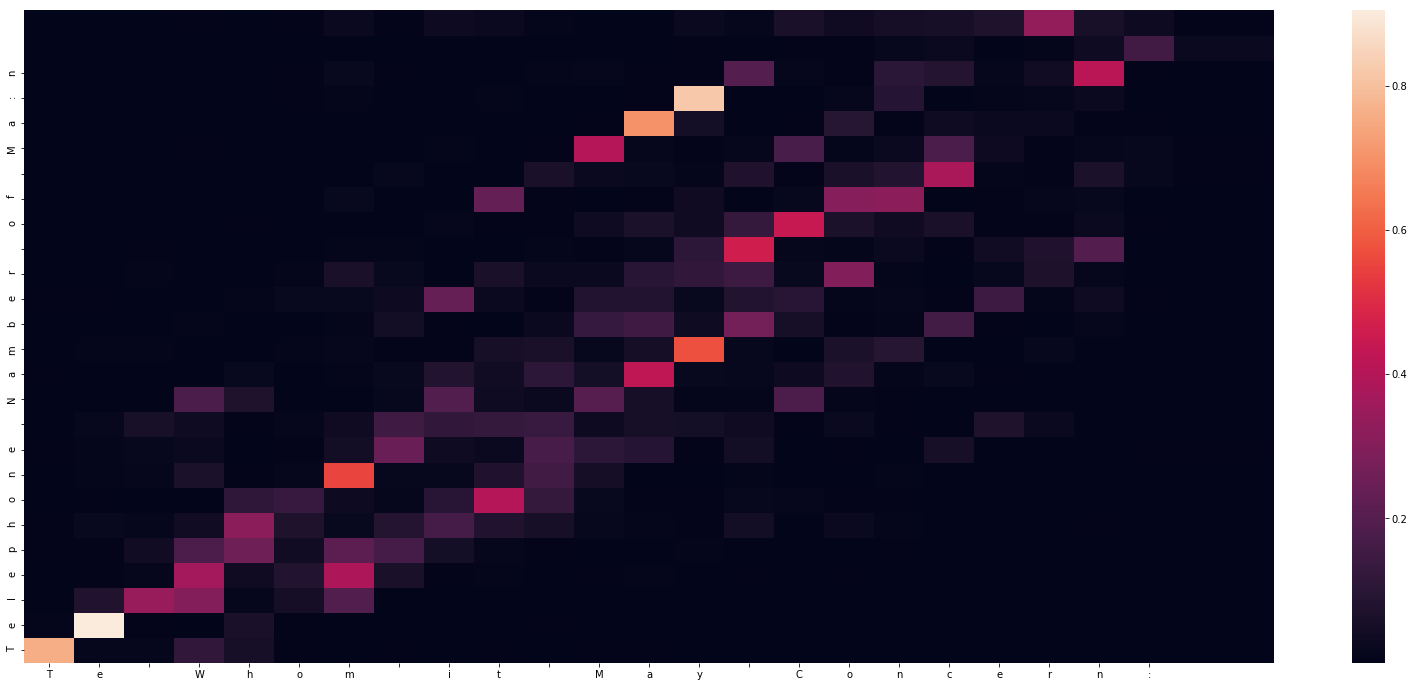

-
Input sentence: Te Whom it May Concern:
GT sentence: To Whom it May Concern:

Decoded sentence: Telephone Namber of Ma:n


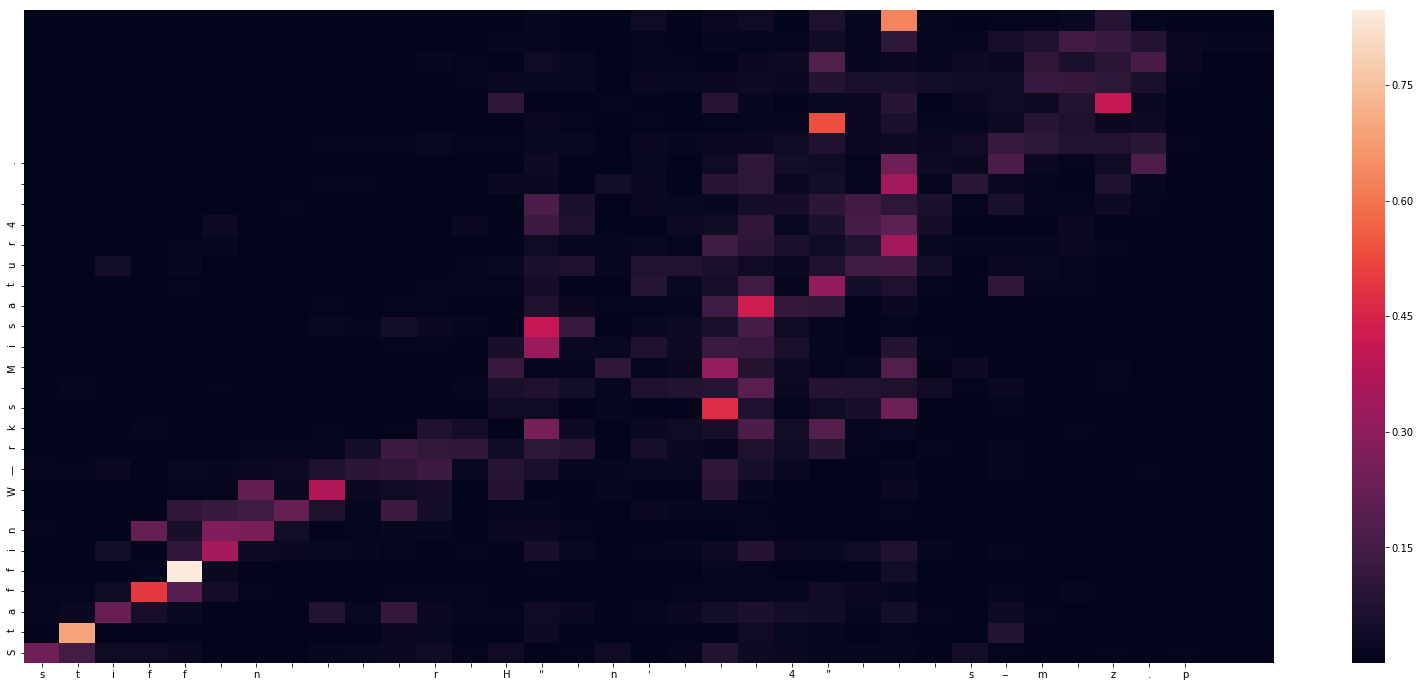

-
Input sentence: stiff n “—‘r H“ n‘ ““4” “ s—m z.p
GT sentence: City State Zip

Decoded sentence: Staffin W—rks Misatur4 —.


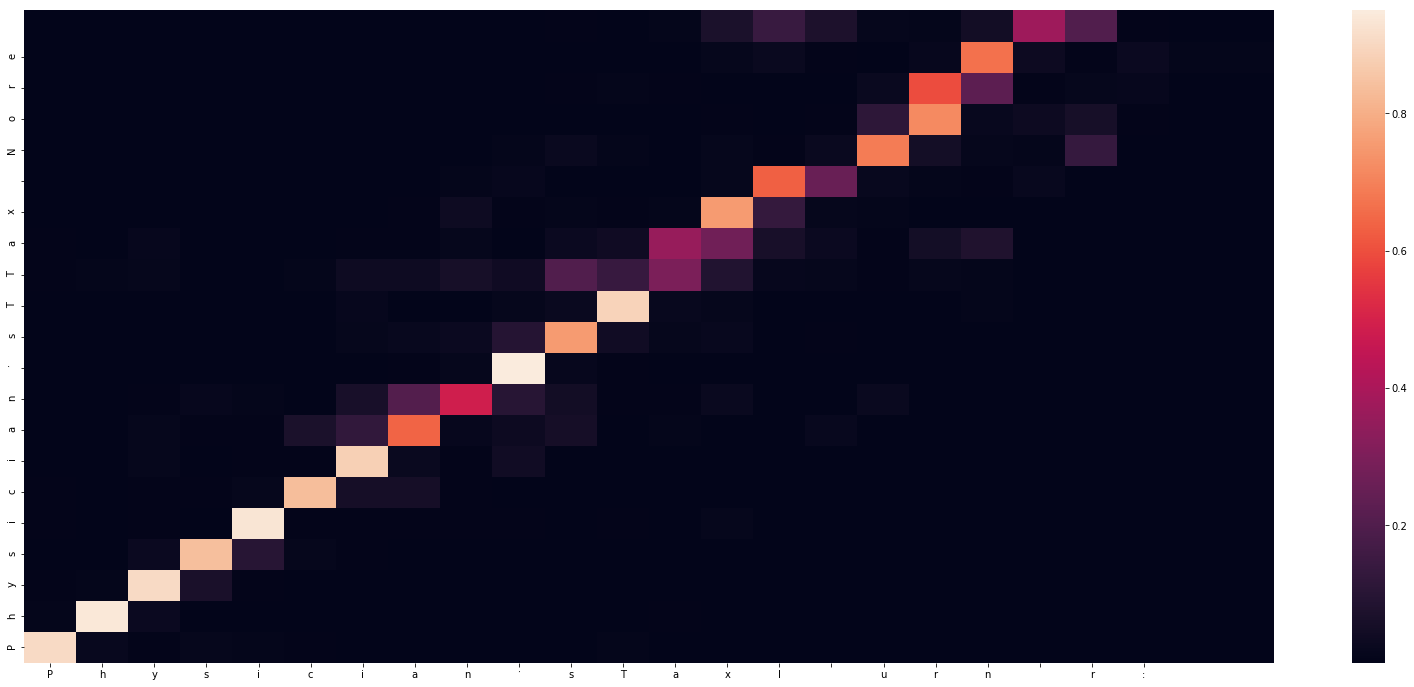

-
Input sentence: Physician’sTaxl urn r:
GT sentence: Physician’s Tax ID Number:

Decoded sentence: Physician’sTTax Nore


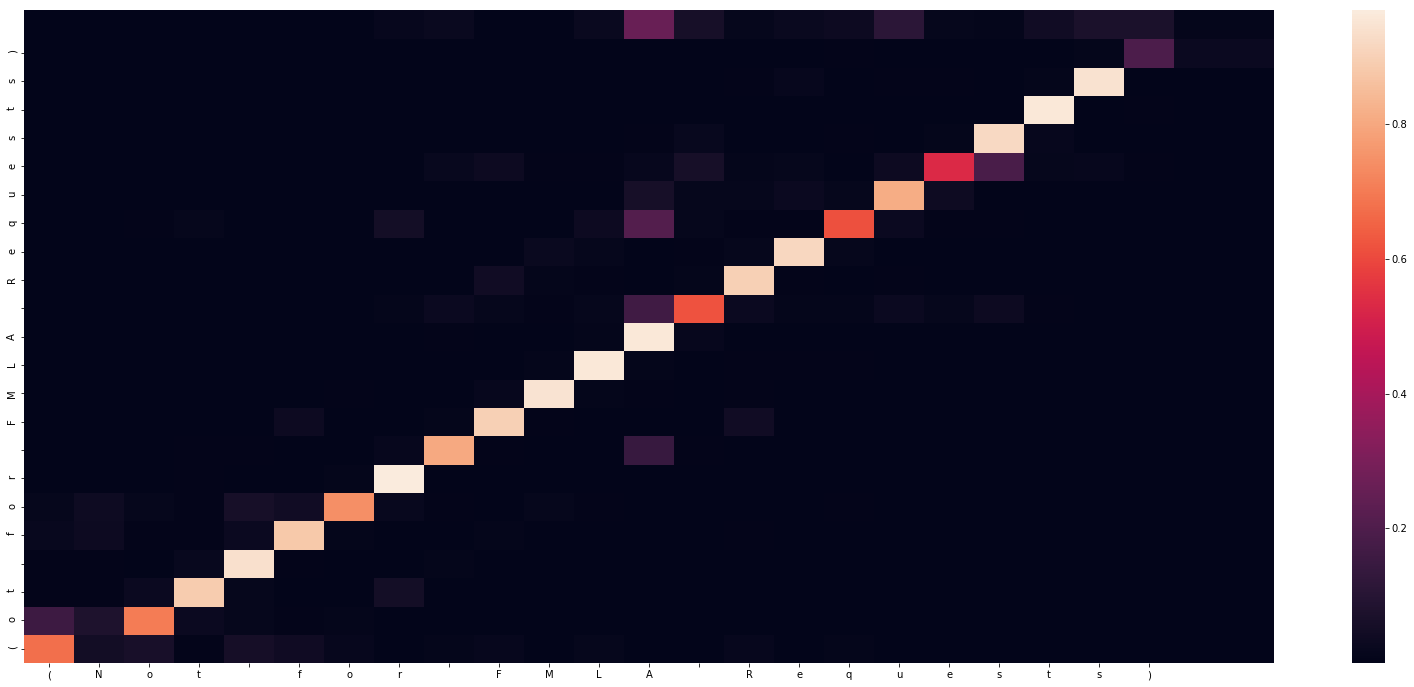

-
Input sentence: (Not for FMLA Requests)
GT sentence: (Not for FMLA Requests)

Decoded sentence: (ot for FMLA Requests)


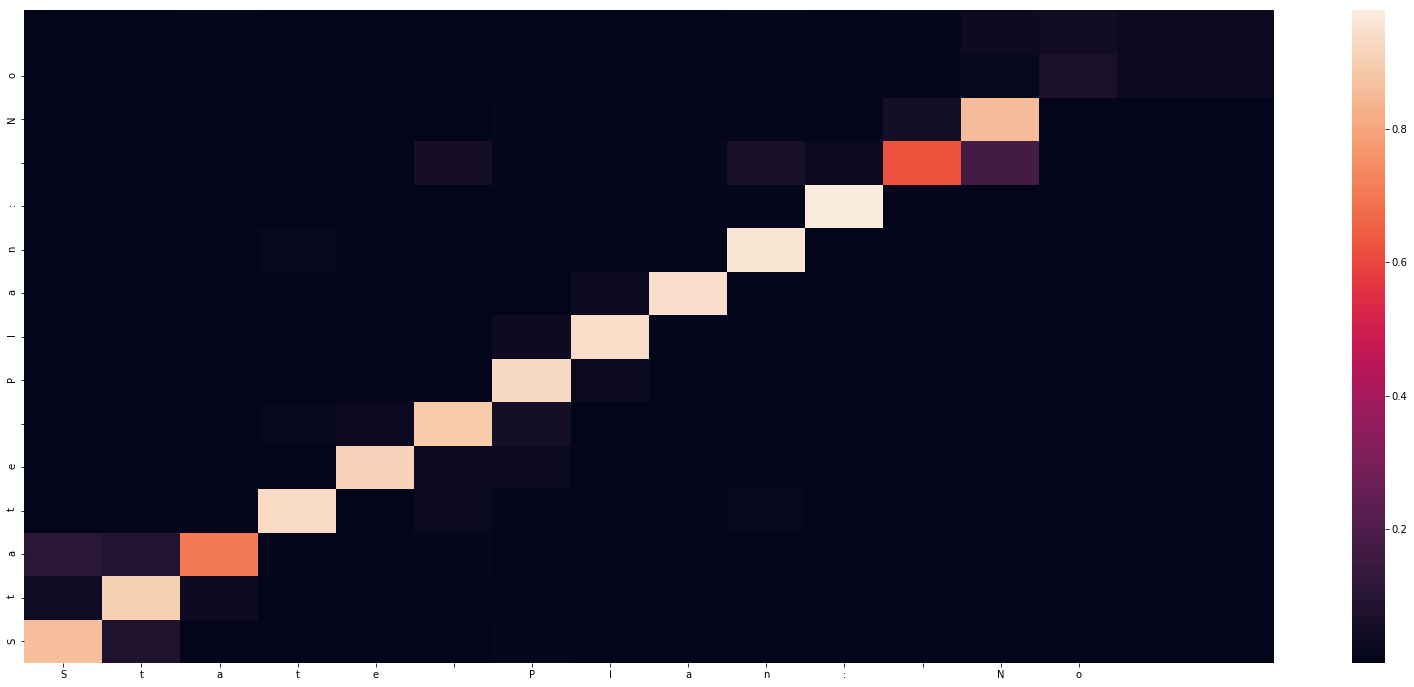

-
Input sentence: State Plan: No
GT sentence: State Plan: No

Decoded sentence: State Plan: No


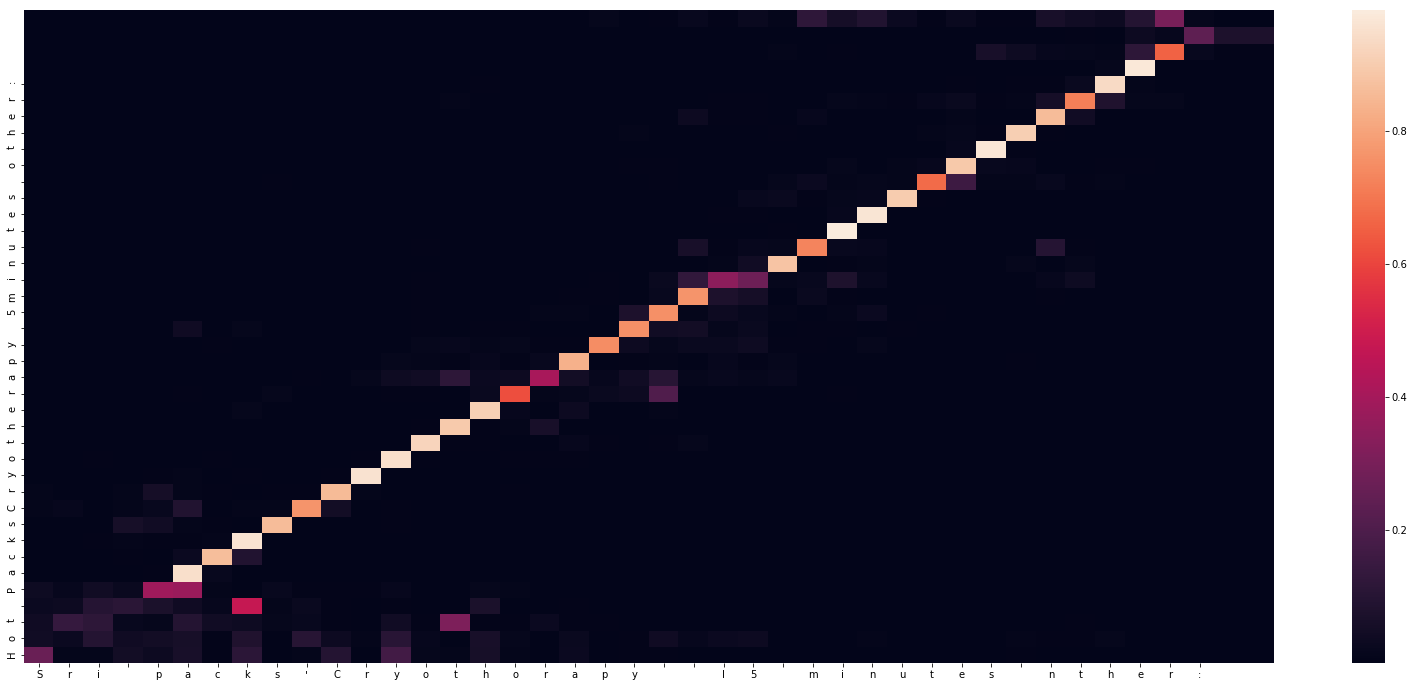

-
Input sentence: Sri packs'Cryothorapy “I5 minutes nther:
GT sentence: Hot Packs/Cryotherapy 15 minutes other:

Decoded sentence: Hot PacksCryotherapy 5minutes other:


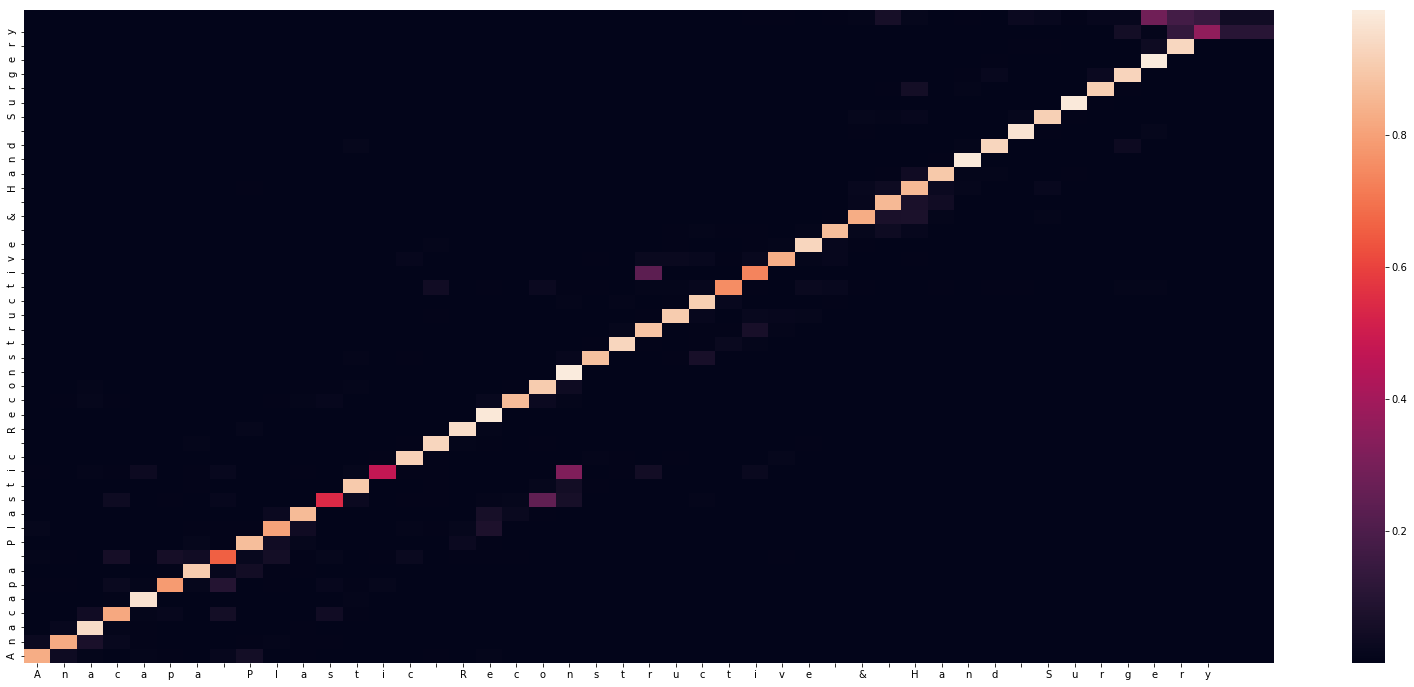

-
Input sentence: Anacapa Plastic Reconstructive & Hand Surgery
GT sentence: Anacapa Plastic Reconstructive & Hand Surgery

Decoded sentence: Anacapa Plastic Reconstructive & Hand Surgery


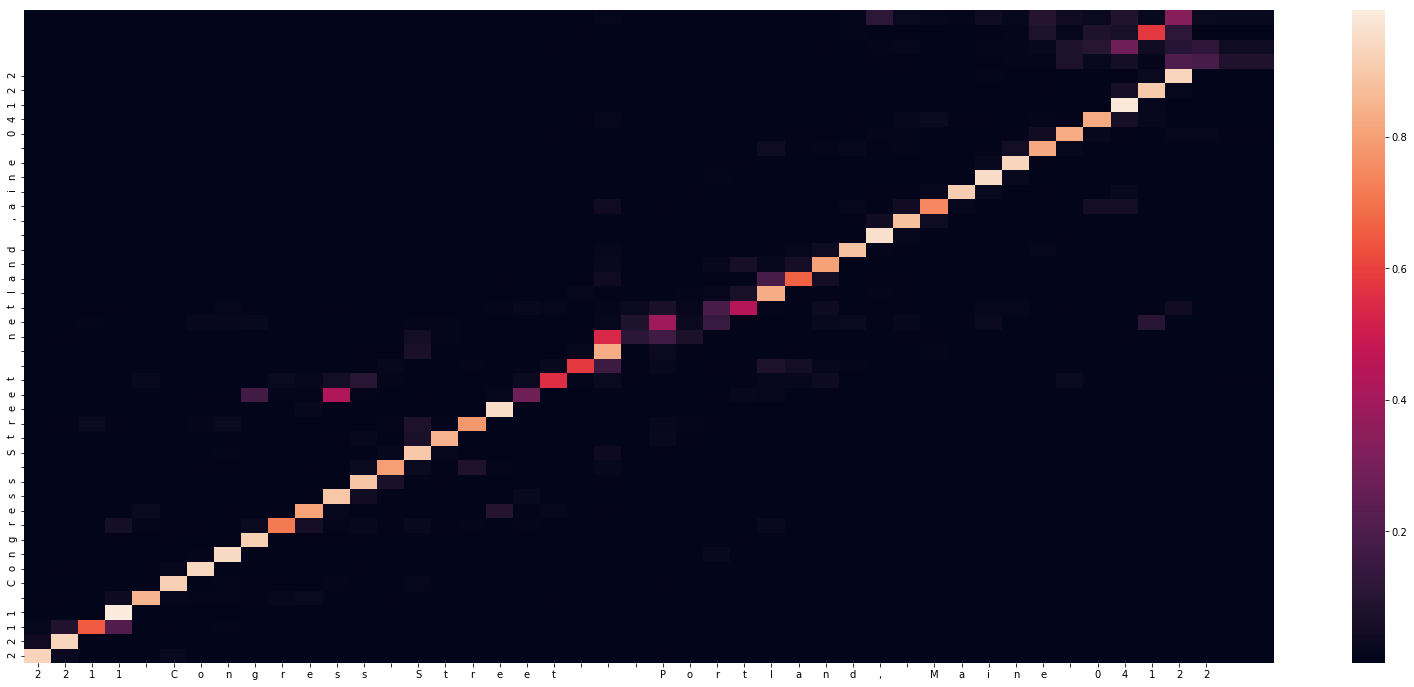

-
Input sentence: 2211 Congress Street ° Portland, Maine 04122
GT sentence: 2211 Congress Street • Portland, Maine 04122

Decoded sentence: 2211 Congress Street ◦netland ,aine 04122


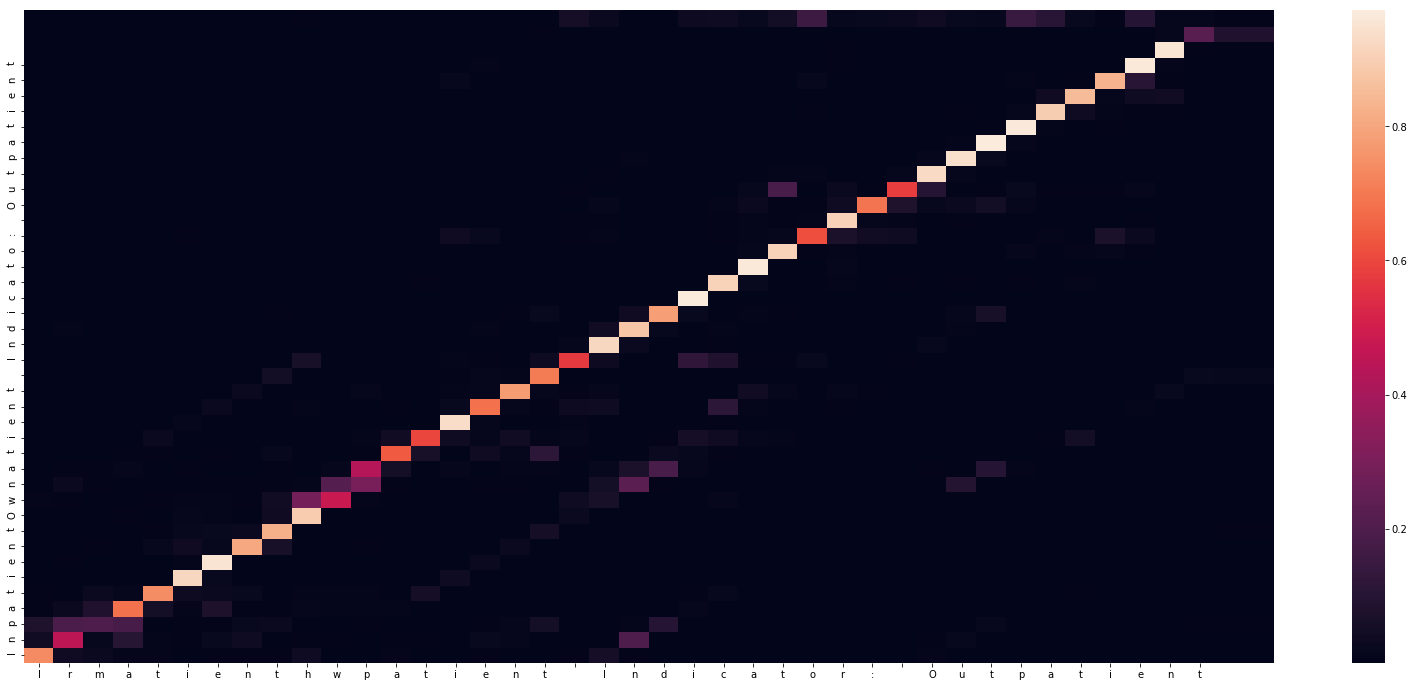

-
Input sentence: Irmatienthwpatient Indicator: Outpatient
GT sentence: Inpatient/Outpatient Indicator: Outpatient

Decoded sentence: InpatientOwnatient Indicato: Outpatient


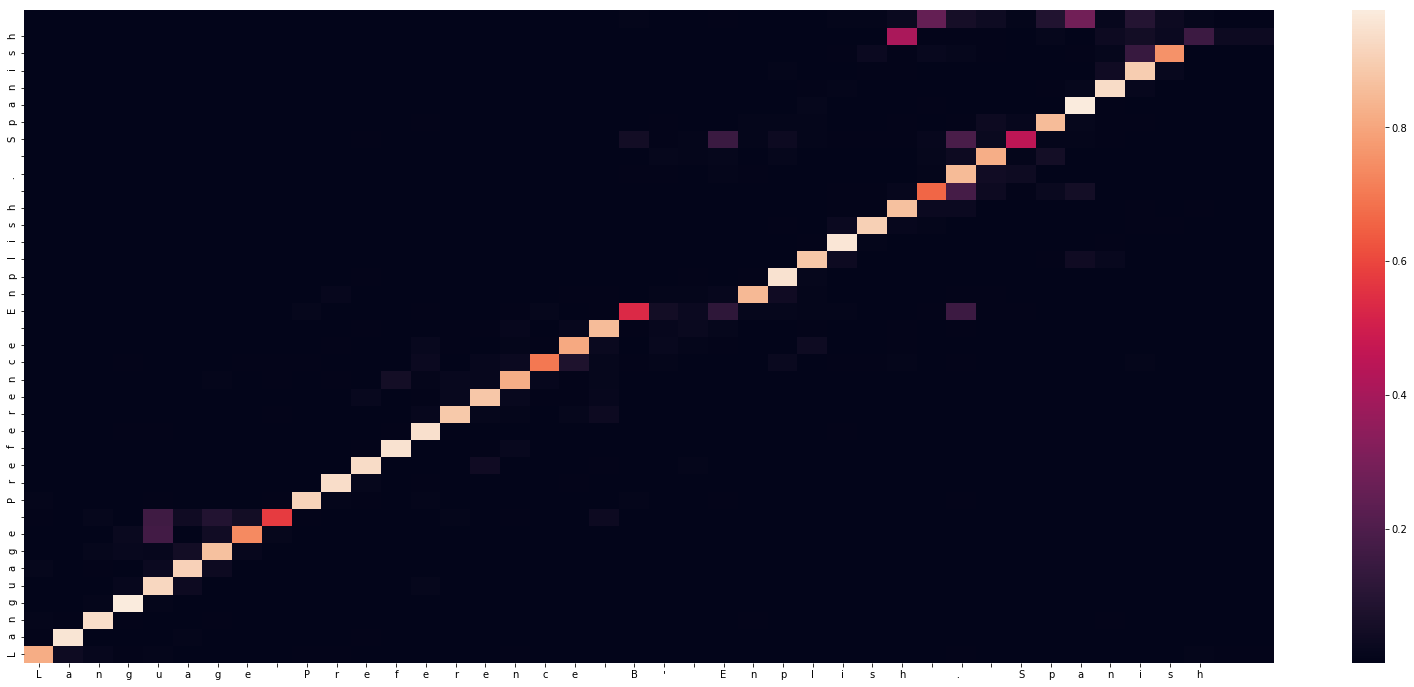

-
Input sentence: Language Preference B' Enplish ☐ Spanish
GT sentence: Language Preference ☑ English ☐ Spanish

Decoded sentence: Language Preference Enplish ☐ Spanish


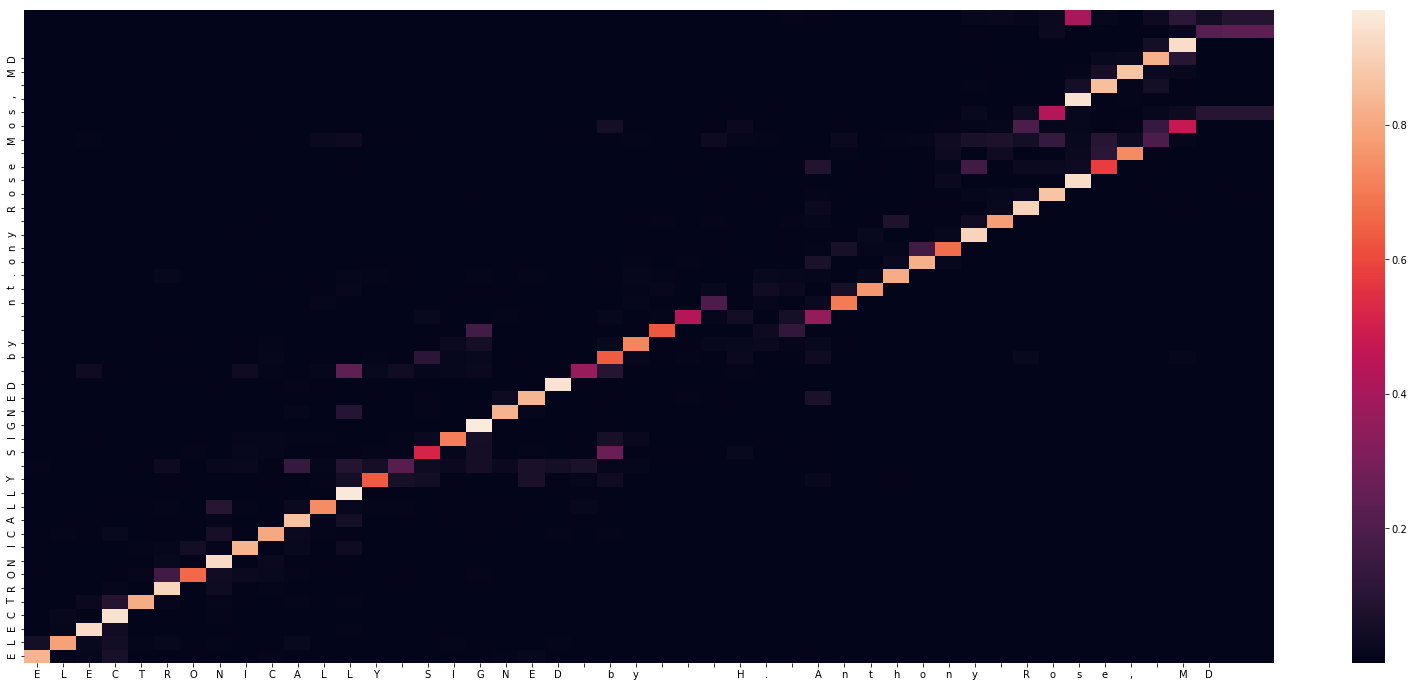

-
Input sentence: ELECTRONICALLY SIGNED by — H. Anthony Rose, MD
GT sentence: ELECTRONICALLY SIGNED by - H. Anthony Rose, MD

Decoded sentence: ELECTRONICALLY SIGNED by —nt.ony Rose Mos, MD


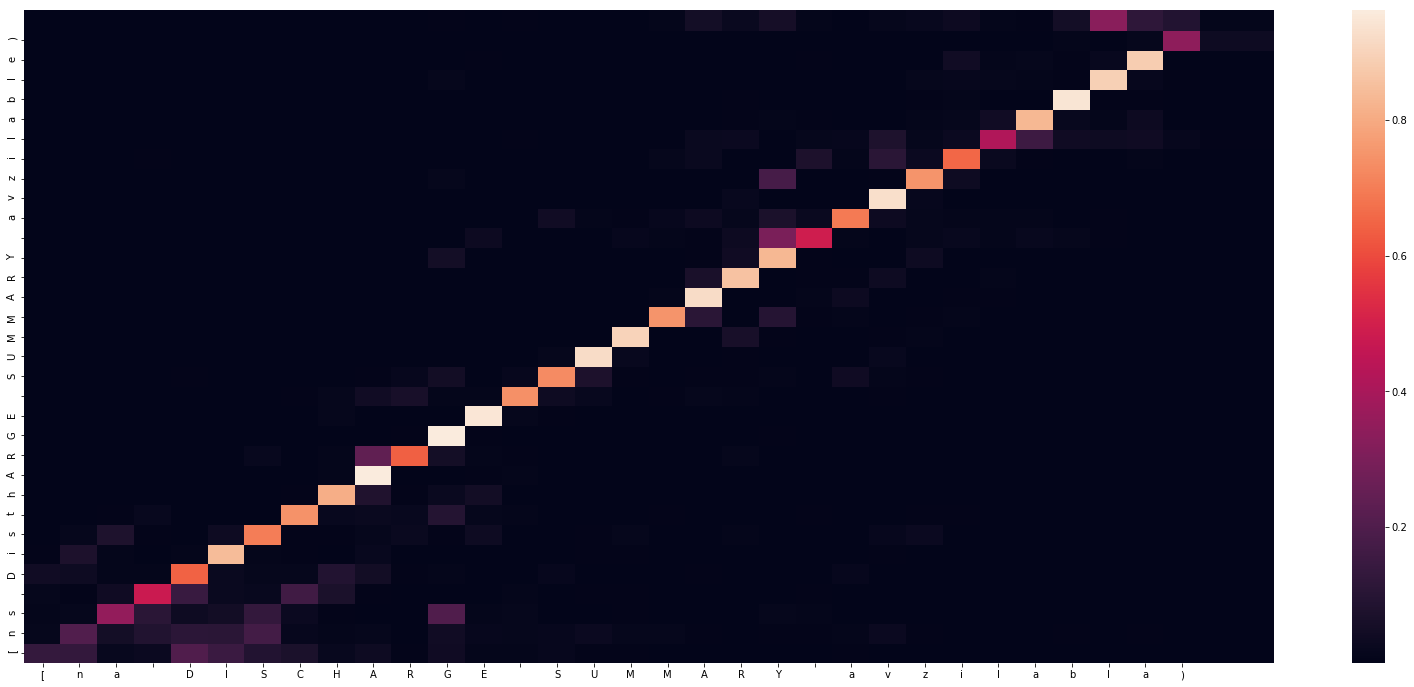

-
Input sentence: [na DISCHARGE SUMMARY avzilabla)
GT sentence: [no DISCHARGE SUMMARY available)

Decoded sentence: [ns DisthARGE SUMMARY avzilable)


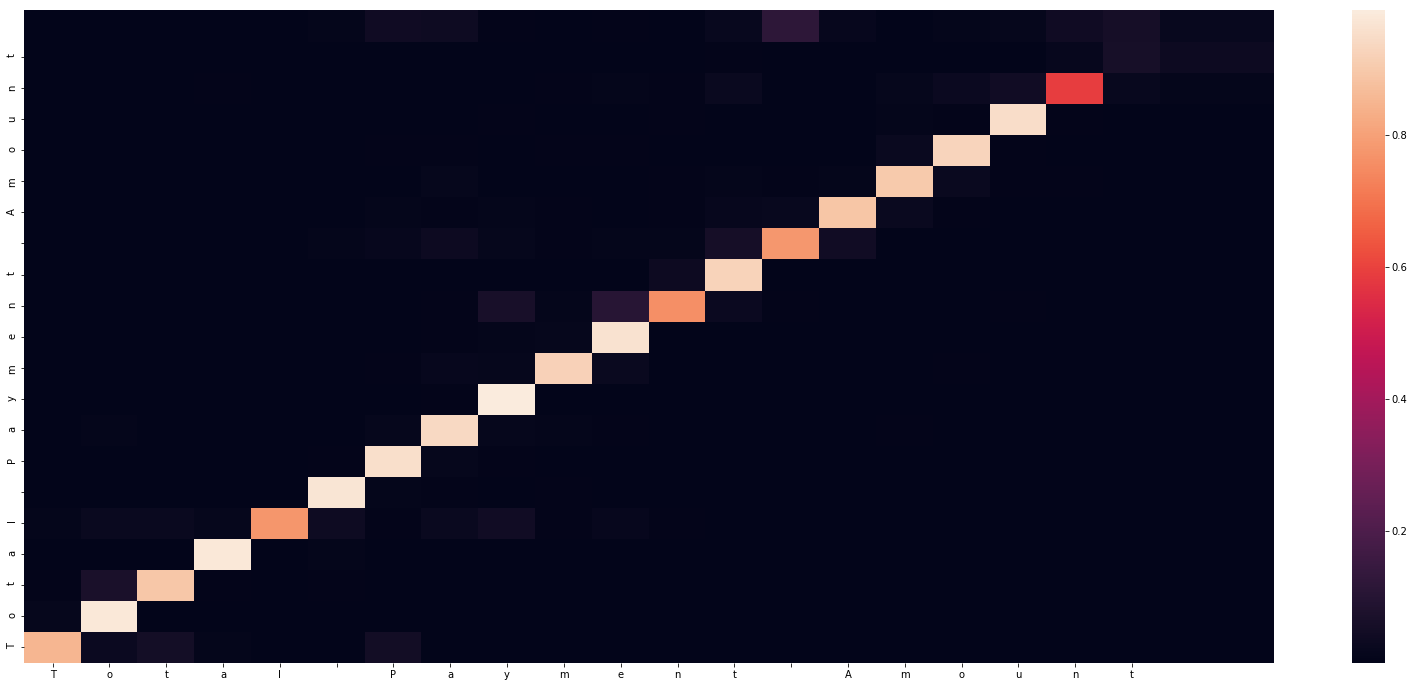

-
Input sentence: Total Payment Amount
GT sentence: Total Payment Amount

Decoded sentence: Total Payment Amount


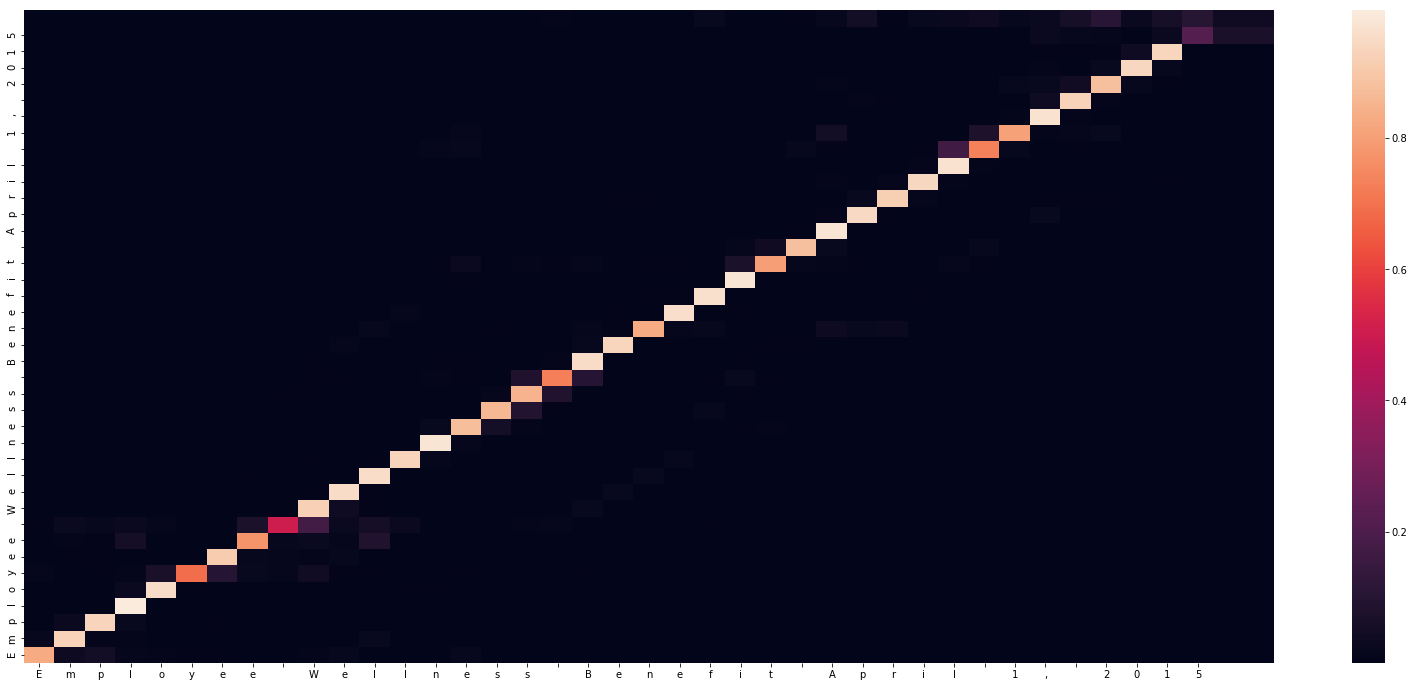

-
Input sentence: Employee Wellness Benefit April 1, 2015
GT sentence: Employee Wellness Benefit April 1, 2015

Decoded sentence: Employee Wellness Benefit April 1, 2015


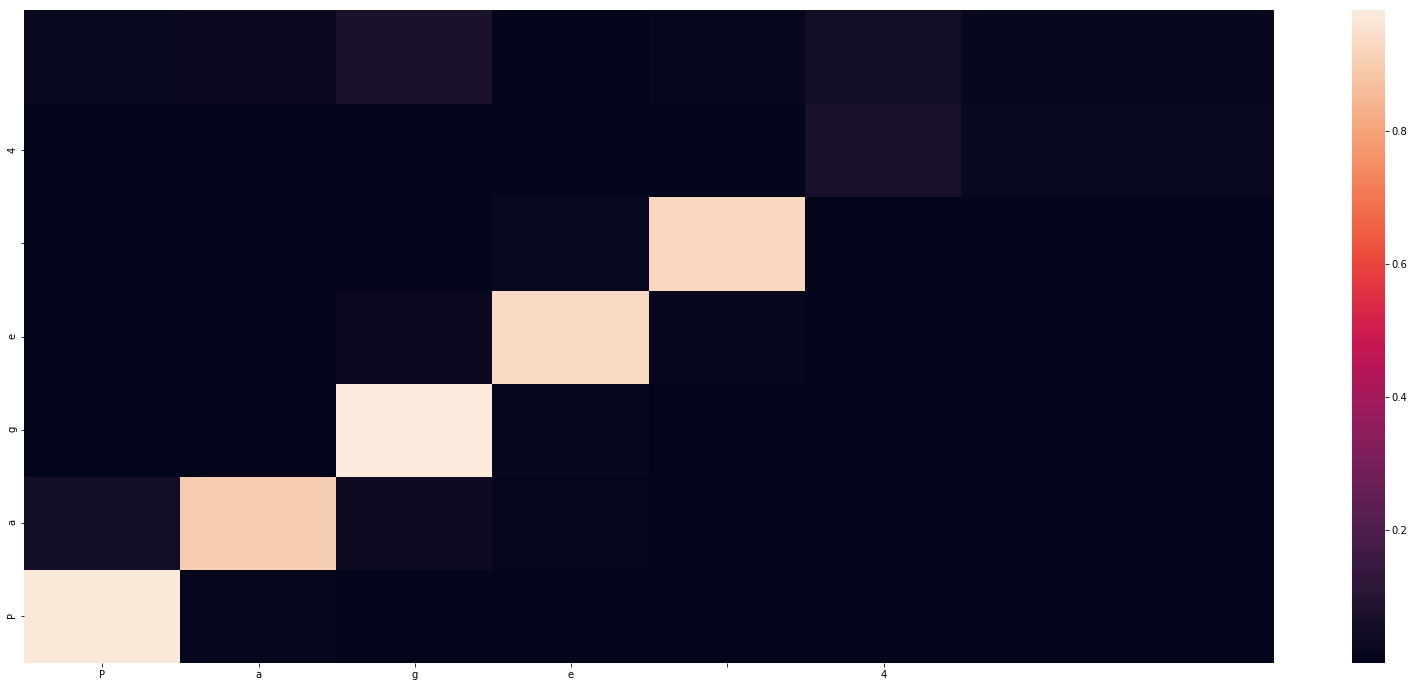

-
Input sentence: Page 4
GT sentence: Page 4

Decoded sentence: Page 4


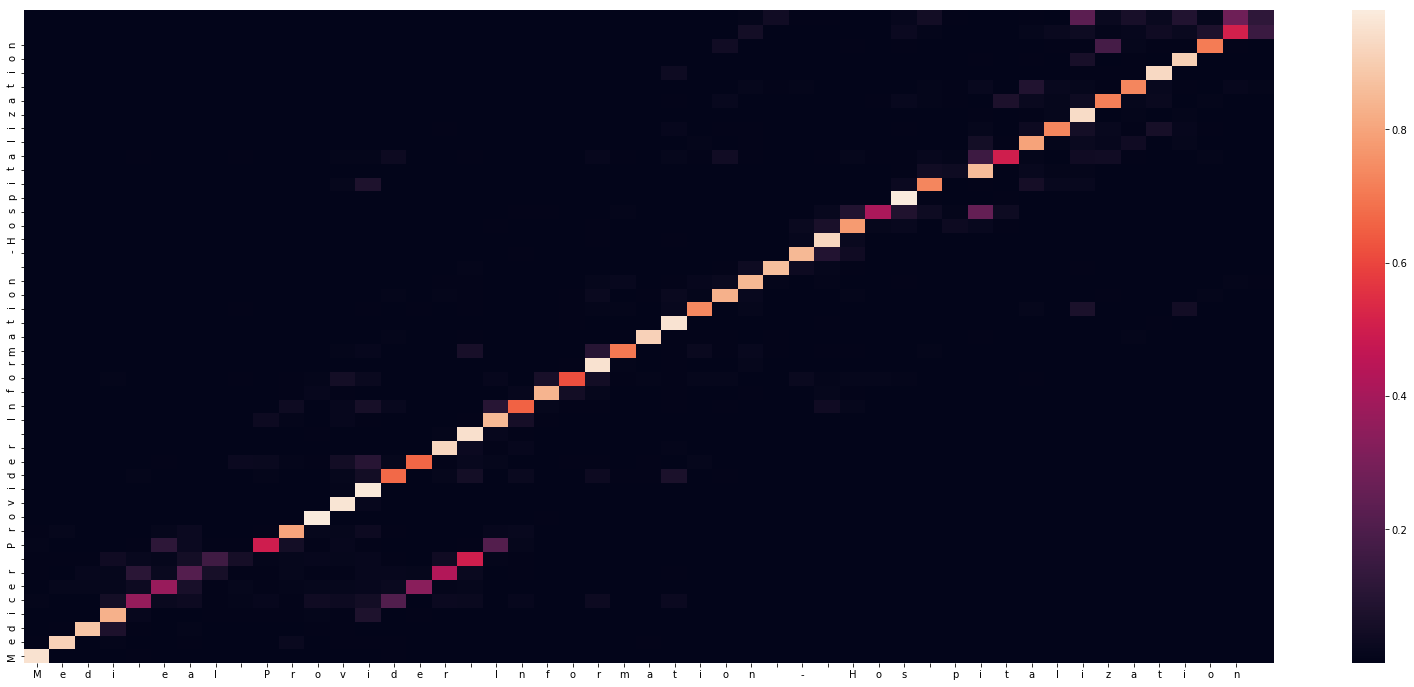

-
Input sentence: Medi eal Provider Information - Hos pitalization
GT sentence: Medical Provider Information - Hospitalization

Decoded sentence: Medicer Provider Information -Hospitalization


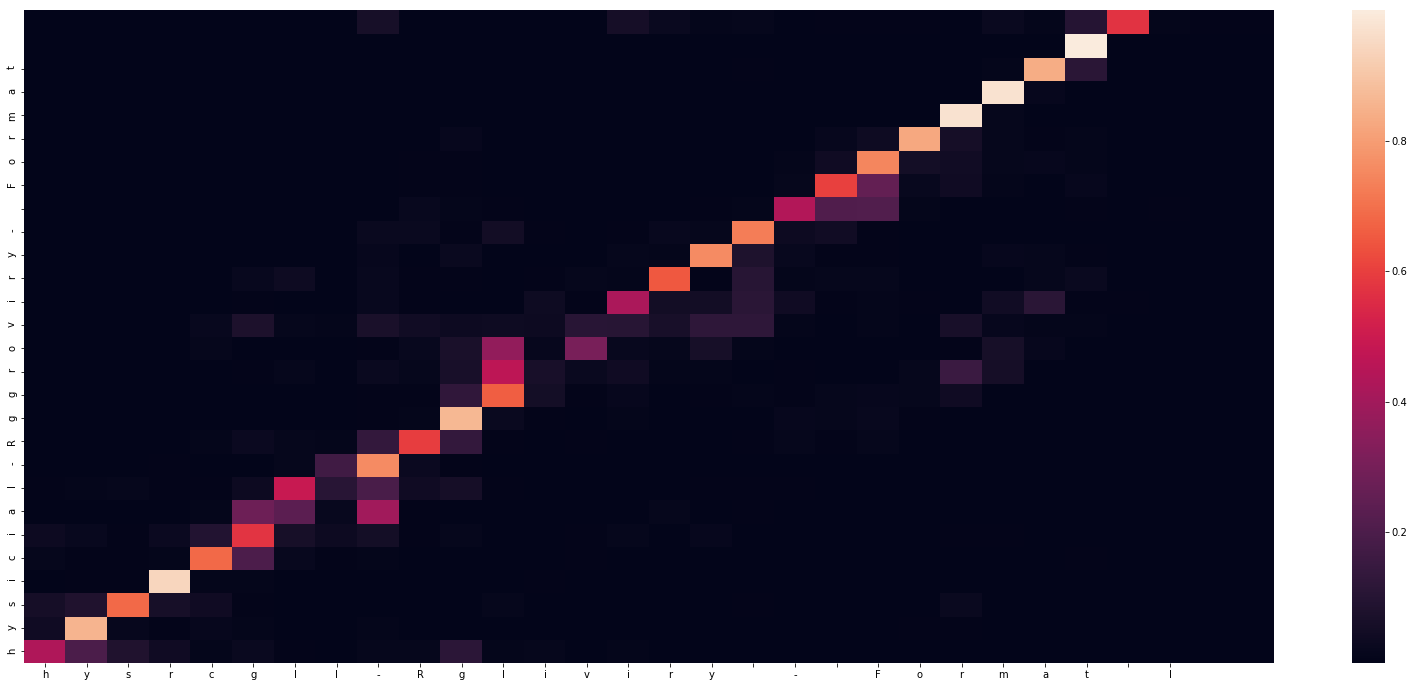

-
Input sentence: hysrcgll-Rgliviry - Format I
GT sentence: Physical Activity - Format I

Decoded sentence: hysicial-Rggroviry- Format


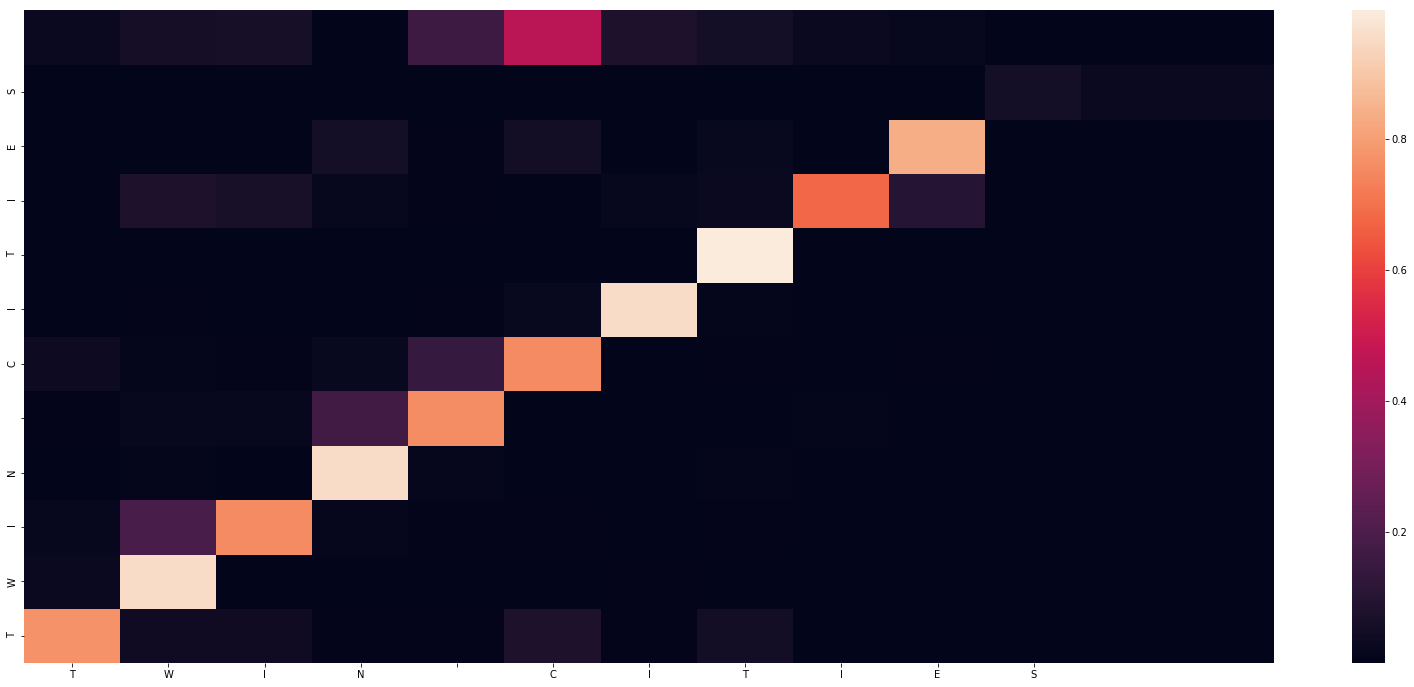

-
Input sentence: TWIN CITIES
GT sentence: TWIN CITIES

Decoded sentence: TWIN CITIES


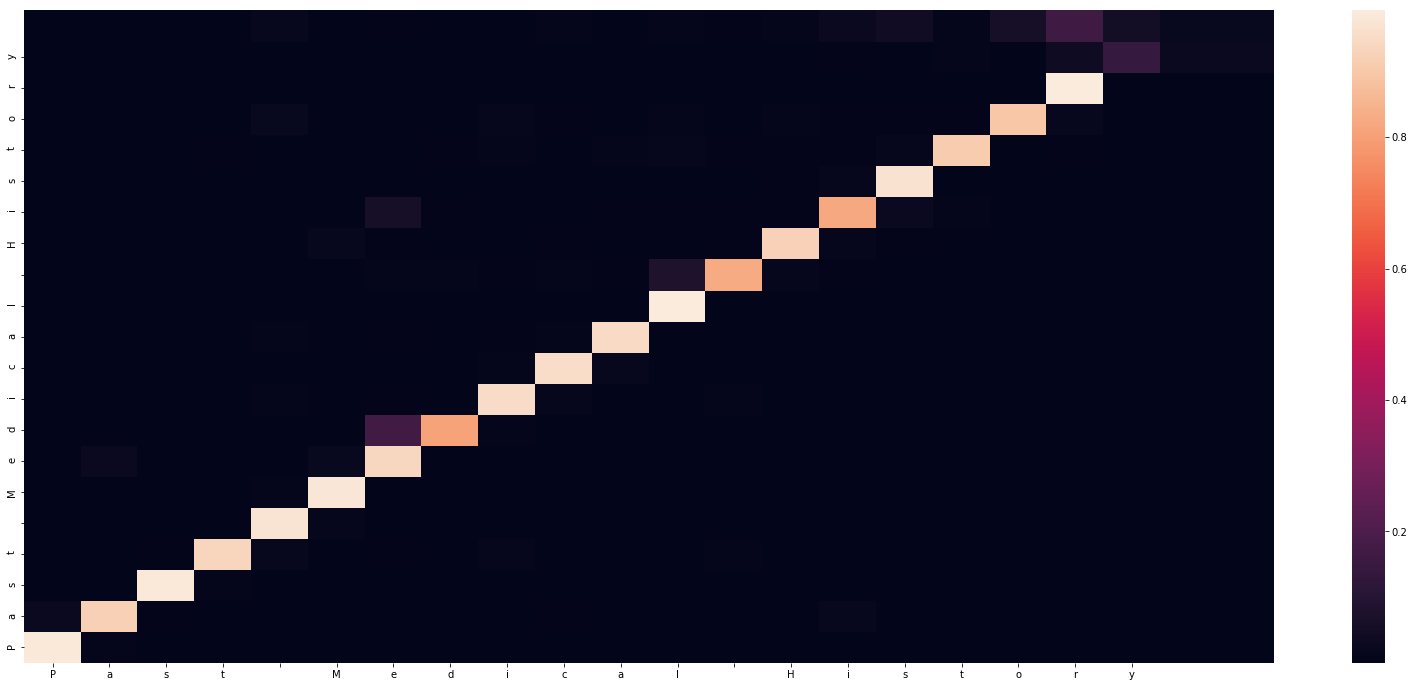

-
Input sentence: Past Medical History
GT sentence: Past Medical History

Decoded sentence: Past Medical History


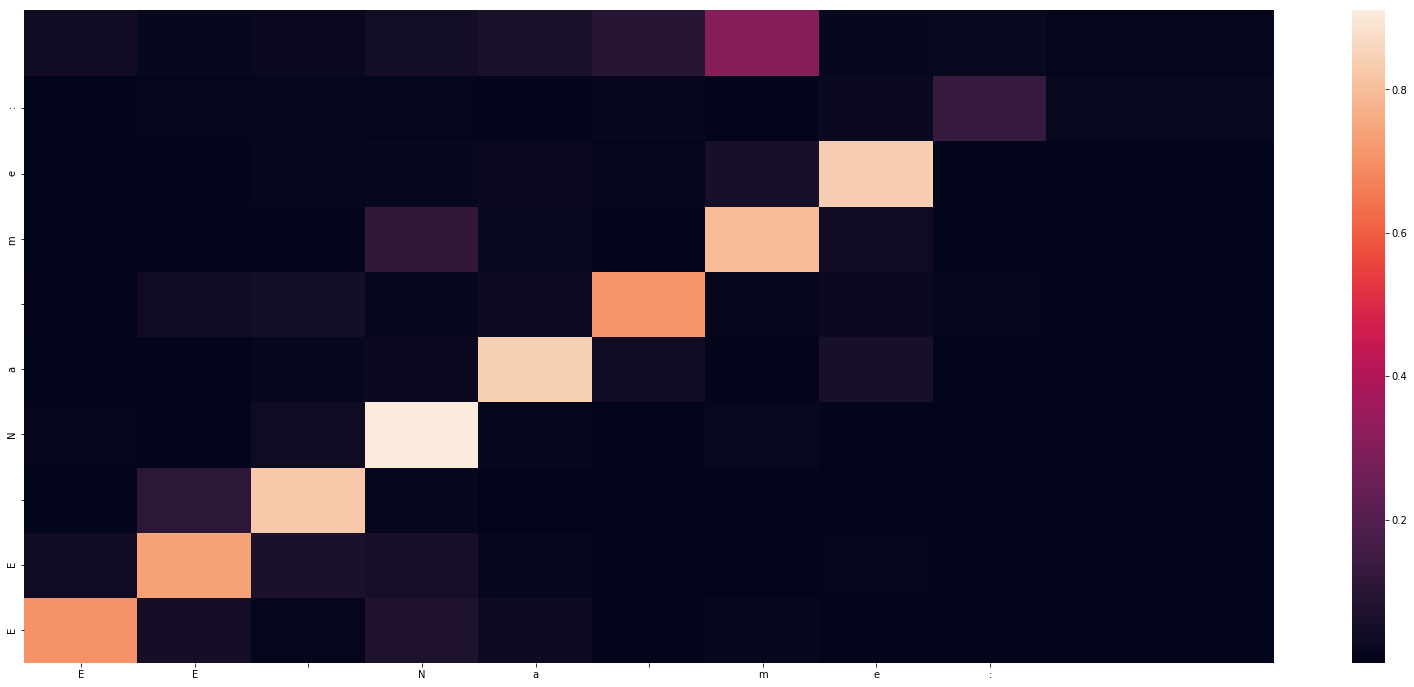

-
Input sentence: EE Na me:
GT sentence: EE Name:

Decoded sentence: EE Na me:


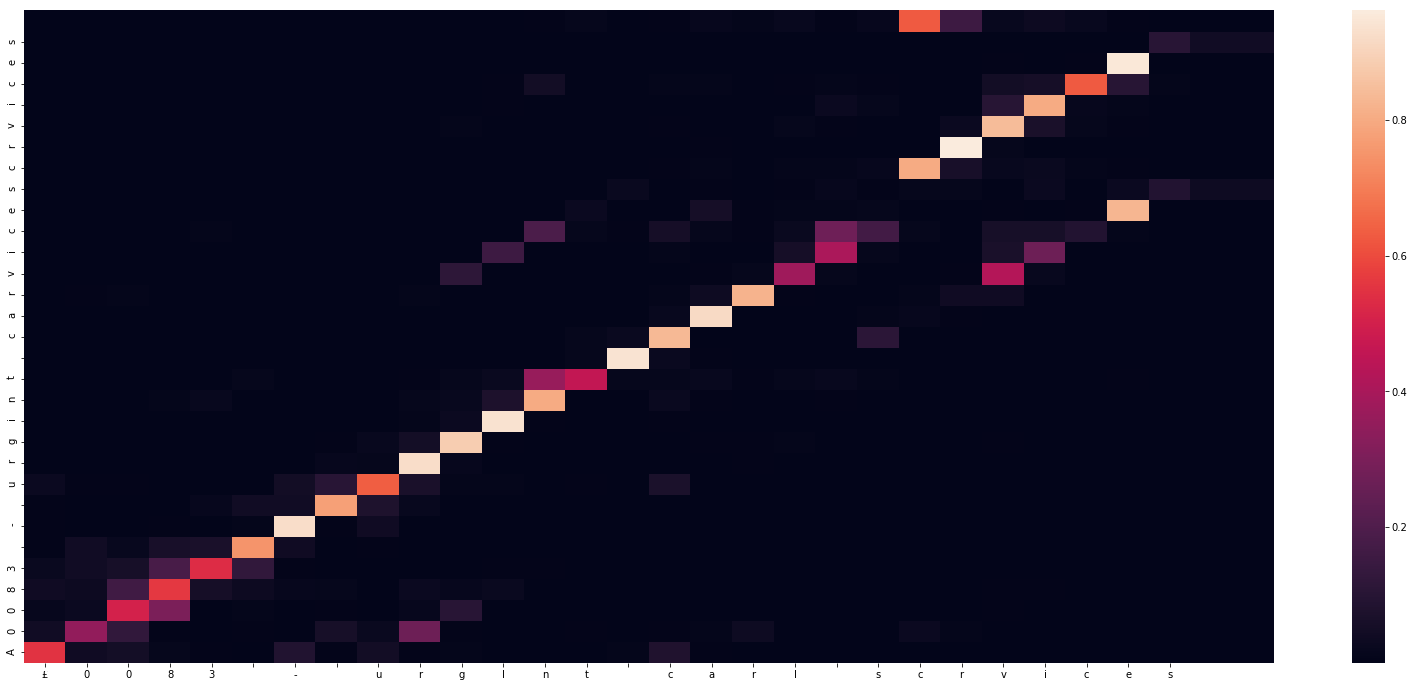

-
Input sentence: £0083 - urglnt carl scrvices
GT sentence: S9088 - URGENT CARE SERVICES

Decoded sentence: A0083 - urgint carvicescrvices


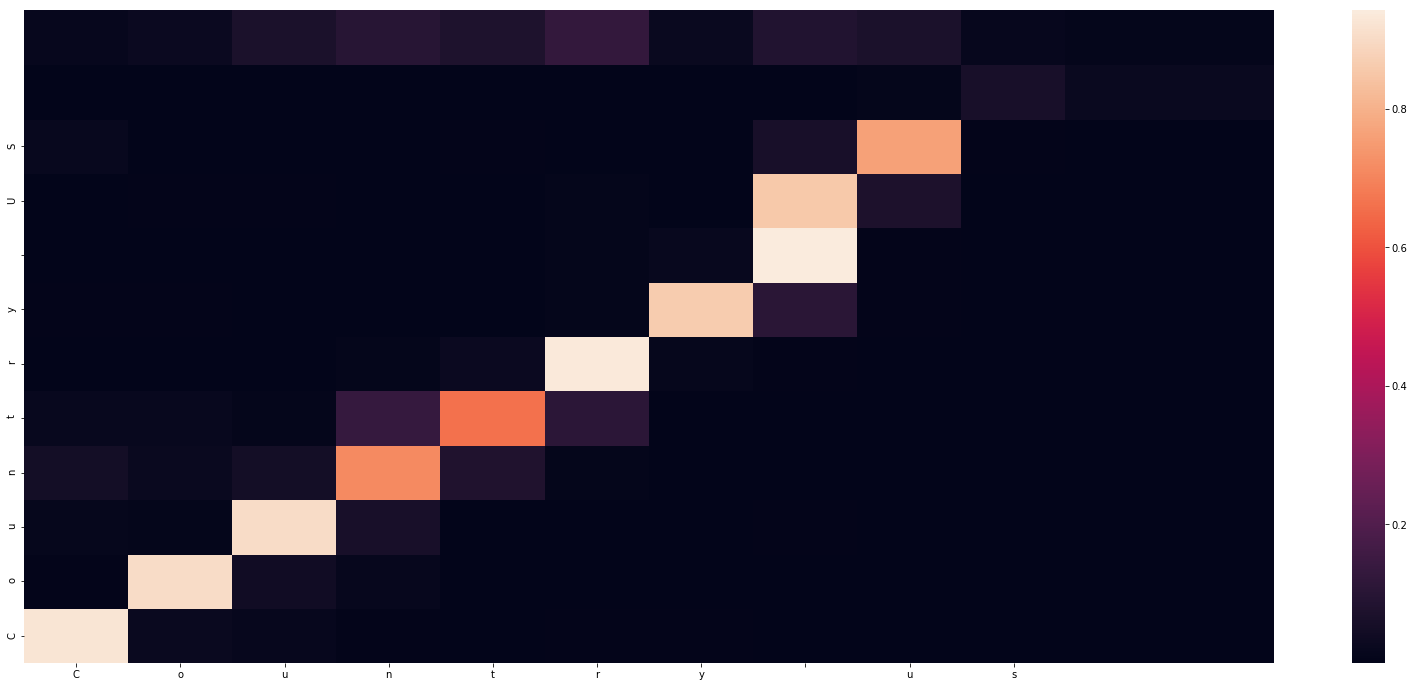

-
Input sentence: Country us
GT sentence: Country: US

Decoded sentence: Country US


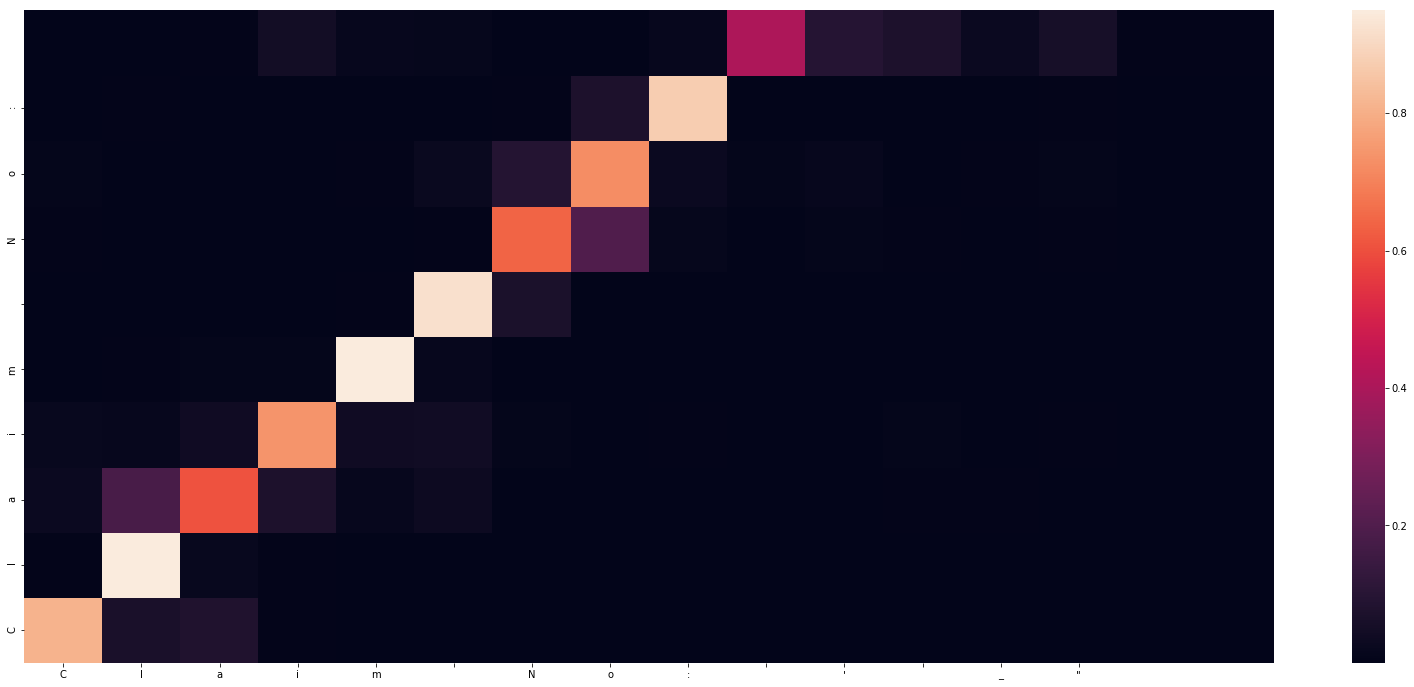

-
Input sentence: Claim No: ' _"
GT sentence: Claim No:

Decoded sentence: Claim No:


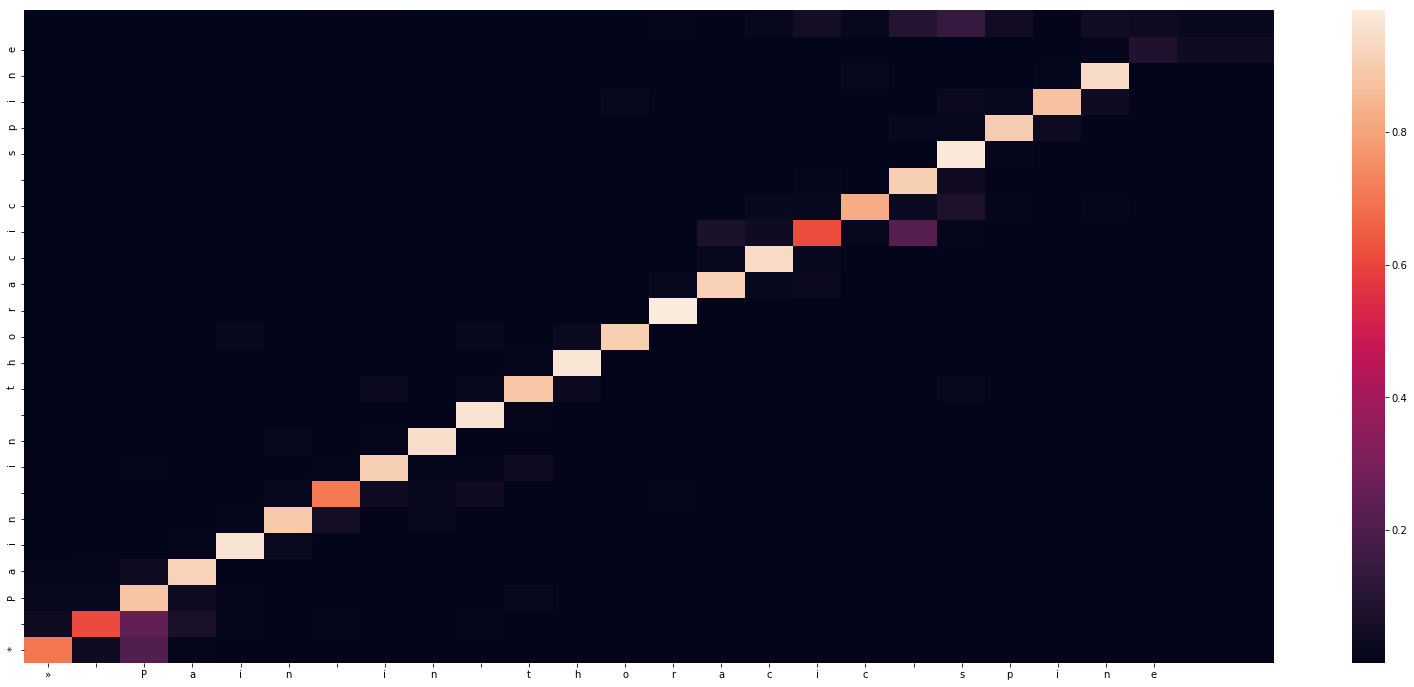

-
Input sentence: » Pain in thoracic spine
GT sentence: • Pain in thoracic spine

Decoded sentence: * Pain in thoracic spine


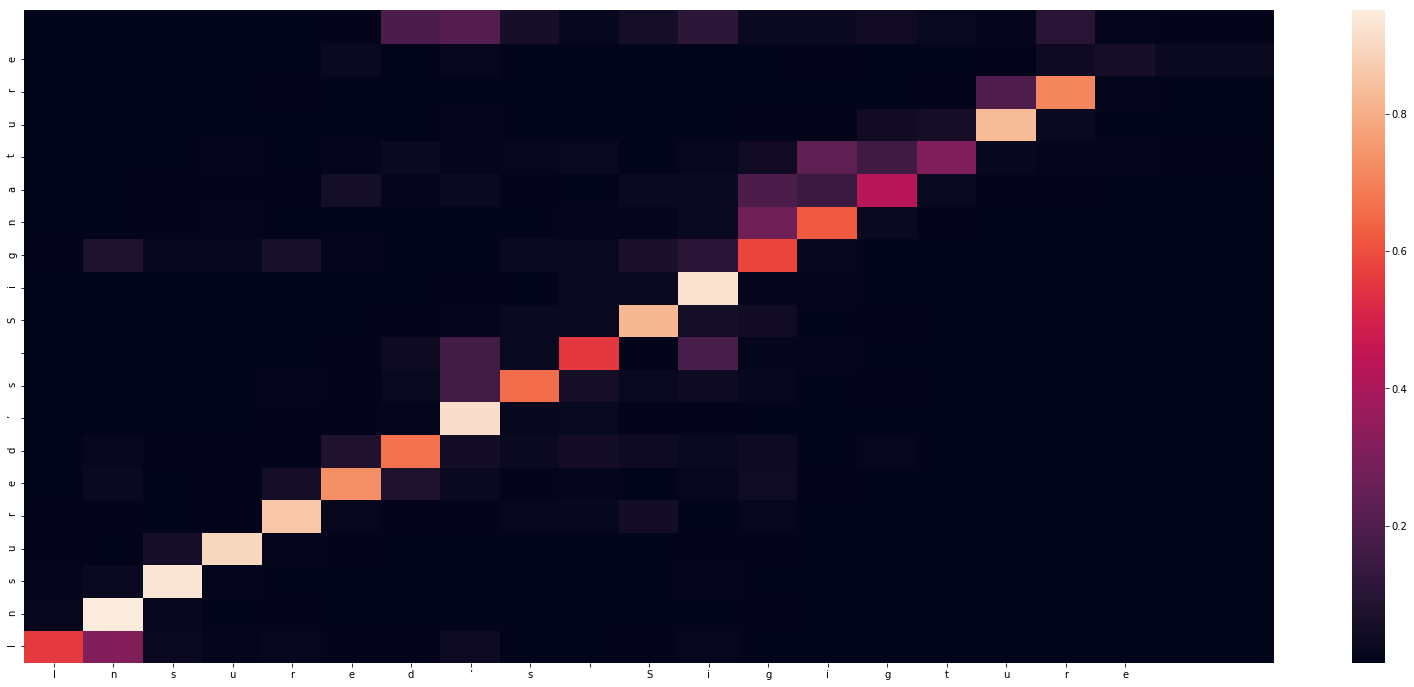

-
Input sentence: Insured’s Sigigture
GT sentence: Insured’s Signature

Decoded sentence: Insured’s Signature


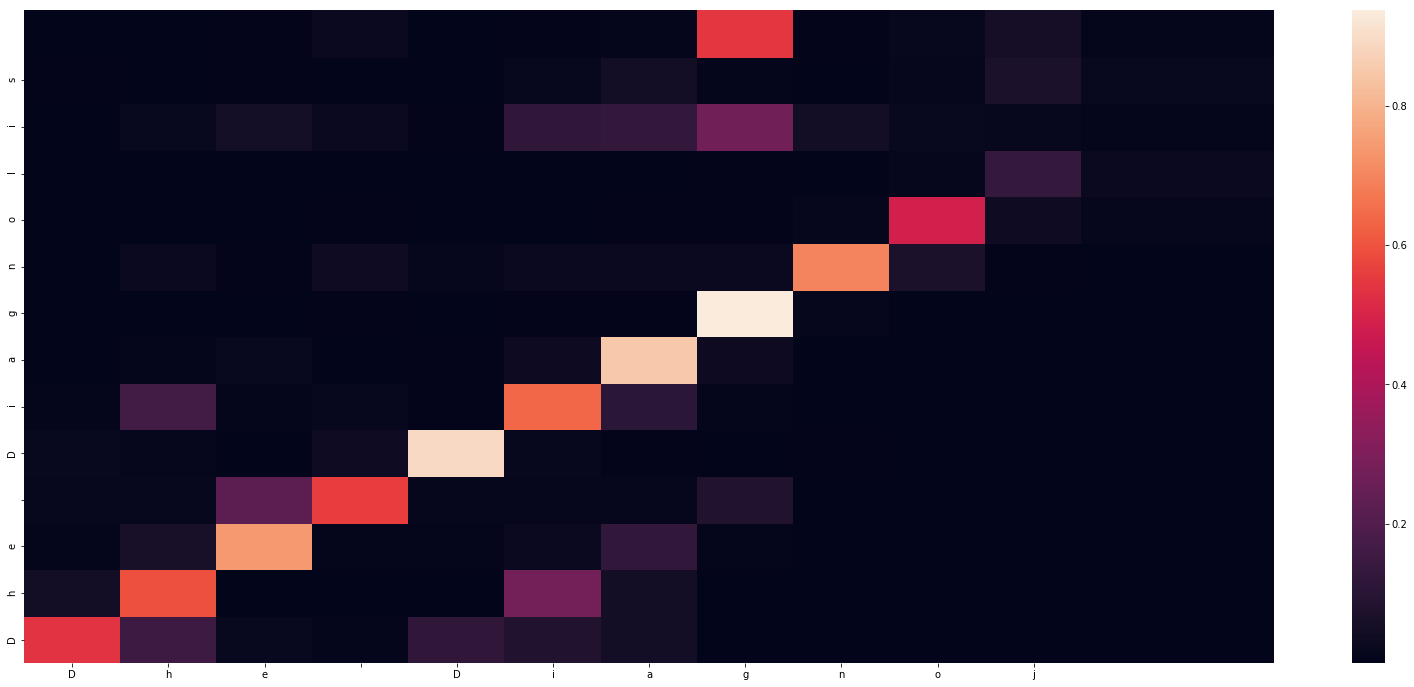

-
Input sentence: Dhe Diagnoj
GT sentence: Primary Diagnosis: 

Decoded sentence: Dhe Diagnolis


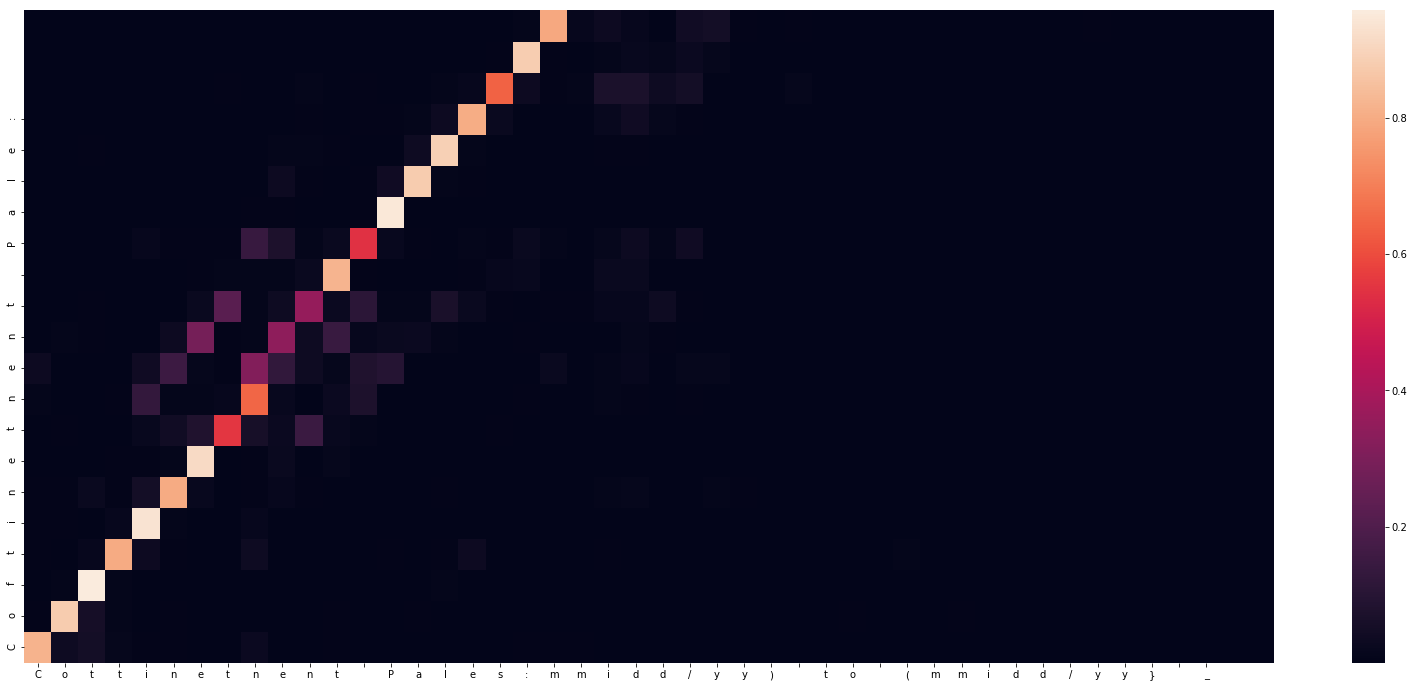

-
Input sentence: Cottinetnent Pales:mmidd/yy) to (mmidd/yy} _
GT sentence: Confinement Dates:(mm/dd/yy) to (mm/dd/yy)

Decoded sentence: Coftinetnent Pale:


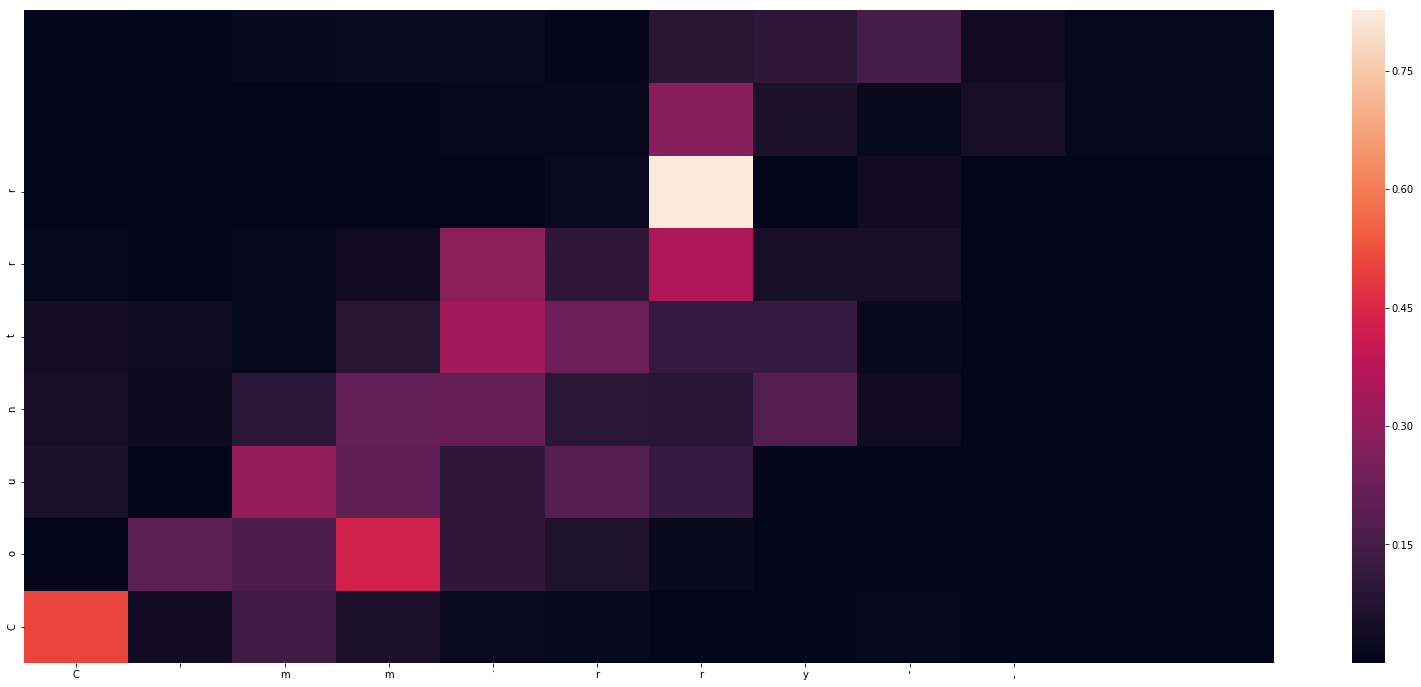

-
Input sentence: C mm’rry',
GT sentence: Country:

Decoded sentence: Countrr


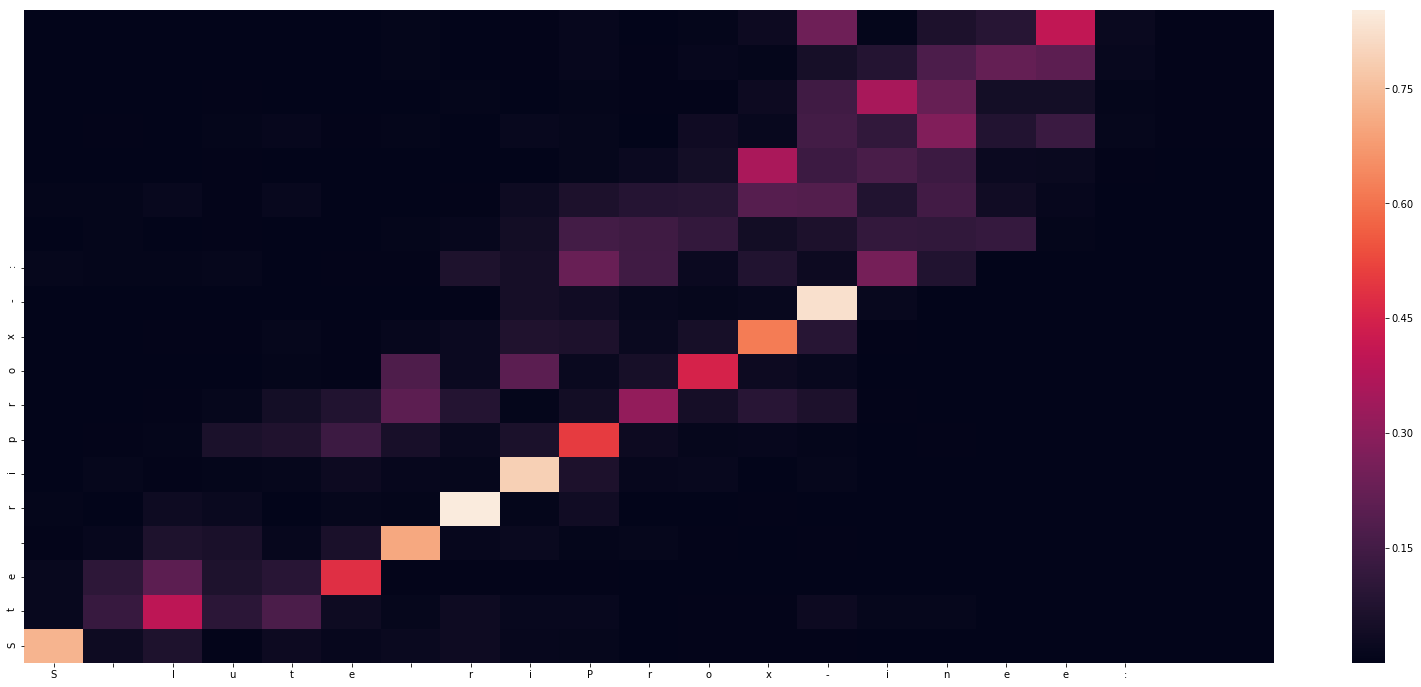

-
Input sentence: S lute riProx-inee:
GT sentence: State/Province:

Decoded sentence: Ste riprox-:


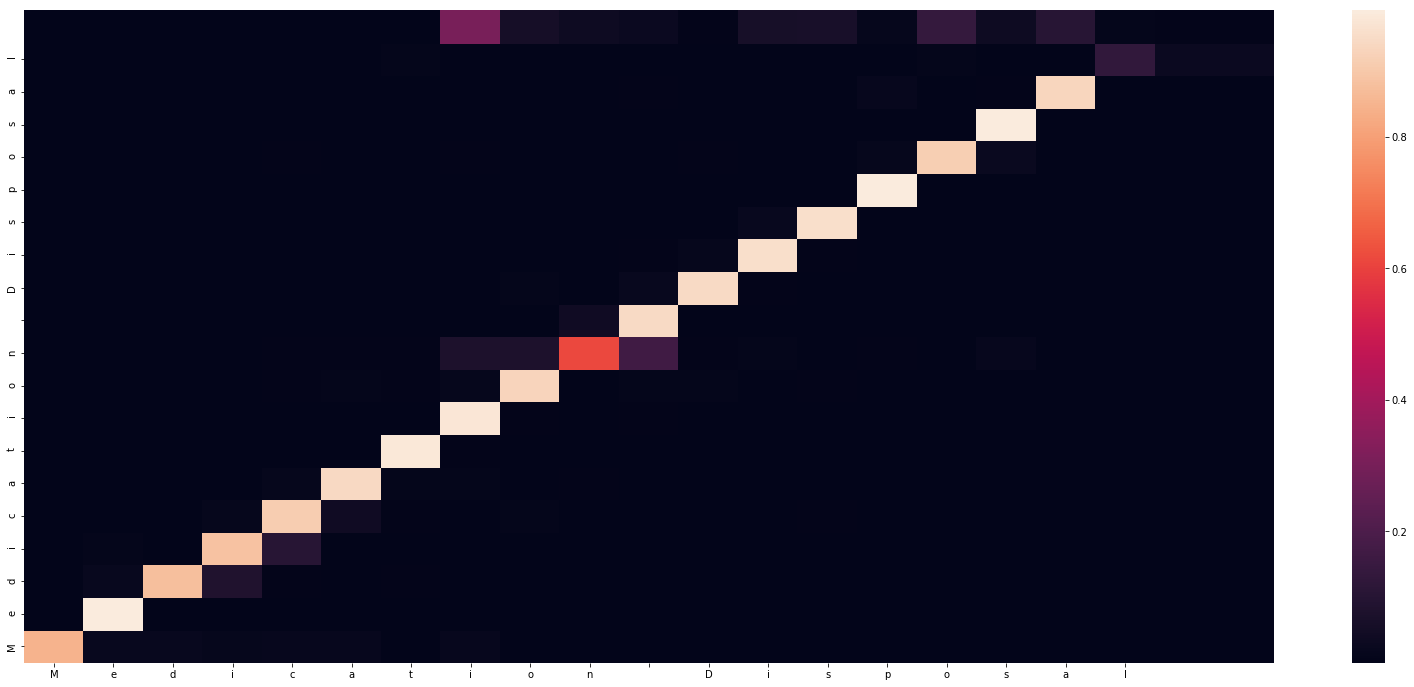

-
Input sentence: Medication Disposal
GT sentence: Medication Disposal

Decoded sentence: Medication Disposal


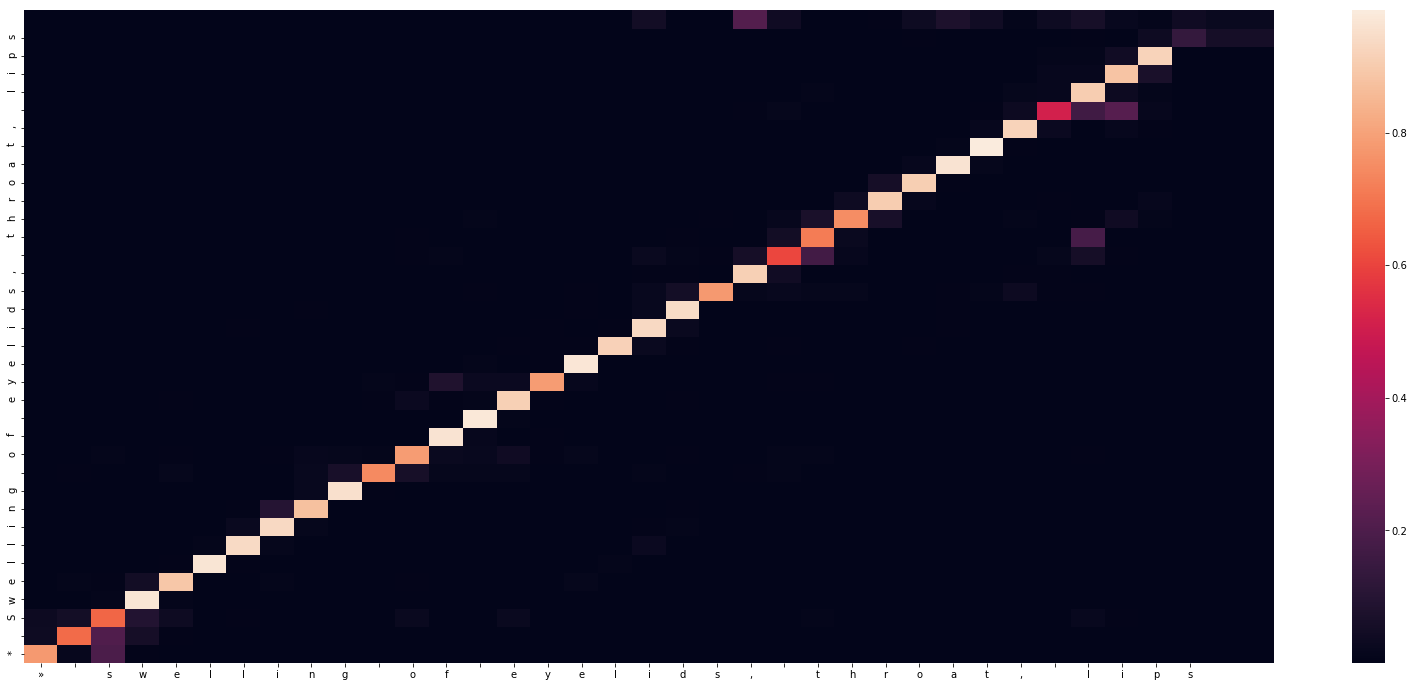

-
Input sentence: » swelling of eyelids, throat, lips
GT sentence: • swelling of eyelids, throat, lips

Decoded sentence: * Swelling of eyelids, throat, lips


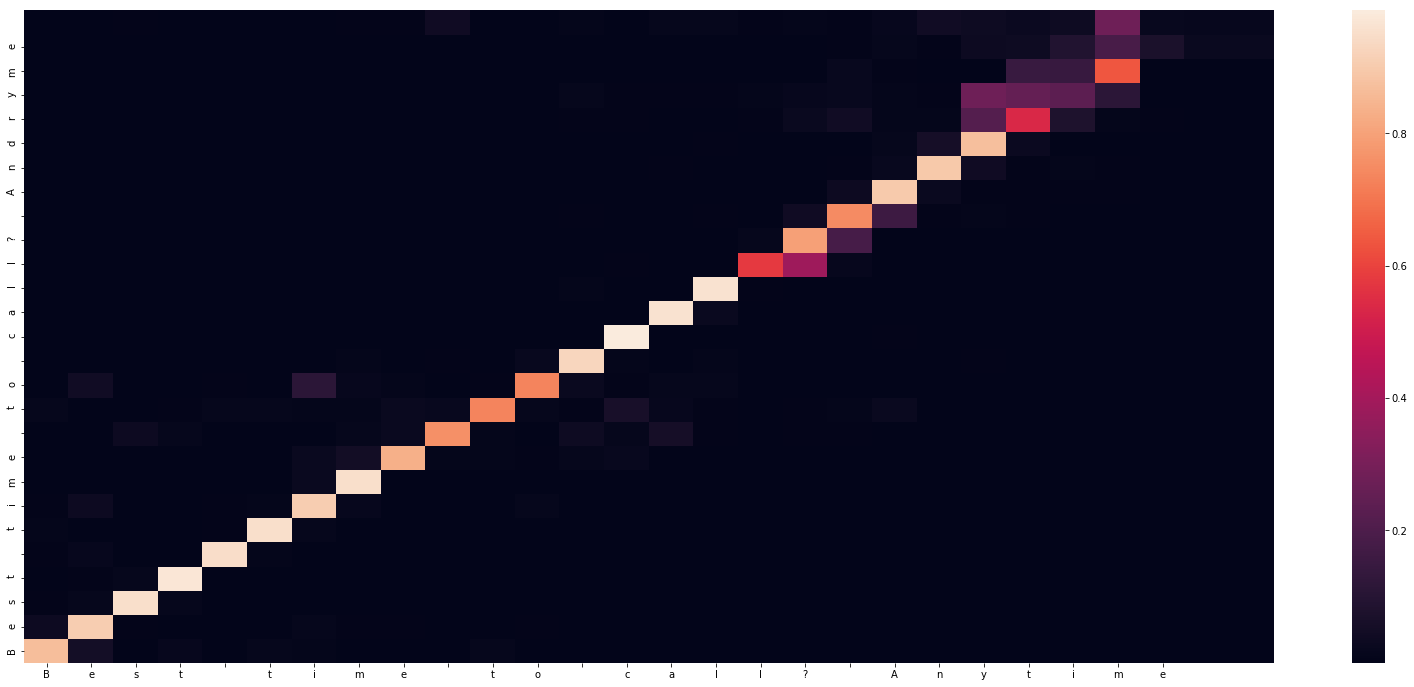

-
Input sentence: Best time to call? Anytime
GT sentence: Best time to call? Anytime

Decoded sentence: Best time to call? Andryme


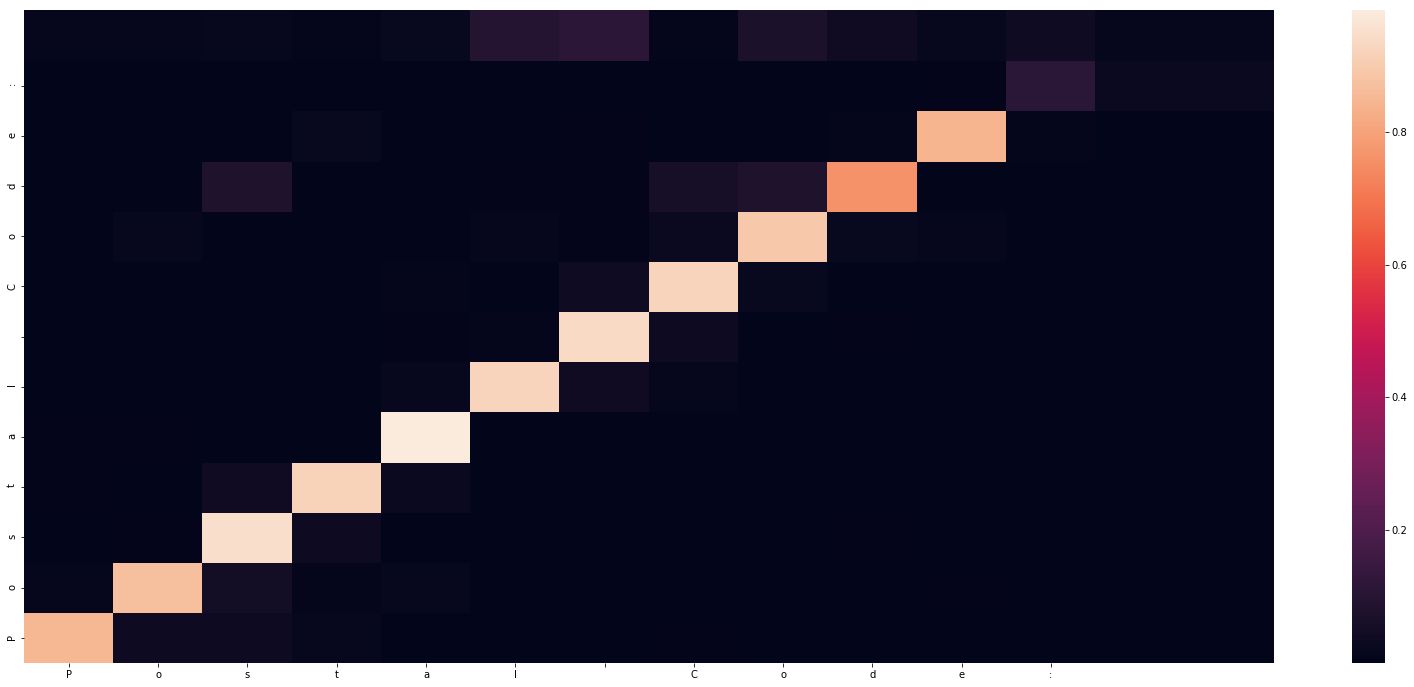

-
Input sentence: Postal Code:
GT sentence: Postal Code:

Decoded sentence: Postal Code:


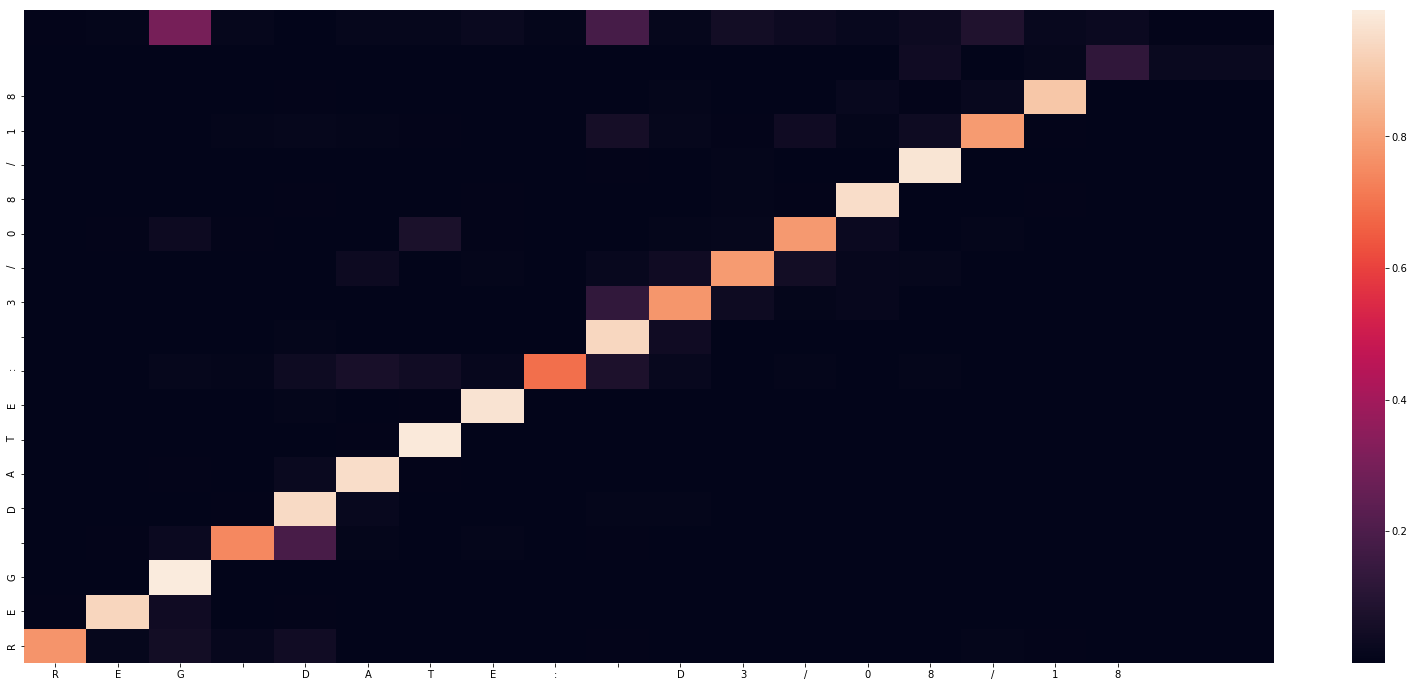

-
Input sentence: REG DATE: D3/08/18
GT sentence: REG DATE: 03/08/18

Decoded sentence: REG DATE: 3/08/18


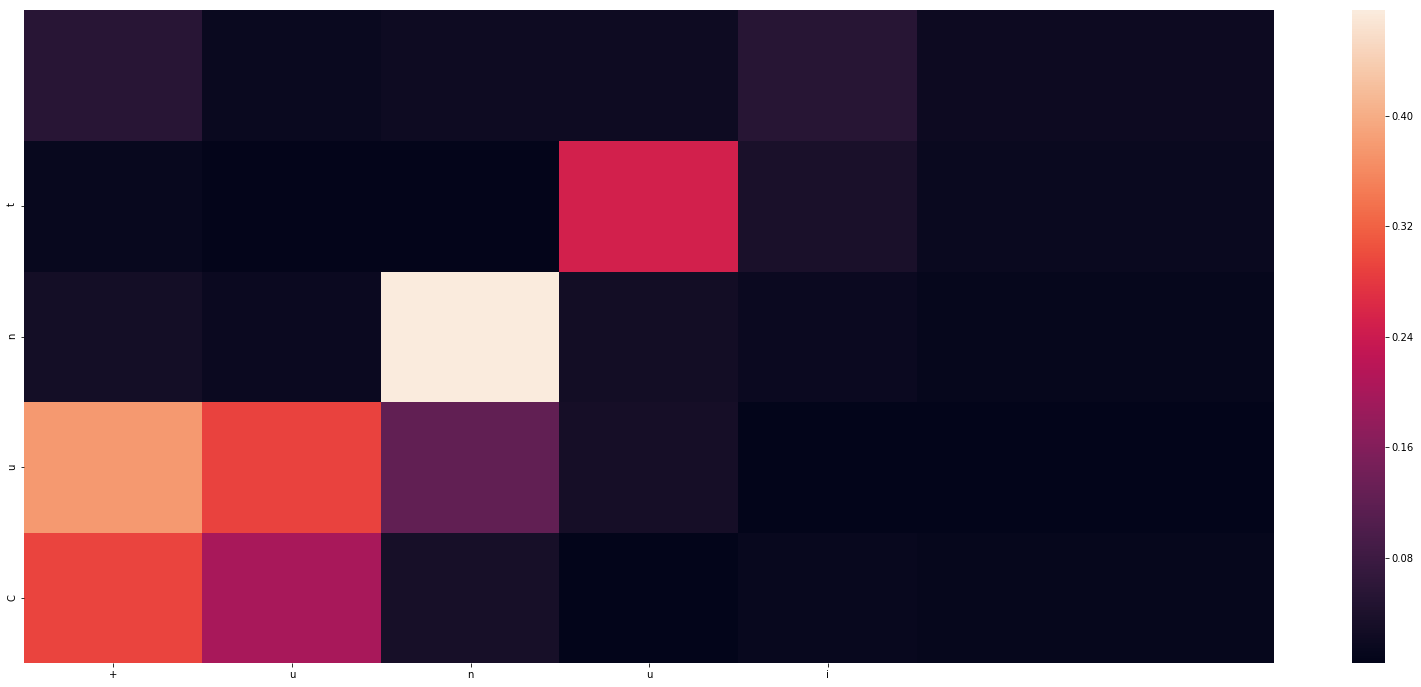

-
Input sentence: +unui
GT sentence: unum

Decoded sentence: Cunt


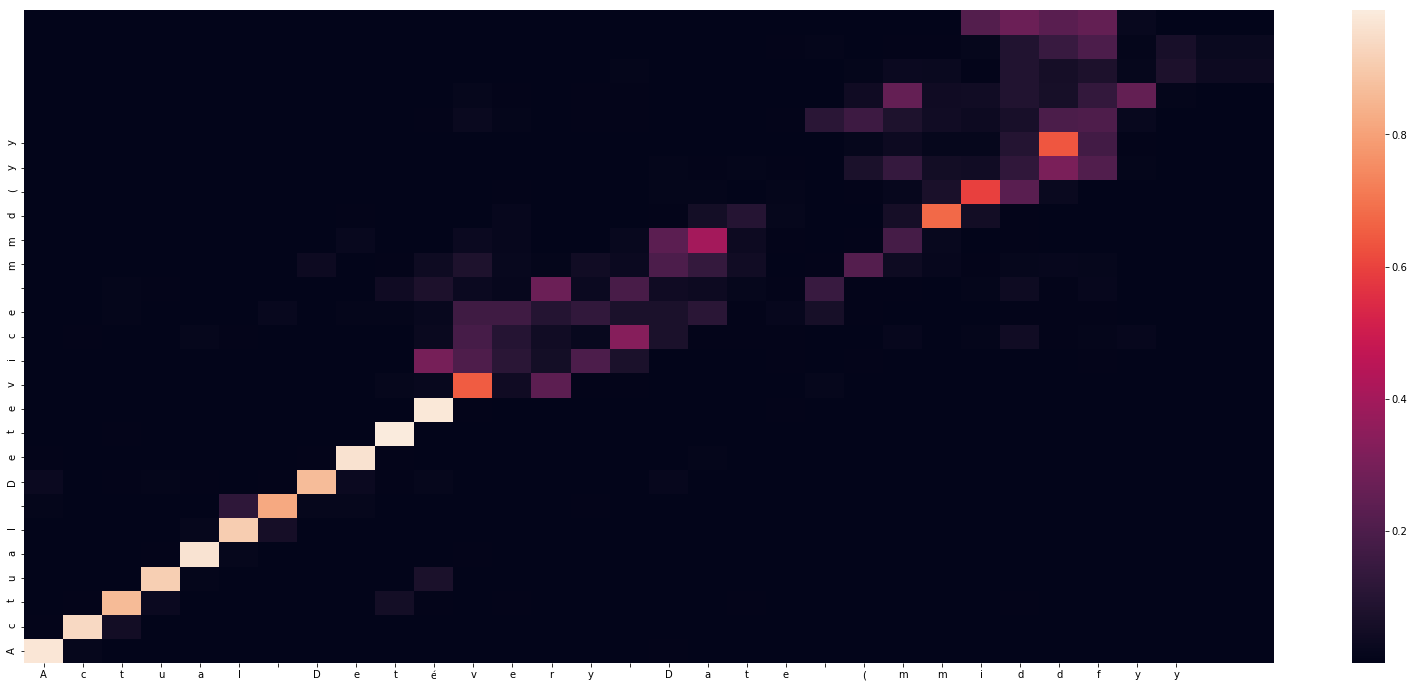

-
Input sentence: Actual Detévery Date (mmiddfyy
GT sentence: Actual Delivery Date (mm/dd/yy)

Decoded sentence: Actual Detevice mmd(yy


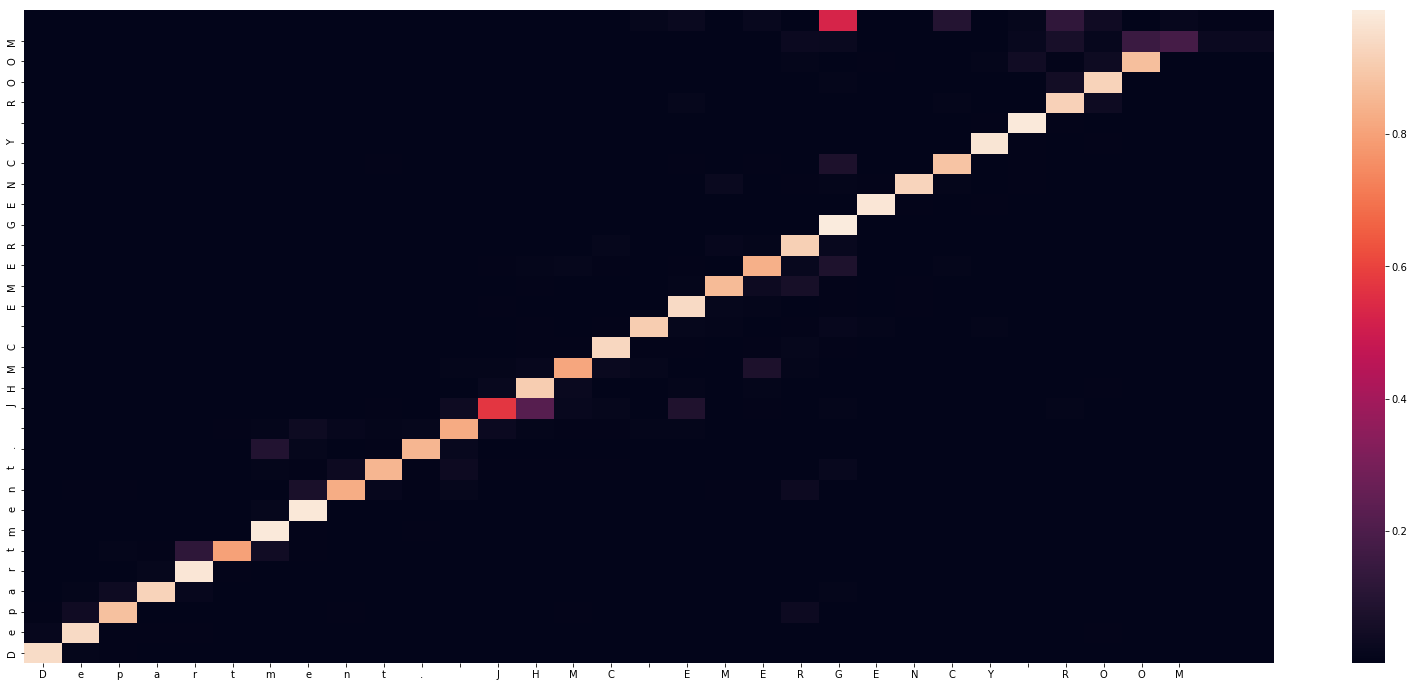

-
Input sentence: Department. JHMC EMERGENCY ROOM
GT sentence: Department: JHMC EMERGENCY ROOM

Decoded sentence: Department. JHMC EMERGENCY ROOM


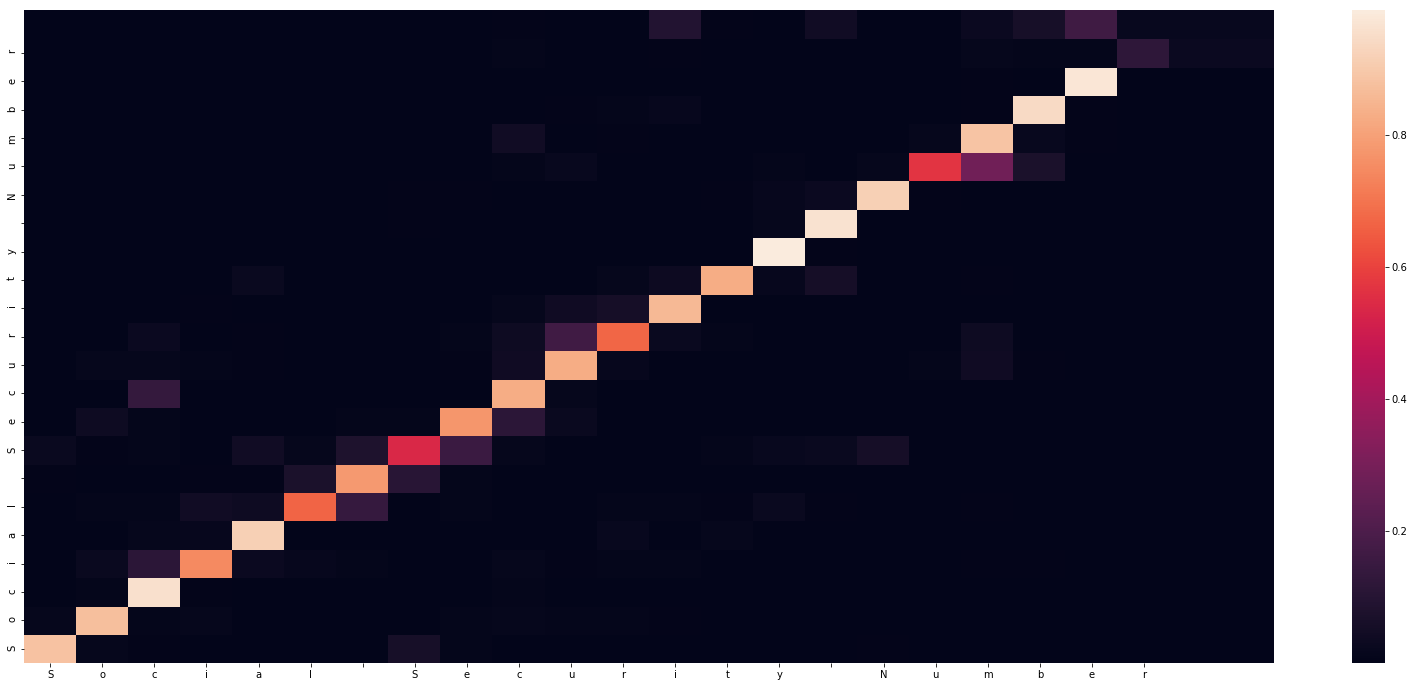

-
Input sentence: Social Security Number
GT sentence: Social Security Number

Decoded sentence: Social Security Number


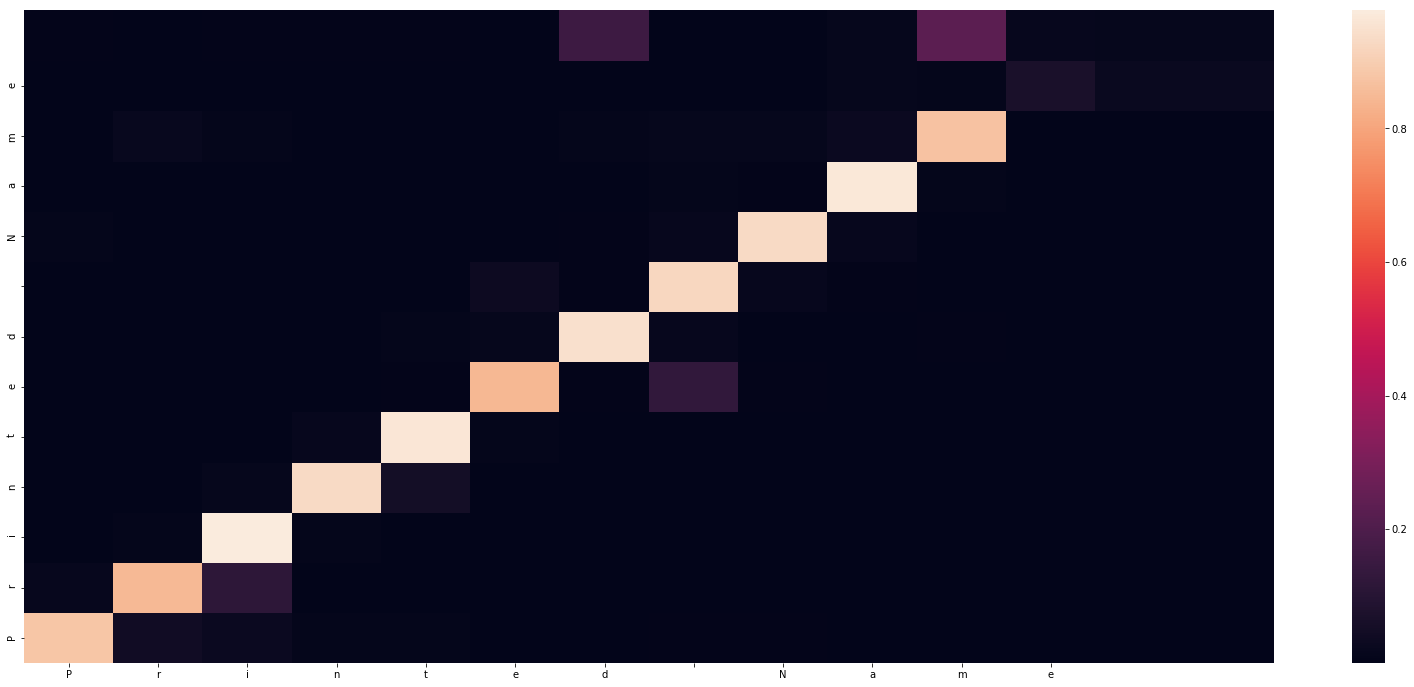

-
Input sentence: Printed Name
GT sentence: Printed Name

Decoded sentence: Printed Name


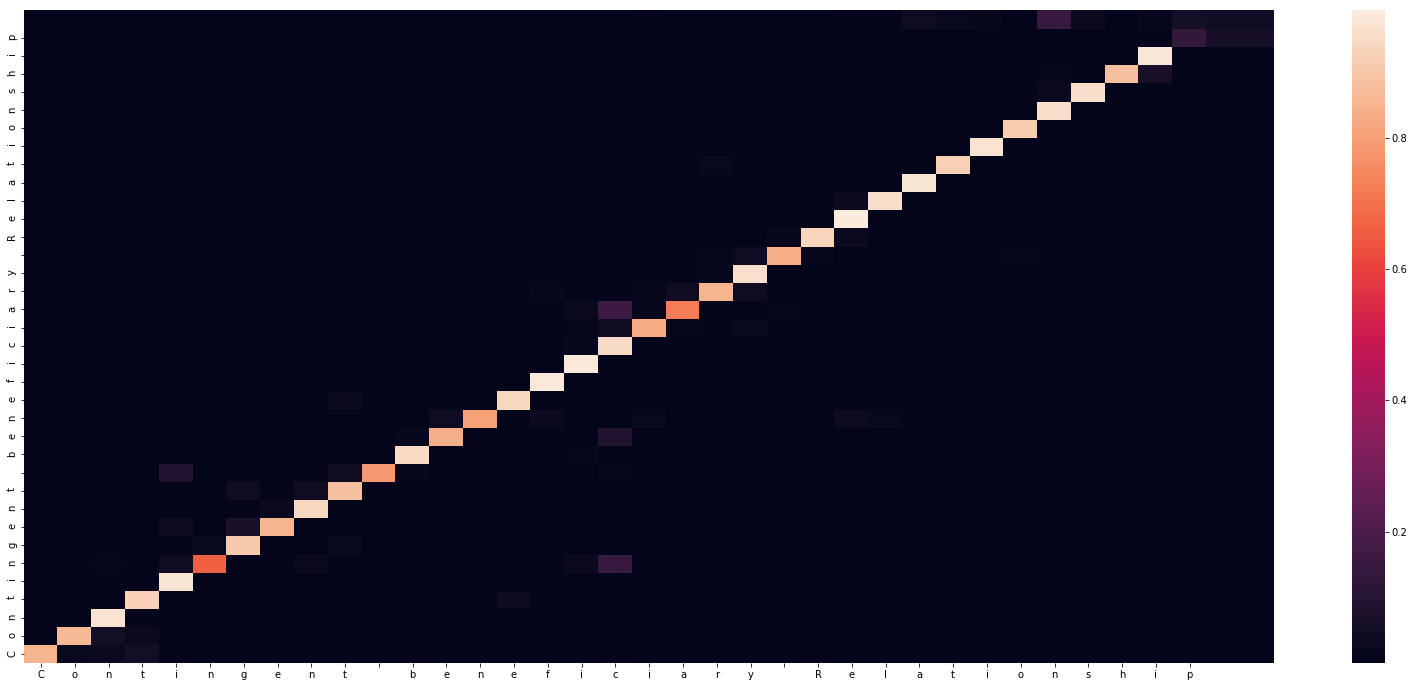

-
Input sentence: Contingent beneficiary Relationship
GT sentence: Contingent beneficiary Relationship

Decoded sentence: Contingent beneficiary Relationship


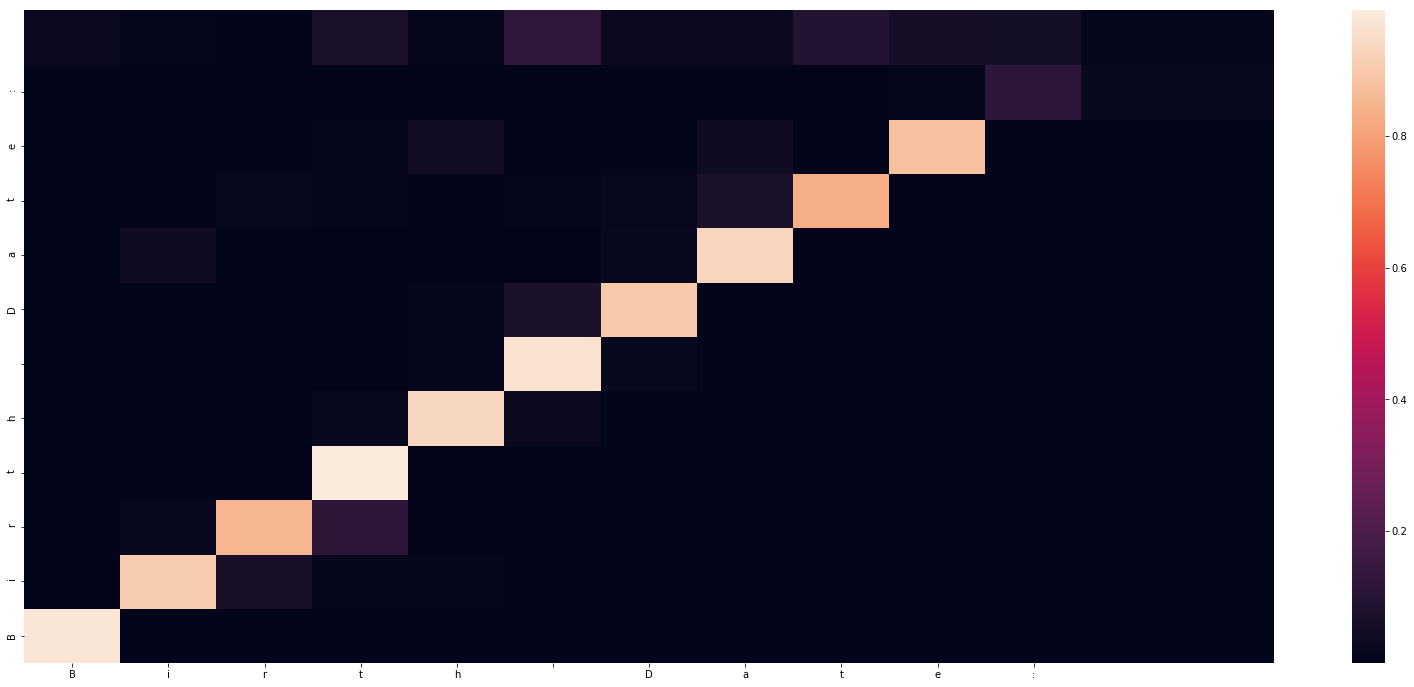

-
Input sentence: Birth Date:
GT sentence: Birth Date:

Decoded sentence: Birth Date:


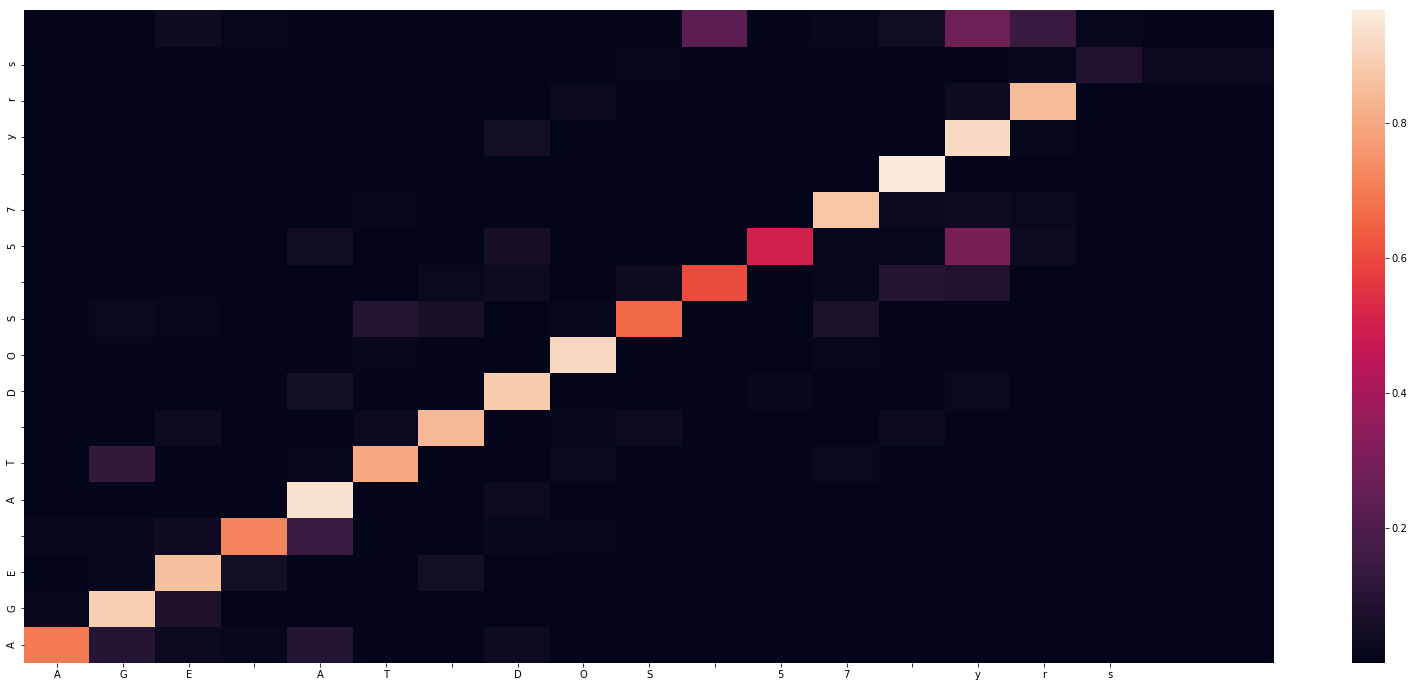

-
Input sentence: AGE AT DOS 57 yrs
GT sentence: AGE AT DOS 57 yrs

Decoded sentence: AGE AT DOS 57 yrs


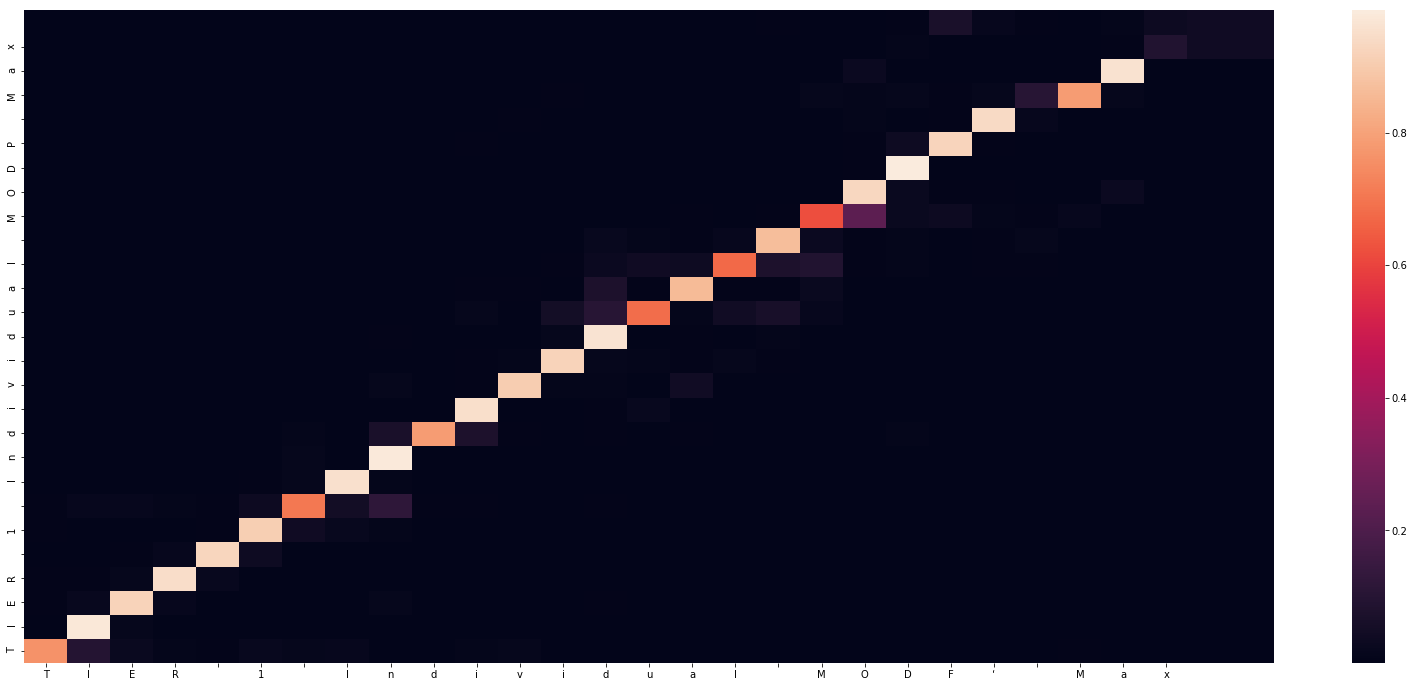

-
Input sentence: TIER 1 Individual MODF‘ Max
GT sentence: TIER 1 Individual MOOP Max

Decoded sentence: TIER 1 Individual MODP Max


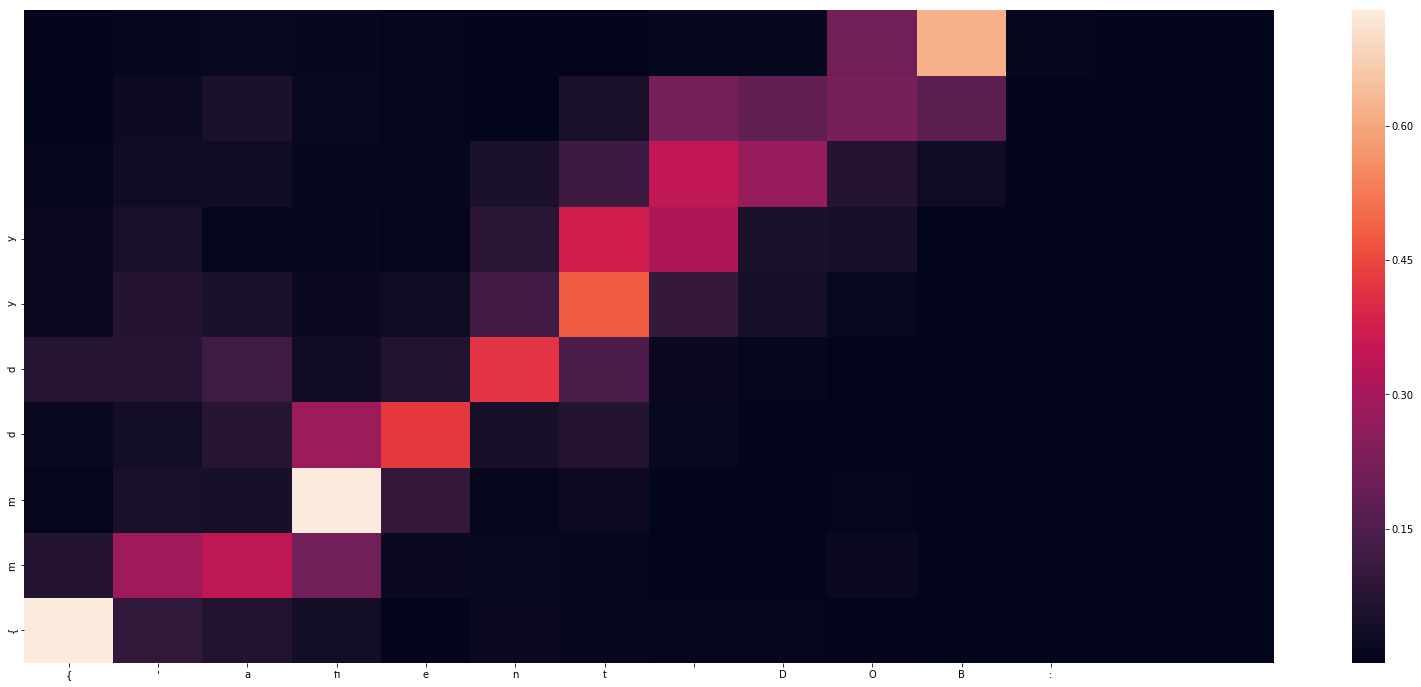

-
Input sentence: {'aﬁent DOB:
GT sentence: Patient DOB:

Decoded sentence: {mmddyy


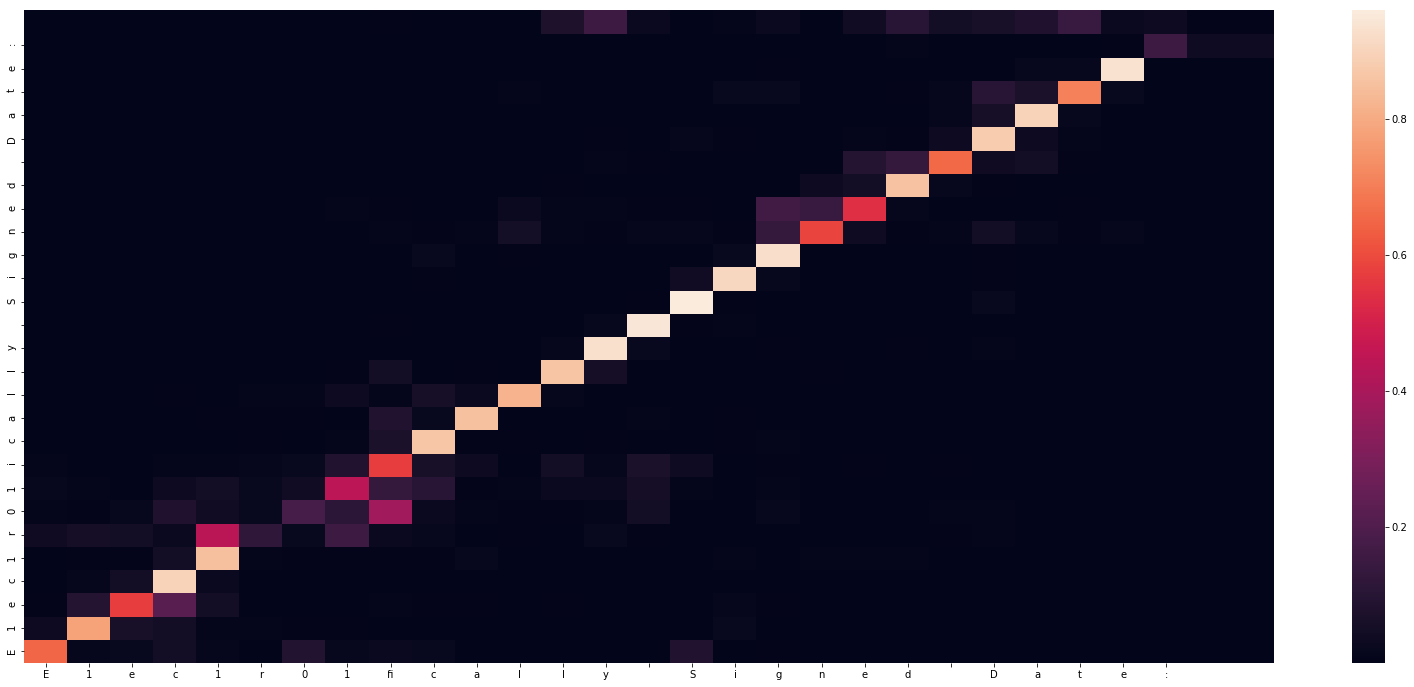

-
Input sentence: E1ec1r01ﬁcally Signed Date:
GT sentence: Electronically Signed Date:

Decoded sentence: E1ec1r01ically Signed Date:


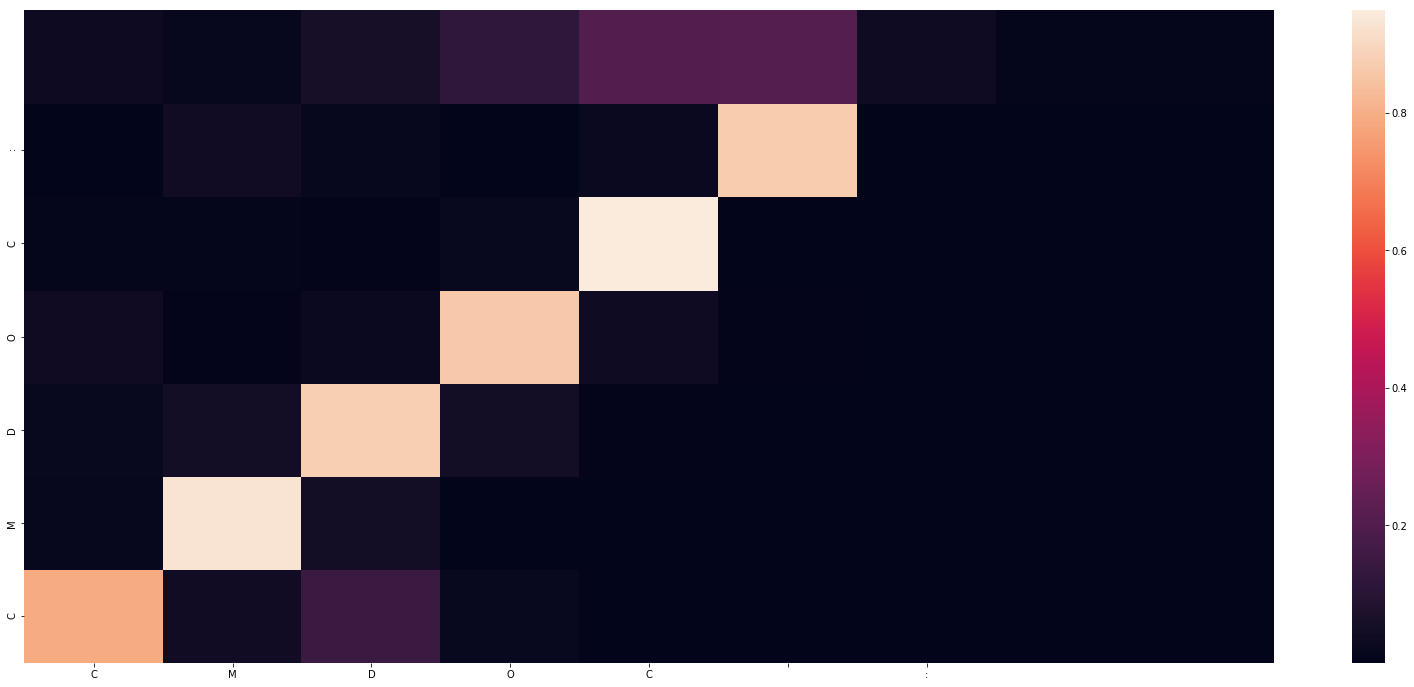

-
Input sentence: CMDOC :
GT sentence: CMDOC:

Decoded sentence: CMDOC:


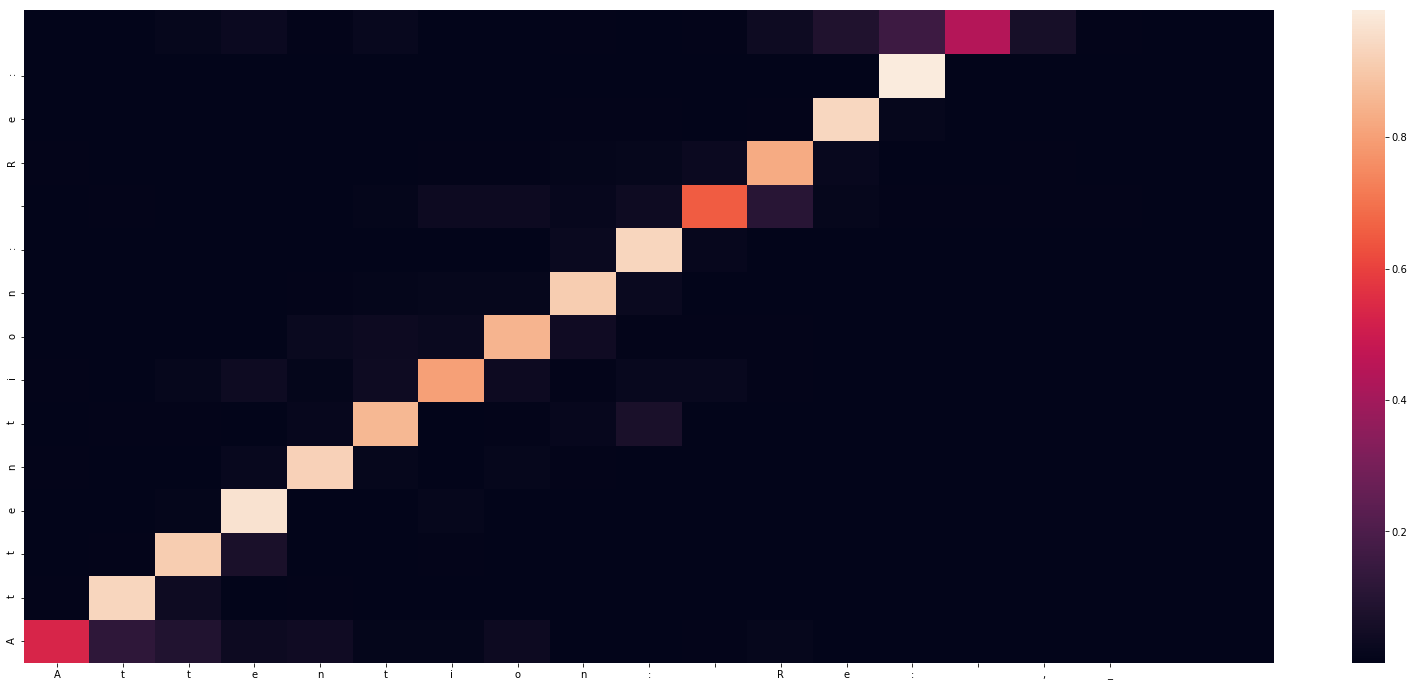

-
Input sentence: Attention: Re: ,_
GT sentence: Attention: Re:

Decoded sentence: Attention: Re:


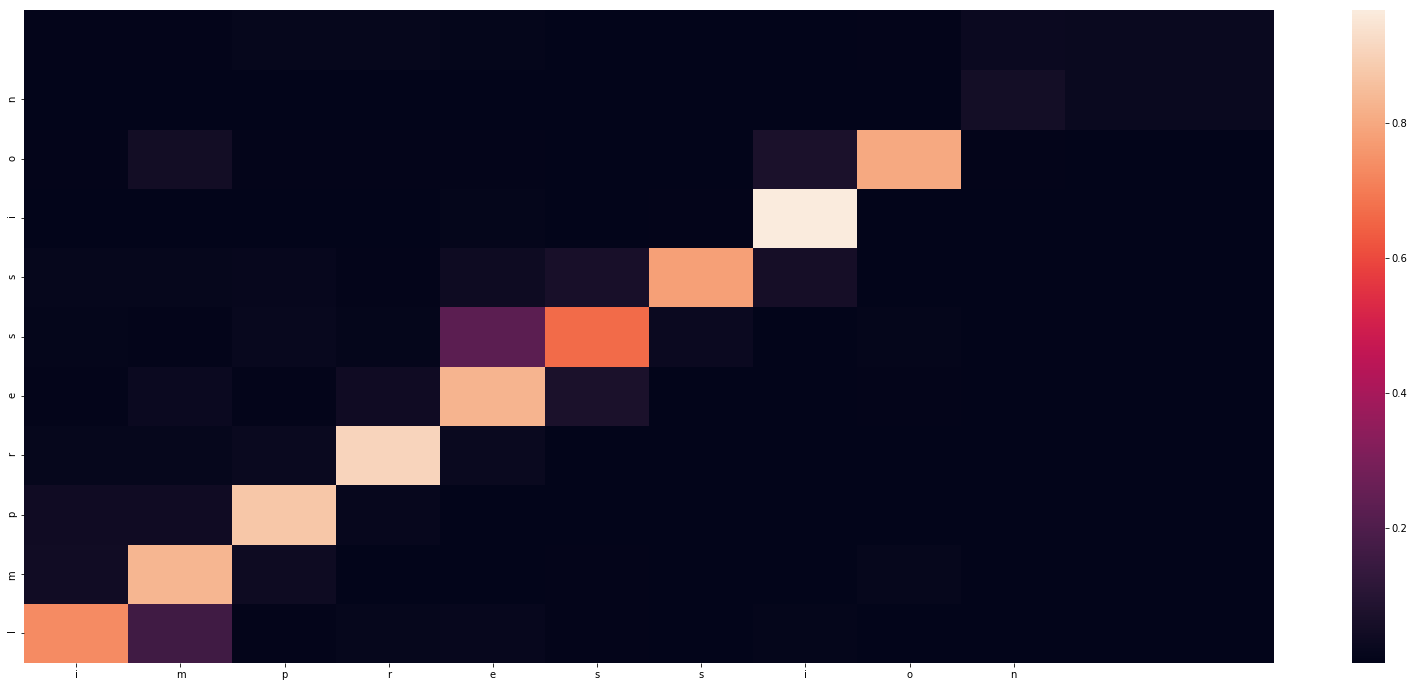

-
Input sentence: impression
GT sentence: Impression

Decoded sentence: Impression


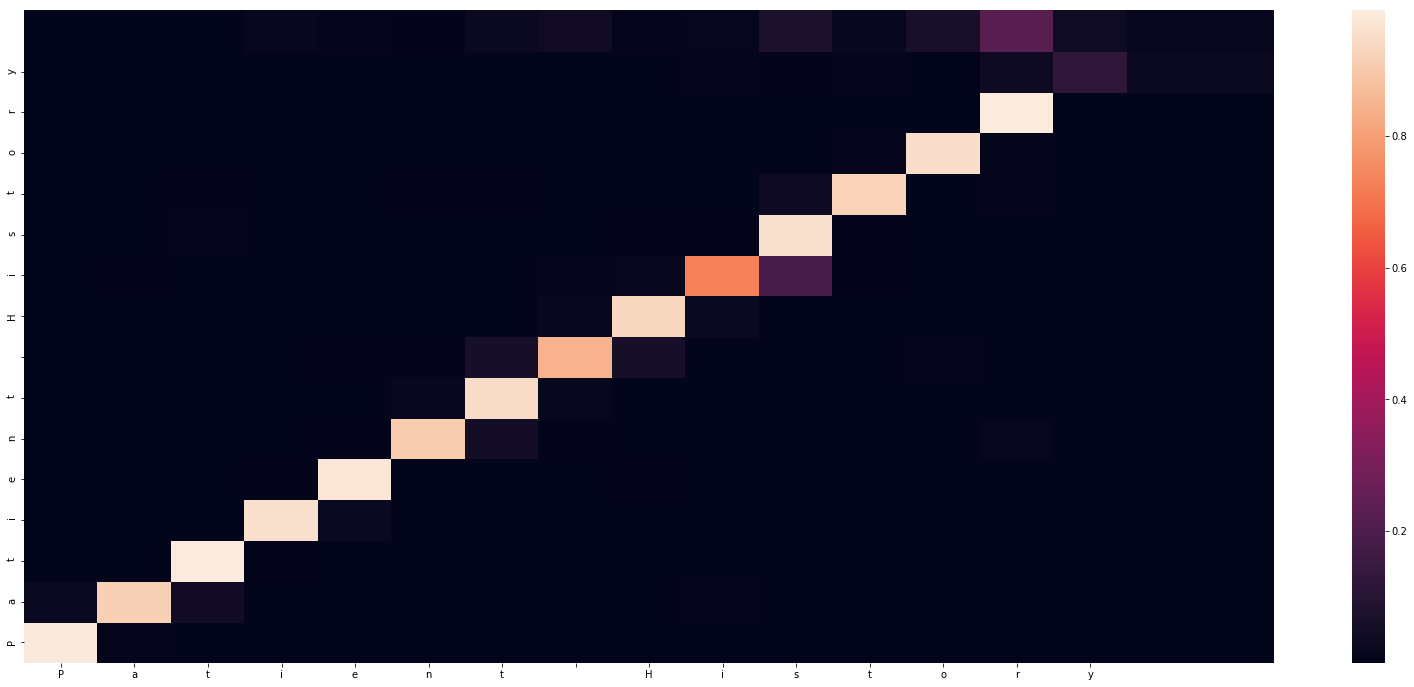

-
Input sentence: Patient History
GT sentence: Patient History

Decoded sentence: Patient History


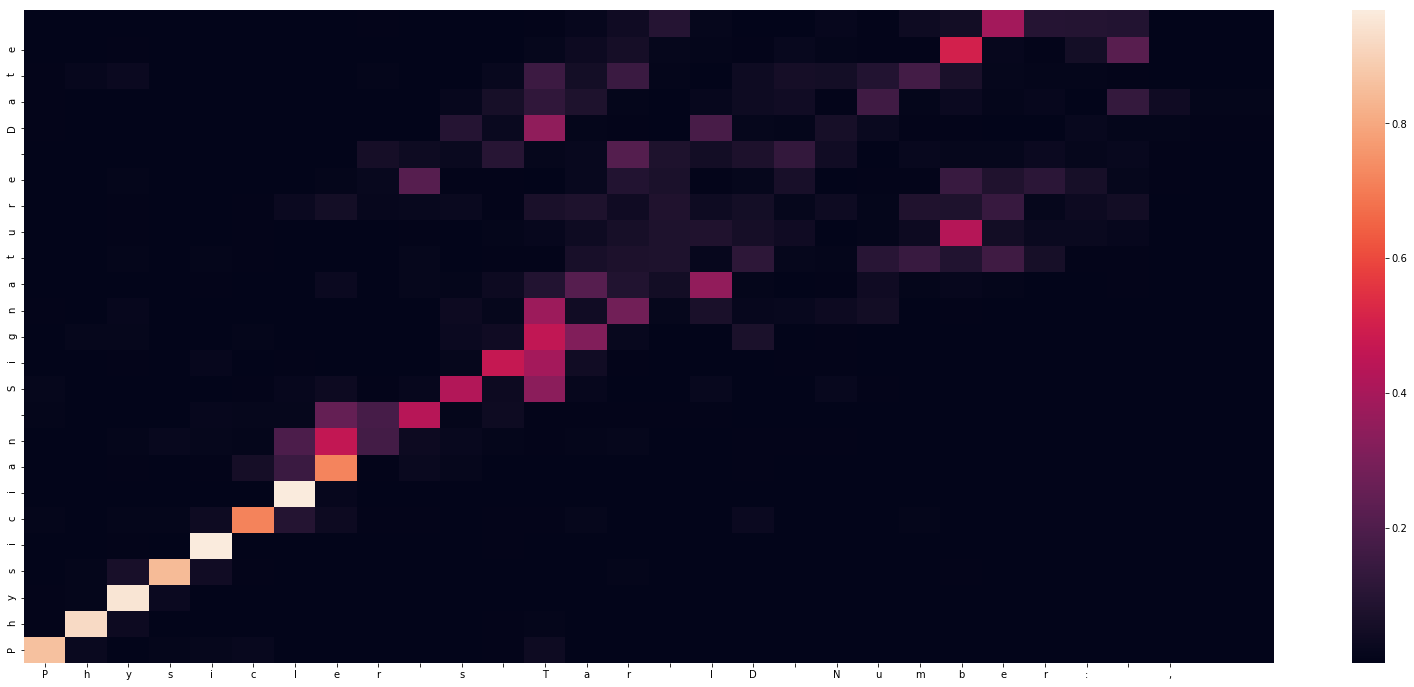

-
Input sentence: Physicler s Tar ID Number: ,
GT sentence: Physician's Tax ID Number

Decoded sentence: Physician Signature Date


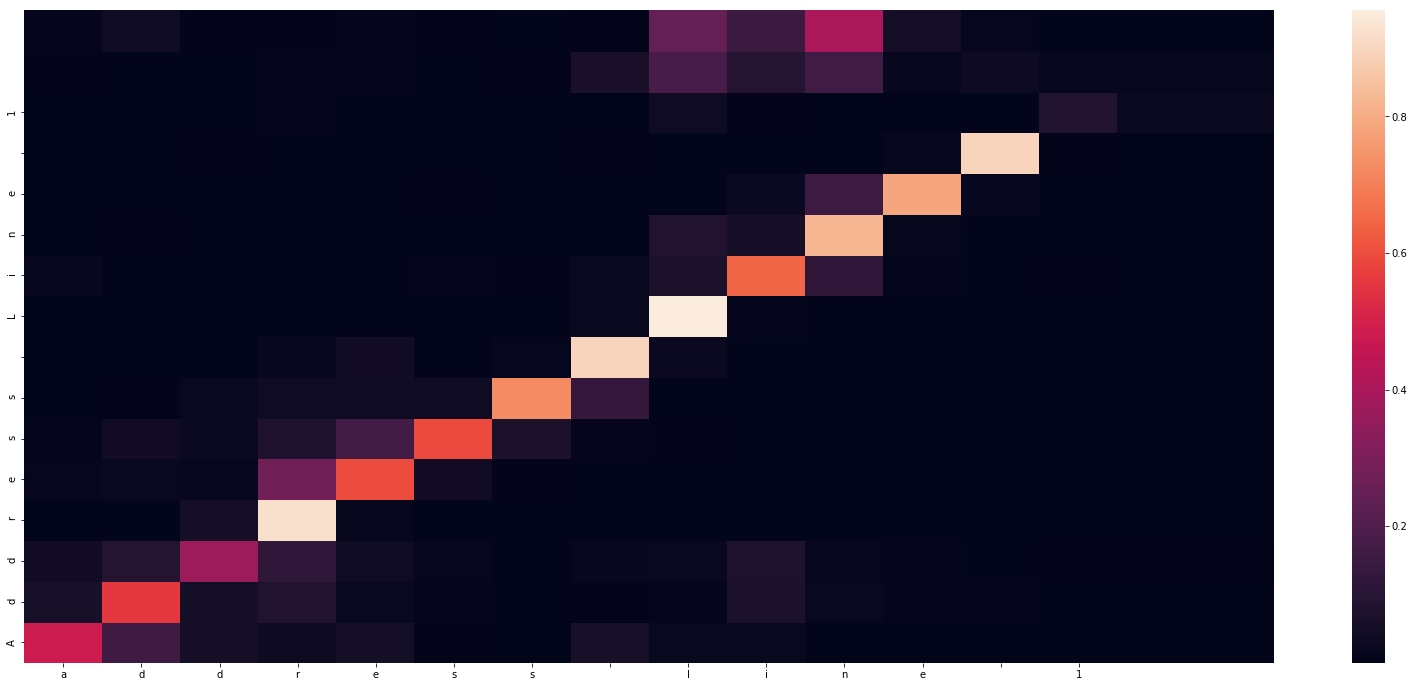

-
Input sentence: address line 1
GT sentence: Address Line 1:

Decoded sentence: Address Line 1


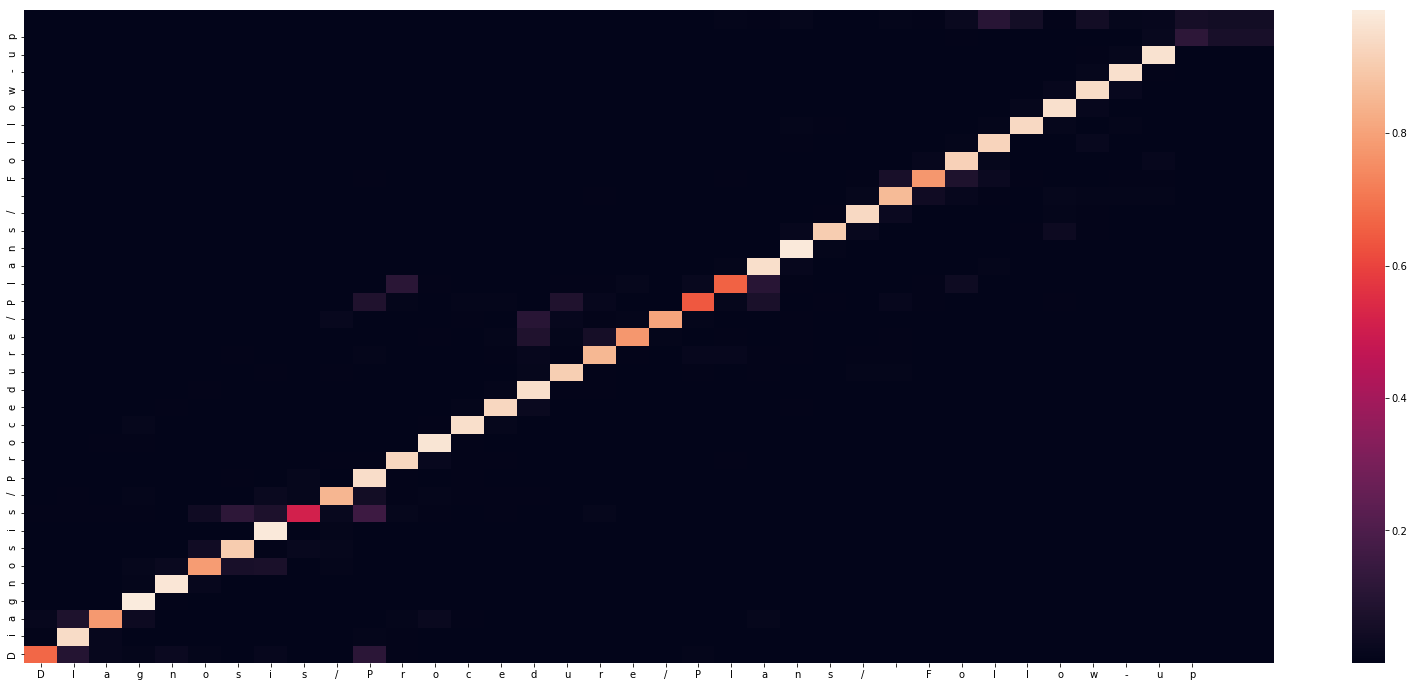

-
Input sentence: Dlagnosis/Procedure/Plans/ Follow-up
GT sentence: Diagnosis/Procedure/Plans/Follow-up

Decoded sentence: Diagnosis/Procedure/Plans/ Follow-up


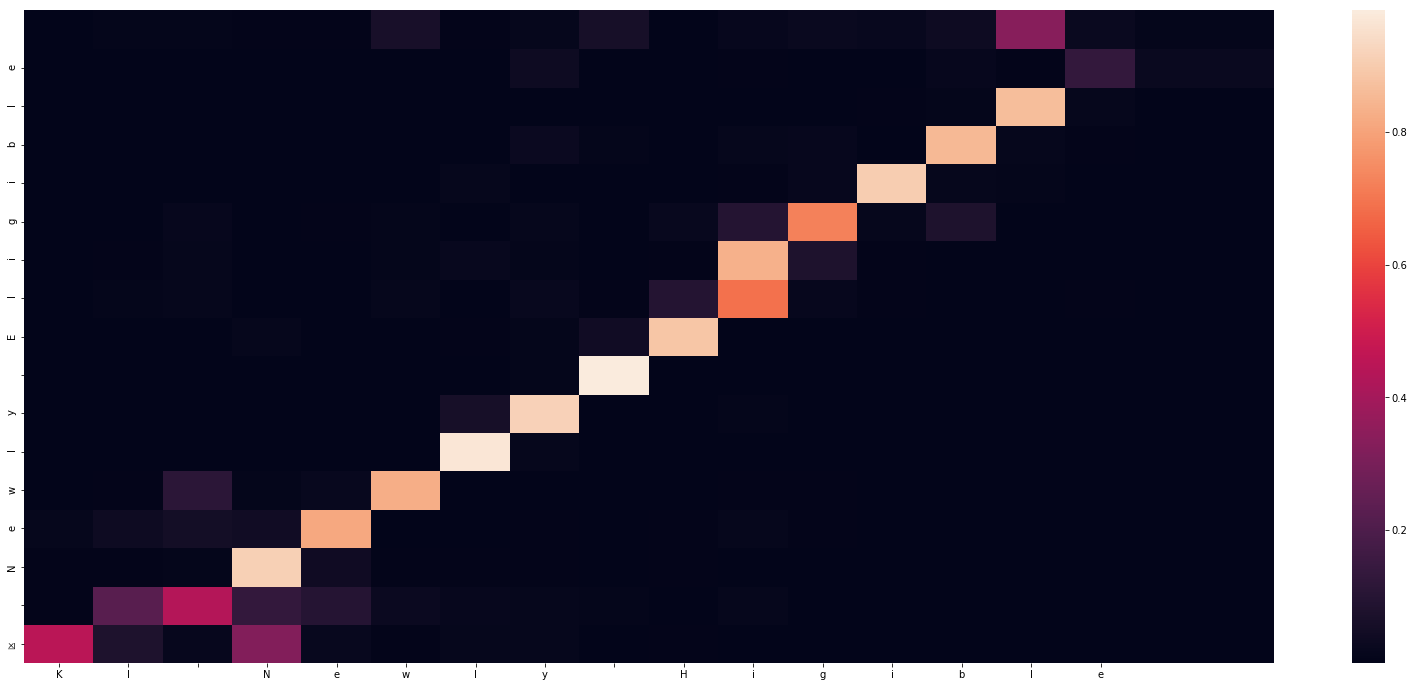

-
Input sentence: KI Newly Higible
GT sentence: ☒ Newly Eligible

Decoded sentence: ☒ Newly Eligible


In [51]:

for seq_index in range(100):
    target_text = test_target_texts[seq_index][1:-1]
    text = test_input_texts[seq_index]

    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)  


## References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.107